In [1]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
from statistics import mode
import ast
import msmexplorer as msme
from msmbuilder.utils import load,dump
import itertools
from msmbuilder.featurizer import ContactFeaturizer
from msmbuilder.featurizer import DihedralFeaturizer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
#XRD Ensemble
#28 4NPQ
#18 4HFI

In [2]:
import pickle

In [89]:
default_location = '/home/scottzhuang/pdc/'
default_skip = 10

In [4]:
def create_md_dataframe():    
    md_data = pd.DataFrame(columns=list(['MD_name','pH','replicate','subunit','traj_time']))
    return md_data

In [5]:
def create_metadata(md_data= None):   
    def append_metadata(traj_note, location = default_location, skip = default_skip, md_data = md_data):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        if traj_note.find('ethanol') >= 0:
            print("In " + traj_note + ", simulation runs " + str(skip * traj.n_frames / 2 ) + " ns.")
        else:
            print("In " + traj_note + ", simulation runs " + str(skip * traj.n_frames) + " ns.")

        md_name = traj_note[:traj_note.find('pH')-1]
        pH = traj_note[traj_note.find('pH')+2:traj_note.find('pH')+4]
        md_replicate = traj_note[-1]
        for i in range(0,traj.n_frames):
            for subunit in range(0,5):
                md_data.loc[md_data.shape[0]+1] = [md_name,pH,md_replicate,subunit,i]

    for traj_note in traj_notes:
        append_metadata(traj_note)
    md_data['traj_time'] =md_data['traj_time'].apply(int)

In [6]:
def create_system_notation(md_data = None):
    system_notation = 0
    notation = -1
    location = default_location
    skip= default_skip

    notations = []
    increment = 0
    for traj_note in traj_notes:
        if traj_note.find('ethanol') >= 0:
            top_location = traj_note + '/' + traj_note + ".ca.gro"
            traj_location = traj_note + '/' + traj_note + ".skip" + str(skip*2) + ".ca.xtc"
        else:
            top_location = traj_note + '/' + traj_note + ".ca.gro"
            traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
#        if traj_note.find('md1') >= 0:
#            notation = notation + 1
#        if traj_note.find('md4') >= 0:
#            notation = notation + 1
#       if traj_note.find('md7') >= 0:
#            notation = notation + 1
        if traj_note in notation_changer:
            notation = notation + 1
            

        for frame in range(0,traj.n_frames):
            for subunit in range(0,5):
                notations.append(notation)
        #if increment % 3 == 2:
        #    notation = notation + 1
        #increment = increment + 1 
    md_data['system'] = notations

In [7]:
def create_rmsd_data(md_data= None, ref_name = None, select_domain = None):
    def append_rmsd_data(traj_note, subunit, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        residue_selection_1 = "resSeq 13 to 198"
        residue_selection_2 = "resSeq 198 to 316"
        top_location = traj_note + '/' + traj_note + ".ca.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        traj = traj.atom_slice(traj.topology.select('chainid ' + str(subunit)))
        ref_location = location + top_location
        ref_traj = md.load(ref_location)
        ref_traj = ref_traj.atom_slice(ref_traj.topology.select('chainid ' + str(subunit)))
        traj.superpose(ref_traj,0)
        traj_rmsd_data.extend(list(md.rmsd(traj, ref_traj)*10))
    rmsd_data = []
    for traj_note in traj_notes:
        traj_rmsd_data = []

        for subunit in range(0,5):
            append_rmsd_data(traj_note,subunit)
        rmsd_data.extend(list(np.asarray(traj_rmsd_data).reshape(5,int(np.asarray(traj_rmsd_data).shape[0]/5)).T.ravel()))

    md_data['rmsd']= rmsd_data

In [8]:
def create_cppca_data(md_data = None): 
    def combined_ppca_reduced_cartesian():
        tmdtraj = md.load('/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/ensemble_subunit_tmd.pdb')
        ecdtraj = md.load('/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/ensemble_subunit_ecd.pdb')
        ppca_ecd = PCA(n_components=2)
        ppca_tmd = PCA(n_components=2)
        partial_reduced_cartesian = [ppca_ecd.fit_transform(ecdtraj.xyz.reshape(ecdtraj.n_frames, ecdtraj.n_atoms * 3)), ppca_tmd.fit_transform(tmdtraj.xyz.reshape(tmdtraj.n_frames, tmdtraj.n_atoms * 3))]    
        print(ppca_ecd.explained_variance_ratio_)
        print(ppca_tmd.explained_variance_ratio_)
        return partial_reduced_cartesian, ecdtraj, tmdtraj,ppca_ecd,ppca_tmd

    def append_projection_on_combined_ppca_data(traj_note, subunit, location = default_location, skip = default_skip, residue_selection_1 = "resSeq 8 to 192", residue_selection_2 = "resSeq 192 to 315"):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        topology = traj.topology
        traj_sliced_ecd = traj.atom_slice(topology.select(residue_selection_1 + 'and chainid ' + str(subunit) ))
        traj_sliced_tmd = traj.atom_slice(topology.select(residue_selection_2 + 'and chainid ' + str(subunit) ))

        traj_sliced_ecd.superpose(wholetraj_sliced_ecd,0)
        traj_sliced_tmd.superpose(wholetraj_sliced_tmd,0)

        reduced_cartesian_ecd_pc1.extend(ppca_ecd.transform(traj_sliced_ecd.xyz.reshape(traj_sliced_ecd.n_frames, traj_sliced_ecd.n_atoms * 3)).T[0])
        reduced_cartesian_ecd_pc2.extend(ppca_ecd.transform(traj_sliced_ecd.xyz.reshape(traj_sliced_ecd.n_frames, traj_sliced_ecd.n_atoms * 3)).T[1])
        reduced_cartesian_tmd_pc1.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[0])
        reduced_cartesian_tmd_pc2.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[1])
        
    reduced_cartesian_ecd_pc1 = []
    reduced_cartesian_ecd_pc2 = []
    reduced_cartesian_tmd_pc1 = []
    reduced_cartesian_tmd_pc2 = []
    partial_reduced_cartesian, wholetraj_sliced_ecd,wholetraj_sliced_tmd, ppca_ecd,ppca_tmd = combined_ppca_reduced_cartesian()

    for traj_note in traj_notes:
        for subunit in range(0,5):
            append_projection_on_combined_ppca_data(traj_note,subunit)
    md_data['ecd_pc1']= reduced_cartesian_ecd_pc1
    md_data['ecd_pc2']= reduced_cartesian_ecd_pc2
    md_data['tmd_pc1']= reduced_cartesian_tmd_pc1
    md_data['tmd_pc2']= reduced_cartesian_tmd_pc2

In [9]:
def create_helix_tilt_data(md_data = None):
    def append_helix_tilt_data(traj_note,subunit, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        tilt_data = pd.read_csv(location + traj_note + '/analysis/' + traj_note + '.tilt.csv',sep=" ")
        tilt_data.columns = ['traj_time','avg','ang1','ang2','ang3','ang4','ang5']
        traj_helix_tilt_data.extend(tilt_data['ang' + str(subunit+1)])

    helix_tilt_data = []
    for traj_note in traj_notes:
        traj_helix_tilt_data = []
        for subunit in range(0,5):
            append_helix_tilt_data(traj_note,subunit)
        helix_tilt_data.extend(list(np.asarray(traj_helix_tilt_data).reshape(5,int(np.asarray(traj_helix_tilt_data).shape[0]/5)).T.ravel()))

    md_data['helix tilt angle'] = helix_tilt_data

In [10]:
def create_helix_twist_data(md_data = None):
    def append_helix_twist_data(traj_note,subunit, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        twist_data = pd.read_csv(location + traj_note + '/analysis/' + traj_note + '.twist.csv',sep=" ")
        twist_data.columns = ['traj_time','avg','ang1','ang2','ang3','ang4','ang5']
        traj_helix_twist_data.extend(twist_data['ang' + str(subunit+1)])
        
    helix_twist_data = []
    for traj_note in traj_notes:
        traj_helix_twist_data = []

        for subunit in range(0,5):
            append_helix_twist_data(traj_note,subunit)
        helix_twist_data.extend(list(np.asarray(traj_helix_twist_data).reshape(5,int(np.asarray(traj_helix_twist_data).shape[0]/5)).T.ravel()))

    md_data['helix twist angle'] = helix_twist_data

In [11]:
def create_beta_expansion(md_data = None):
    def append_beta_expansion_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        distance = []
        for chain in range(0,5):
            distance.append(md.compute_distances(traj,[[27 + chain * 311,187 + chain * 311]]))
        beta_expansion_data.extend(np.mean(distance,axis=0).T[0])
    beta_expansion_data = []
    for traj_note in traj_notes:
        append_beta_expansion_data(traj_note)
    md_data['beta_expansion'] = beta_expansion_data

In [12]:
subunit_dic = {0:0,1:1,2:2,3:3,4:4,5:0}

In [13]:
def create_M2_M1_distance(md_data = None):
    def distance_calculate(x,y):
        dist = np.sqrt(np.power(x[0]-y[0],2) + np.power(x[1]-y[1],2) + np.power(x[2]-y[2],2))
        return dist
    def append_M2_M1_distance_data(traj_note,subunit,location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        distance = []
        M1_selection = 'resid ' + str(192 + subunit_dic[subunit] * 311) + ' to ' + str(196 + subunit_dic[subunit] * 311)
        M2_selection = 'resid ' + str(233 + (subunit_dic[subunit+1]) * 311) + ' to ' + str(238 + (subunit_dic[subunit+1]) * 311)
        traj_M1 = traj.atom_slice(topology.select(M1_selection))
        traj_M2 = traj.atom_slice(topology.select(M2_selection))
        distance.append(distance_calculate(md.compute_center_of_mass(traj_M1).T,md.compute_center_of_mass(traj_M2).T))
        traj_M2_M1_distance.extend(distance[0])

    M2_M1_distance = []

    for traj_note in traj_notes:
        traj_M2_M1_distance = []
        for subunit in range(0,5):
            append_M2_M1_distance_data(traj_note,subunit)
            
        M2_M1_distance.extend(list(np.asarray(traj_M2_M1_distance).reshape(5,int(np.asarray(traj_M2_M1_distance).shape[0]/5)).T.ravel()))

    md_data['M1(n)_M2(n+1)_distance'] = M2_M1_distance


In [14]:
def create_M1_kink(md_data = None):
    def angle_calculate(x,y,z):
        angle_set = []
        for i in range(0,x.shape[0]):
            angle_set.append(180 - 57.29 * np.arccos(np.dot((x[i]-y[i]),(z[i]-y[i]))/(np.linalg.norm(x[i]-y[i]) * np.linalg.norm(z[i]-y[i]))))
        return angle_set
    def append_M1_kink_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        angle = []
        for chain in range(0,5):
            M1_selection_up = 'resid ' + str(192 + chain * 311) + ' to ' + str(196 + chain * 311)
            M1_selection_mid = 'resid ' + str(194 + chain * 311) + ' to ' + str(198 + chain * 311)
            M1_selection_down = 'resid ' + str(197 + chain * 311) + ' to ' + str(208 + chain * 311)

            M1_up = traj.atom_slice(topology.select(M1_selection_up))
            M1_mid = traj.atom_slice(topology.select(M1_selection_mid))
            M1_down = traj.atom_slice(topology.select(M1_selection_down))
            angle.append(angle_calculate(md.compute_center_of_mass(M1_up), md.compute_center_of_mass(M1_mid), md.compute_center_of_mass(M1_down)))
        M1_kink.extend(np.asarray(angle).T.ravel())
    M1_kink = []
    for traj_note in traj_notes:
        append_M1_kink_data(traj_note)
    md_data['M1_kink'] = M1_kink


In [15]:
def create_M2_kink(md_data = None):
    def angle_calculate(x,y,z):
        angle_set = []
        for i in range(0,x.shape[0]):
            angle_set.append(180 - 57.29 * np.arccos(np.dot((x[i]-y[i]),(z[i]-y[i]))/(np.linalg.norm(x[i]-y[i]) * np.linalg.norm(z[i]-y[i]))))
        return angle_set
    def append_M2_kink_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        angle = []
        for chain in range(0,5):
            M2_selection_up = 'resid ' + str(216 + chain * 311) + ' to ' + str(233 + chain * 311)
            M2_selection_mid = 'resid ' + str(233 + chain * 311) + ' to ' + str(233 + chain * 311)
            M2_selection_down = 'resid ' + str(233 + chain * 311) + ' to ' + str(240 + chain * 311)

            M2_up = traj.atom_slice(topology.select(M2_selection_up))
            M2_mid = traj.atom_slice(topology.select(M2_selection_mid))
            M2_down = traj.atom_slice(topology.select(M2_selection_down))
            angle.append(angle_calculate(md.compute_center_of_mass(M2_up), md.compute_center_of_mass(M2_mid), md.compute_center_of_mass(M2_down)))
        M2_kink.extend(np.asarray(angle).T.ravel())
    M2_kink = []
    for traj_note in traj_notes:
        append_M2_kink_data(traj_note)
    md_data['M2_kink'] = M2_kink


In [16]:
def create_beta_expansion(md_data = None):
    def append_beta_expansion_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        distance = []
        for chain in range(0,5):
            distance.append(md.compute_distances(traj,[[27 + chain * 311,187 + chain * 311]]))
        beta_expansion_data.extend(np.asarray(distance).T.ravel())
    beta_expansion_data = []
    for traj_note in traj_notes:
        append_beta_expansion_data(traj_note)
    md_data['beta_expansion'] = beta_expansion_data

In [17]:
subunit_dic_mda = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'A'}

In [18]:
def create_intersubunit_hydration_data(md_data = None):
    def create_intersubunit_ethanol_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        for subunit in range(0,5):
            ethanolation = traj.select_atoms('name OW and (around 6 (protein and resid 200 and segid ' + subunit_dic_mda[subunit]  + ')) and (around 6 (protein and resid 263 and segid ' + subunit_dic_mda[subunit+1] + '))' , updating = True)
            for i in range(0,traj.trajectory.n_frames):
                traj.trajectory[i]
                traj_ethanol_data.append(ethanolation.n_atoms)
        ethanol_data.extend(list(np.asarray(traj_ethanol_data).reshape(5,traj.trajectory.n_frames).T.ravel()))

    ethanol_data = []
    for traj_note in traj_notes:
        traj_ethanol_data = []
        create_intersubunit_ethanol_data(traj_note)
    #return ethanol_data
    #ethanol_data = np.asarray(ethanol_data).reshape(traj.trajectory.n_frames,5).T.ravel()
    md_data['intersubunit_hydration_right'] = ethanol_data

In [19]:
def create_intrasubunit_hydration_data(md_data = None):
    def create_intersubunit_ethanol_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        for subunit in range(0,5):
            ethanolation = traj.select_atoms('name OW and (around 6 (resid 202 and segid ' + subunit_dic_mda[subunit]  + ')) and (around 6 (resid 235 and segid ' + subunit_dic_mda[subunit] + '))' , updating = True)
            for i in range(0,traj.trajectory.n_frames):
                traj.trajectory[i]
                traj_ethanol_data.append(ethanolation.n_atoms)
        ethanol_data.extend(list(np.asarray(traj_ethanol_data).reshape(5,traj.trajectory.n_frames).T.ravel()))

    ethanol_data = []
    for traj_note in traj_notes:
        traj_ethanol_data = []
        create_intersubunit_ethanol_data(traj_note)
    #return ethanol_data
    #ethanol_data = np.asarray(ethanol_data).reshape(traj.trajectory.n_frames,5).T.ravel()
    md_data['intrasubunit_hydration'] = ethanol_data

In [20]:
subunit_dic = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'A'}

In [21]:
def create_intersubunit_ethanol_data(md_data = None):
    def create_intersubunit_ethanol_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        for subunit in range(0,5):
            ethanolation = traj.select_atoms('resname LIG and (around 6 (protein and resid 200 and segid ' + subunit_dic[subunit]  + ')) and (around 6 (protein and resid 263 and segid ' + subunit_dic[subunit+1] + '))' , updating = True)
            for i in range(0,traj.trajectory.n_frames):
                traj.trajectory[i]
                traj_ethanol_data.append(ethanolation.n_atoms)
        ethanol_data.extend(list(np.asarray(traj_ethanol_data).reshape(5,traj.trajectory.n_frames).T.ravel()))

    ethanol_data = []
    for traj_note in traj_notes:
        traj_ethanol_data = []
        create_intersubunit_ethanol_data(traj_note)
    #return ethanol_data
    #ethanol_data = np.asarray(ethanol_data).reshape(traj.trajectory.n_frames,5).T.ravel()
    md_data['intersubunit_ethanol_right'] = ethanol_data

In [22]:
def create_intersubunit_ethanol_data_2(md_data = None):
    def create_intersubunit_ethanol_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        for subunit in [4,0,1,2,3]:
            ethanolation = traj.select_atoms('resname LIG and (around 6 (protein and resid 200 and segid ' + subunit_dic[subunit]  + ')) and (around 6 (protein and resid 263 and segid ' + subunit_dic[subunit+1] + '))' , updating = True)
            for i in range(0,traj.trajectory.n_frames):
                traj.trajectory[i]
                traj_ethanol_data.append(ethanolation.n_atoms)
        ethanol_data.extend(list(np.asarray(traj_ethanol_data).reshape(5,traj.trajectory.n_frames).T.ravel()))

    ethanol_data = []
    for traj_note in traj_notes:
        traj_ethanol_data = []
        create_intersubunit_ethanol_data(traj_note)
    #return ethanol_data
    #ethanol_data = np.asarray(ethanol_data).reshape(traj.trajectory.n_frames,5).T.ravel()
    md_data['intersubunit_ethanol_left'] = ethanol_data

In [23]:
def create_intersubunit_ethanol_data_5(md_data = None):
    def create_intersubunit_ethanol_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        for subunit in range(0,5):
            ethanolation = traj.select_atoms('resname LIG and (around 6 (protein and resid 263 and segid ' + subunit_dic[subunit]  + ')) and (around 6 (protein and resid 238 and segid ' + subunit_dic[subunit]  + '))' , updating = True)
            for i in range(0,traj.trajectory.n_frames):
                traj.trajectory[i]
                traj_ethanol_data.append(ethanolation.n_atoms)
        ethanol_data.extend(list(np.asarray(traj_ethanol_data).reshape(5,traj.trajectory.n_frames).T.ravel()))

    ethanol_data = []
    for traj_note in traj_notes:
        traj_ethanol_data = []
        create_intersubunit_ethanol_data(traj_note)
    #return ethanol_data
    #ethanol_data = np.asarray(ethanol_data).reshape(traj.trajectory.n_frames,5).T.ravel()
    md_data['intersubunit_ethanol_238_right'] = ethanol_data

In [183]:
def create_intrasubunit_ethanol_data(md_data = None):
    def create_intersubunit_ethanol_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        for subunit in range(0,5):
            ethanolation = traj.select_atoms('resname LIG and (around 6 (resid 202 and segid ' + subunit_dic[subunit]  + ')) and (around 6 (resid 235 and segid ' + subunit_dic[subunit] + '))' , updating = True)
            for i in range(0,traj.trajectory.n_frames):
                traj.trajectory[i]
                traj_ethanol_data.append(ethanolation.n_atoms)
        ethanol_data.extend(list(np.asarray(traj_ethanol_data).reshape(5,traj.trajectory.n_frames).T.ravel()))

    ethanol_data = []
    for traj_note in traj_notes:
        traj_ethanol_data = []
        create_intersubunit_ethanol_data(traj_note)
    #return ethanol_data
    #ethanol_data = np.asarray(ethanol_data).reshape(traj.trajectory.n_frames,5).T.ravel()
    md_data['intrasubunit_ethanol'] = ethanol_data

In [184]:
def create_intrasubunit_ethanol_data_2(md_data = None):
    def create_intersubunit_ethanol_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        for subunit in range(0,5):
            ethanolation = traj.select_atoms('resname LIG and (around 9 (name CA and resid 262 and segid ' + subunit_dic[subunit]  + ')) and (around 9 (name CA and resid 235 and segid ' + subunit_dic[subunit] + '))' , updating = True)
            for i in range(0,traj.trajectory.n_frames):
                traj.trajectory[i]
                traj_ethanol_data.append(ethanolation.n_atoms)
        ethanol_data.extend(list(np.asarray(traj_ethanol_data).reshape(5,traj.trajectory.n_frames).T.ravel()))

    ethanol_data = []
    for traj_note in traj_notes:
        traj_ethanol_data = []
        create_intersubunit_ethanol_data(traj_note)
    #return ethanol_data
    #ethanol_data = np.asarray(ethanol_data).reshape(traj.trajectory.n_frames,5).T.ravel()
    md_data['intrasubunit_ethanol_2'] = ethanol_data

In [219]:
def create_intrasubunit_ethanol_data_3(md_data = None):
    def create_intersubunit_ethanol_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        for subunit in range(0,5):
            ethanolation = traj.select_atoms('resname LIG and (around 6 (resid 205 and name SD and segid ' + subunit_dic[subunit]  + '))' , updating = True)
            for i in range(0,traj.trajectory.n_frames):
                traj.trajectory[i]
                traj_ethanol_data.append(ethanolation.n_atoms)
        ethanol_data.extend(list(np.asarray(traj_ethanol_data).reshape(5,traj.trajectory.n_frames).T.ravel()))

    ethanol_data = []
    for traj_note in traj_notes:
        traj_ethanol_data = []
        create_intersubunit_ethanol_data(traj_note)
    #return ethanol_data
    #ethanol_data = np.asarray(ethanol_data).reshape(traj.trajectory.n_frames,5).T.ravel()
    md_data['intrasubunit_ethanol_3'] = ethanol_data

In [221]:
def create_intrasubunit_hydration_data_3(md_data = None):
    def create_intersubunit_hydration_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        for subunit in range(0,5):
            hydration = traj.select_atoms('name OW and (around 6 (resid 205 and name SD and segid ' + subunit_dic[subunit]  + '))' , updating = True)
            for i in range(0,traj.trajectory.n_frames):
                traj.trajectory[i]
                traj_hydration_data.append(hydration.n_atoms)
        hydration_data.extend(list(np.asarray(traj_hydration_data).reshape(5,traj.trajectory.n_frames).T.ravel()))

    hydration_data = []
    for traj_note in traj_notes:
        traj_hydration_data = []
        create_intersubunit_hydration_data(traj_note)
    md_data['intrasubunit_hydration_2'] = hydration_data

In [141]:
def create_tica_cluster_data(md_data = None):
    def append_tica_cluster_data(md_data,skip=default_skip,location=default_location):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".protein.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".protein.xtc"
        for subunit in range(0,5):
            traj = md.load(location + traj_location,top = location + top_location)
            traj = traj.atom_slice(traj.topology.select('(mass > 2) and (resSeq 192 to 315) and chainid ' + str(subunit)))
            diheds = featurizer.transform(traj)
            scaled_diheds = scaler.transform(diheds)
            tica_trajs = tica_model.transform(scaled_diheds)
            label = cluster.predict(np.asarray(tica_trajs).ravel().reshape(int(np.asarray(tica_trajs).ravel().shape[0]/3),3))
            traj_cluster_data.append(label)
        cluster_data.extend(list(np.asarray(traj_cluster_data).reshape(5,traj.n_frames).T.ravel()))
    cluster_data = []
    featurizer = pickle.load(open('../pdc/msm/F238L_subunit/featurizer_F238L_tmd.pickle','rb'))
    scaler = pickle.load(open('../pdc/msm/F238L_subunit/scaler_F238L_tmd.pickle','rb'))
    tica_model = pickle.load(open('../pdc/msm/F238L_subunit/tica_model_F238L_tmd.pickle','rb'))
    cluster = pickle.load(open('../pdc/msm/F238L_subunit/F238L_tmd_cluster.pickle','rb'))
    for traj_note in traj_notes:
        traj_cluster_data = []
        append_tica_cluster_data(traj_note)
    md_data['tica_cluster'] = cluster_data

In [224]:
traj_notes = ['5NJY_pH70_md1','5NJY_pH70_md2','5NJY_pH70_md3',
              '5NJY_F238L_pH70_md1','5NJY_F238L_pH70_md2','5NJY_F238L_pH70_md3',
              '5NJY_I233T_pH70_md4','5NJY_I233T_pH70_md2','5NJY_I233T_pH70_md3',
              '5NJY_F238LI233T_pH70_md1','5NJY_F238LI233T_pH70_md2','5NJY_F238LI233T_pH70_md3',
              '5NJY_pH46_md1','5NJY_pH46_md2','5NJY_pH46_md3',
              '5NJY_F238L_pH46_md1','5NJY_F238L_pH46_md2','5NJY_F238L_pH46_md3',
              '5NJY_I233T_pH46_md1','5NJY_I233T_pH46_md2','5NJY_I233T_pH46_md3',
              '5NJY_F238LI233T_pH46_md1','5NJY_F238LI233T_pH46_md2','5NJY_F238LI233T_pH46_md3',
              '4NPQ_pH70_md5','4NPQ_pH70_md6','4NPQ_pH70_md7',
              '4NPQ_F238L_pH70_md3','4NPQ_F238L_pH70_md4','4NPQ_F238L_pH70_md5',
              '4NPQ_I233T_pH70_md3','4NPQ_I233T_pH70_md4','4NPQ_I233T_pH70_md5',
              '4NPQ_F238LI233T_pH70_md3', '4NPQ_F238LI233T_pH70_md4','4NPQ_F238LI233T_pH70_md5',
              '4HFI_F238A_pH46_md1','4HFI_F238A_pH46_md2','4HFI_F238A_pH46_md3',
              '4HFI_pH46_md4','4HFI_pH46_md5','4HFI_pH46_md6',
              '4HFI_pH46_md7','4HFI_pH46_md8','4HFI_pH46_md9',
              '4HFI_F238L_pH46_md7','4HFI_F238L_pH46_md8','4HFI_F238L_pH46_md9',
              '4HFI_F238L_pH46_md4','4HFI_F238L_pH46_md5','4HFI_F238L_pH46_md6',          
                '4HFI_I233T_pH46_md4','4HFI_I233T_pH46_md5','4HFI_I233T_pH46_md6',
              '4HFI_I233T_pH46_md7','4HFI_I233T_pH46_md8','4HFI_I233T_pH46_md9',
            '4HFI_F238LI233T_pH46_md4','4HFI_F238LI233T_pH46_md5','4HFI_F238LI233T_pH46_md6',
            '4HFI_F238LI233T_pH46_md7','4HFI_F238LI233T_pH46_md8','4HFI_F238LI233T_pH46_md9']

In [225]:
notation_changer = ['5NJY_pH70_md1',
            '5NJY_F238L_pH70_md1',
              '5NJY_I233T_pH70_md4',
              '5NJY_F238LI233T_pH70_md1',
              '5NJY_pH46_md1',
              '5NJY_F238L_pH46_md1',
              '5NJY_I233T_pH46_md1',
              '5NJY_F238LI233T_pH46_md1',
              '4NPQ_pH70_md5',
              '4NPQ_F238L_pH70_md3',
              '4NPQ_I233T_pH70_md3',
              '4NPQ_F238LI233T_pH70_md3', 
              '4HFI_F238A_pH46_md1',
              '4HFI_pH46_md4',
              '4HFI_pH46_md7',
              '4HFI_F238L_pH46_md7',
              '4HFI_F238L_pH46_md4',          
                '4HFI_I233T_pH46_md4',
              '4HFI_I233T_pH46_md7',
            '4HFI_F238LI233T_pH46_md4',
            '4HFI_F238LI233T_pH46_md7']

In [261]:
md_data = pd.read_pickle('glic_activation_subunit.pickle')

In [228]:
create_intrasubunit_hydration_data_3(md_data)

In [64]:
md_data = create_md_dataframe()
create_metadata(md_data)
create_system_notation(md_data)
create_cppca_data(md_data)

In 5NJY_pH70_md1, simulation runs 1360 ns.
In 5NJY_pH70_md2, simulation runs 750 ns.
In 5NJY_pH70_md3, simulation runs 810 ns.
In 5NJY_F238L_pH70_md1, simulation runs 850 ns.
In 5NJY_F238L_pH70_md2, simulation runs 1220 ns.
In 5NJY_F238L_pH70_md3, simulation runs 720 ns.
In 5NJY_I233T_pH70_md4, simulation runs 860 ns.
In 5NJY_I233T_pH70_md2, simulation runs 910 ns.
In 5NJY_I233T_pH70_md3, simulation runs 820 ns.
In 5NJY_F238LI233T_pH70_md1, simulation runs 830 ns.
In 5NJY_F238LI233T_pH70_md2, simulation runs 800 ns.
In 5NJY_F238LI233T_pH70_md3, simulation runs 880 ns.
In 5NJY_pH46_md1, simulation runs 1080 ns.
In 5NJY_pH46_md2, simulation runs 1060 ns.
In 5NJY_pH46_md3, simulation runs 1030 ns.
In 5NJY_F238L_pH46_md1, simulation runs 930 ns.
In 5NJY_F238L_pH46_md2, simulation runs 950 ns.
In 5NJY_F238L_pH46_md3, simulation runs 1090 ns.
In 5NJY_I233T_pH46_md1, simulation runs 810 ns.
In 5NJY_I233T_pH46_md2, simulation runs 870 ns.
In 5NJY_I233T_pH46_md3, simulation runs 980 ns.
In 5NJY

In [ ]:
create_rmsd_data(md_data)
create_helix_tilt_data(md_data)
create_helix_twist_data(md_data)
create_M2_M1_distance(md_data)
create_M1_kink(md_data)
create_M2_kink(md_data)

In [66]:
create_intersubunit_hydration_data(md_data)

In [67]:
create_intrasubunit_hydration_data(md_data)

In [145]:
create_tica_cluster_data(md_data)

In [101]:
create_beta_expansion(md_data)

In [230]:
md_data.to_pickle('glic_activation_subunit.pickle')

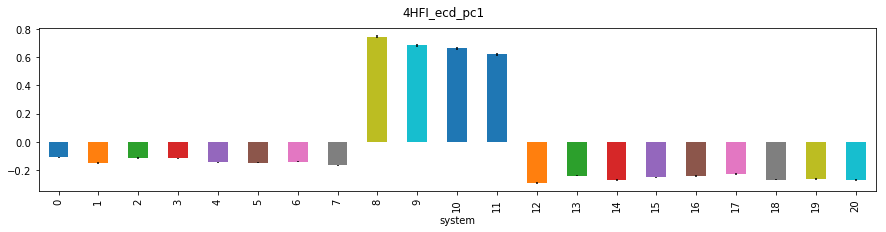

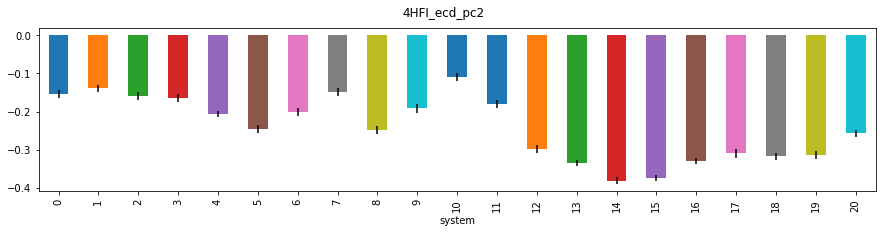

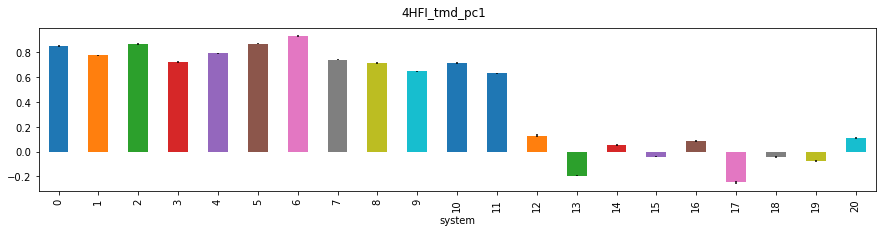

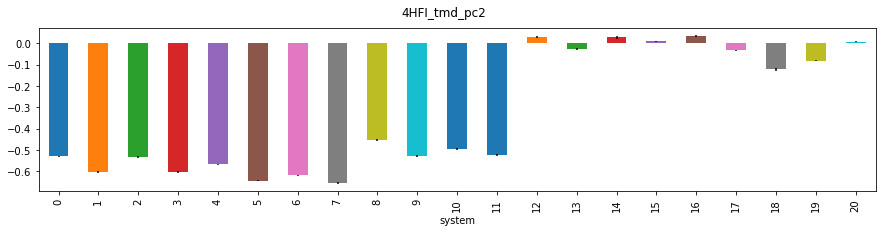

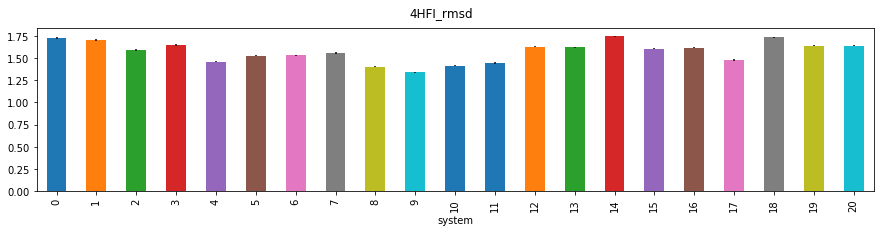

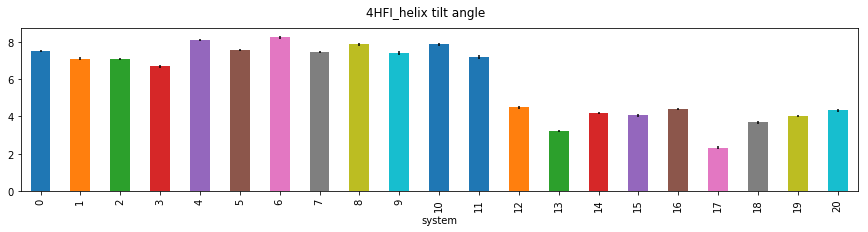

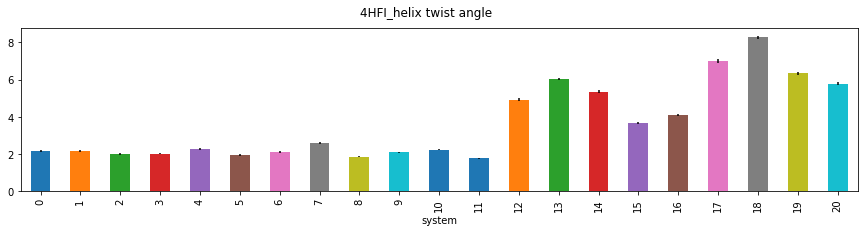

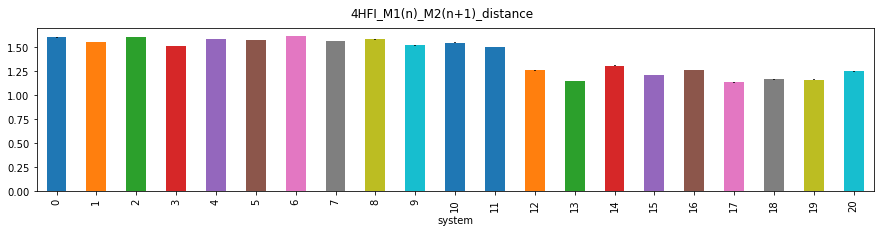

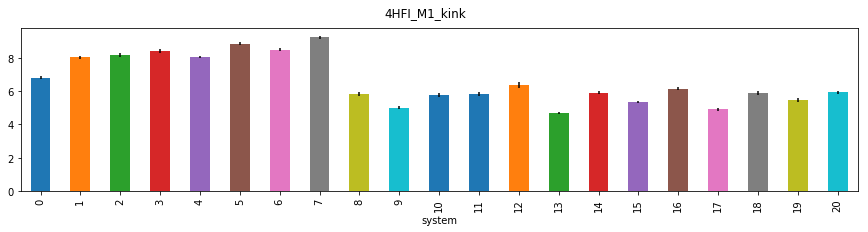

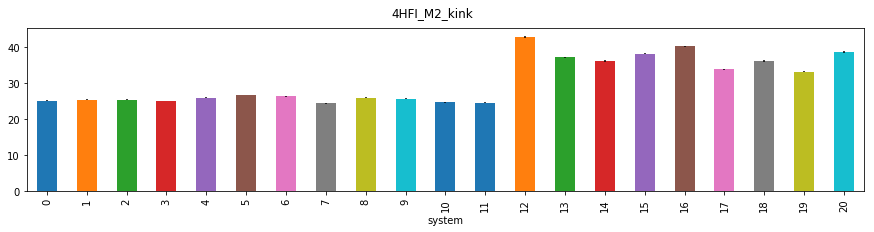

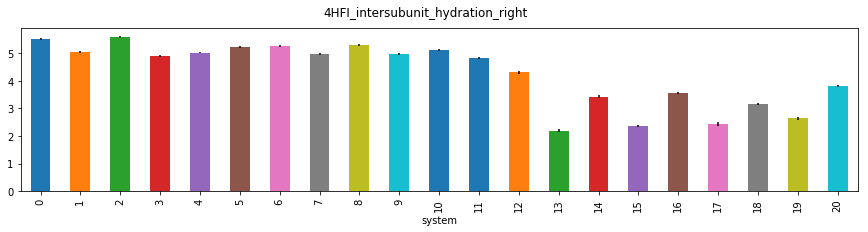

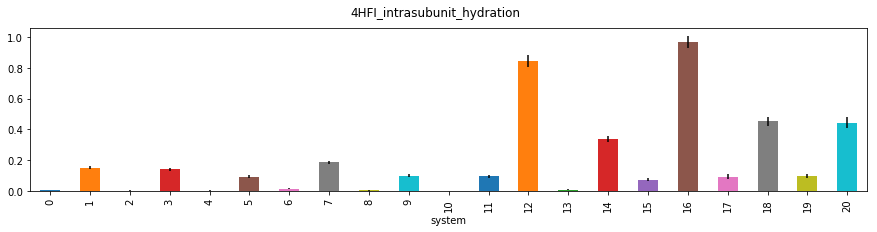

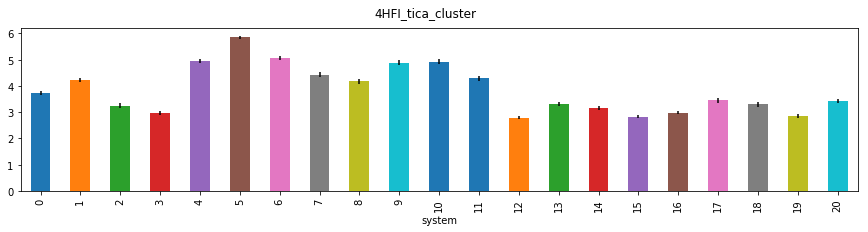

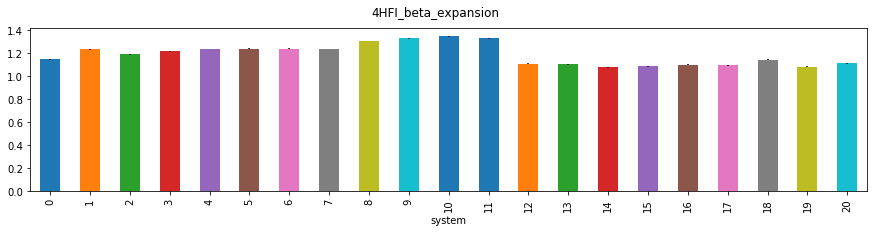

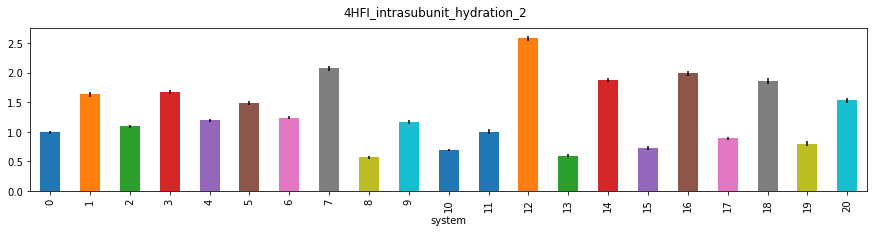

In [229]:
for feature in md_data.columns[6:]:
    fig, ax = plt.subplots(figsize=(15, 3))
#        md_data_235[md_data_235.replicate == '4'].plot(x='traj_time',y=feature,ax=ax[0],label='4',c='blue')
#        md_data_235[md_data_235.replicate == '5'].plot(x='traj_time',y=feature,ax=ax[0],label='5',c='blue')
#        md_data_235[md_data_235.replicate == '6'].plot(x='traj_time',y=feature,ax=ax[0],label='6',c='blue')
#        md_data_235[md_data_235.replicate == '7'].plot(x='traj_time',y=feature,ax=ax[0],label='7',c='red')
#        md_data_235[md_data_235.replicate == '8'].plot(x='traj_time',y=feature,ax=ax[0],label='8',c='red')
#        md_data_235[md_data_235.replicate == '9'].plot(x='traj_time',y=feature,ax=ax[0],label='9',c='red')
#        ax[0].set_xlim(0,90)
    fig.suptitle('4HFI_' + feature)
    group = md_data[md_data.traj_time > 20].groupby(['system'],sort=False)[feature]
    mean = group.mean()
    errors = group.sem()
    mean.plot.bar(yerr=errors,ax=ax)
#    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


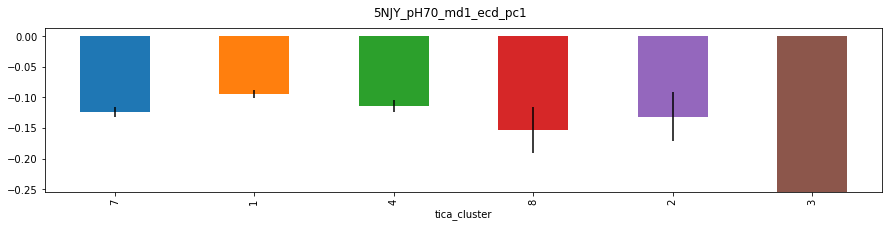

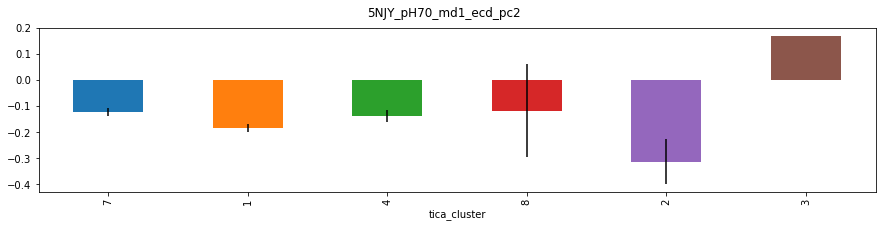

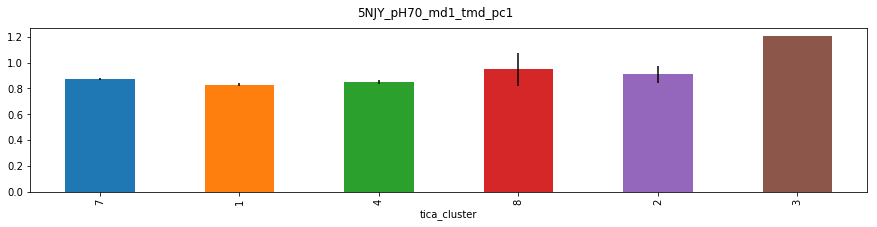

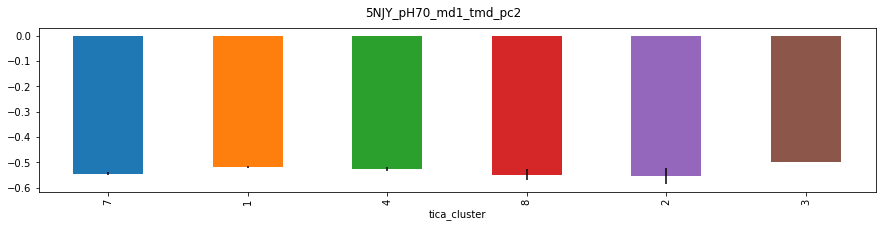

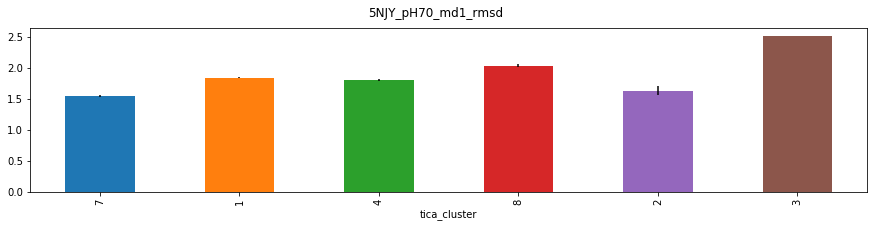

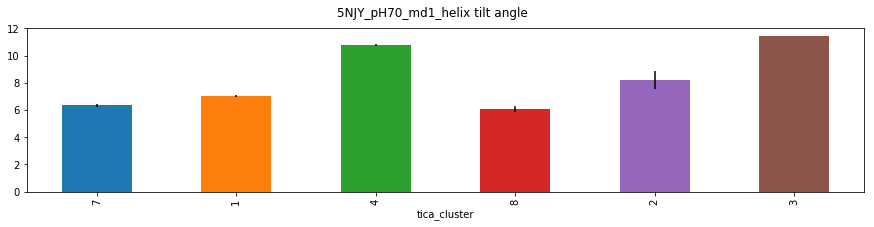

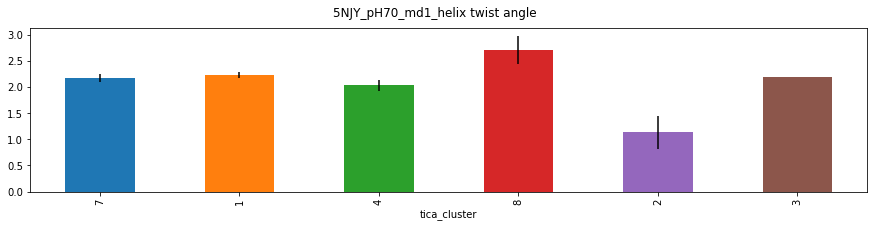

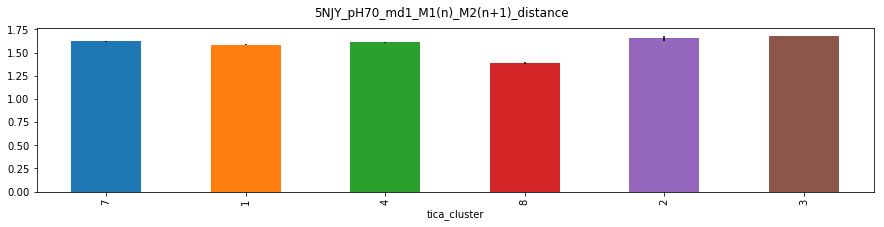

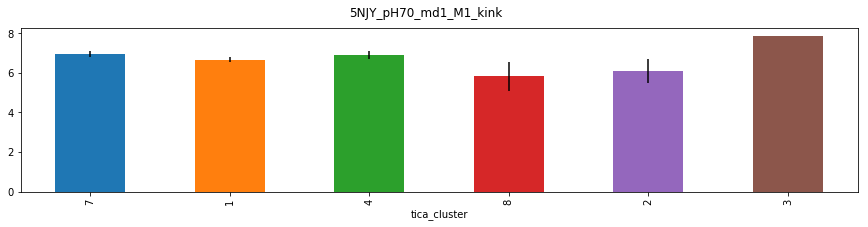

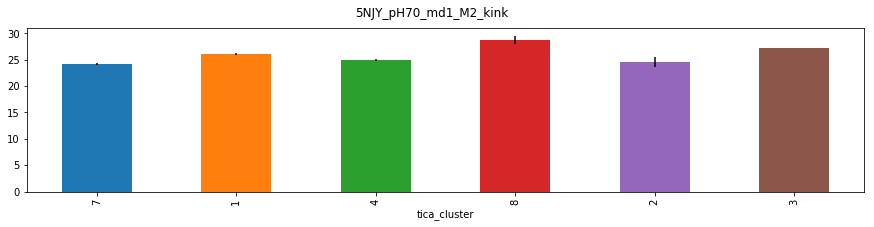

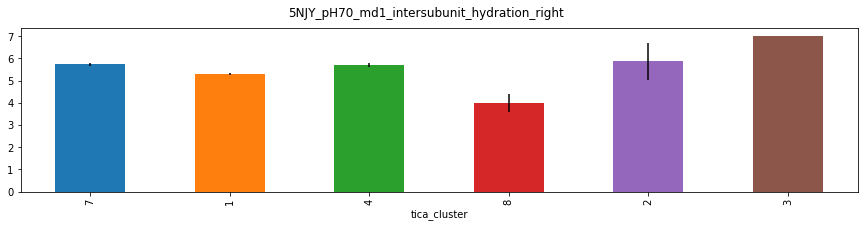

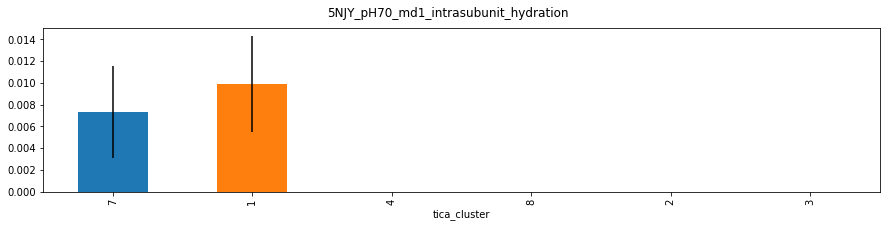

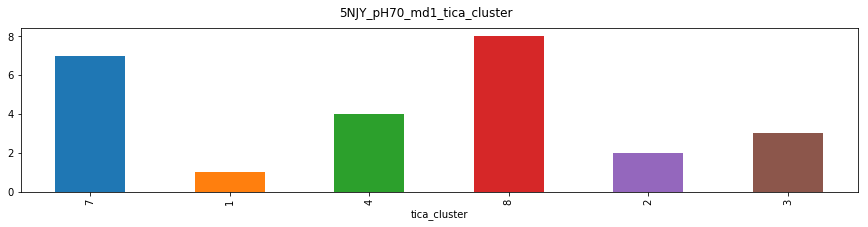

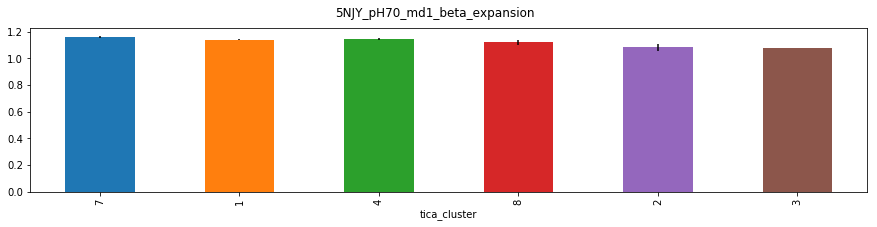

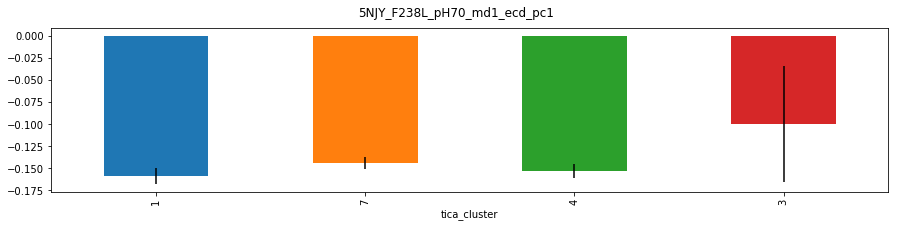

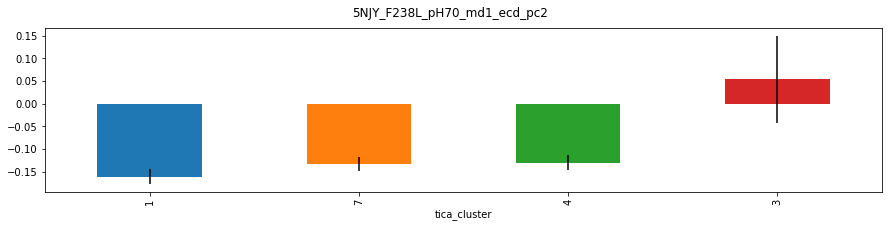

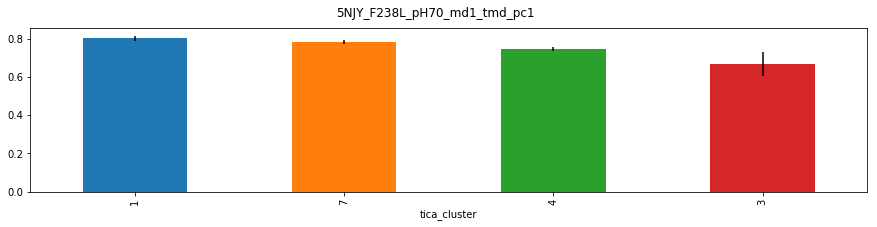

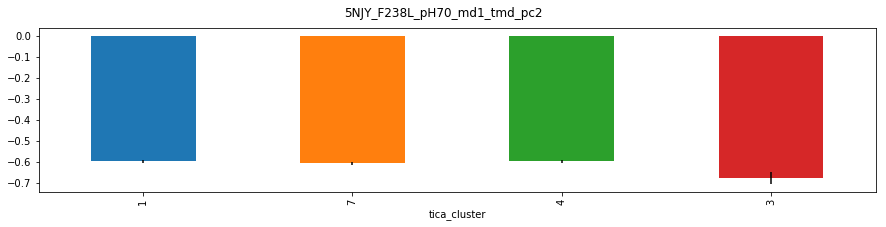

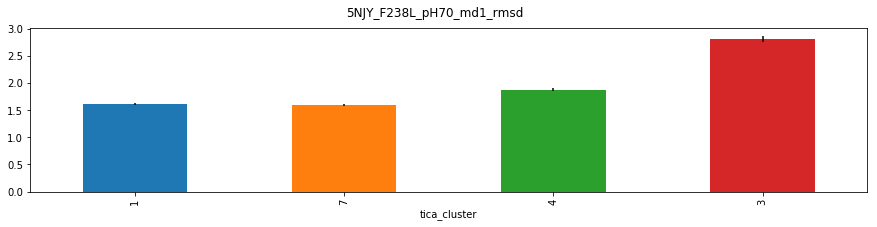

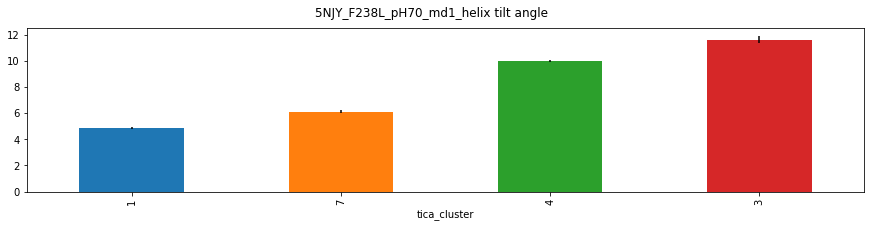

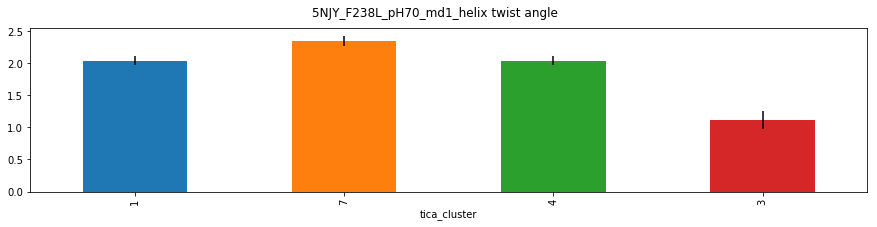

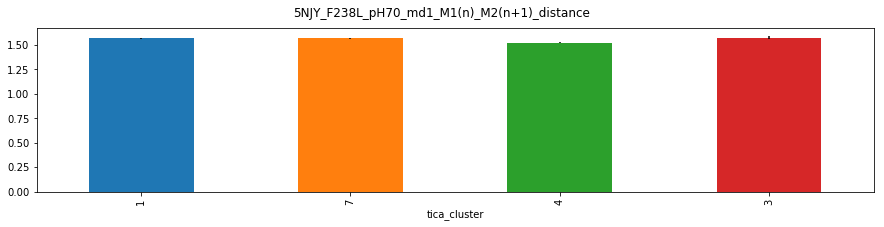

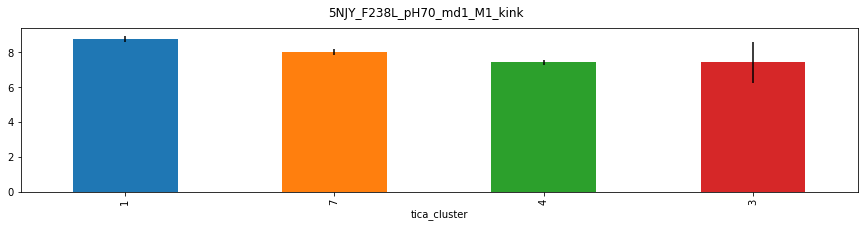

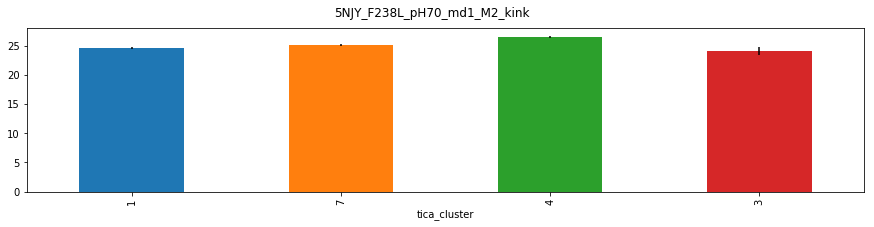

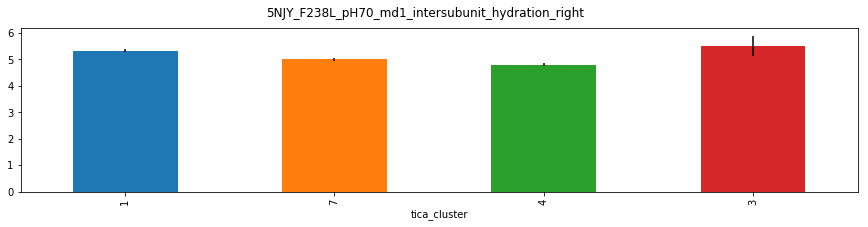

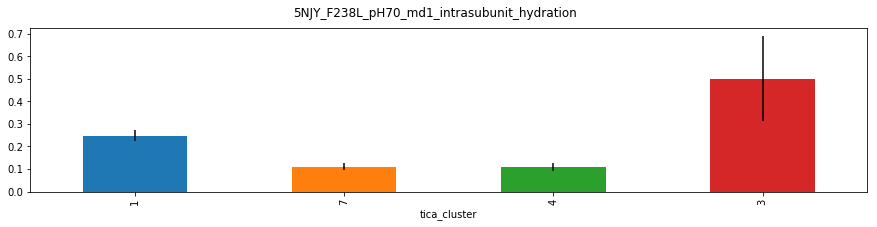

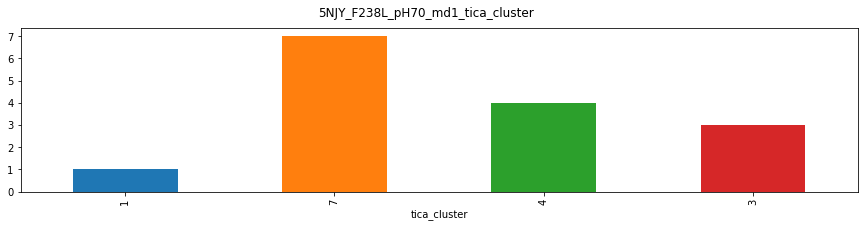

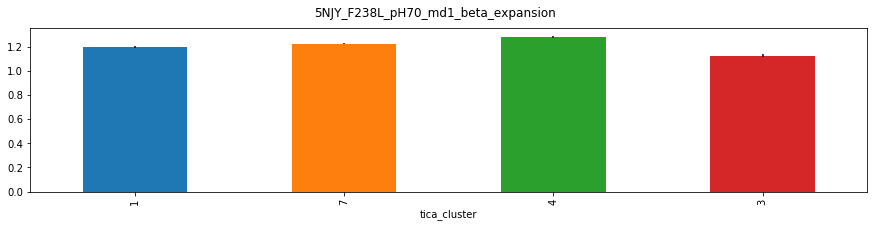

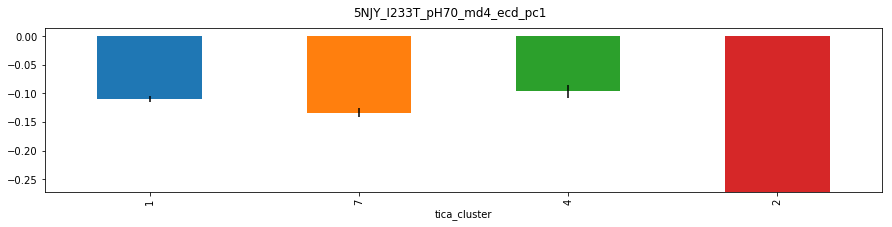

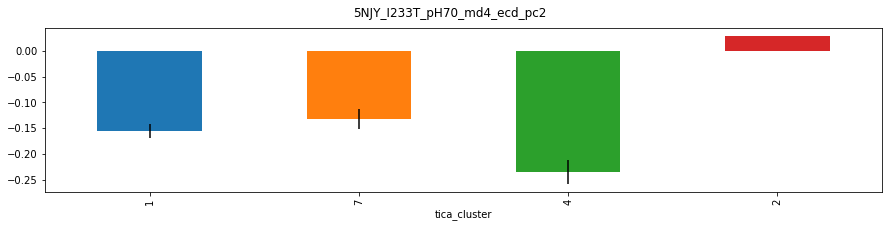

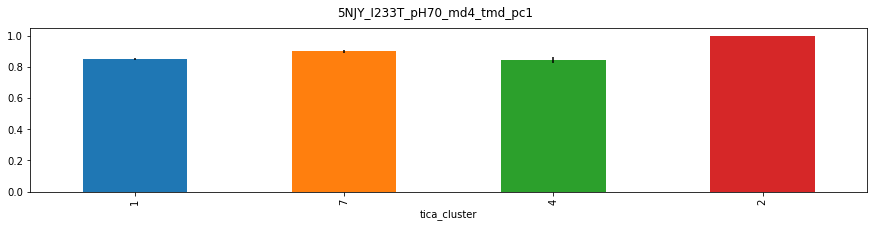

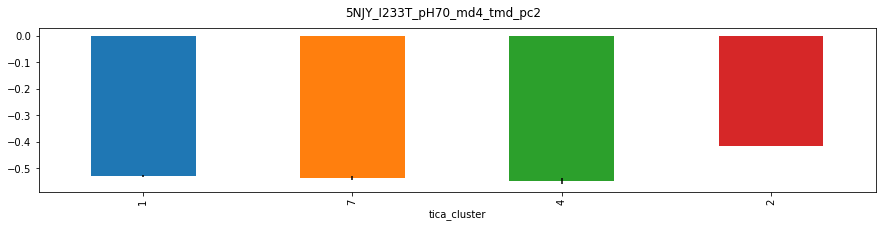

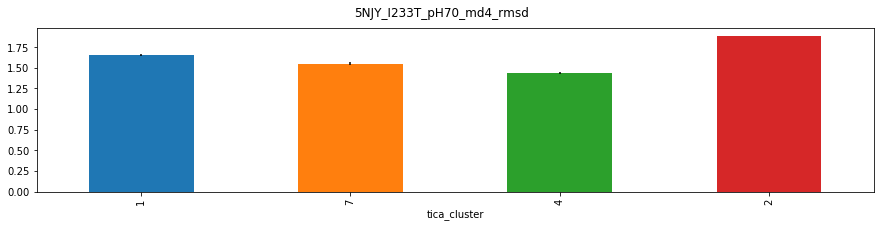

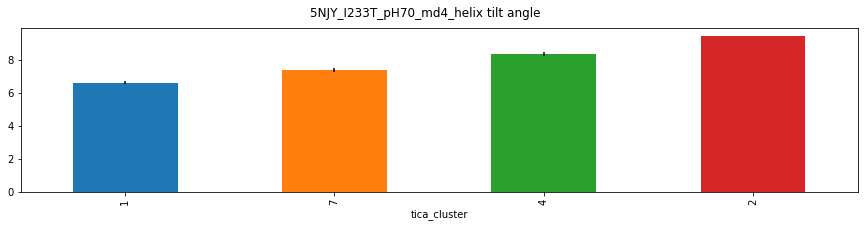

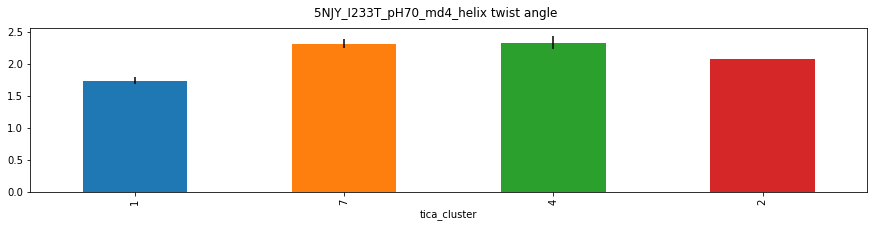

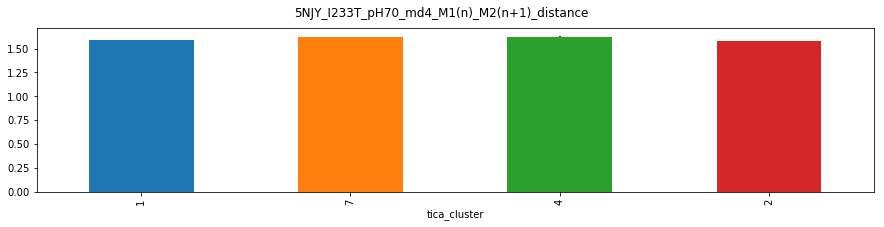

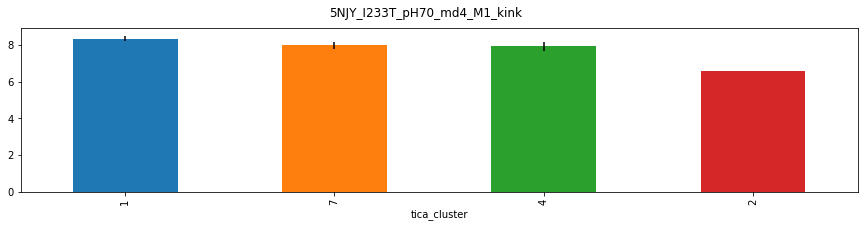

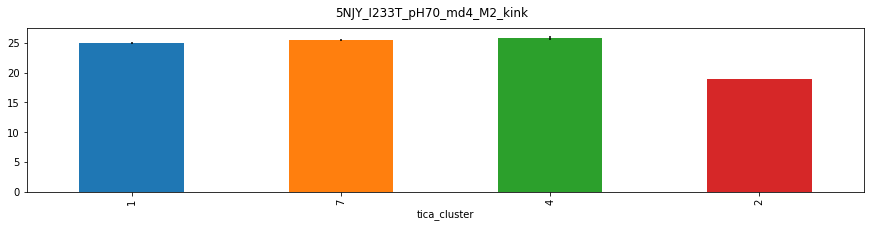

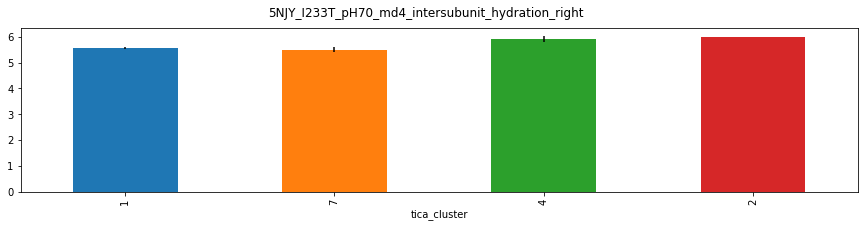

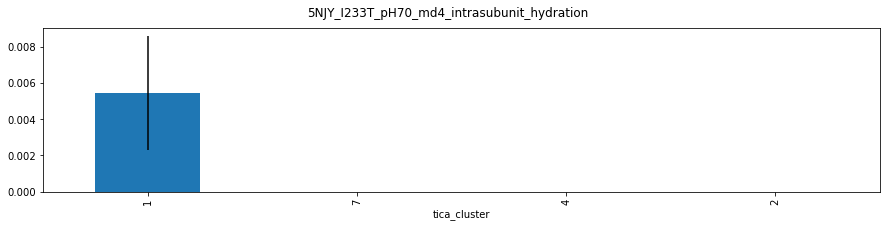

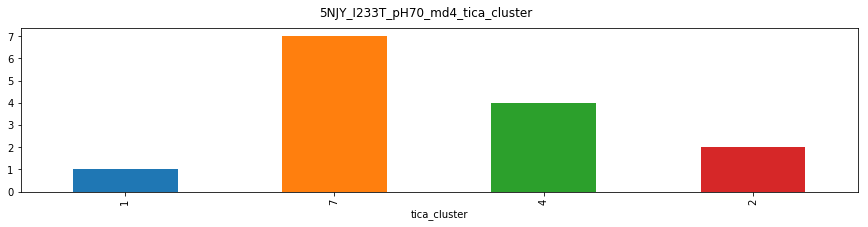

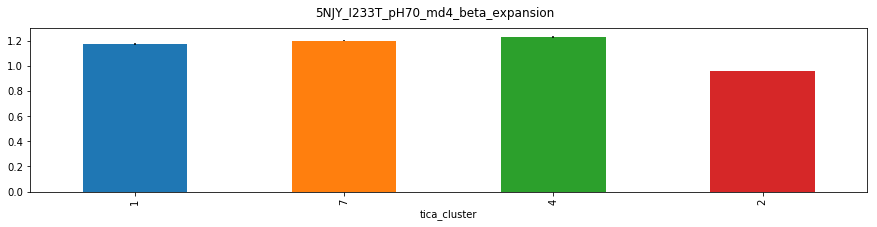

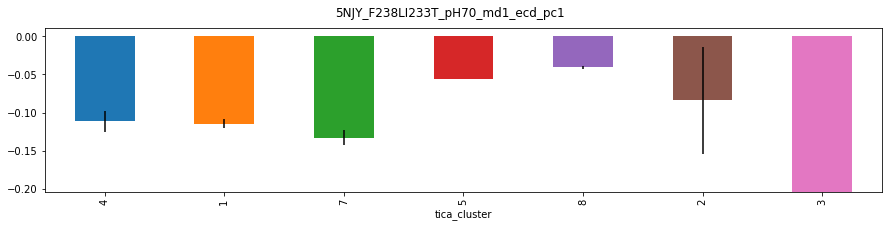

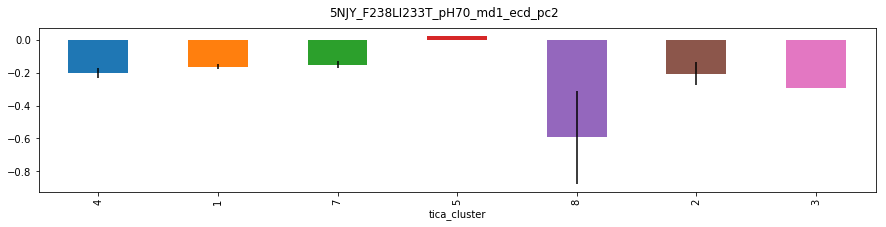

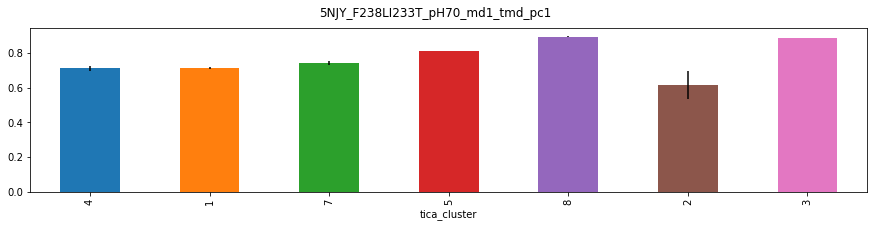

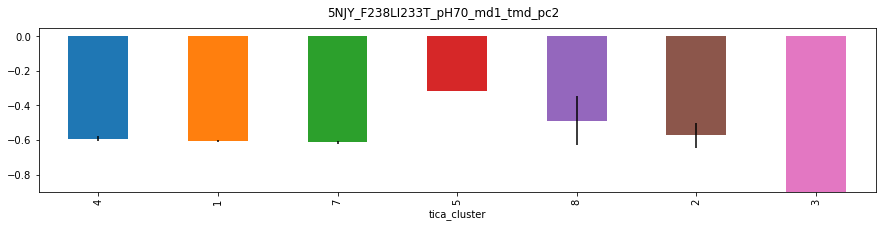

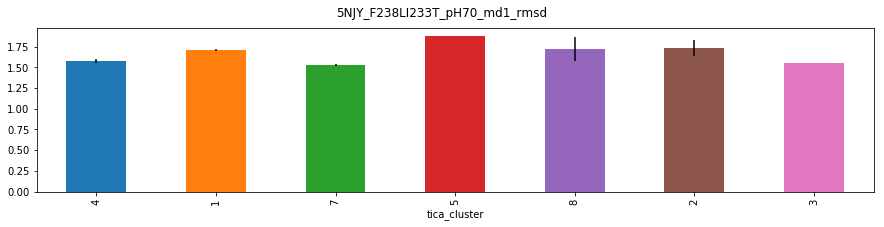

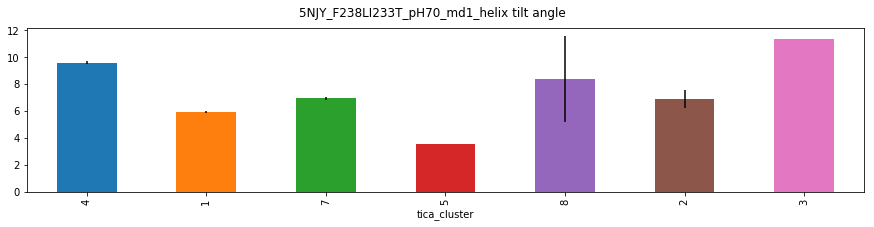

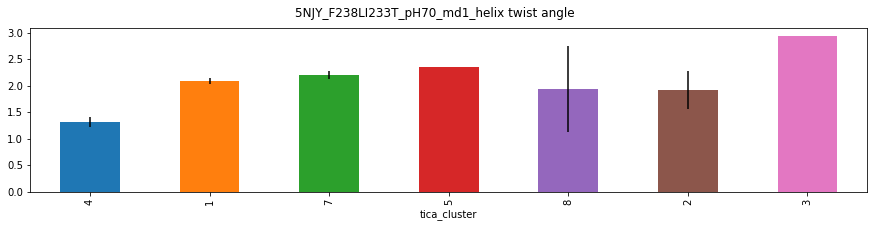

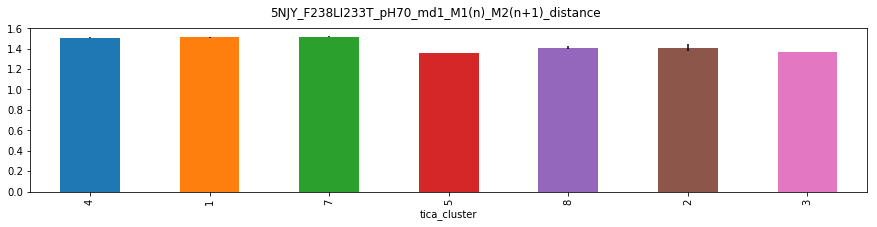

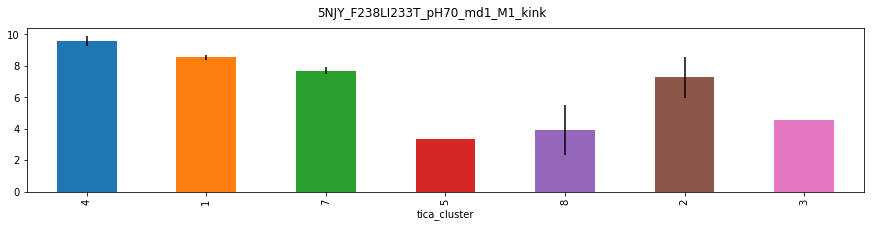

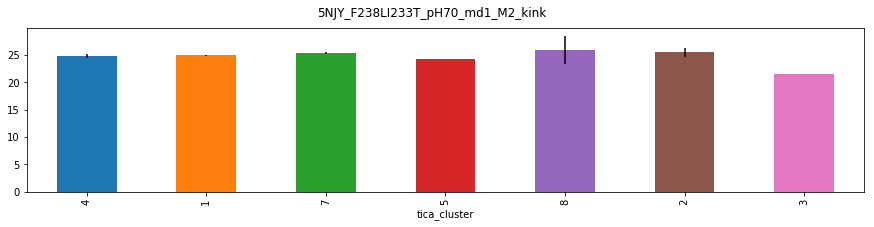

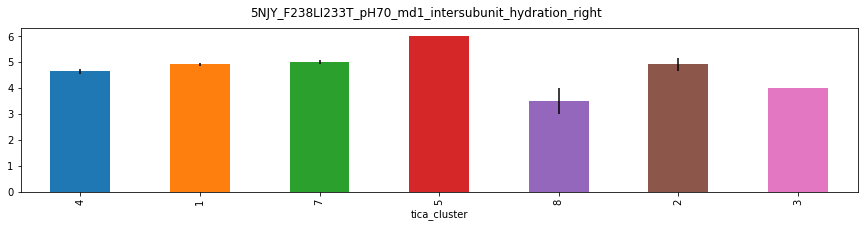

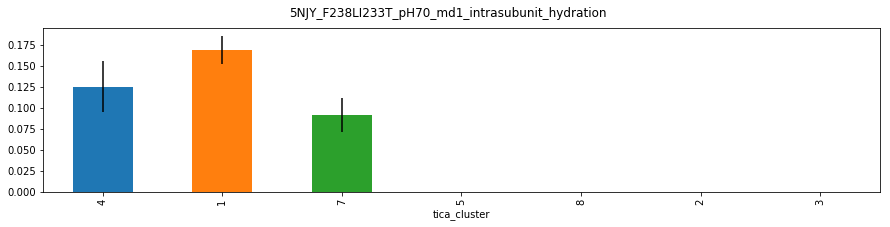

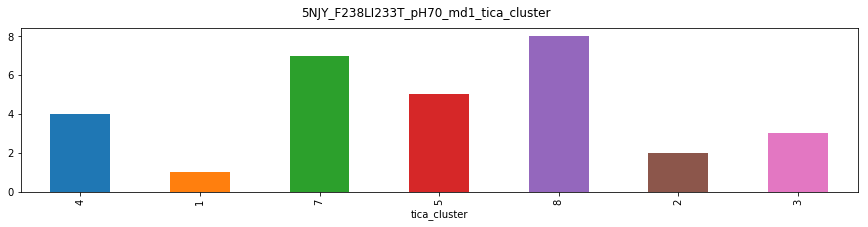

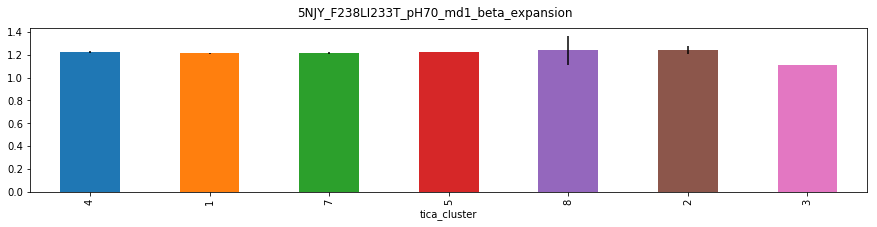

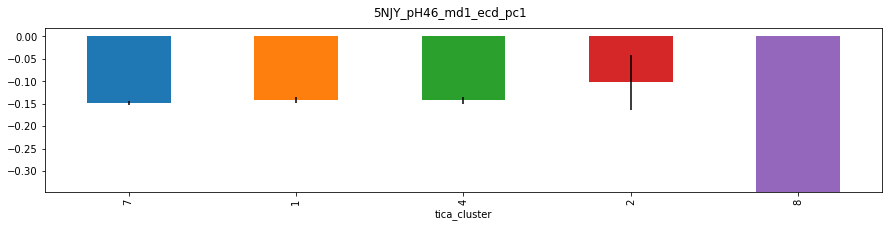

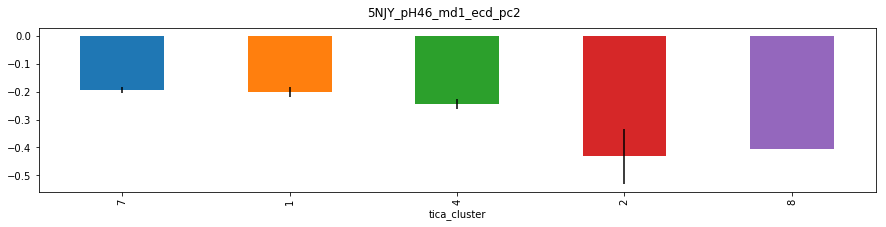

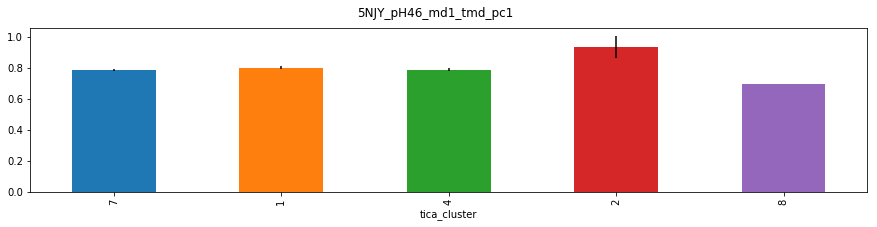

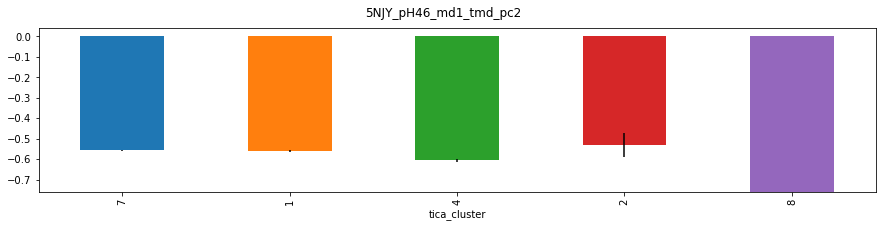

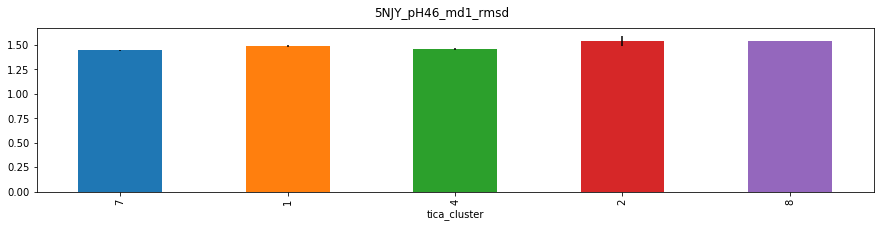

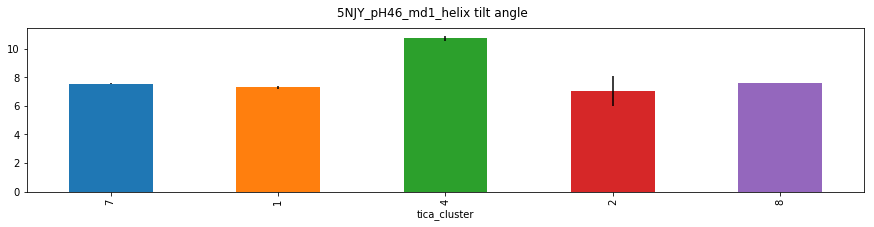

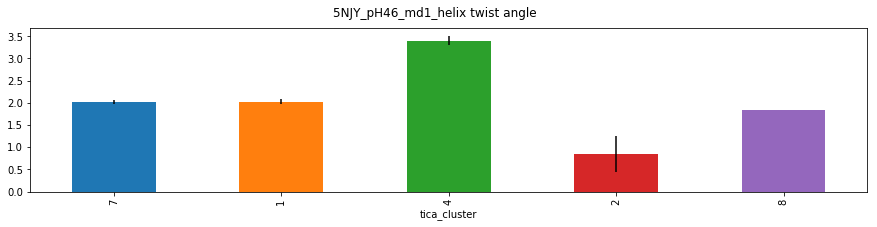

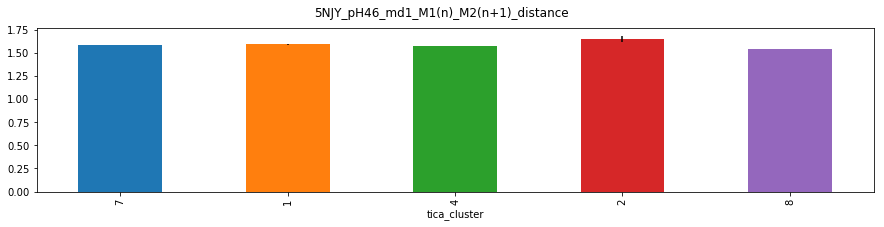

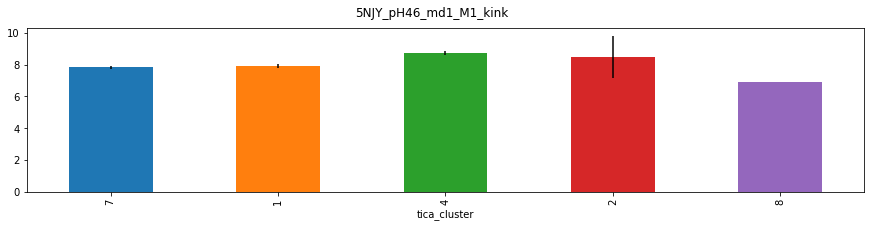

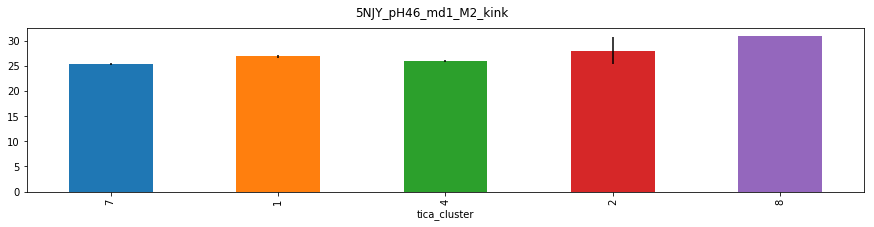

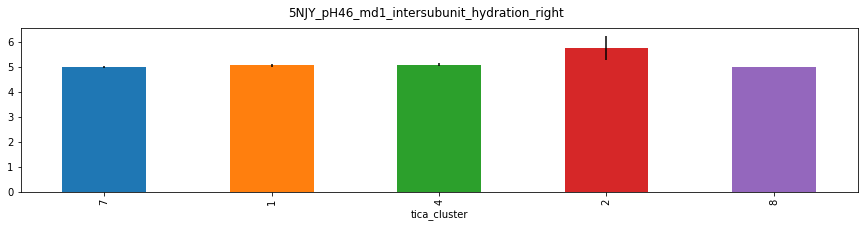

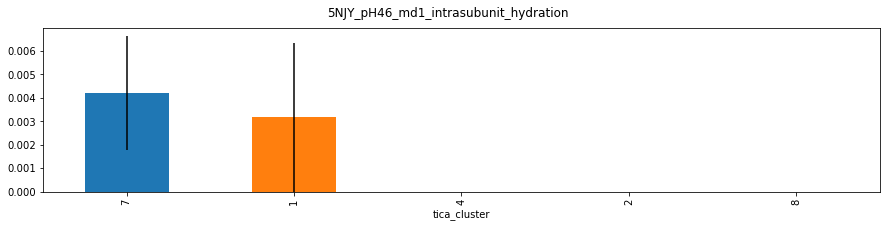

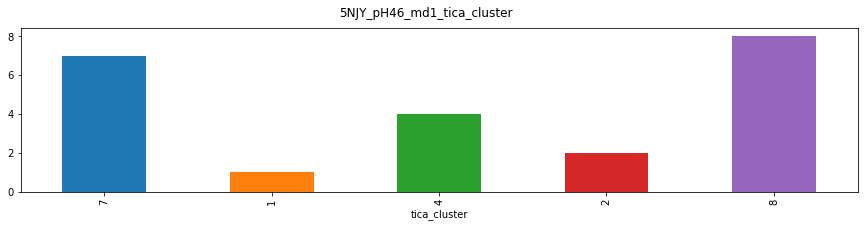

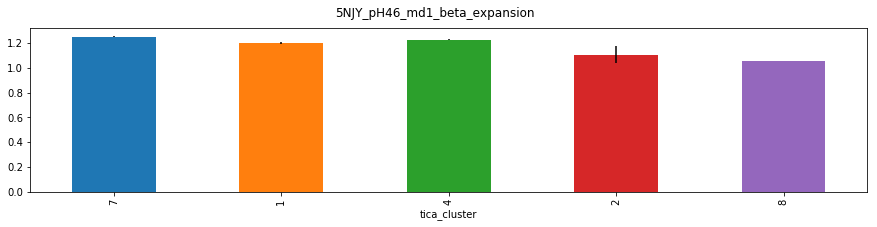

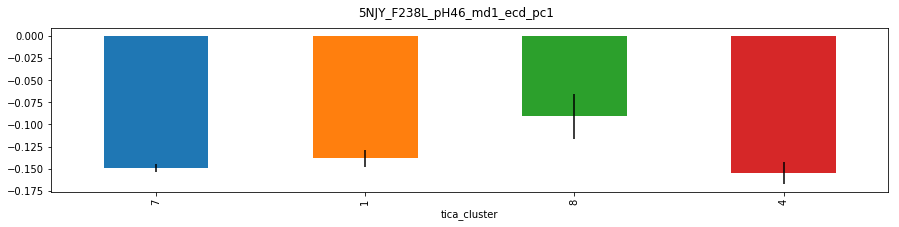

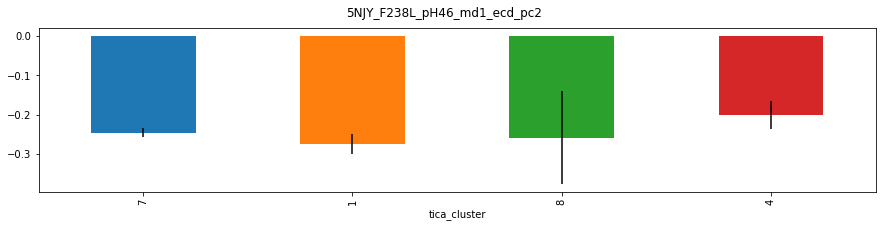

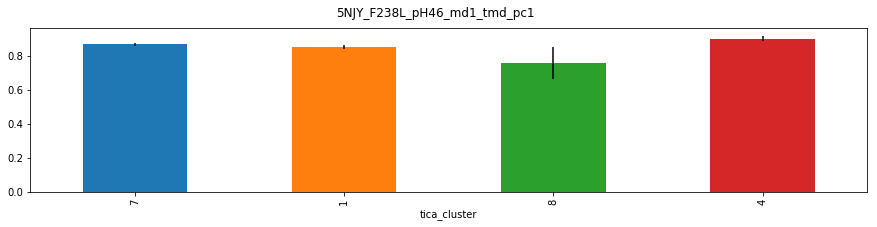

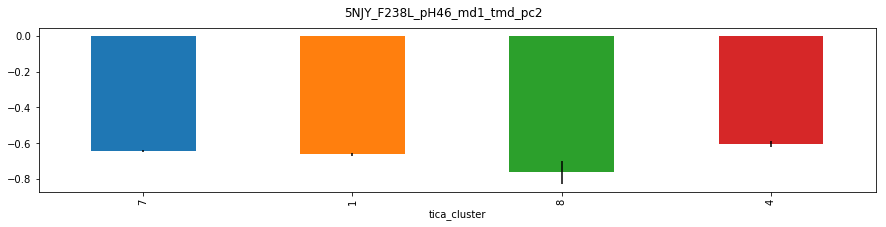

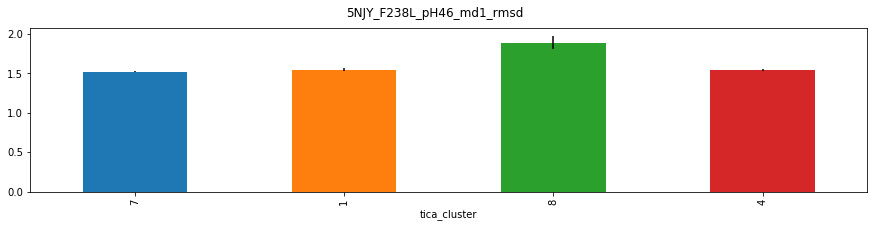

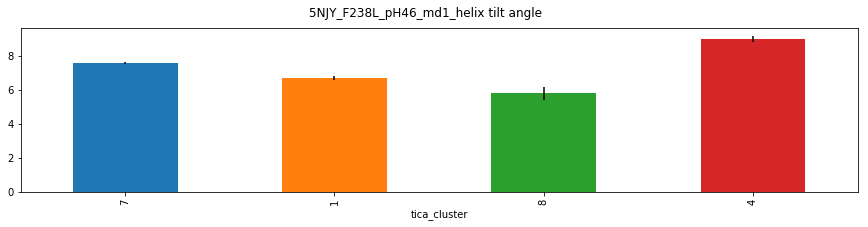

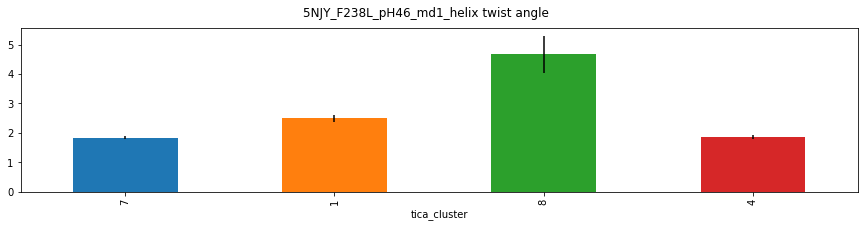

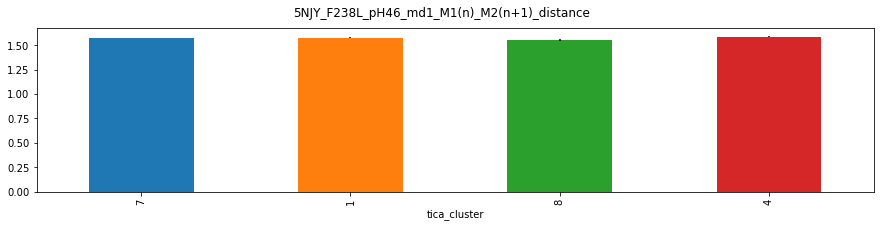

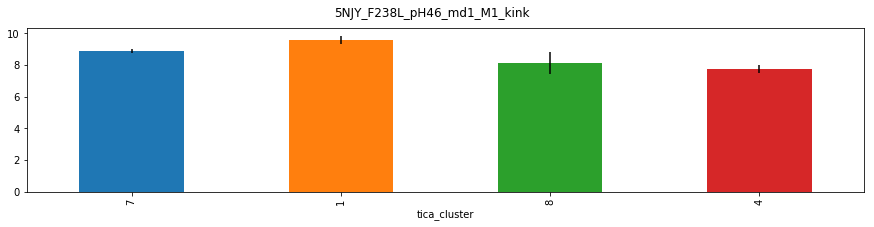

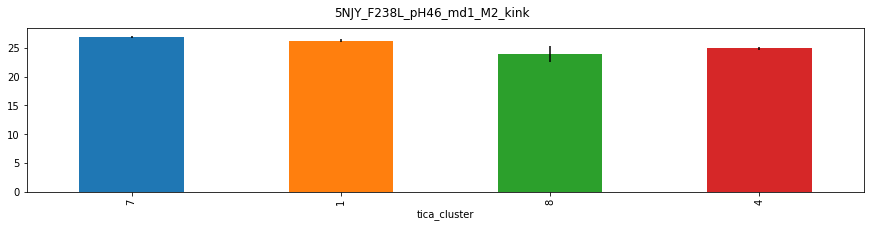

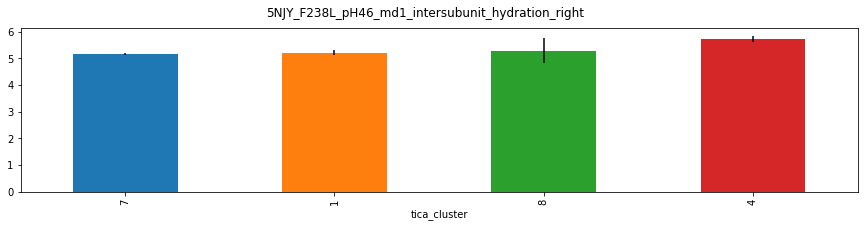

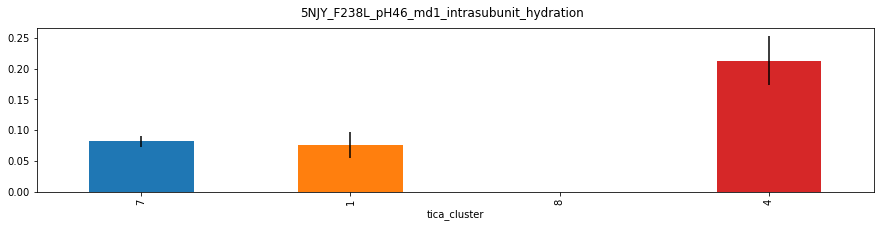

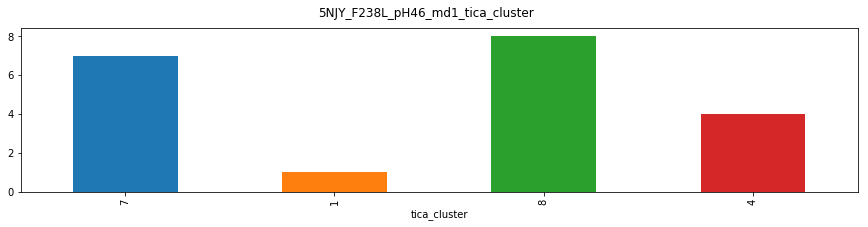

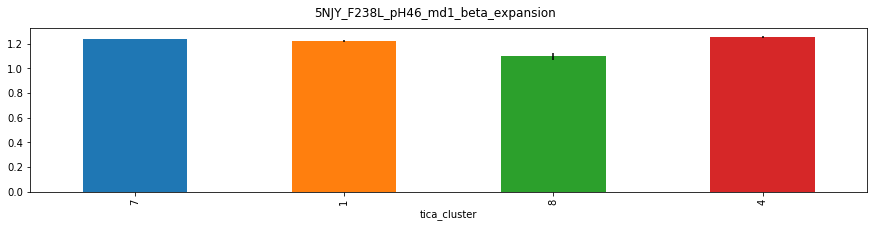

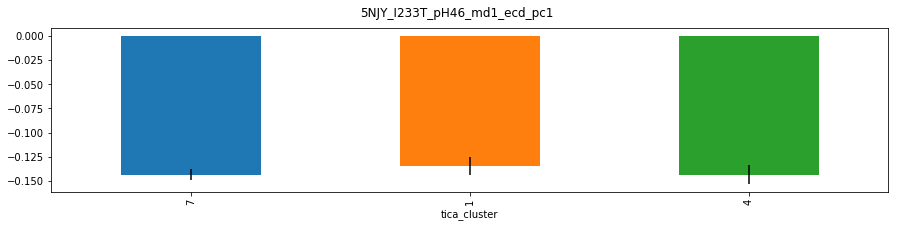

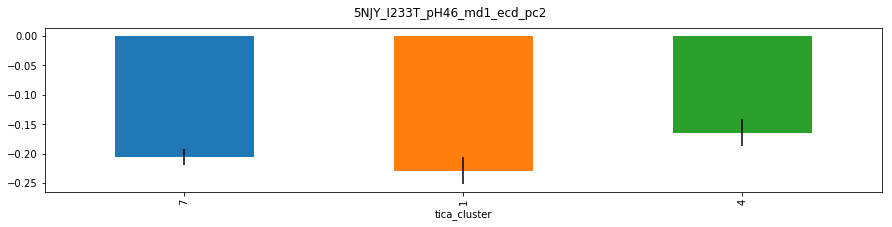

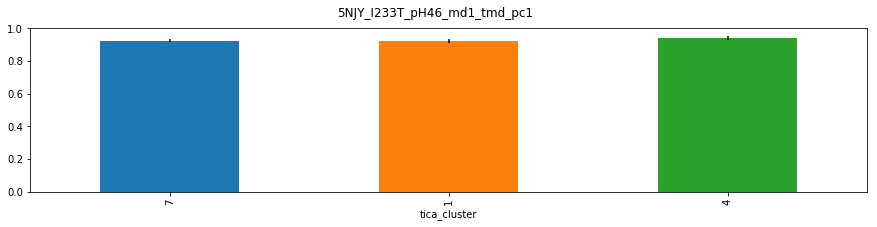

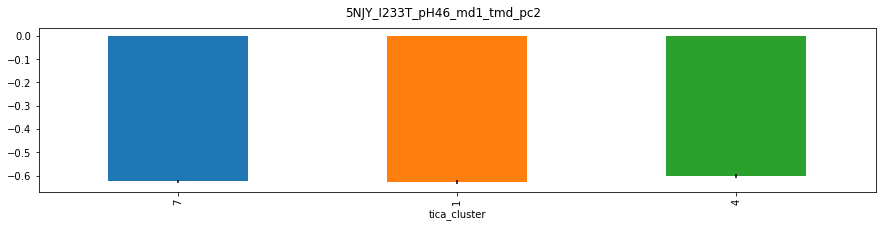

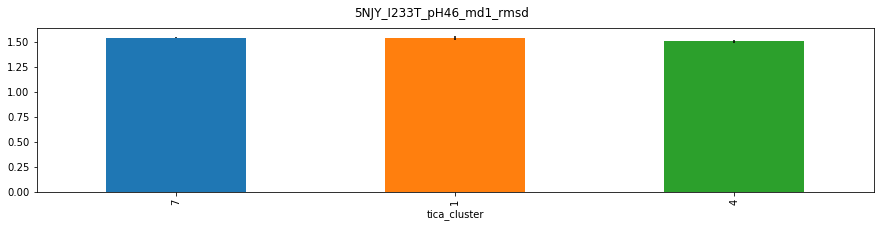

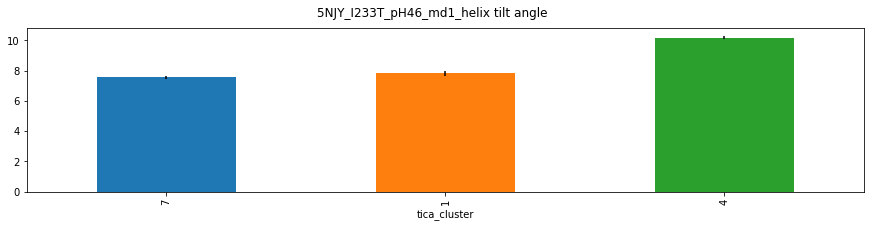

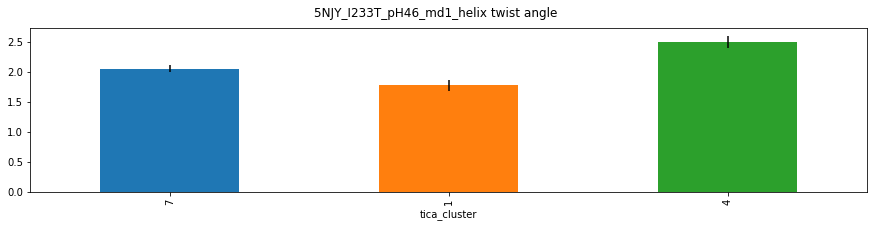

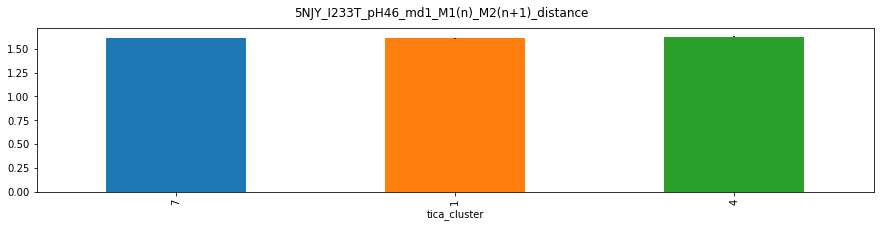

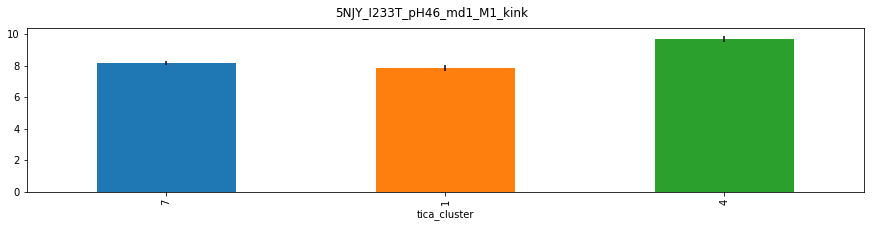

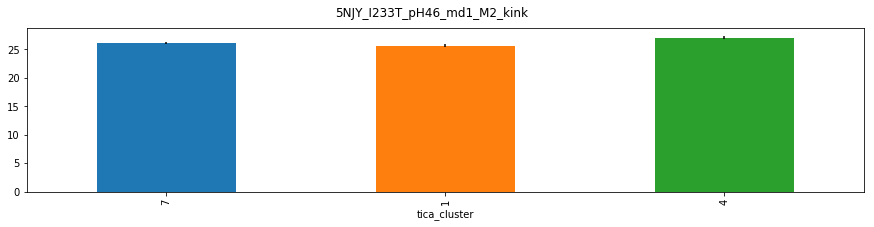

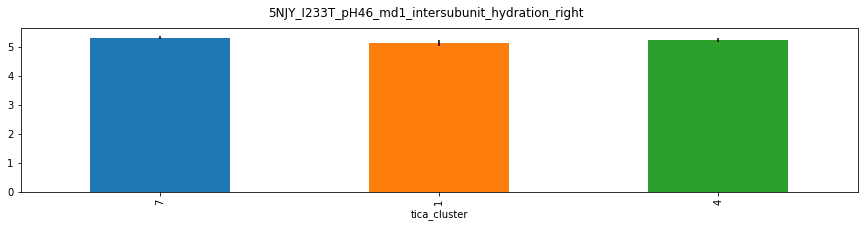

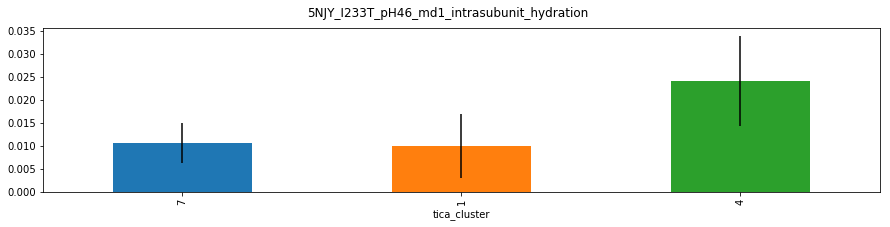

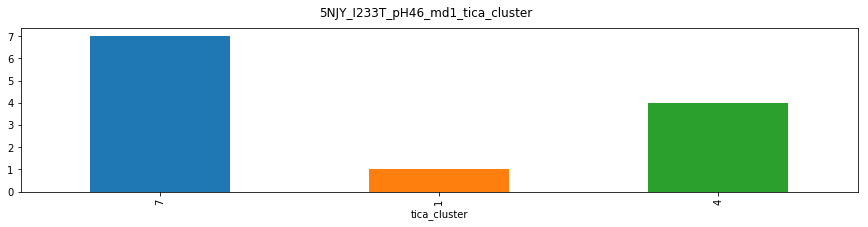

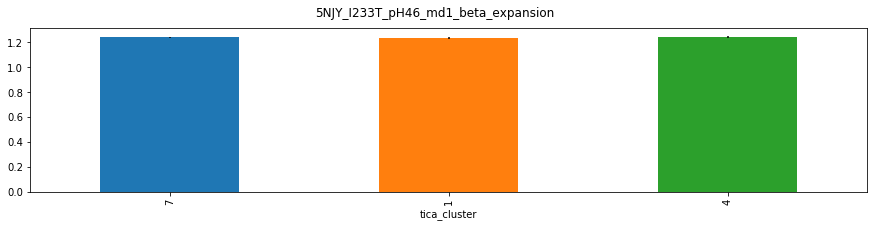

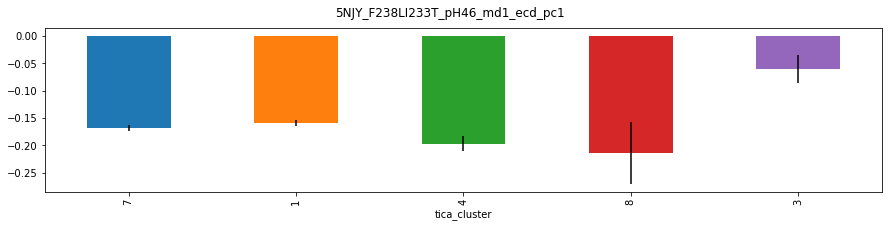

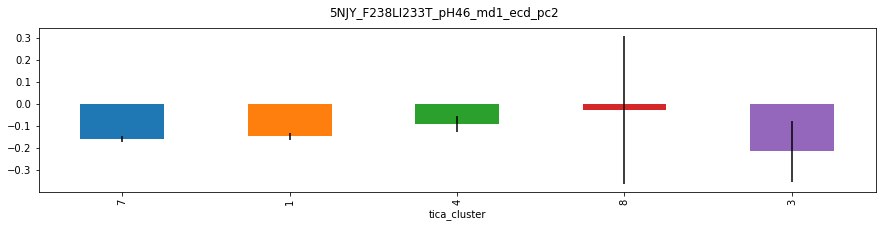

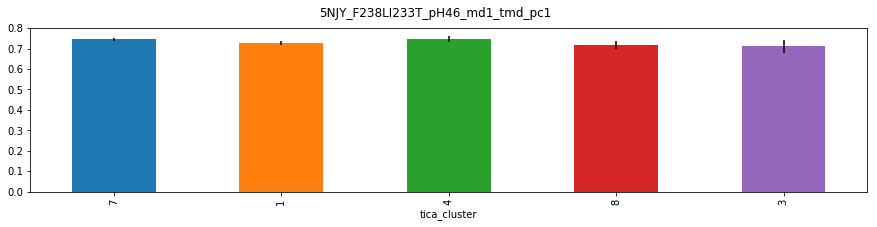

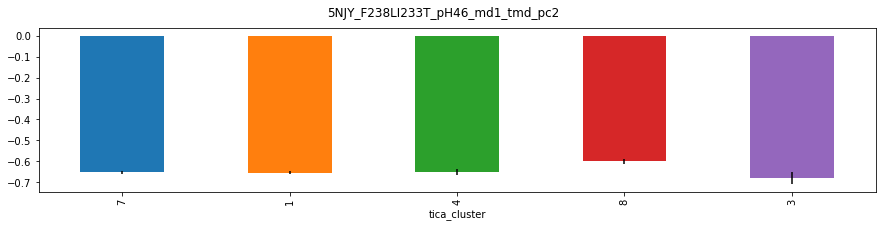

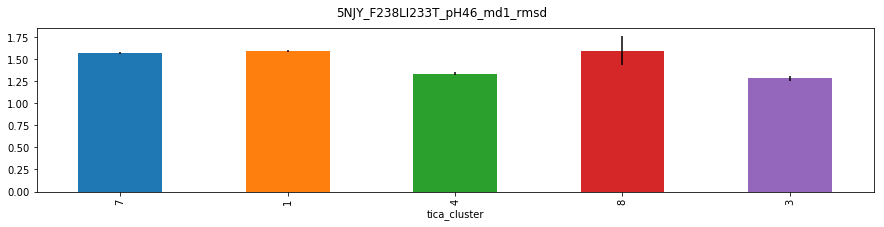

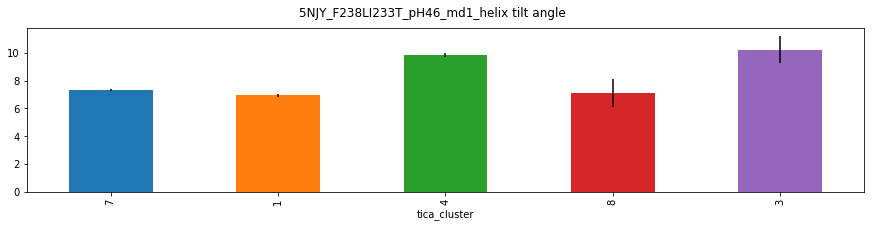

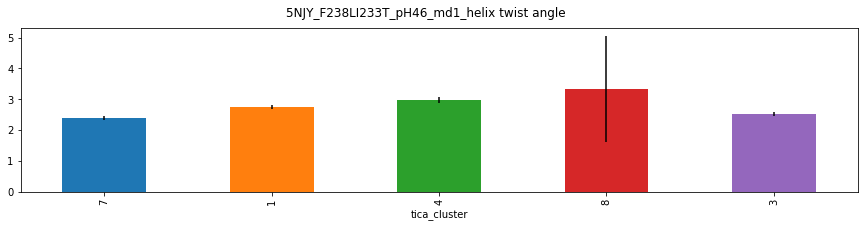

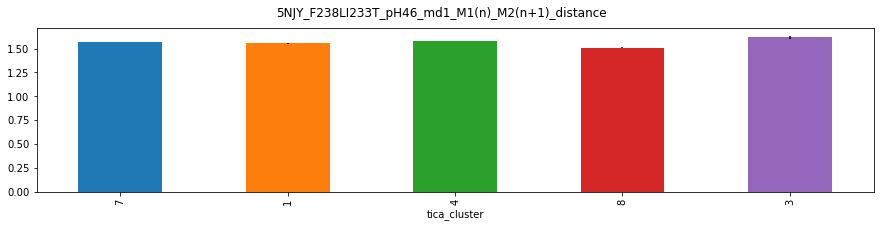

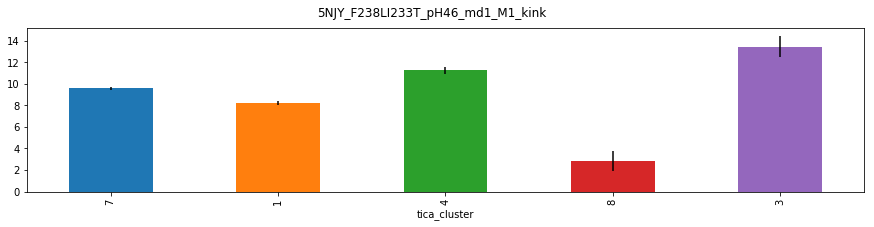

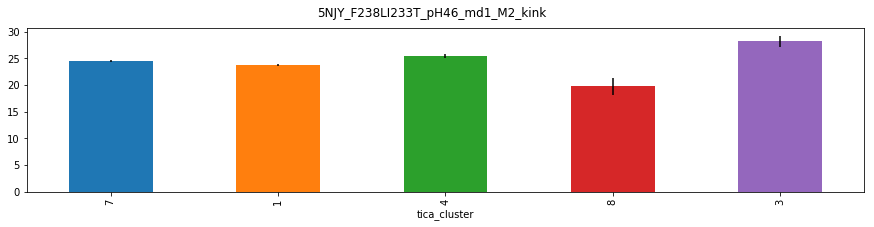

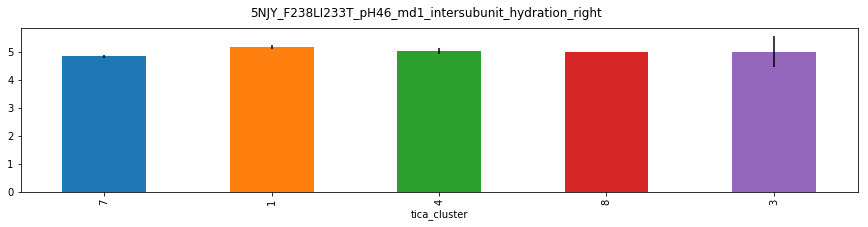

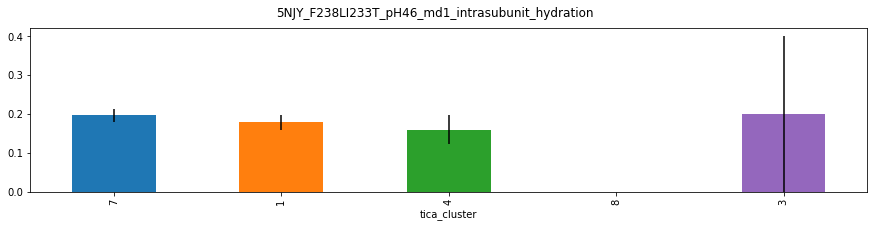

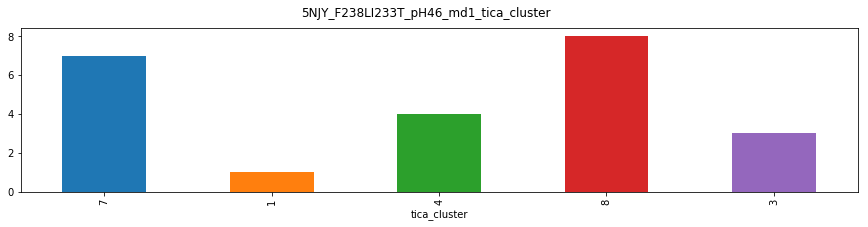

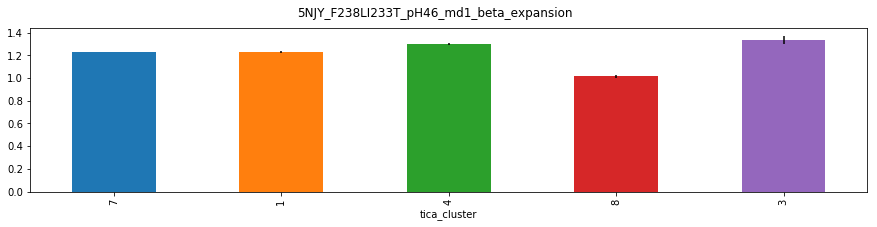

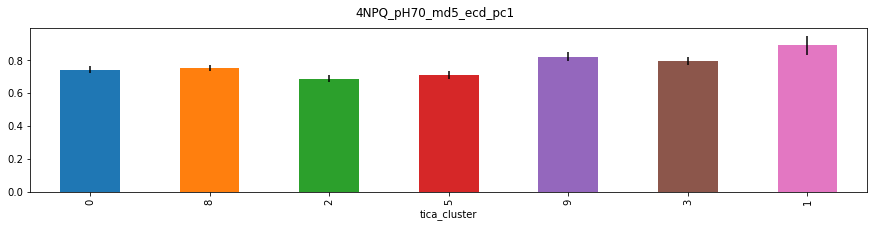

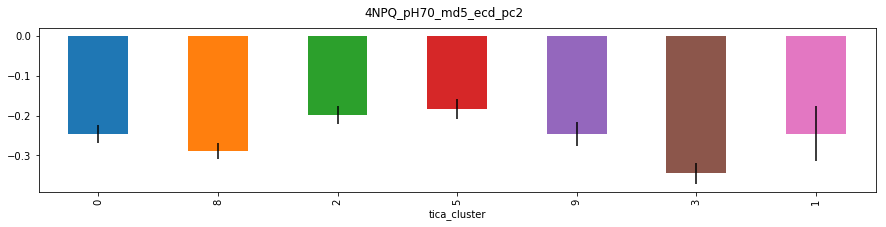

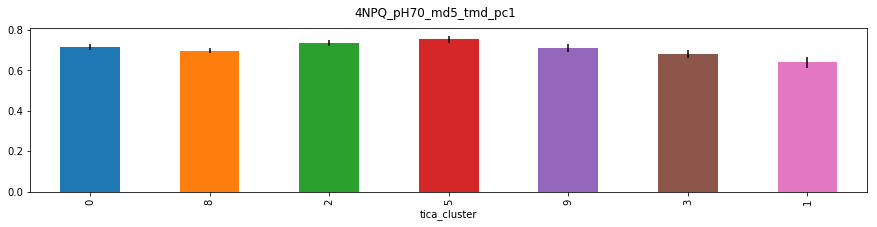

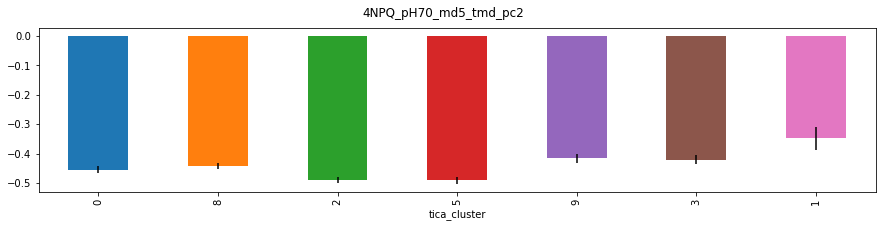

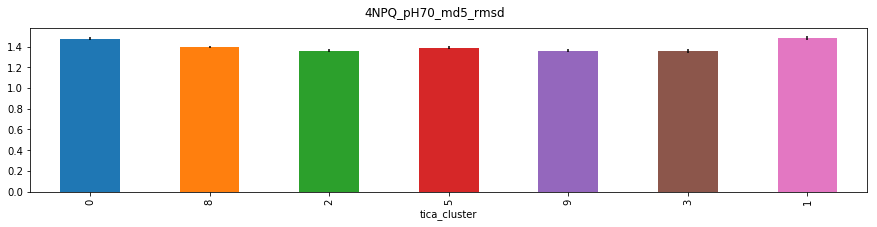

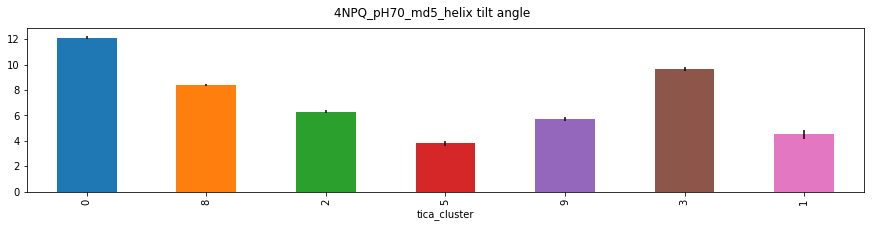

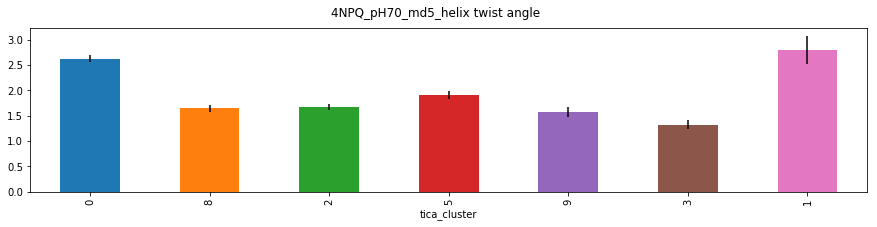

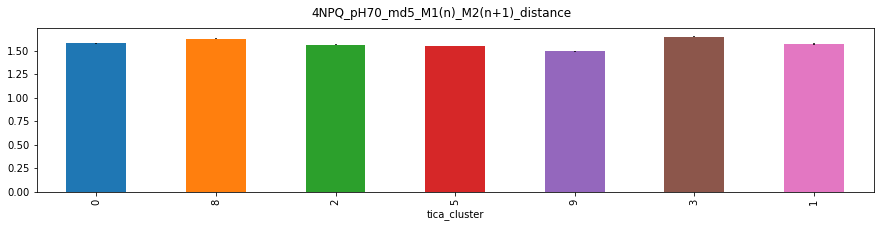

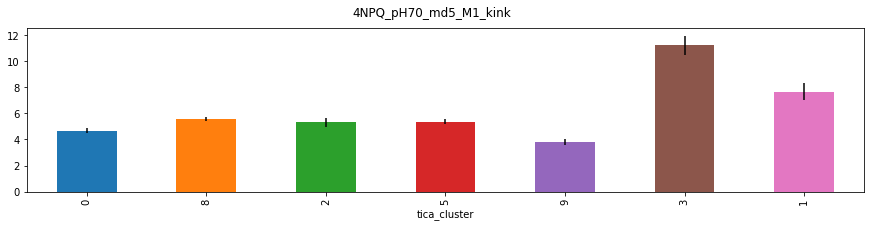

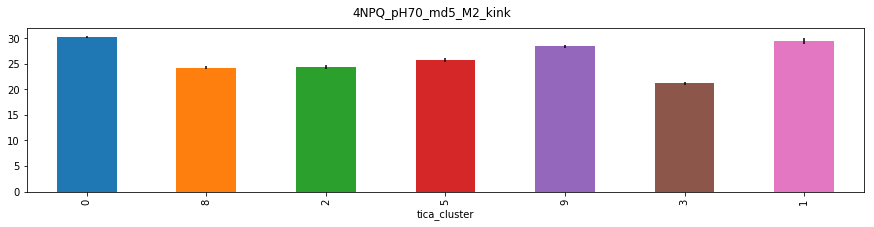

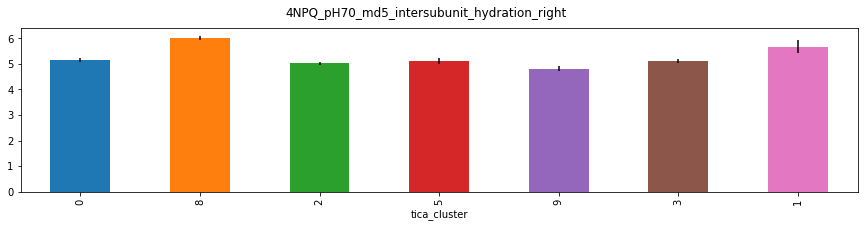

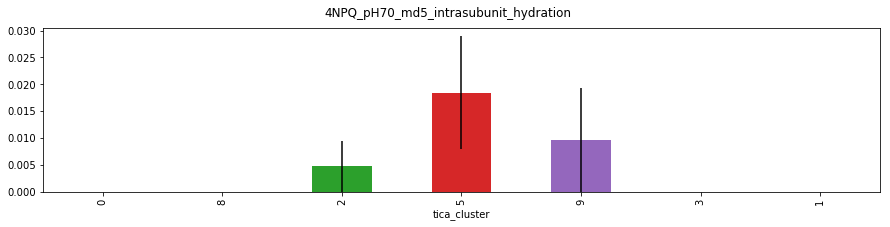

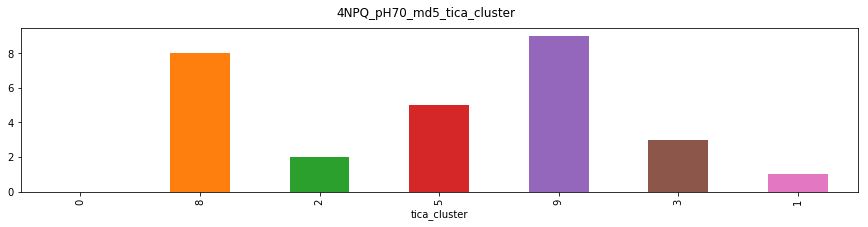

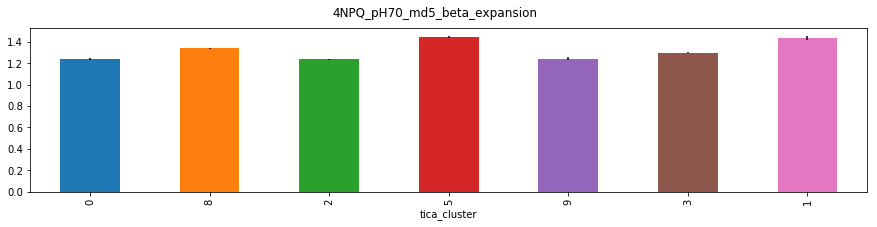

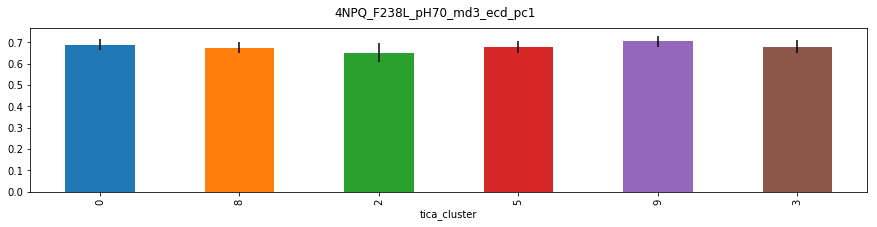

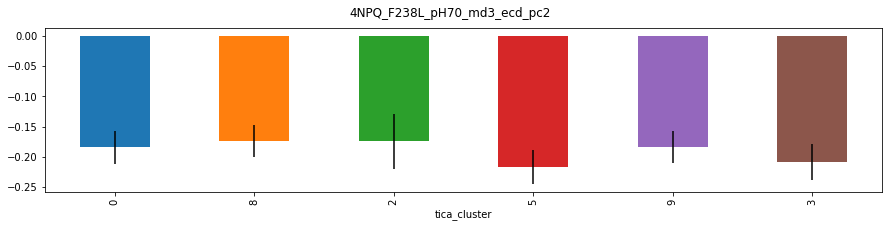

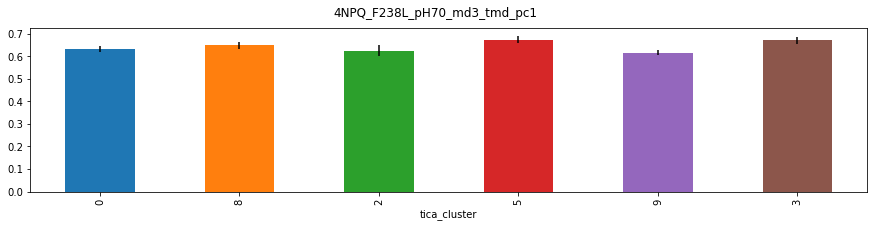

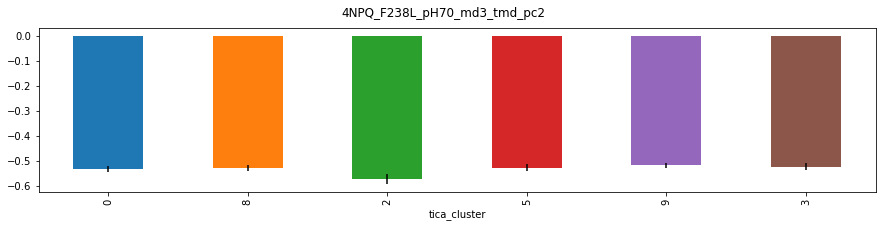

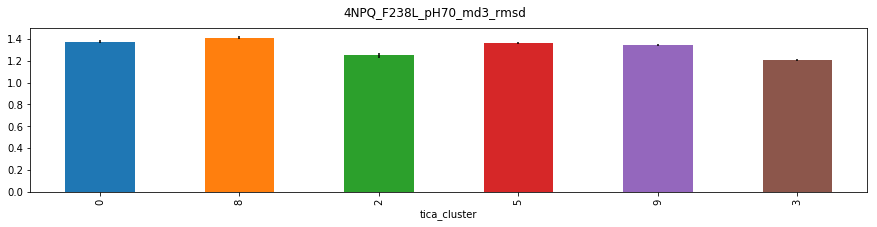

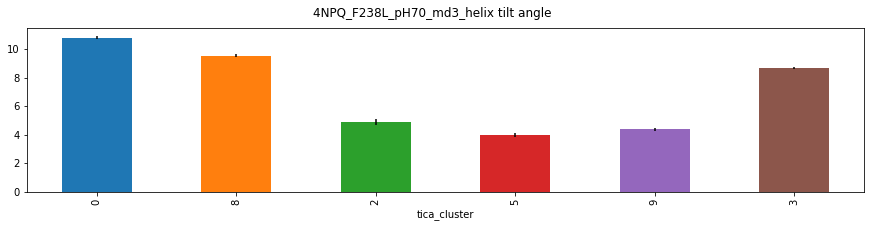

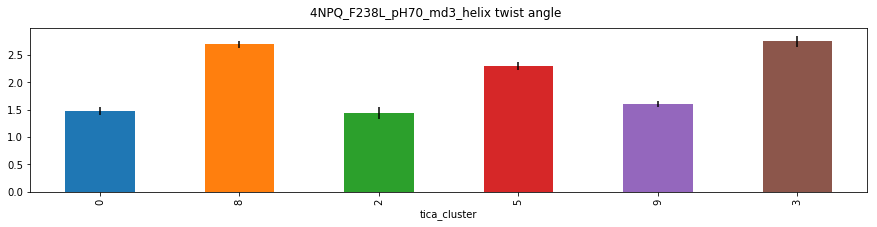

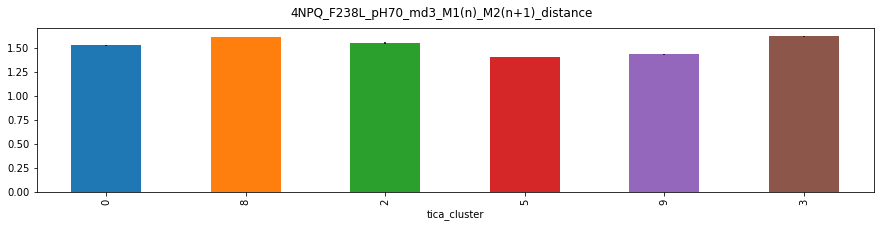

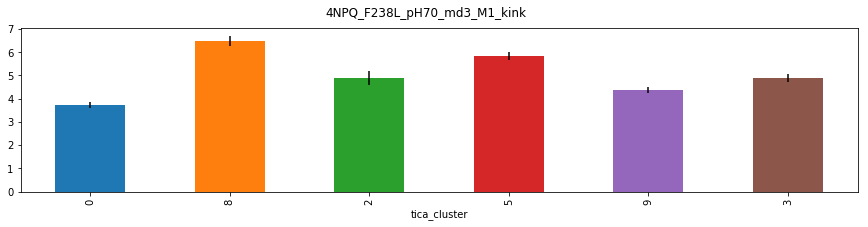

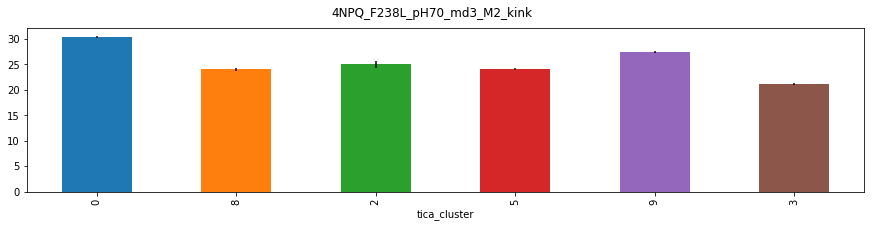

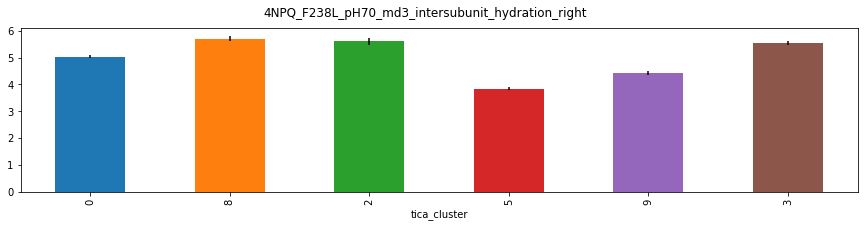

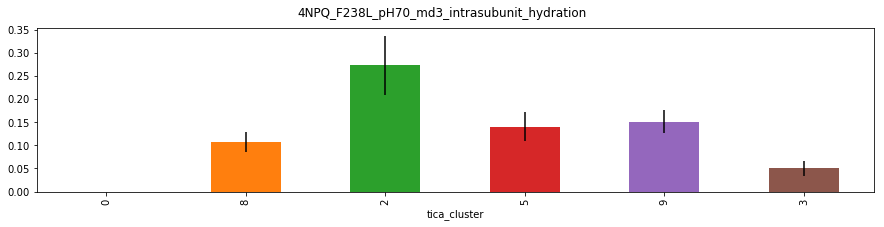

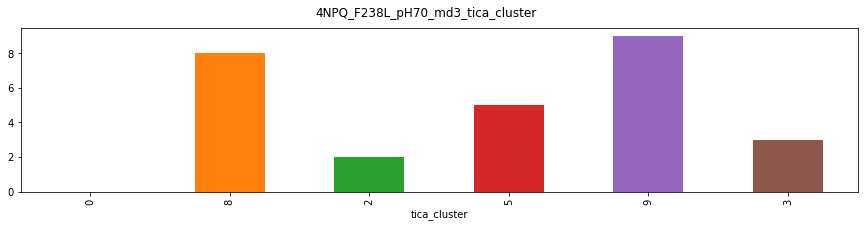

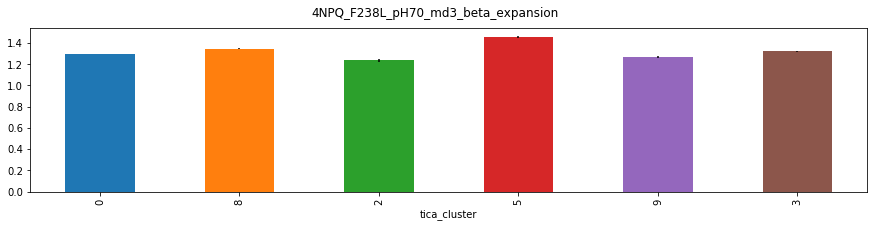

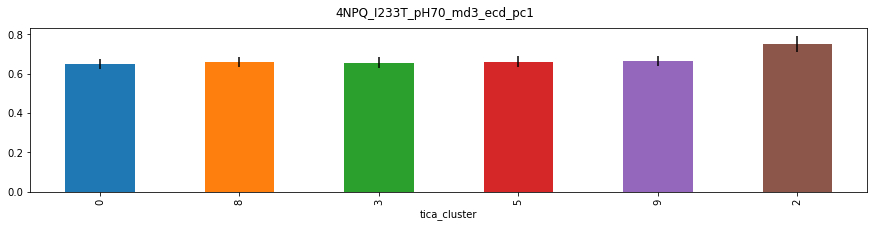

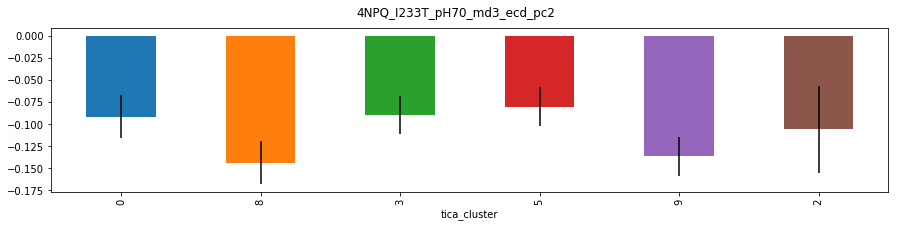

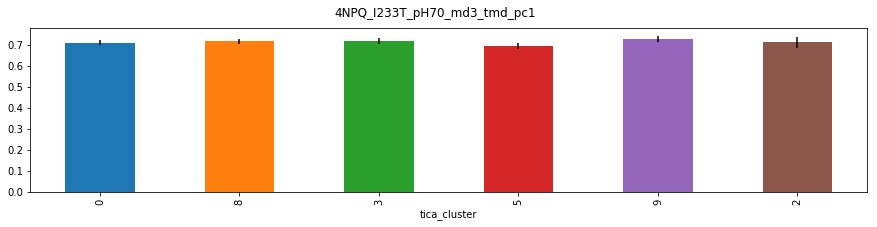

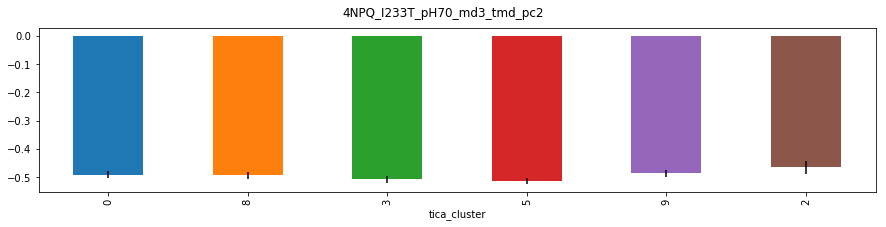

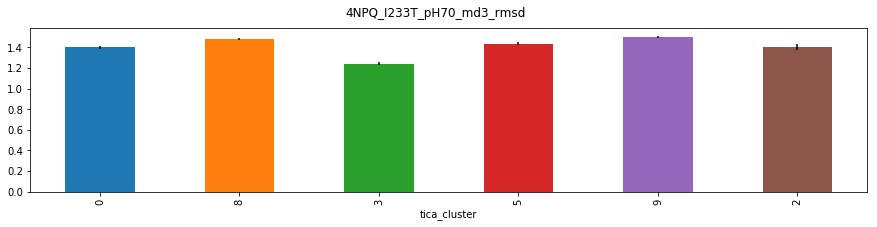

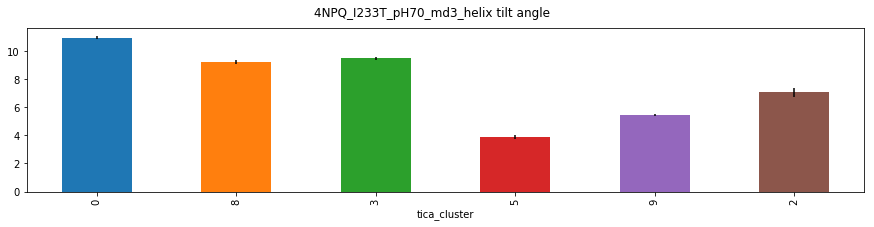

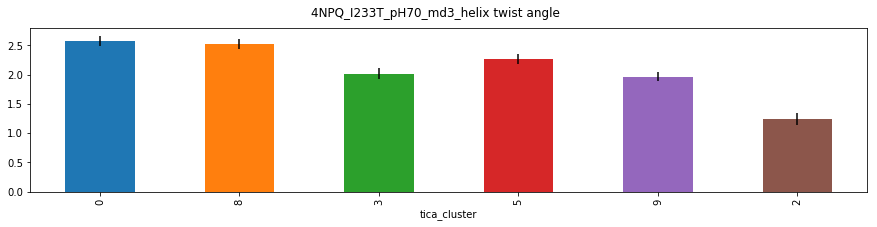

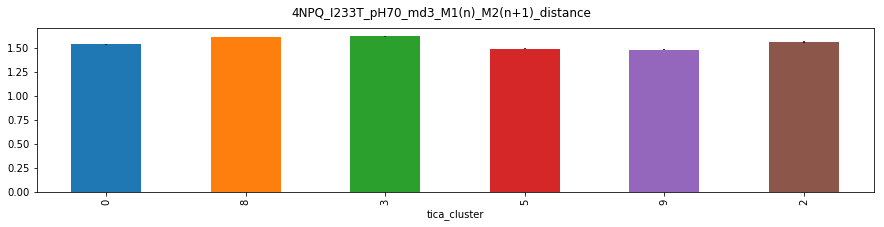

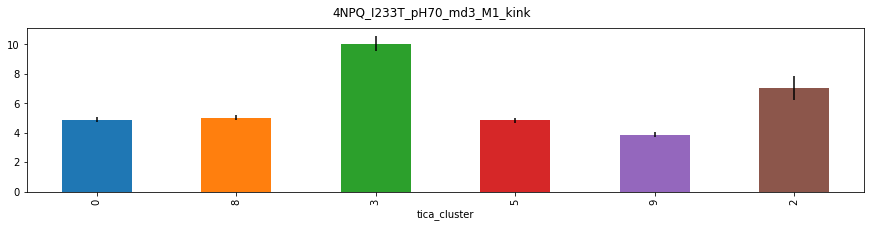

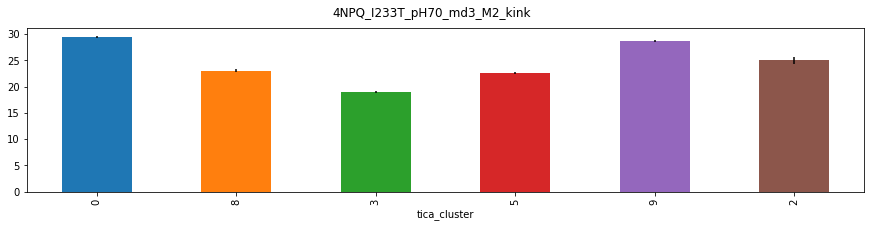

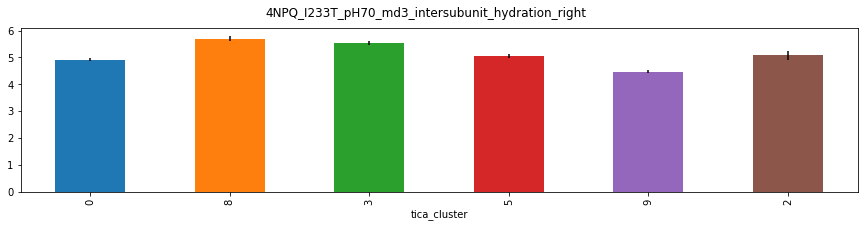

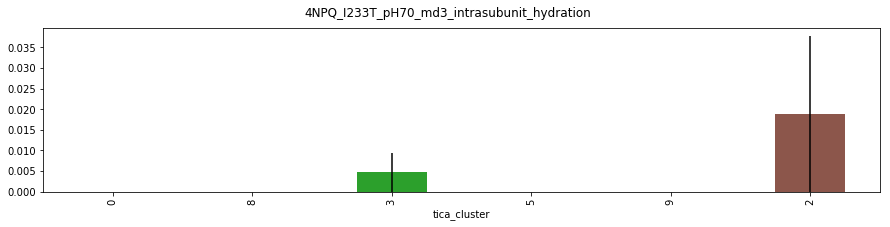

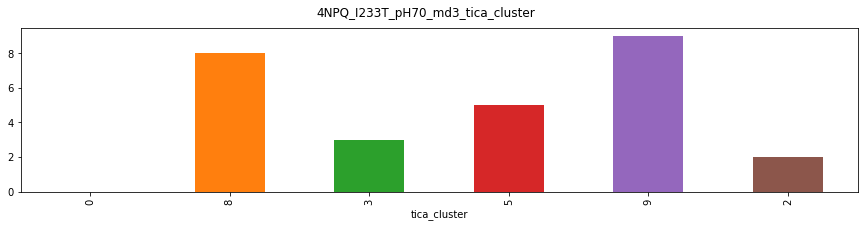

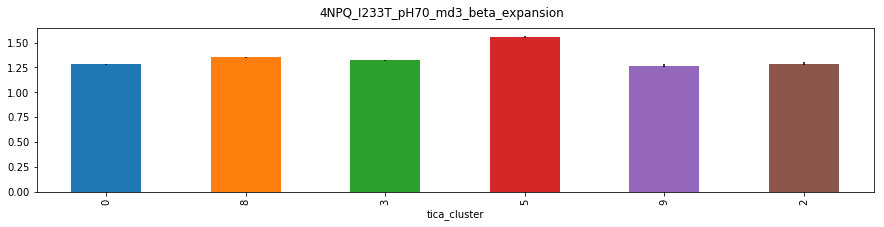

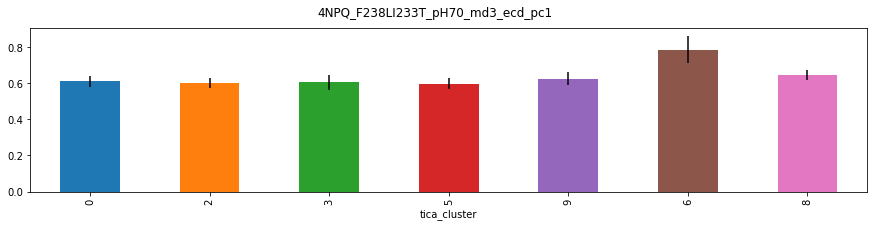

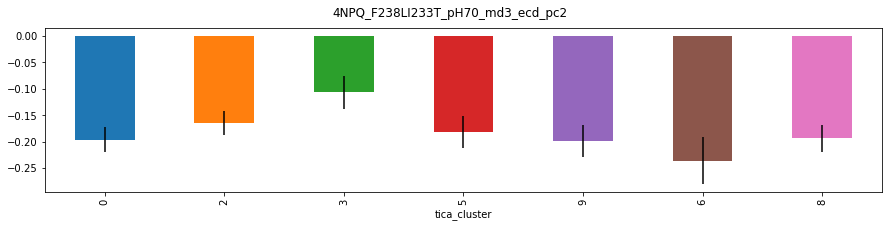

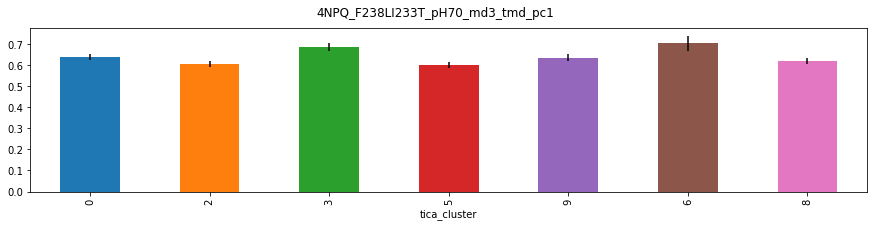

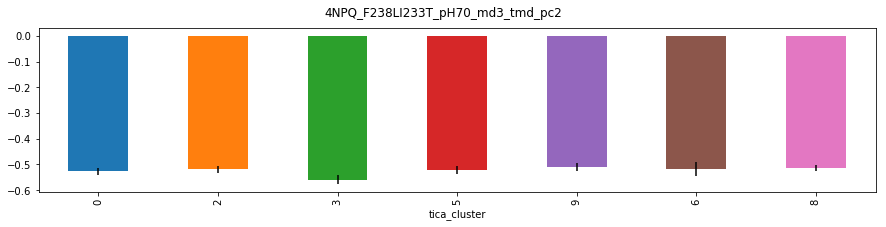

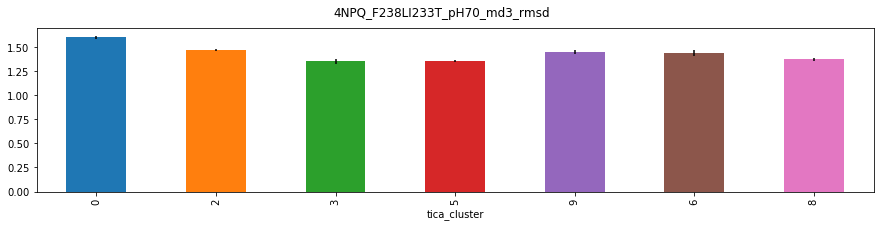

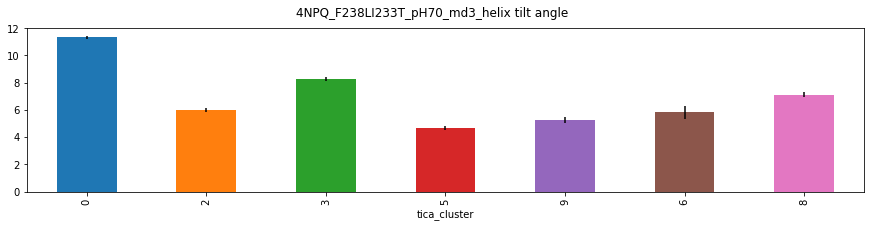

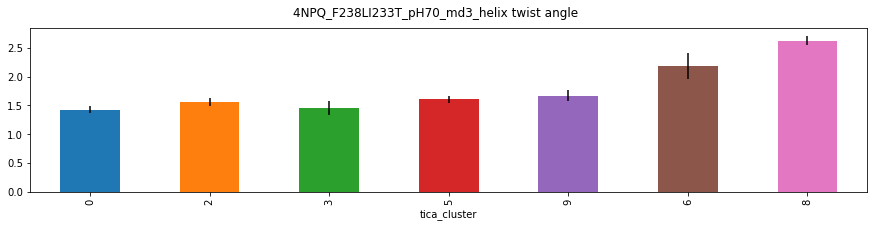

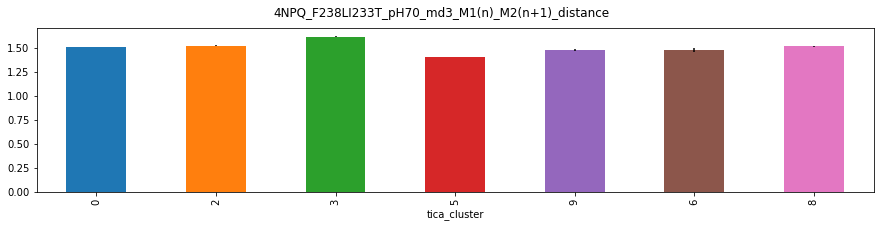

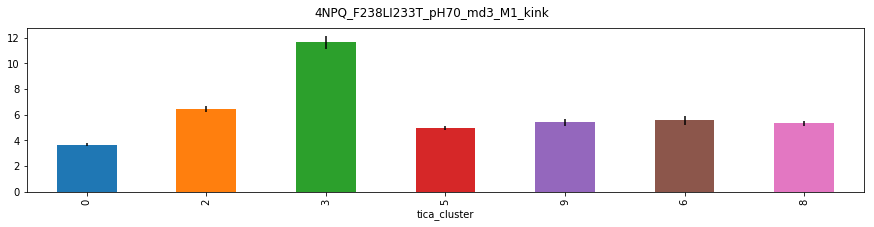

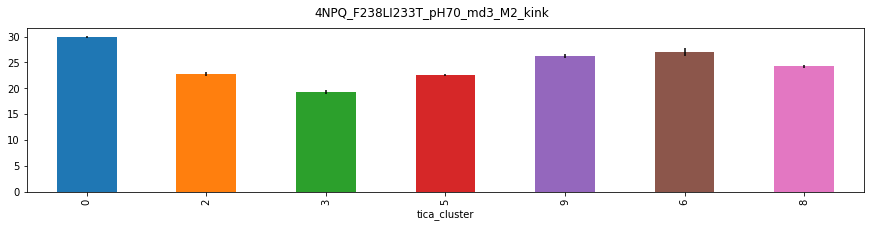

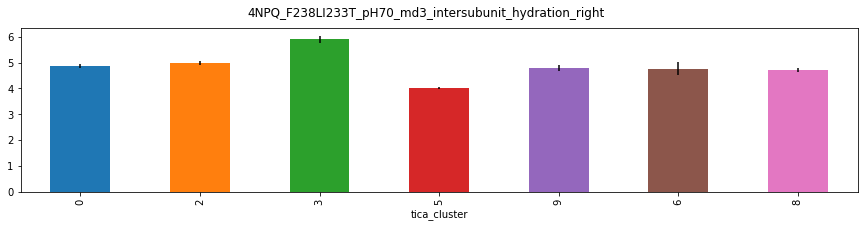

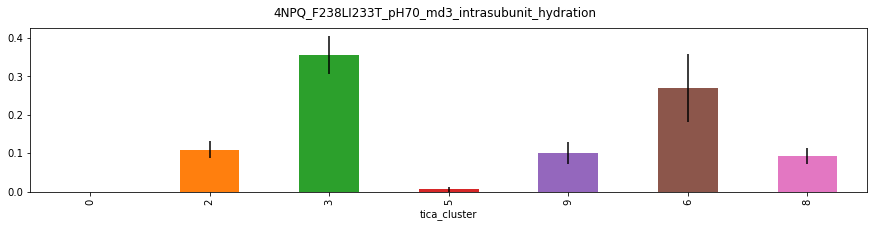

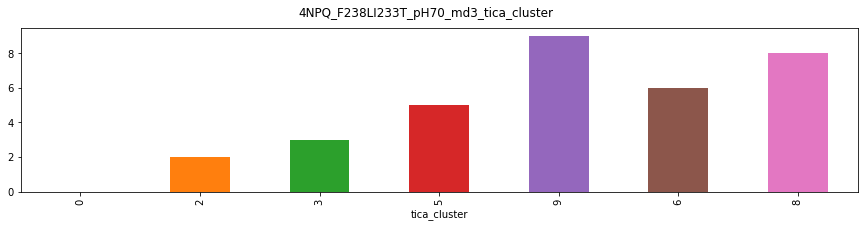

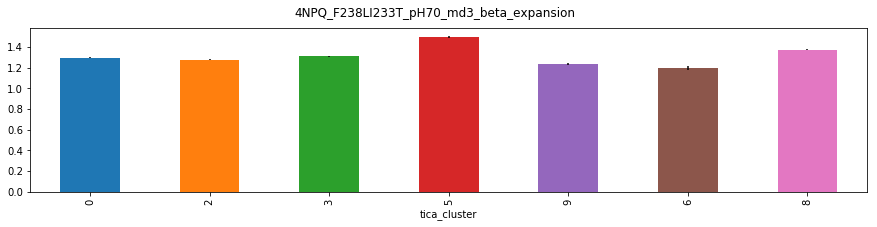

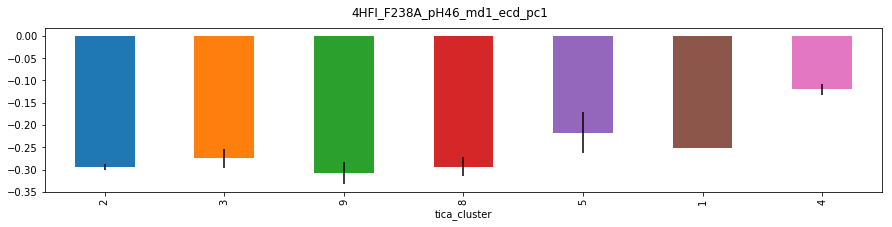

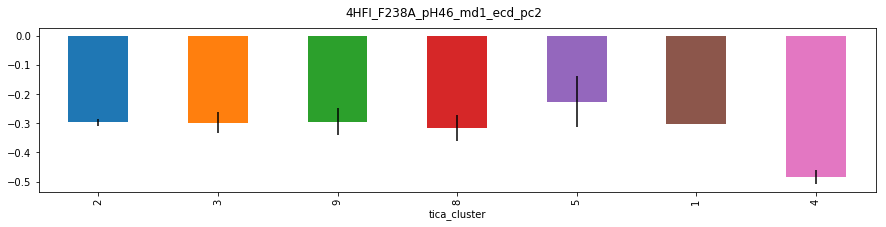

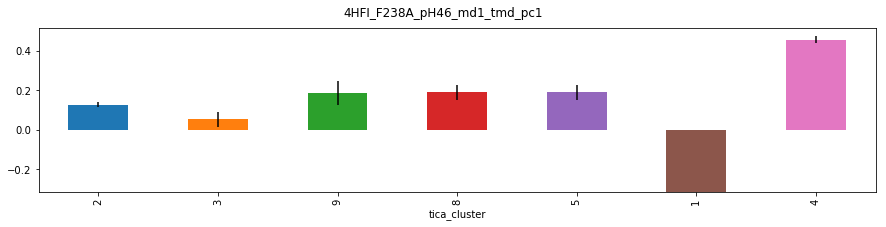

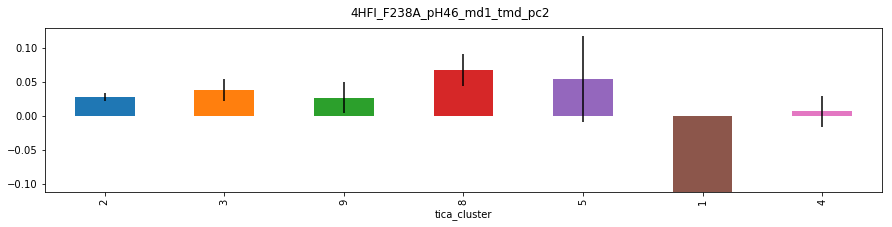

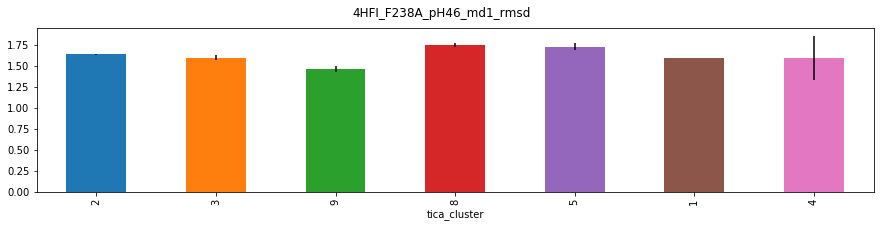

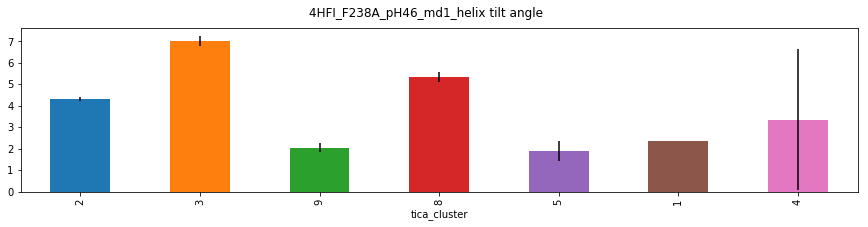

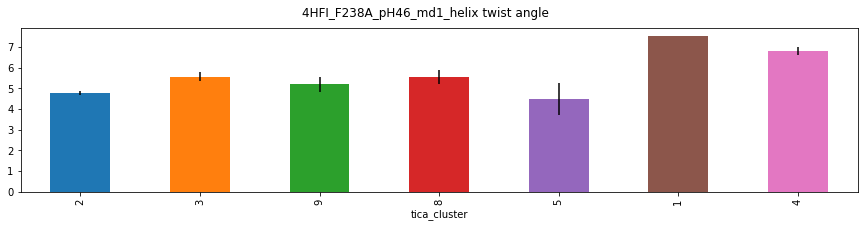

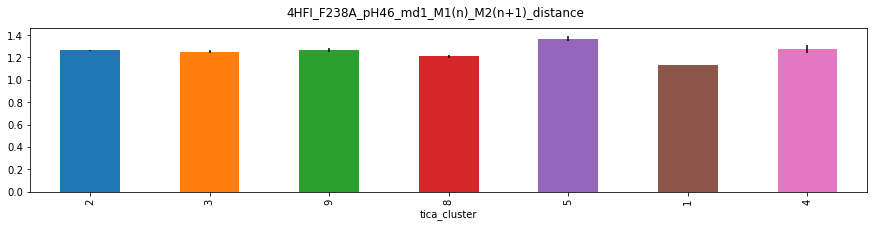

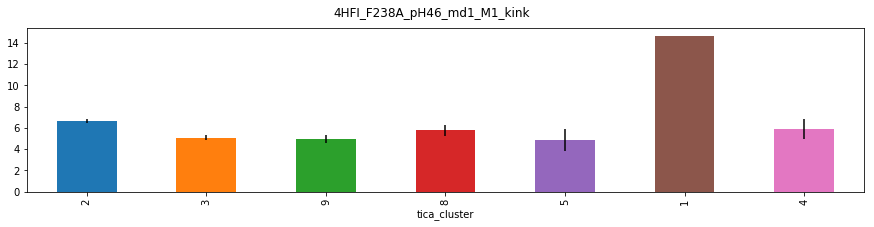

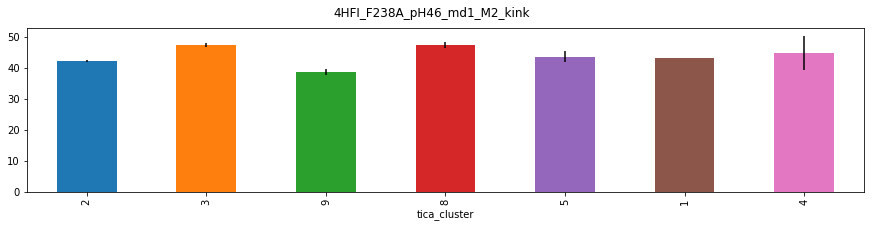

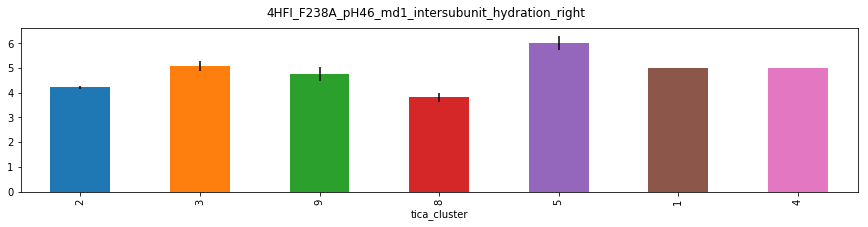

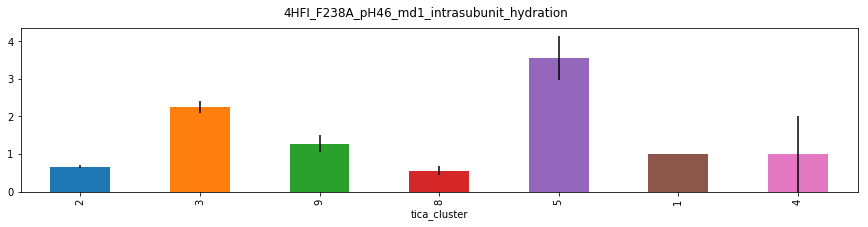

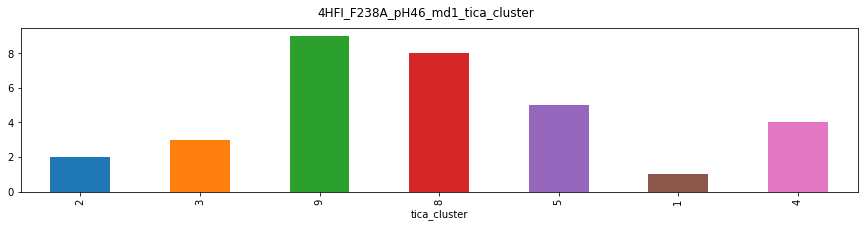

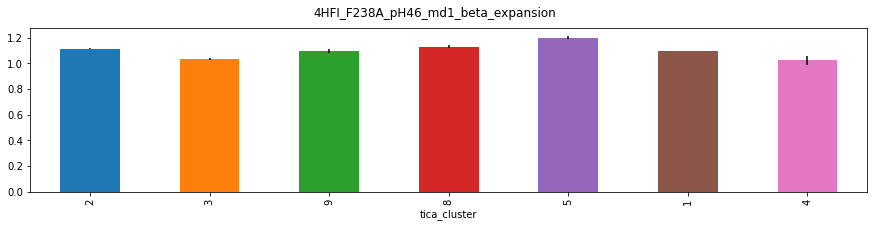

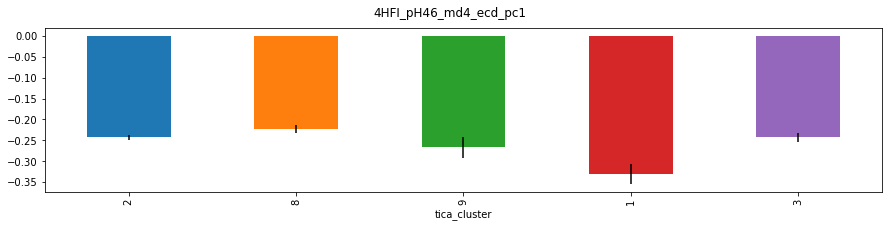

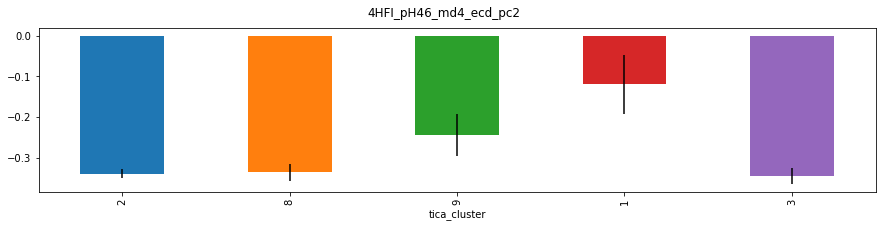

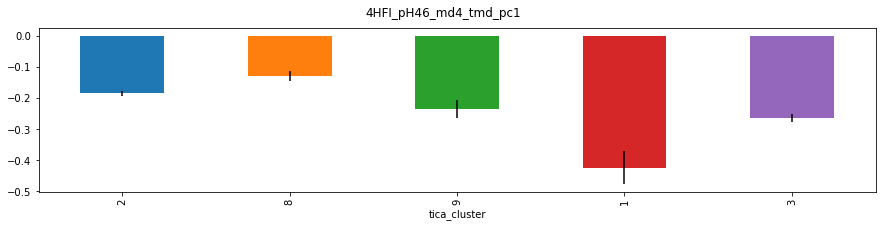

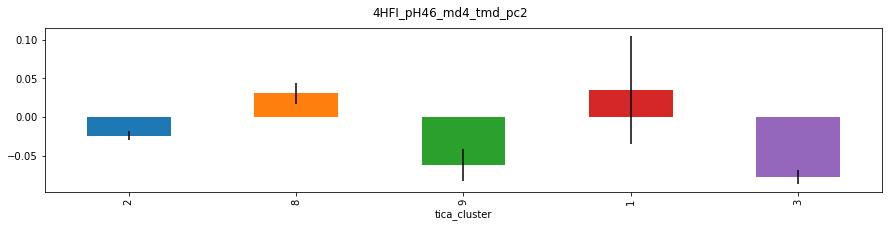

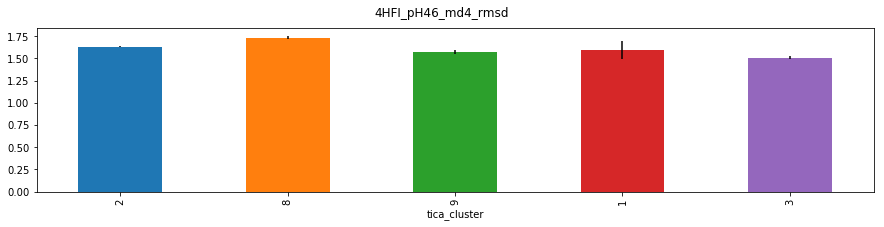

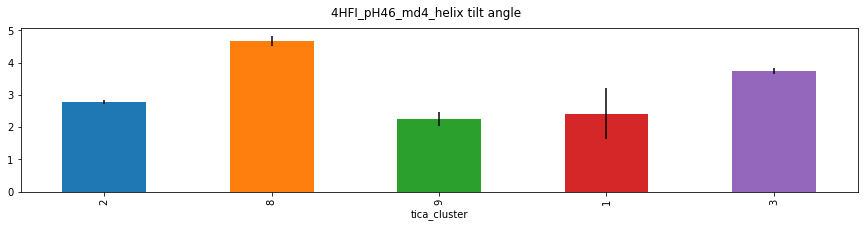

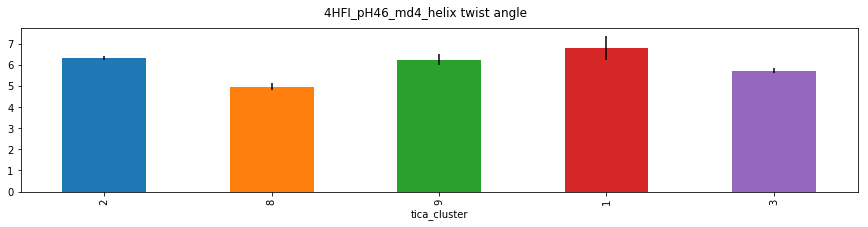

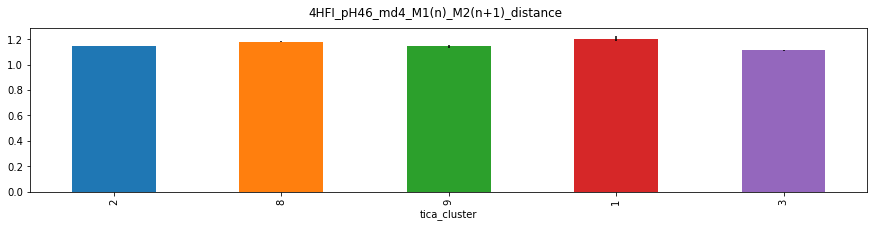

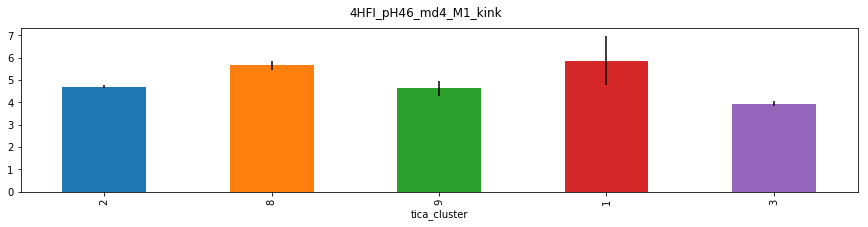

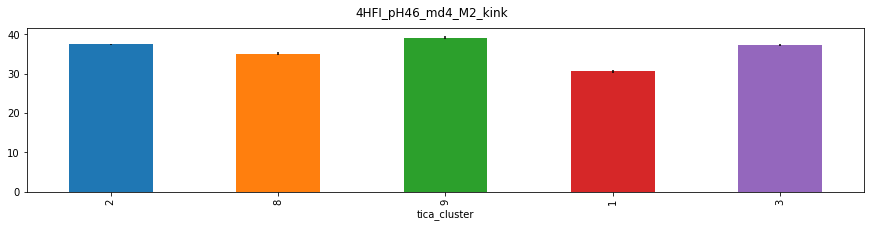

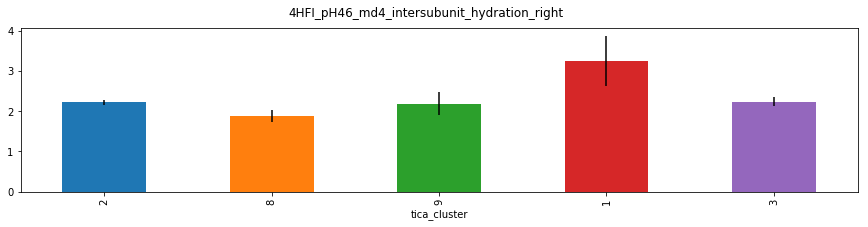

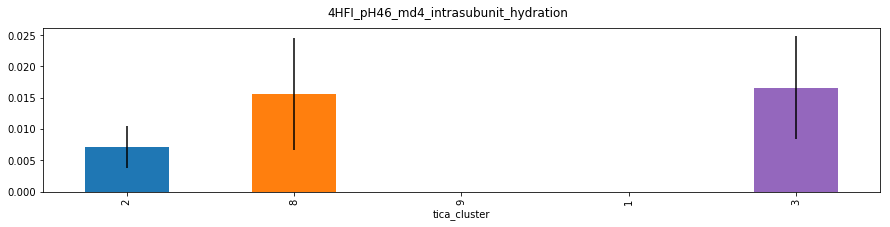

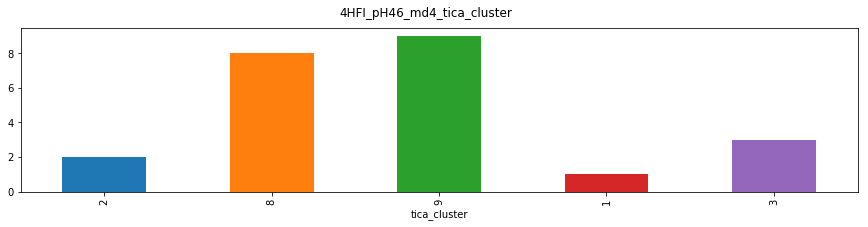

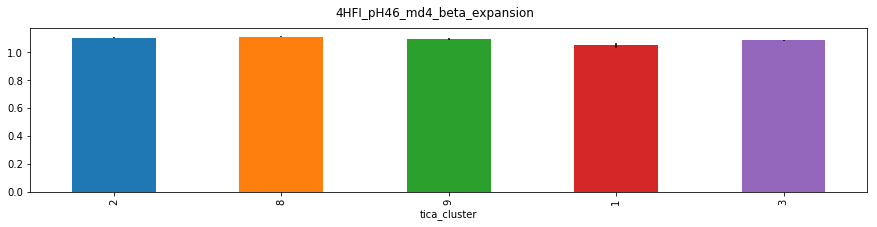

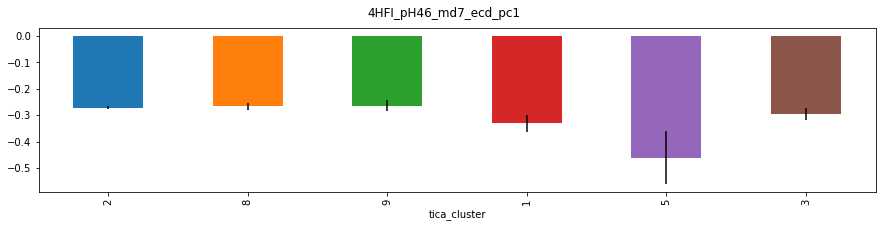

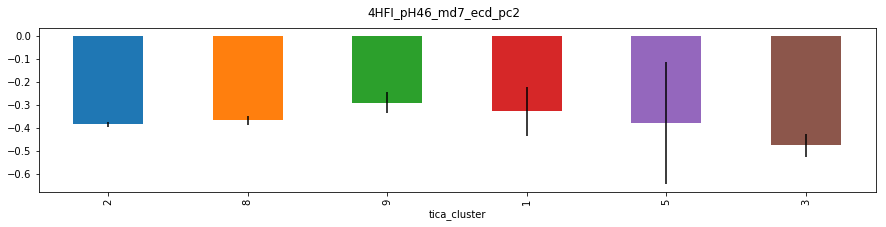

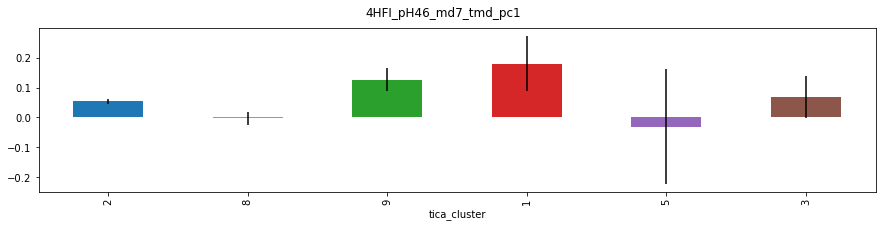

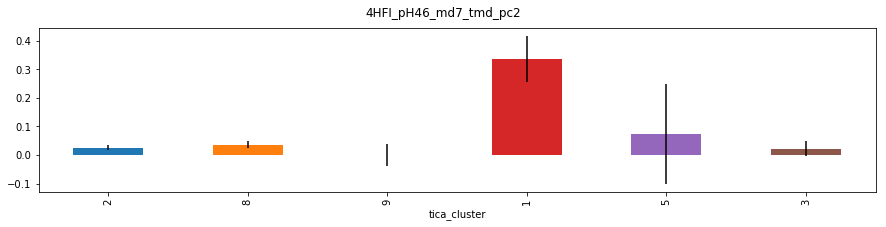

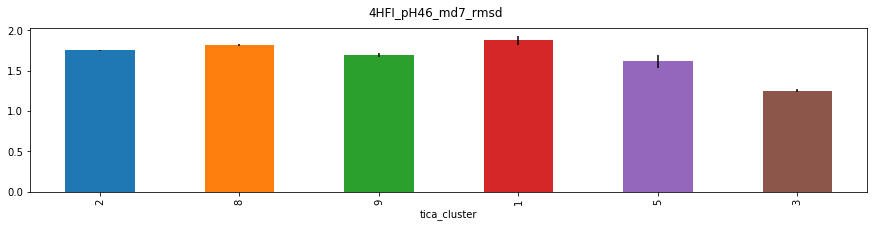

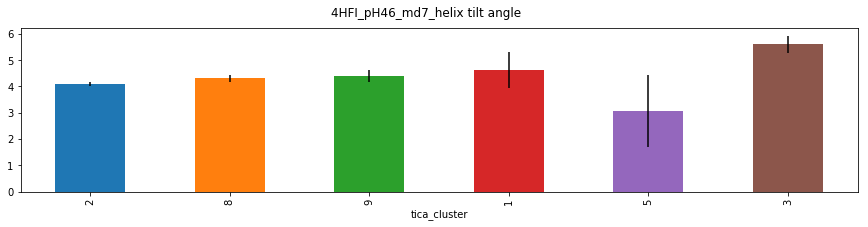

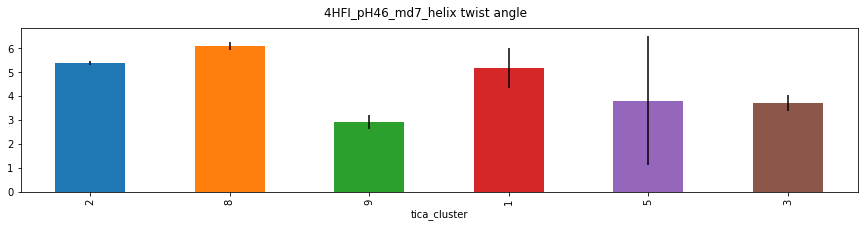

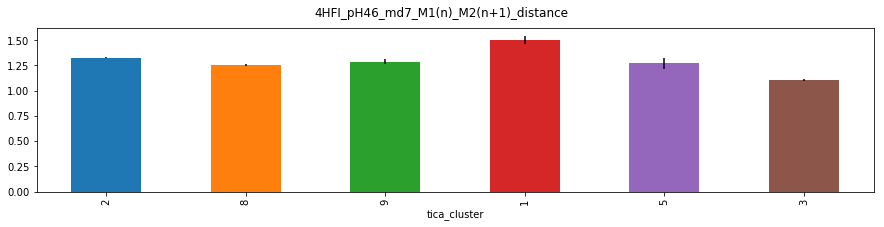

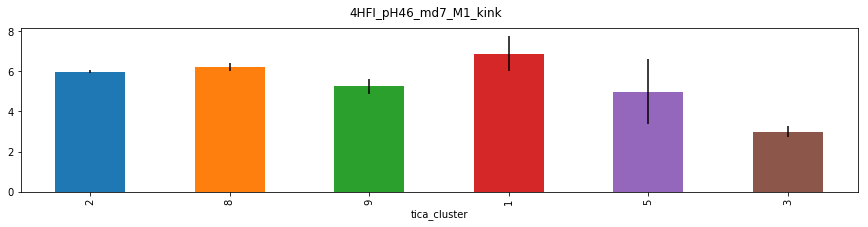

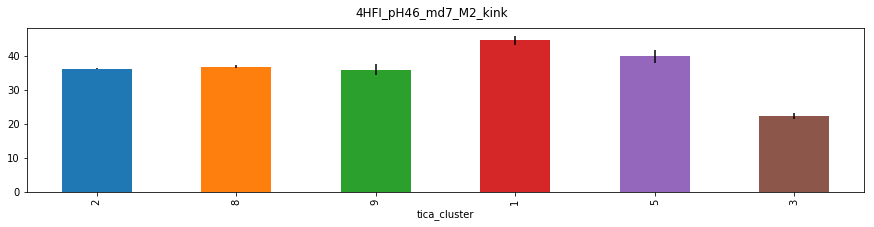

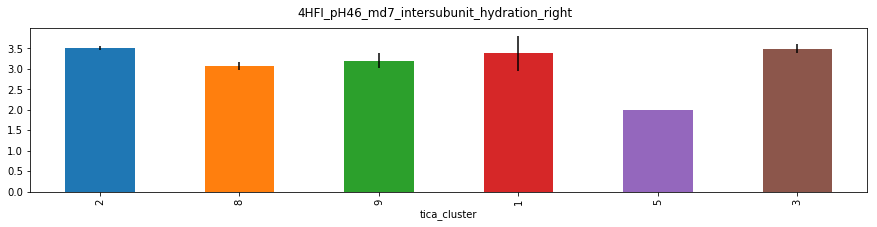

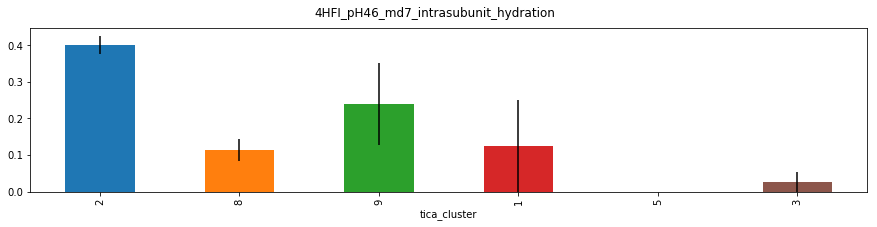

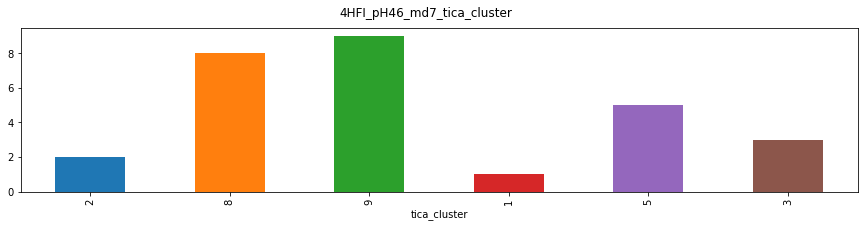

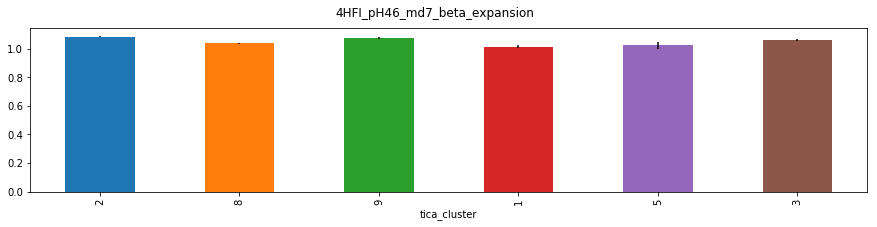

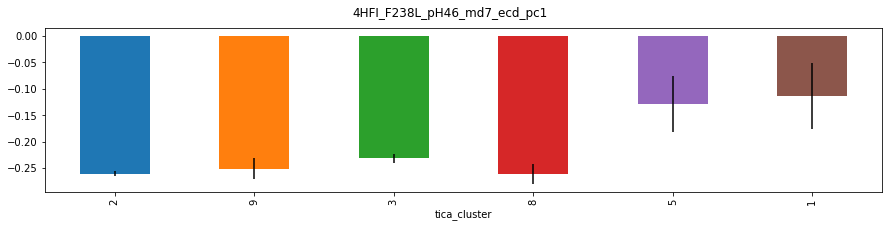

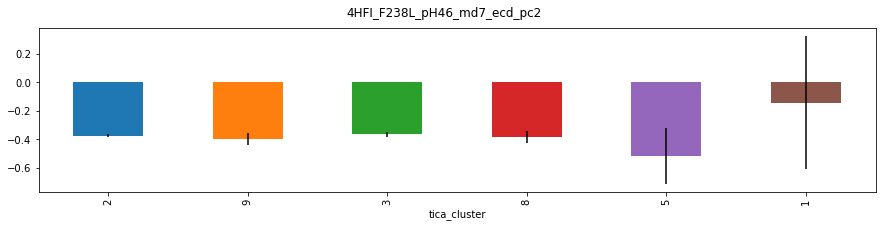

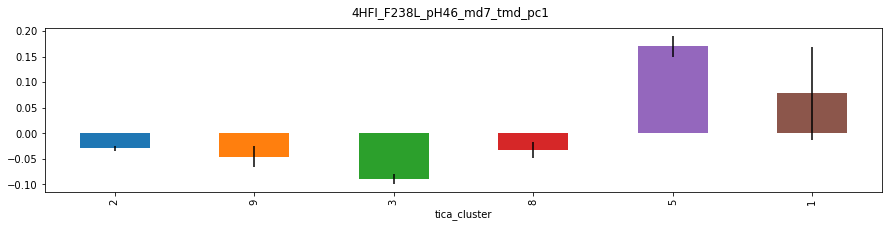

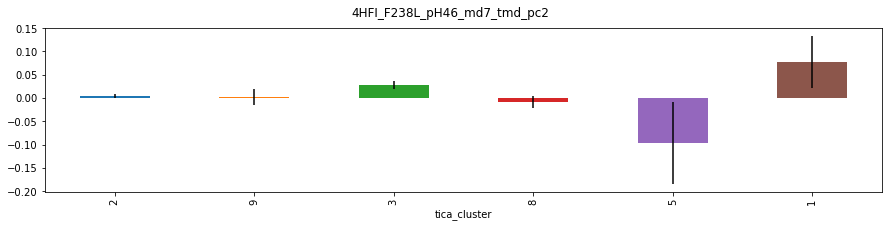

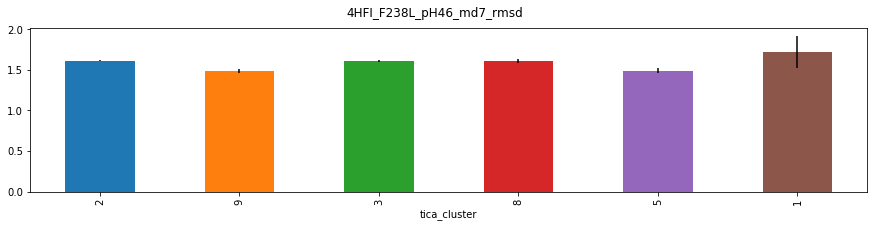

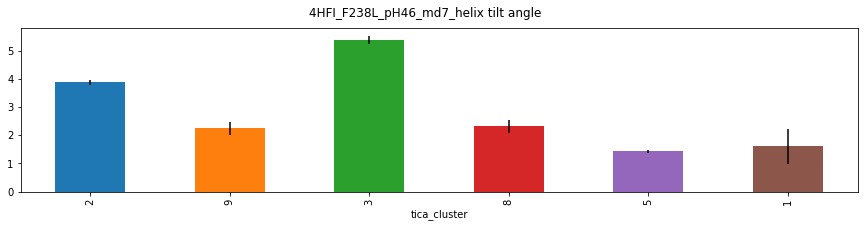

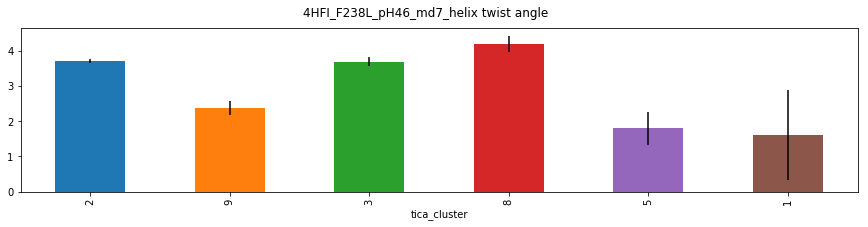

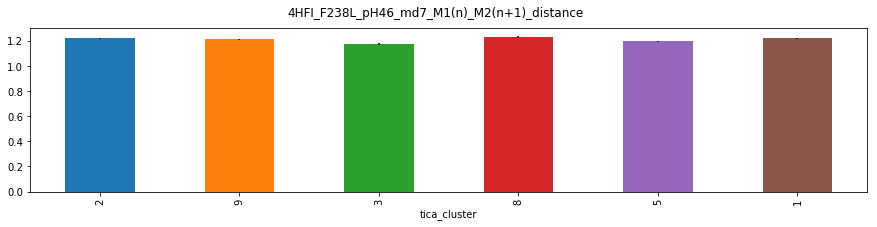

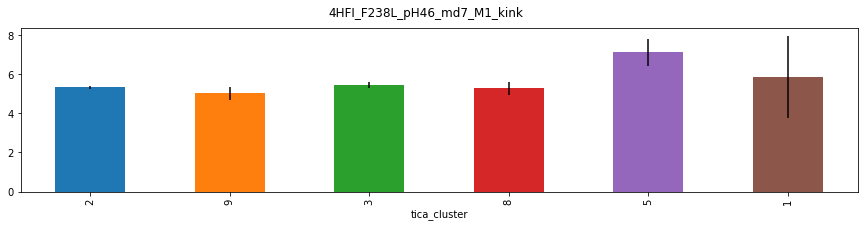

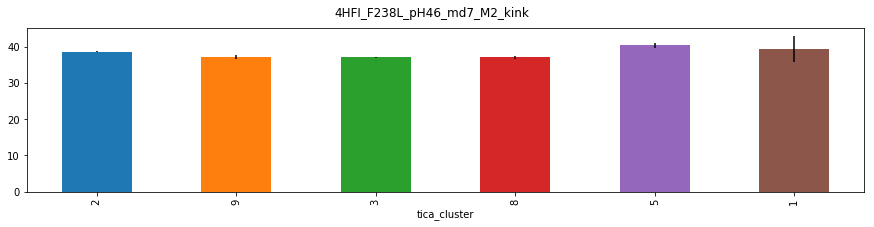

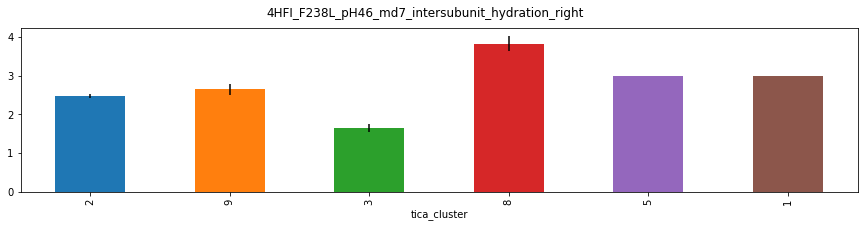

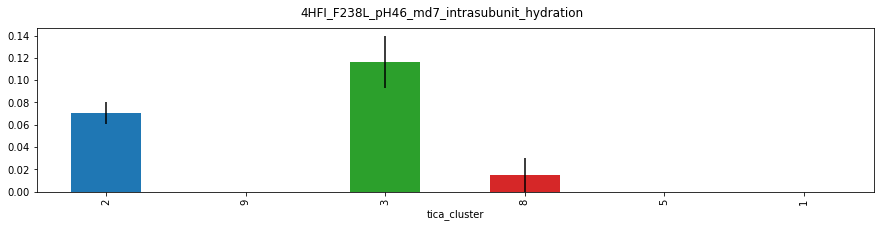

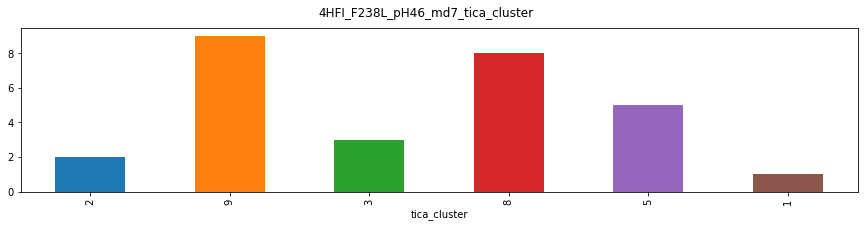

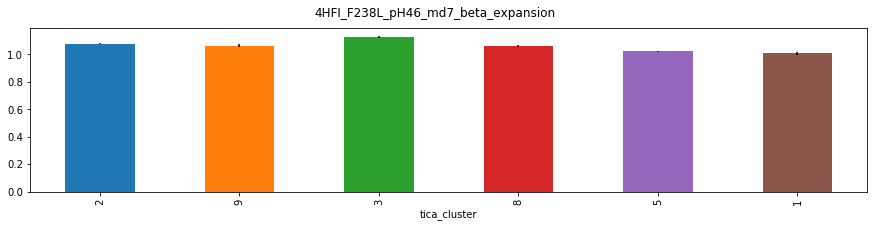

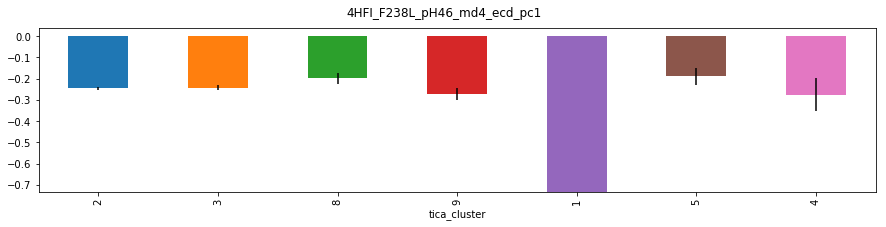

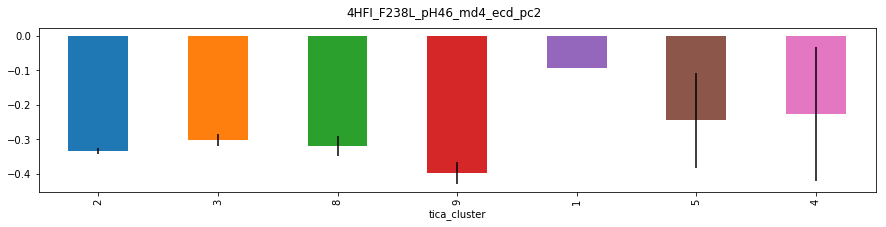

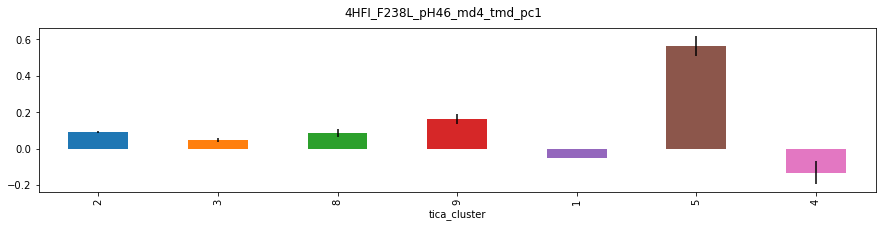

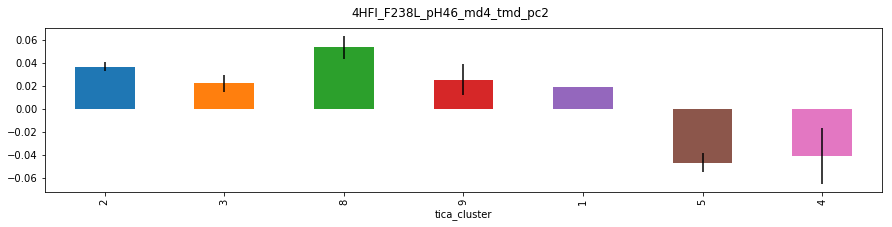

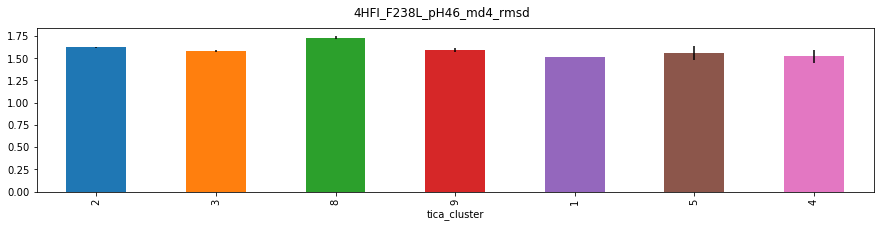

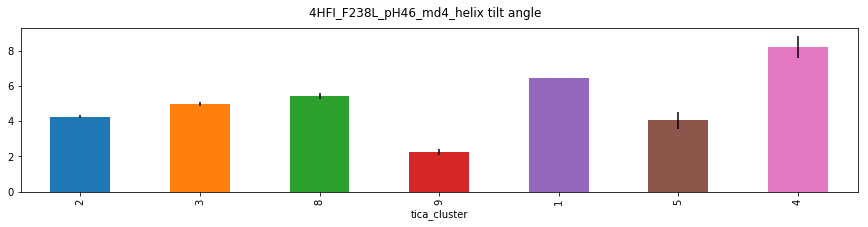

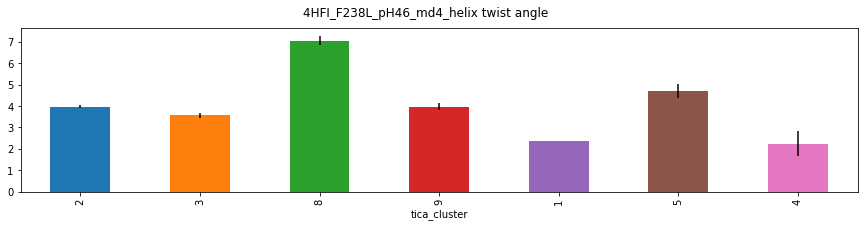

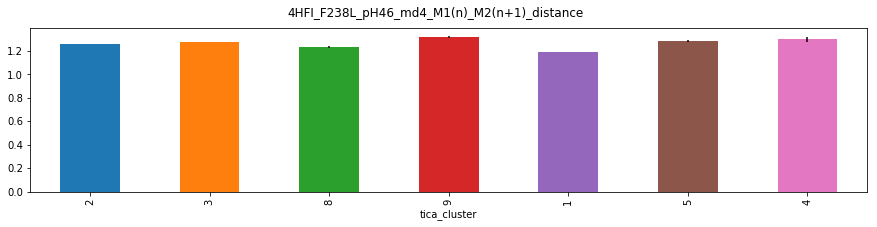

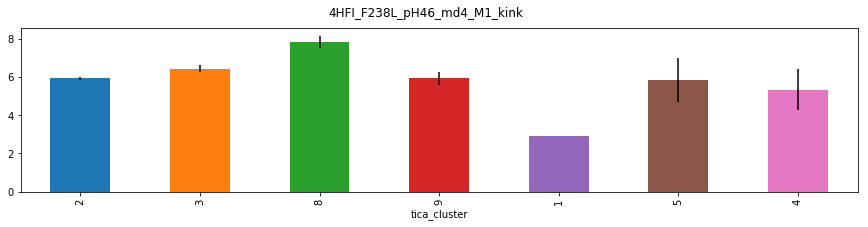

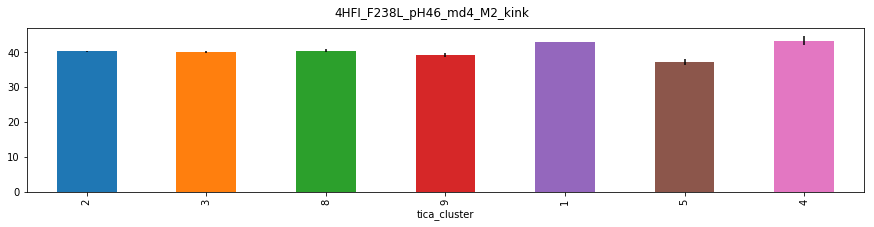

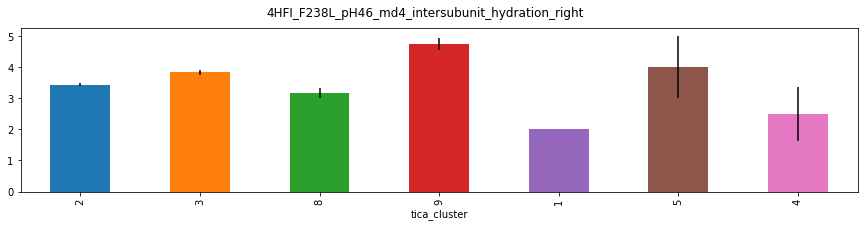

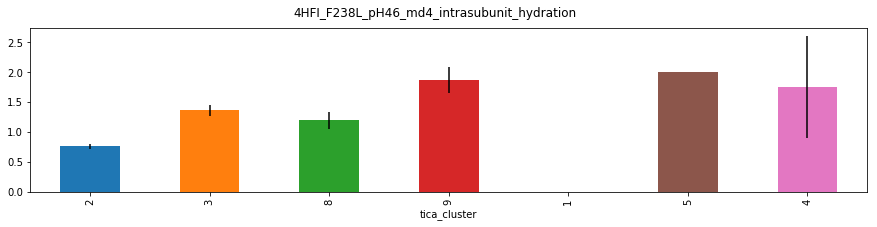

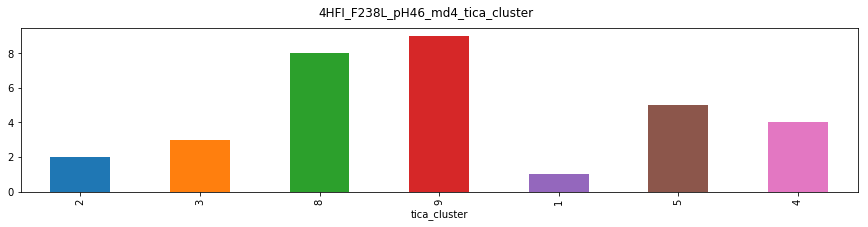

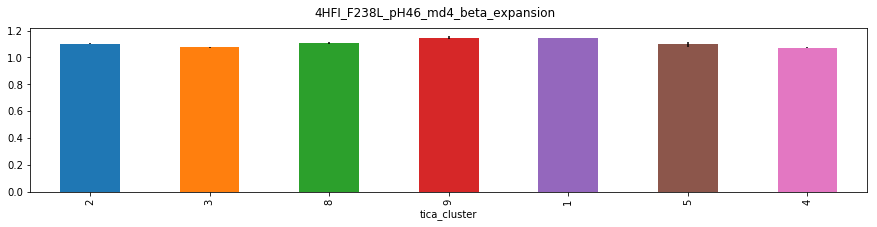

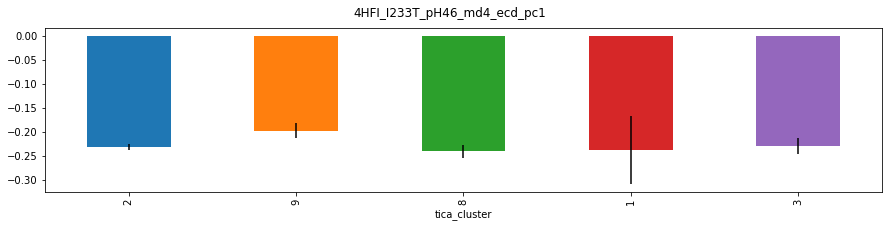

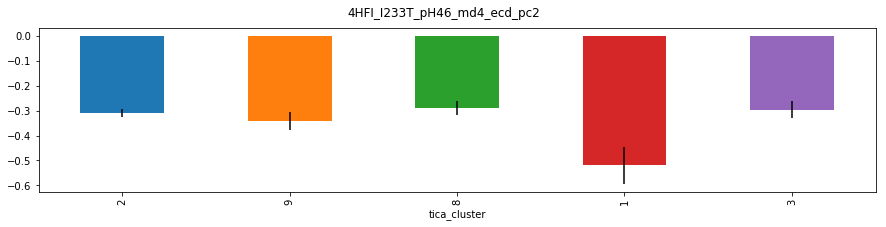

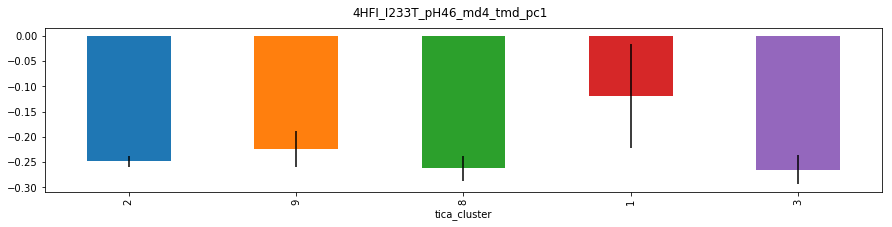

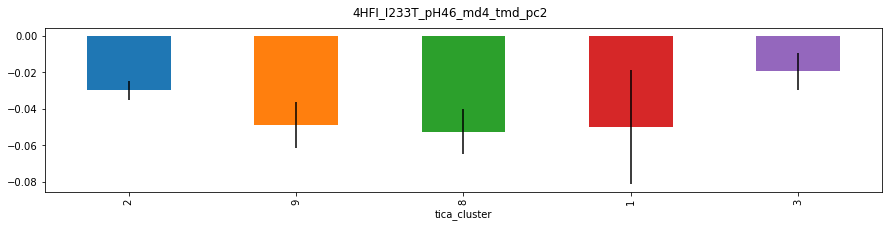

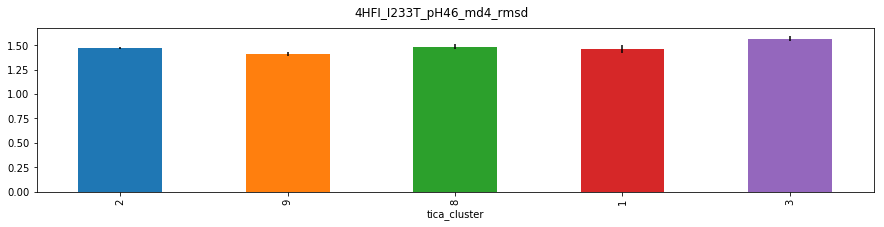

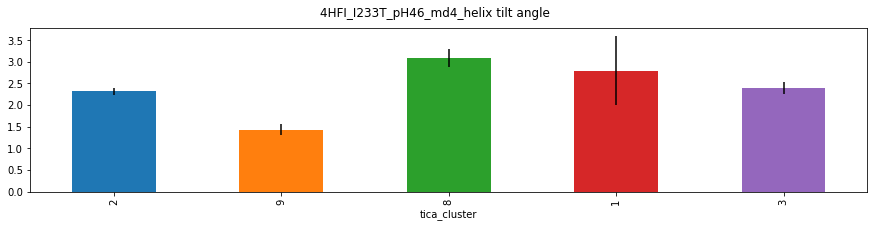

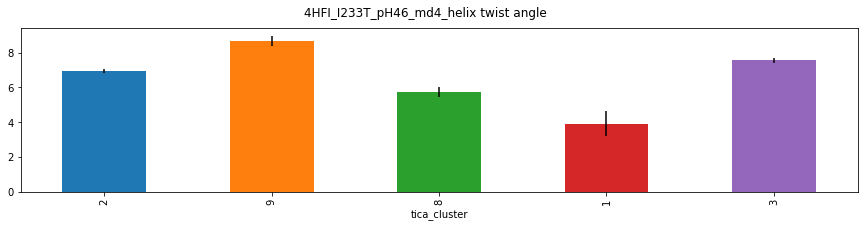

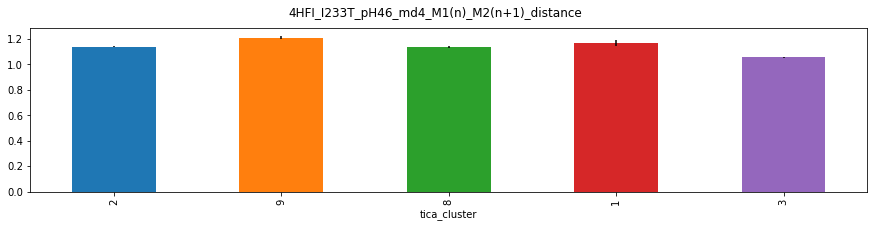

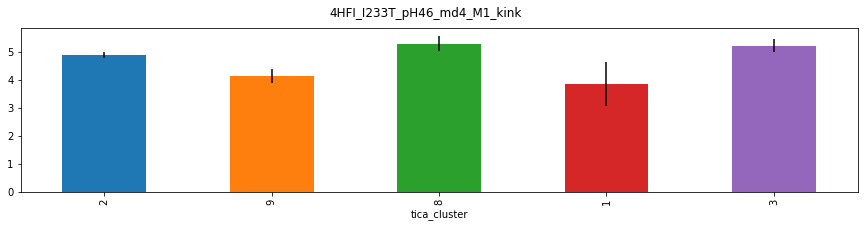

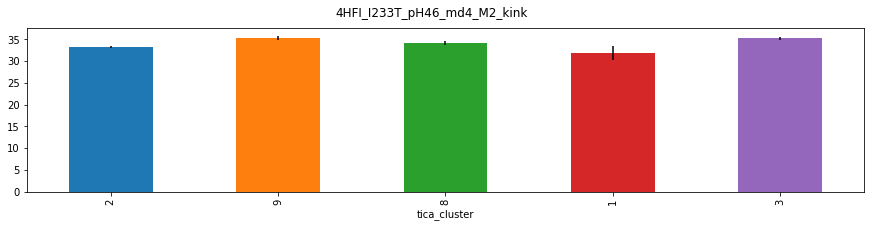

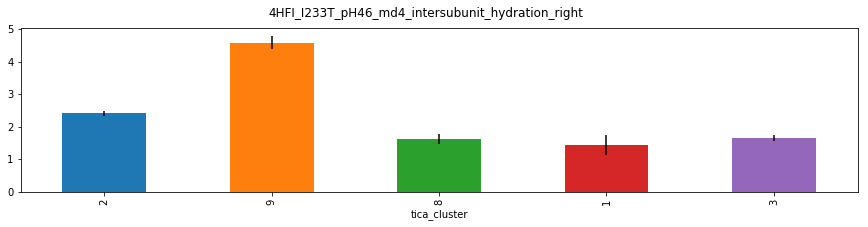

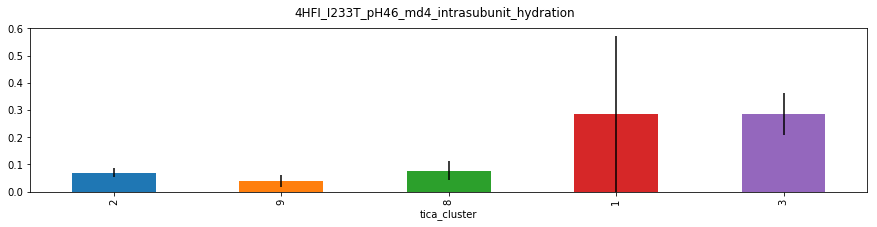

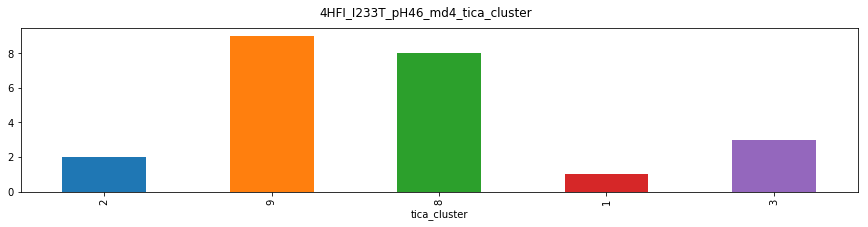

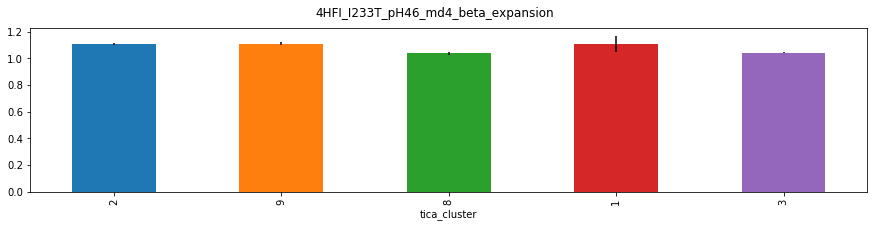

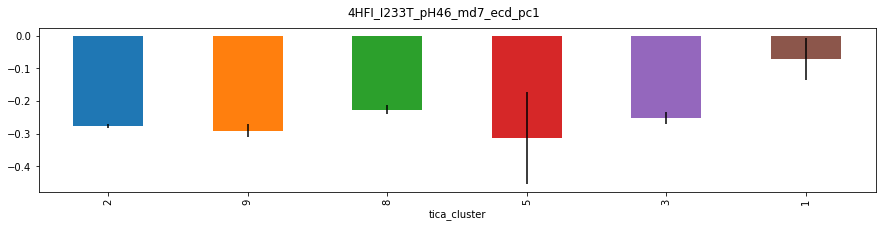

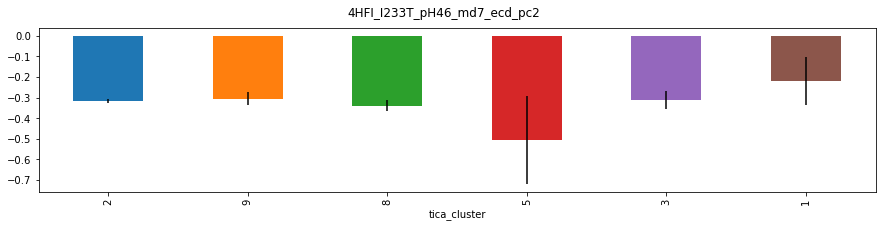

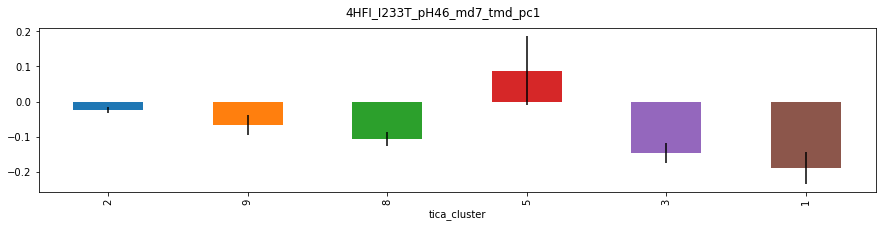

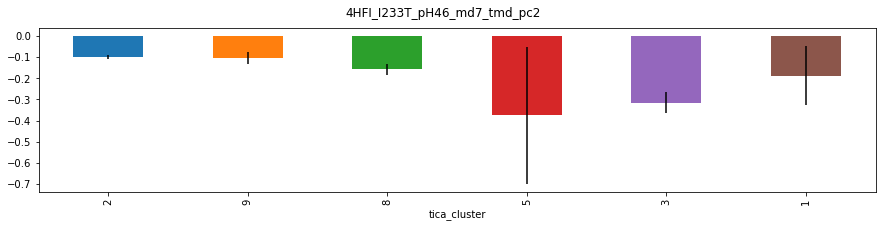

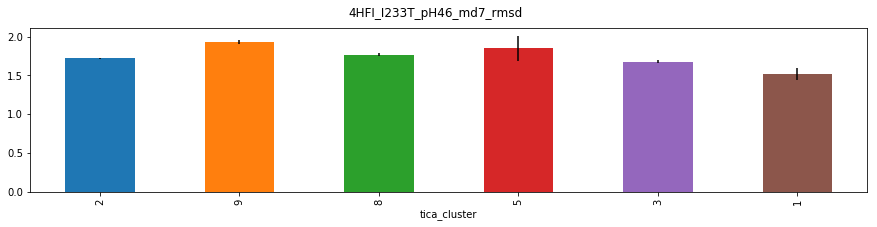

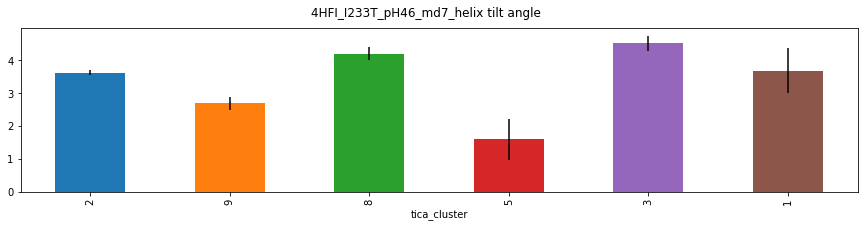

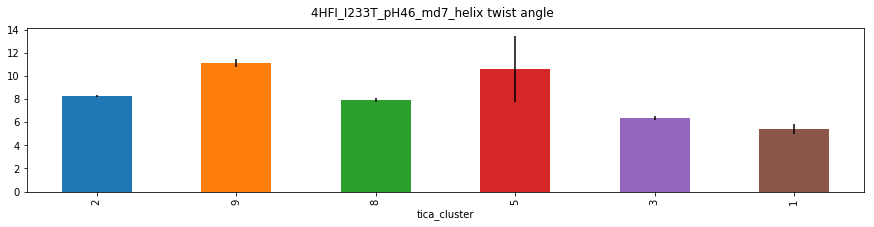

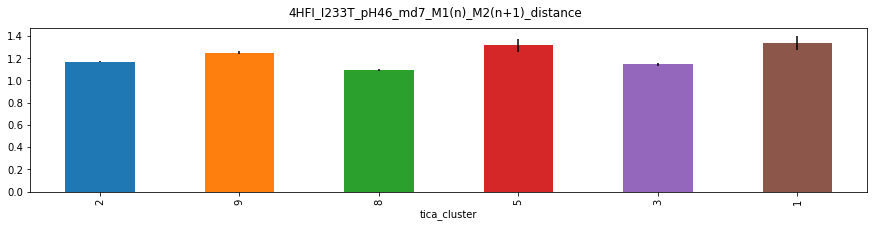

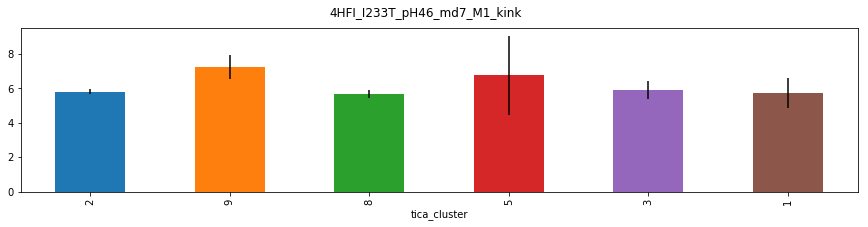

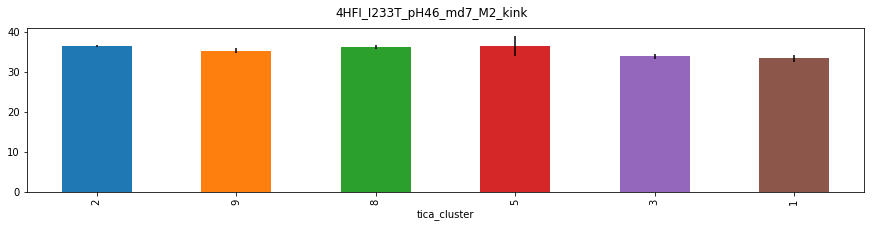

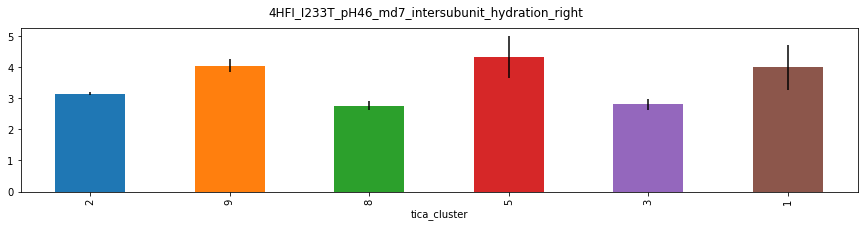

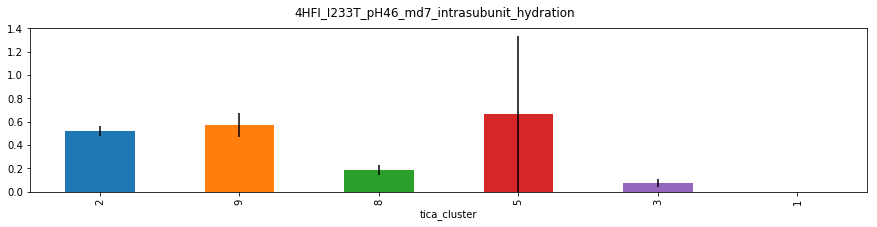

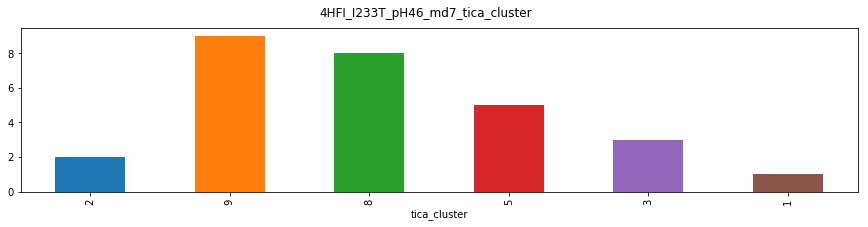

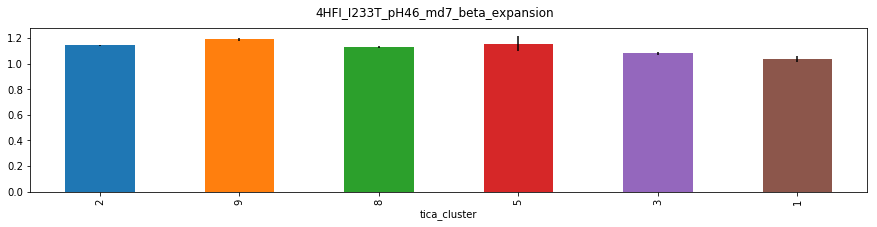

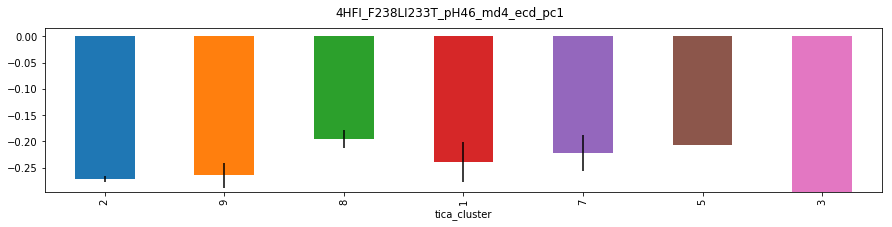

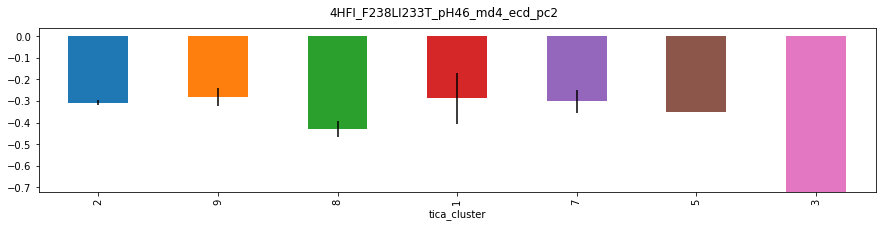

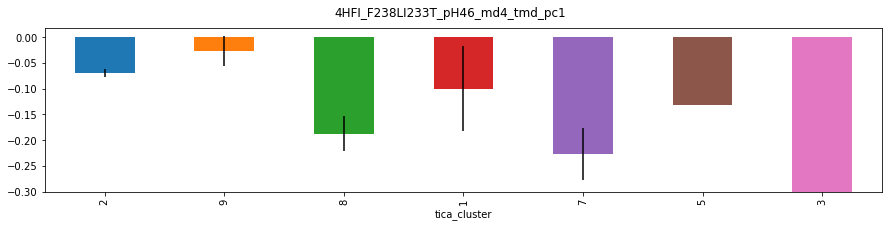

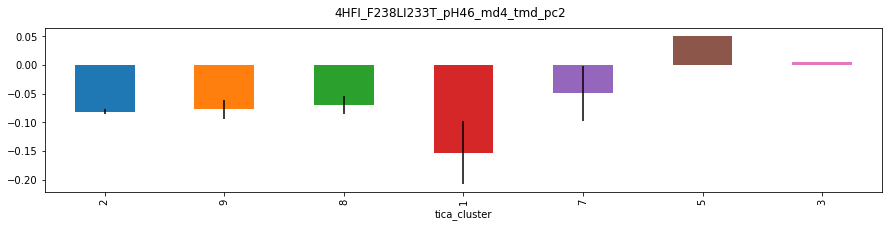

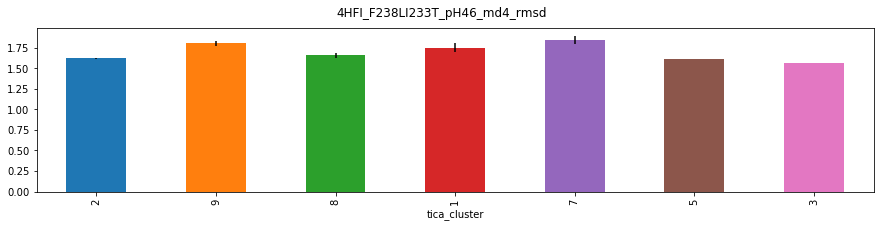

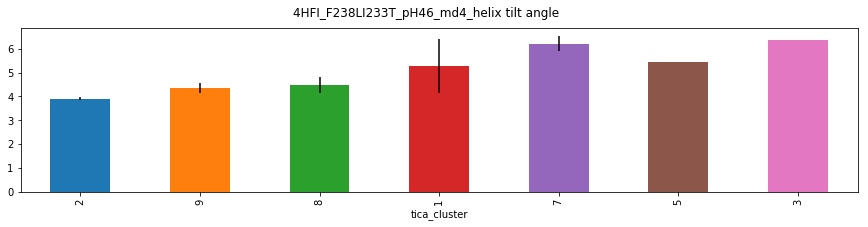

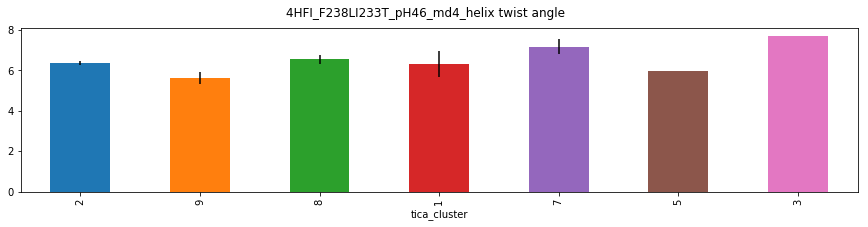

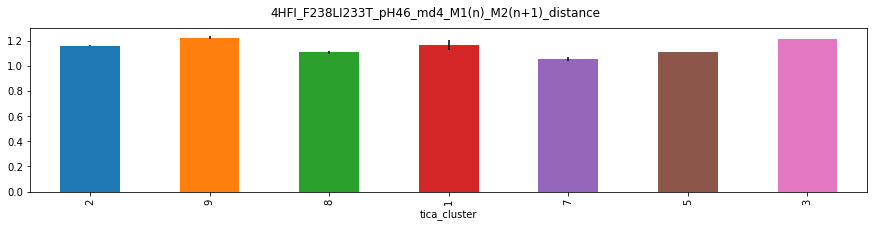

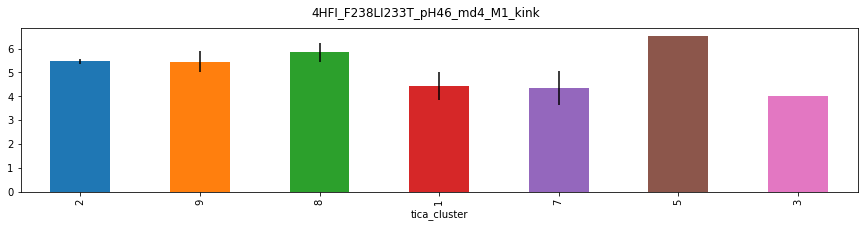

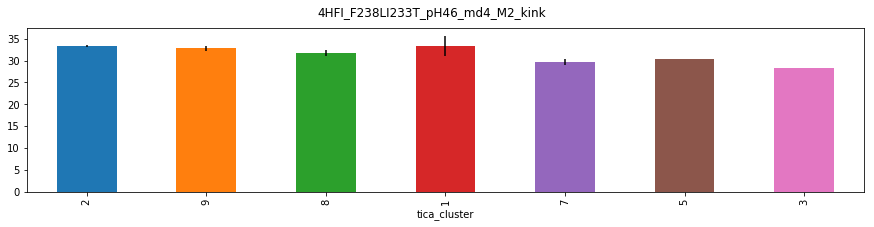

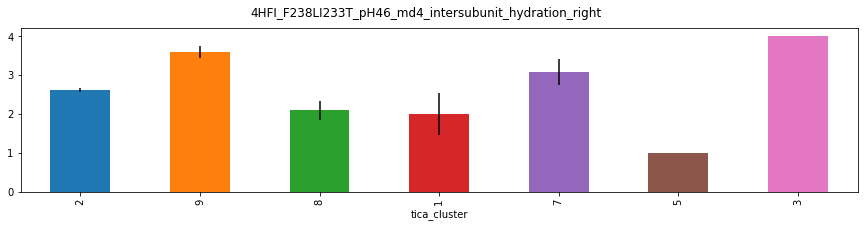

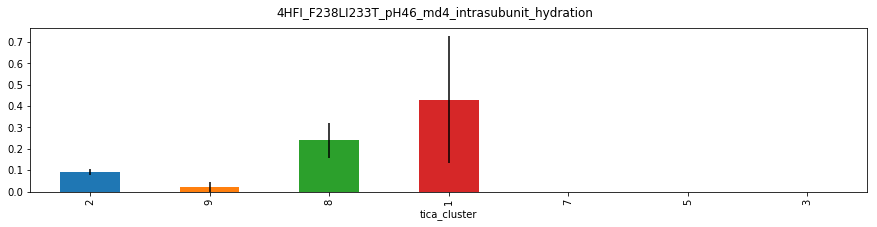

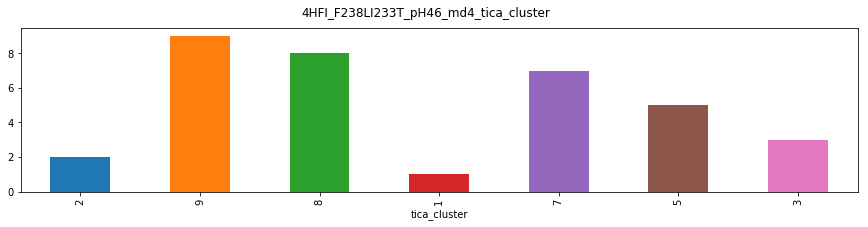

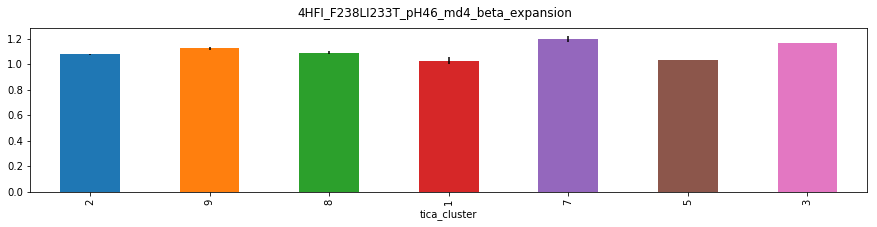

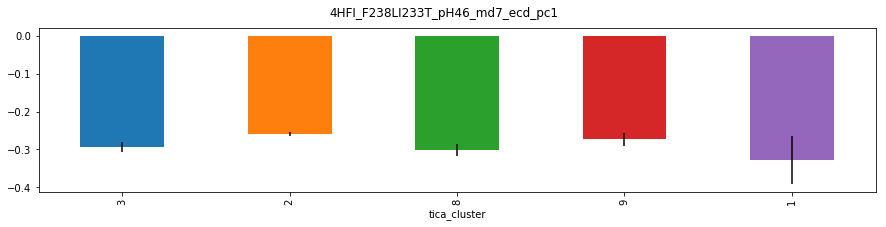

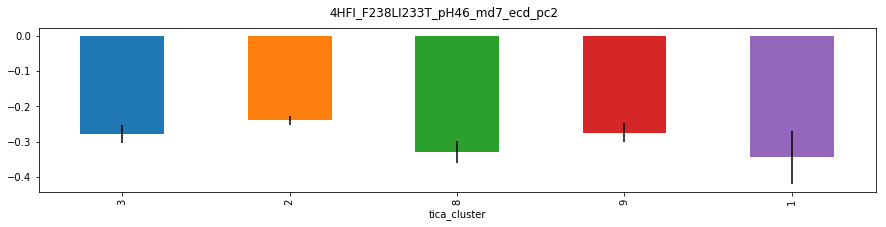

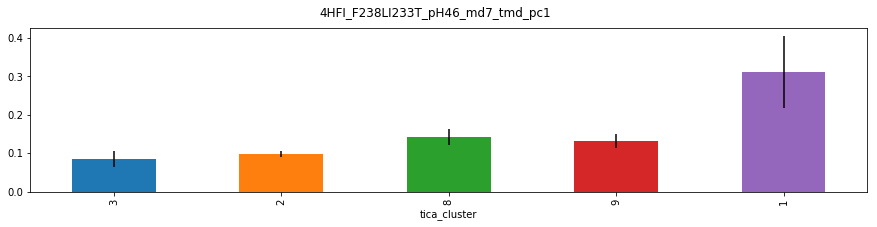

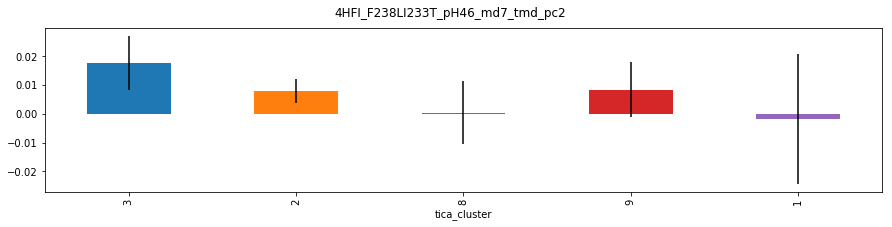

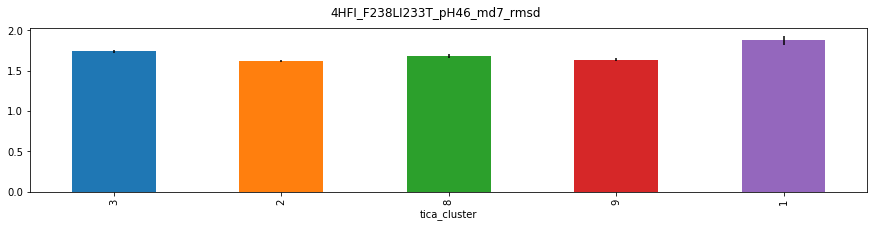

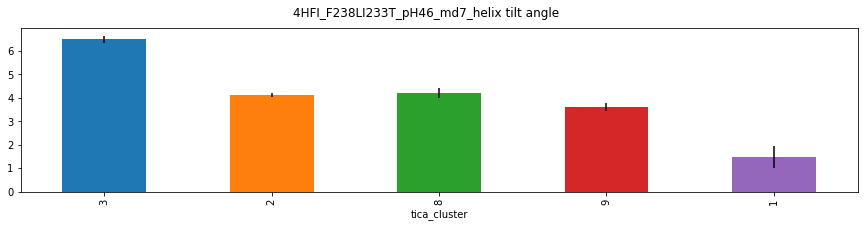

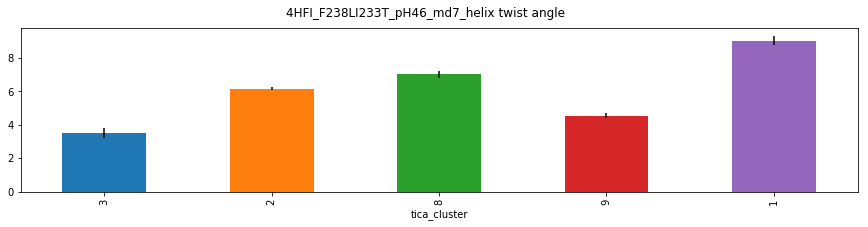

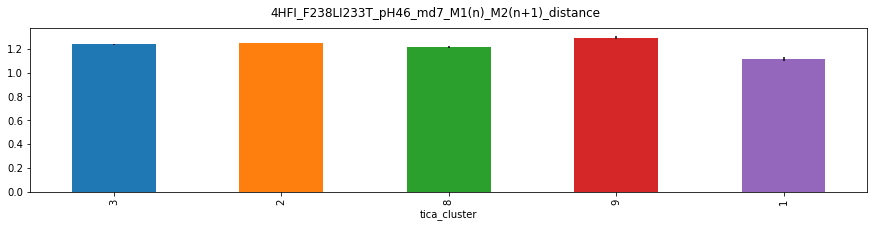

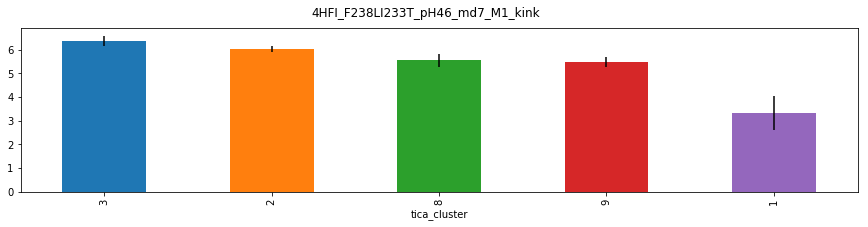

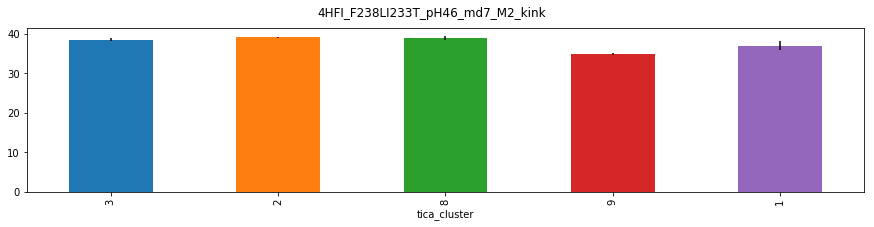

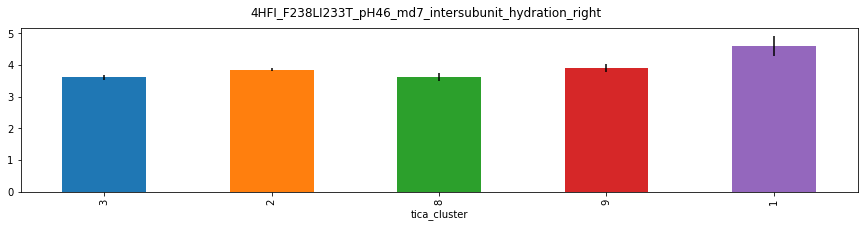

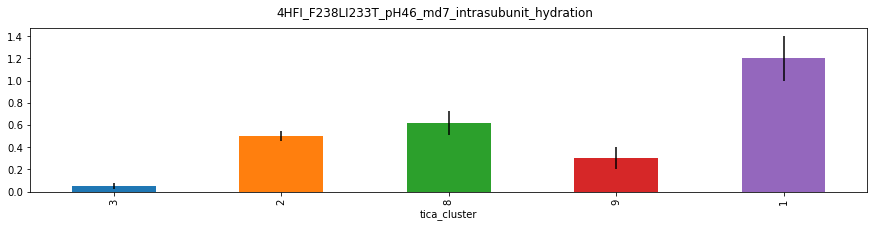

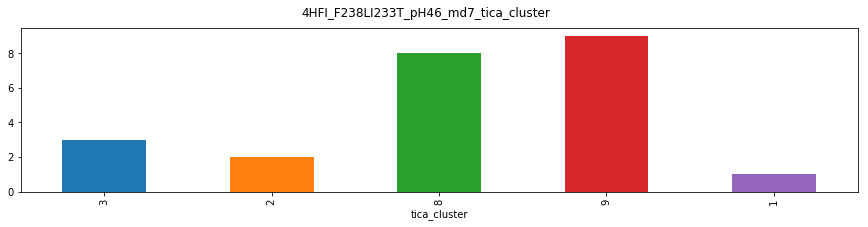

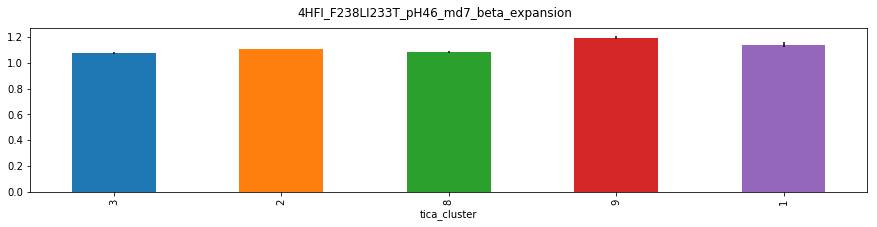

In [148]:
for system in sorted(set(md_data.system)):
    for feature in md_data.columns[6:]:

        fig, ax = plt.subplots(figsize=(15, 3))
        fig.suptitle(notation_changer[system] + '_' + feature)
        group = md_data[(md_data.traj_time > 20) & (md_data.system == system)].groupby(['tica_cluster'],sort=False)[feature]
        mean = group.mean()
        errors = group.sem()
        mean.plot.bar(yerr=errors,ax=ax)
#    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


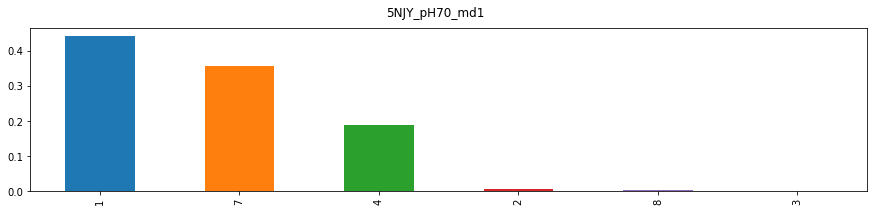

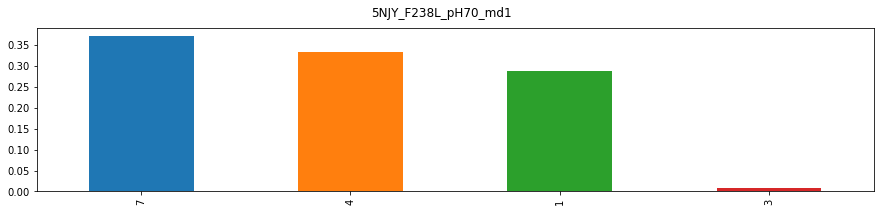

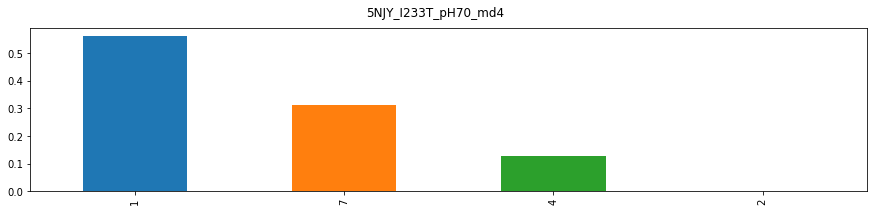

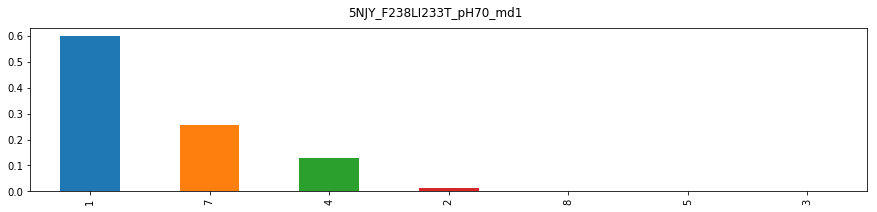

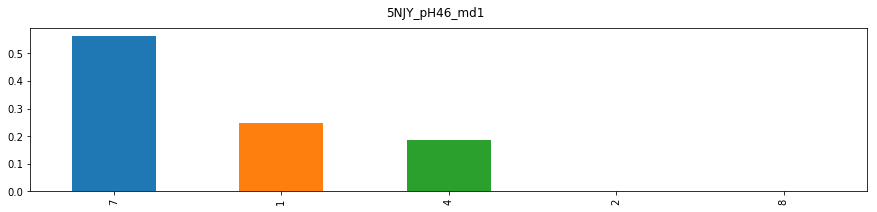

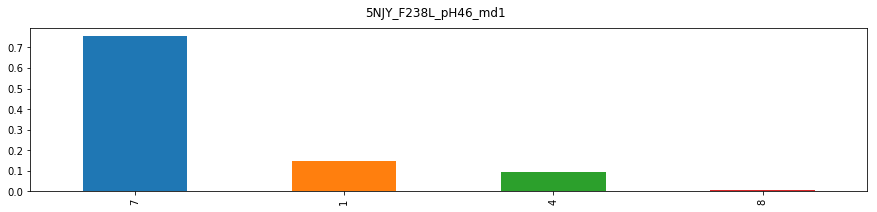

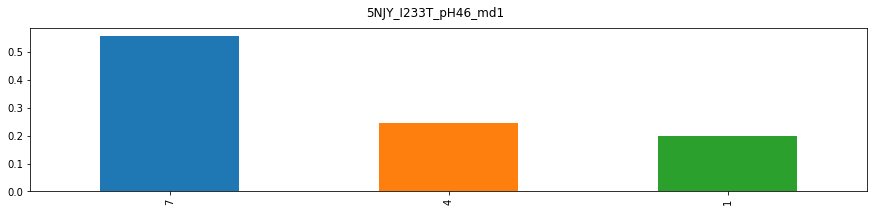

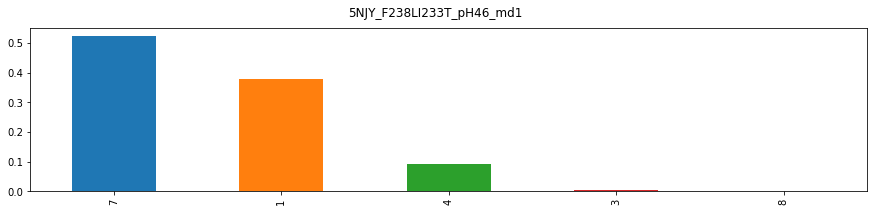

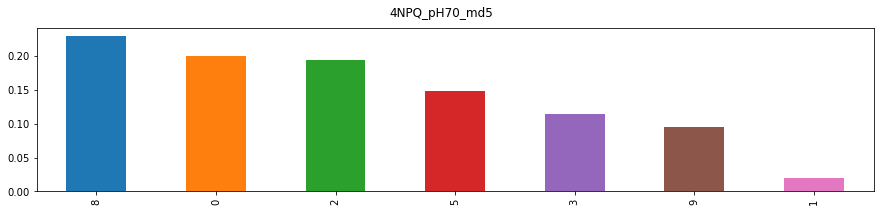

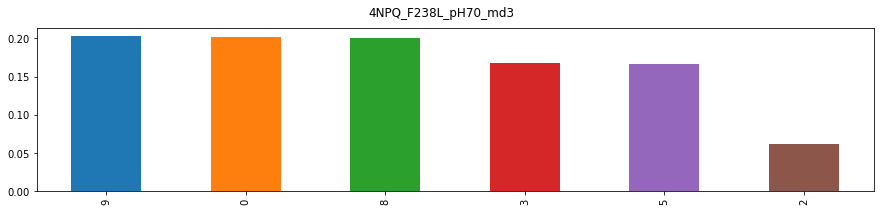

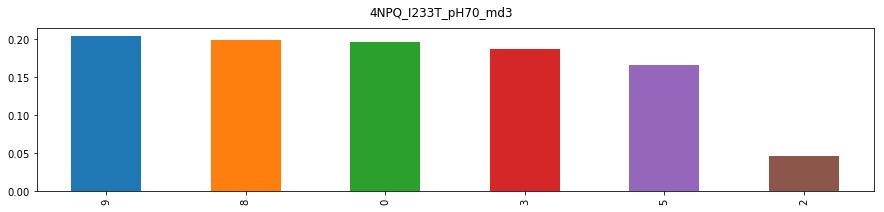

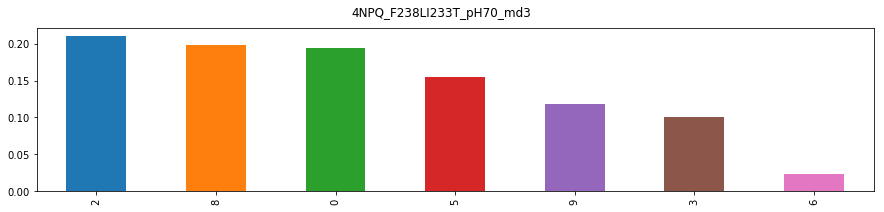

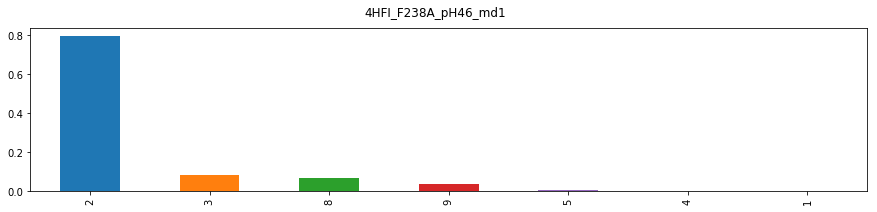

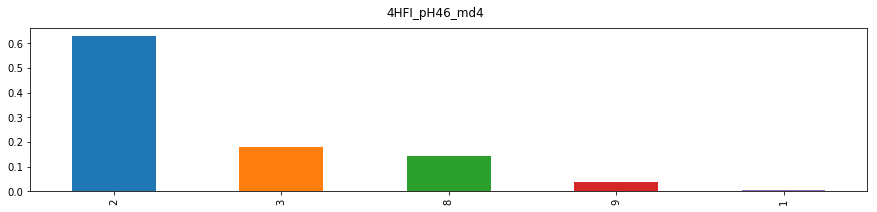

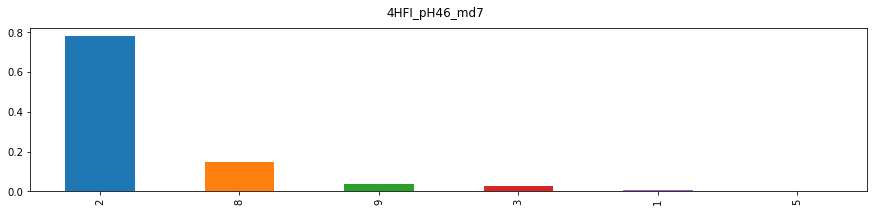

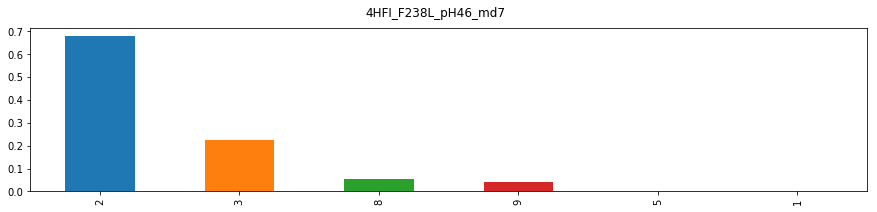

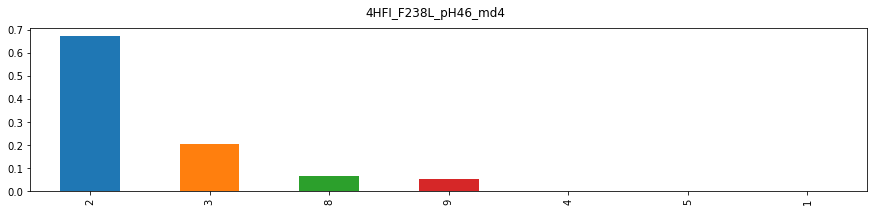

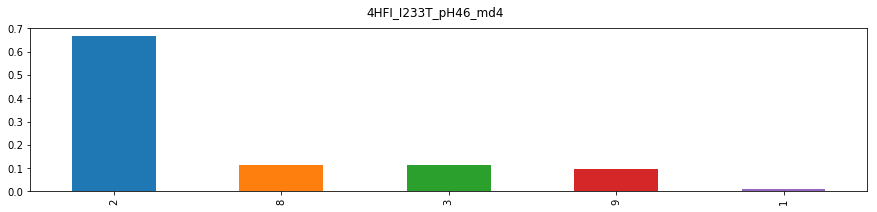

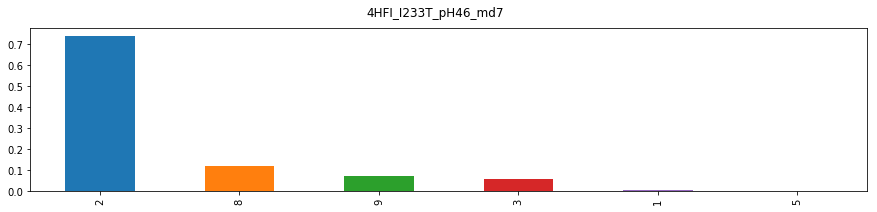

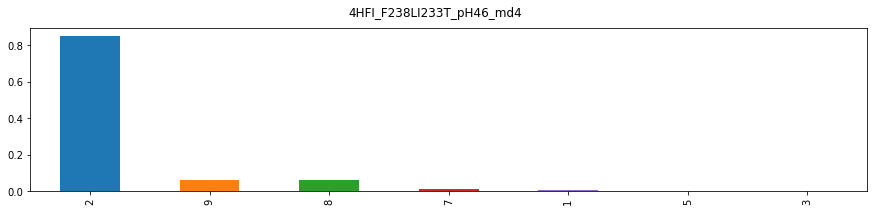

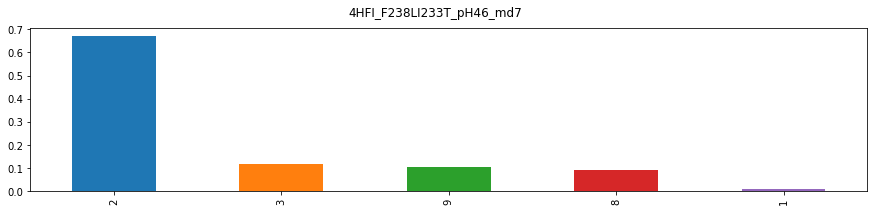

In [149]:
for system in sorted(set(md_data.system)):
    fig, ax = plt.subplots(figsize=(15, 3))
    fig.suptitle(notation_changer[system])
    group = md_data[(md_data.traj_time > 20) & (md_data.system == system)]['tica_cluster']
    mean = group.value_counts(normalize=True)
#    errors = group.sem()
    mean.plot.bar(ax=ax)
#    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


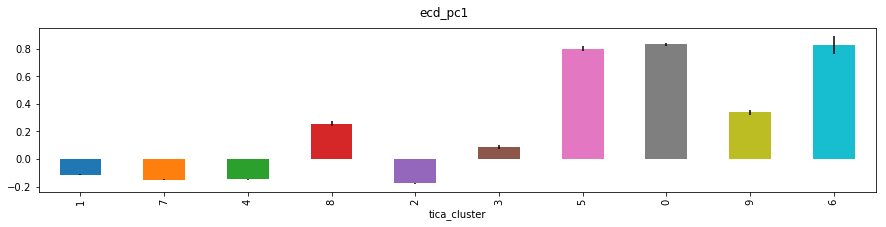

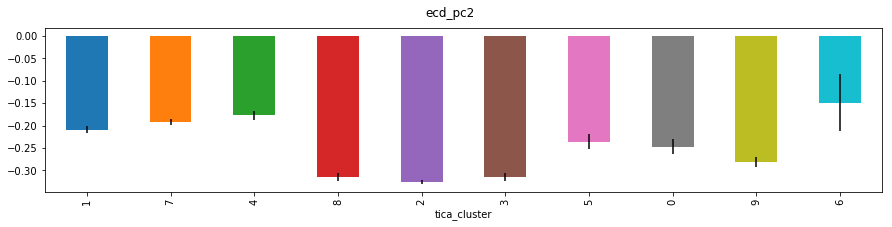

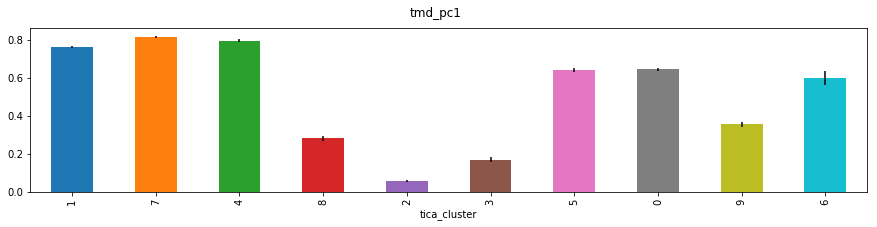

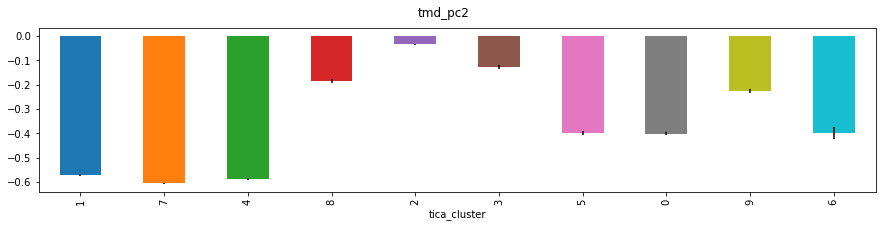

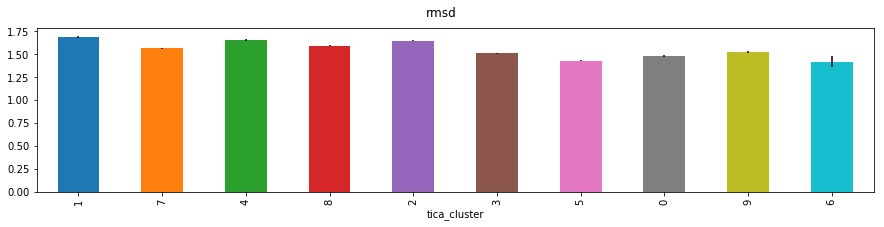

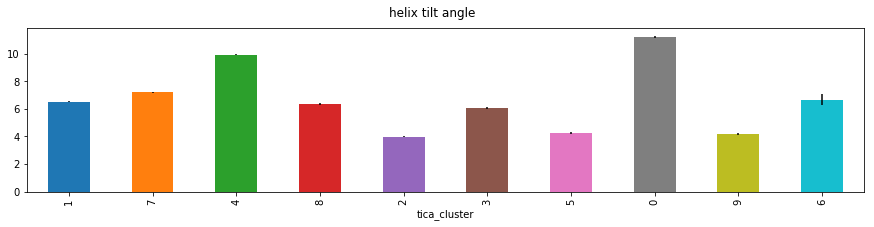

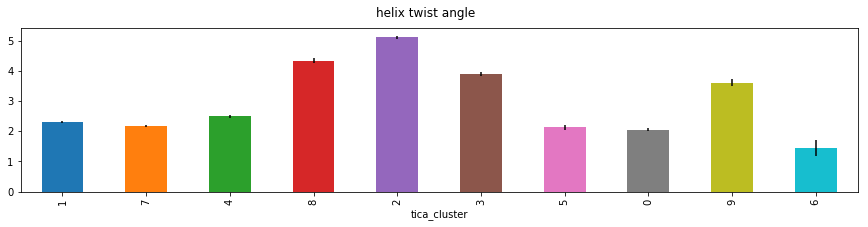

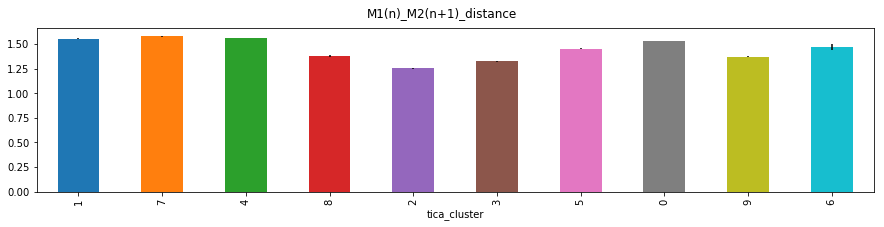

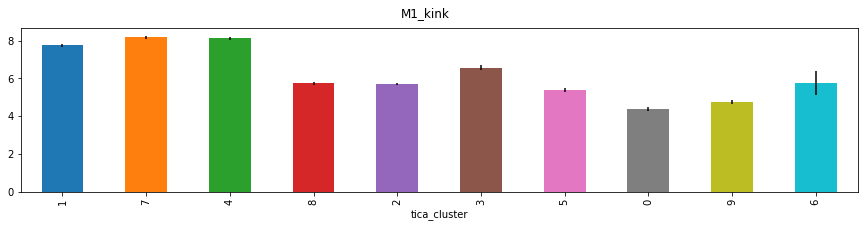

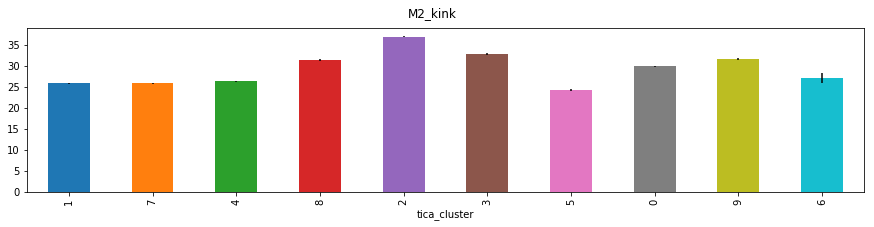

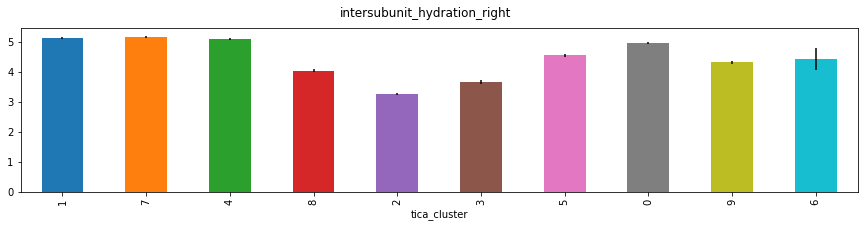

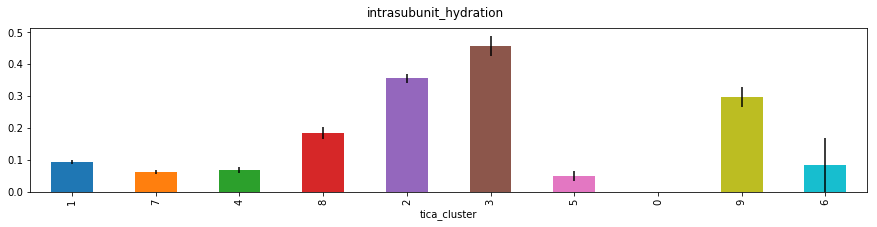

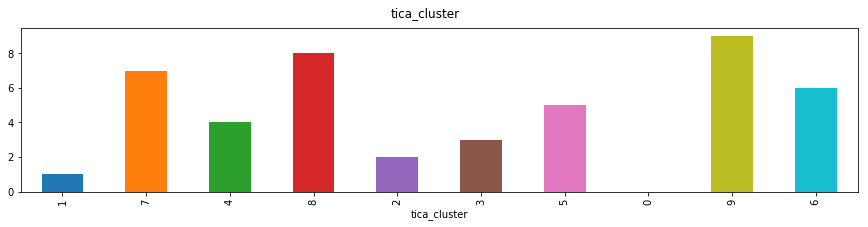

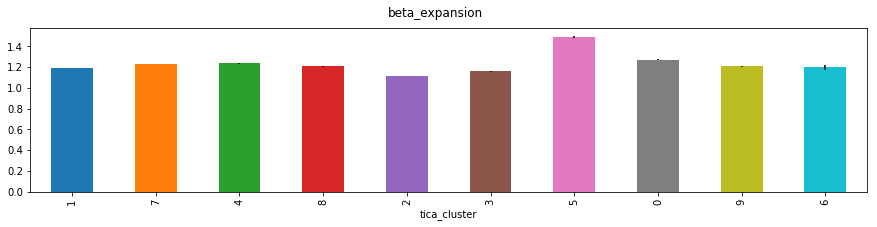

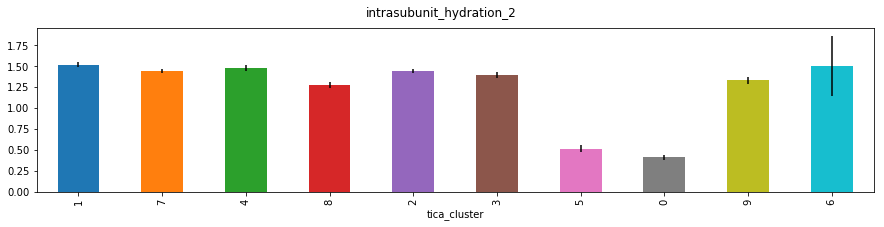

In [260]:
for feature in md_data.columns[6:]:

    fig, ax = plt.subplots(figsize=(15, 3))
    fig.suptitle(feature)
    group = md_data[(md_data.traj_time > 50)].groupby(['tica_cluster'],sort=False)[feature]
    mean = group.mean()
    errors = group.sem()
    mean.plot.bar(yerr=errors,ax=ax)
#    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


(0, 10)

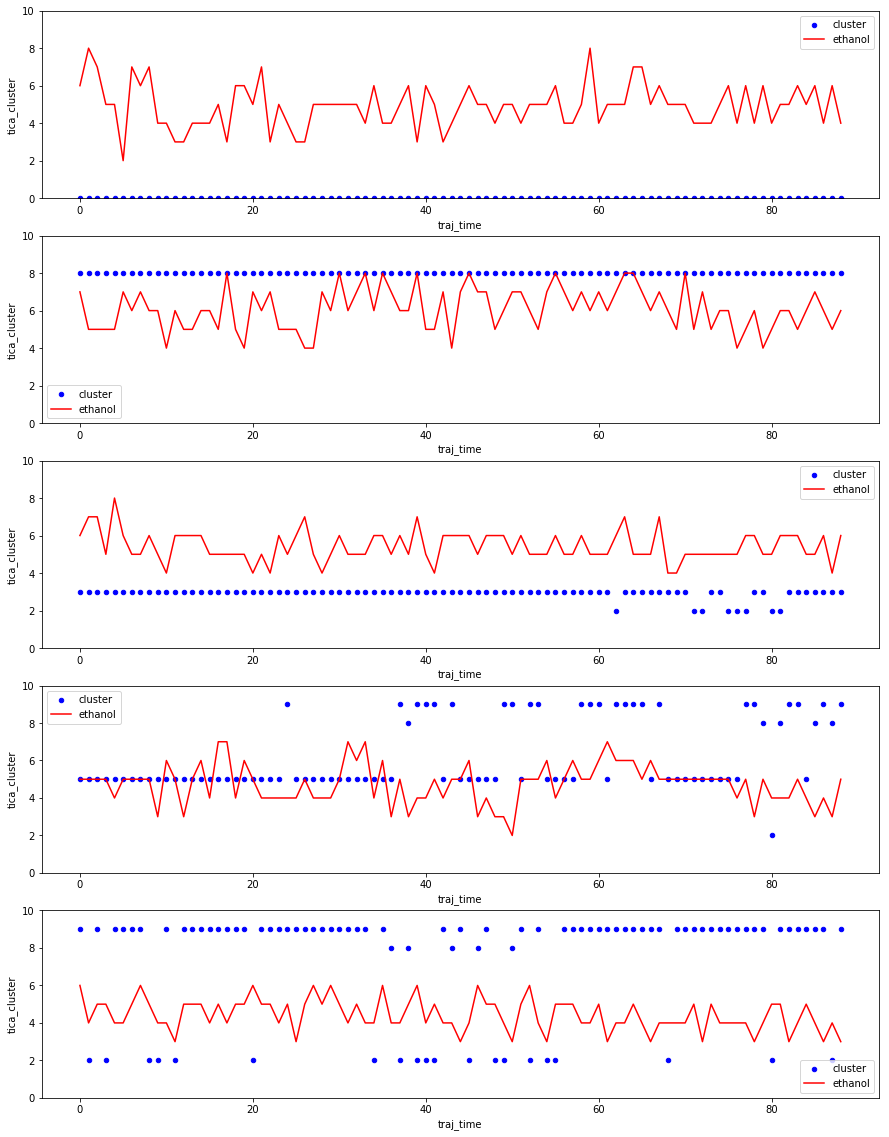

In [201]:
fig, ax = plt.subplots(5,figsize=(15, 20))
md_data[(md_data.system == 10) & (md_data.replicate == '3') & (md_data.subunit == 0)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[0],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '3')  & (md_data.subunit == 0)].plot(x='traj_time',y='intersubunit_hydration_right',ax=ax[0],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '3') & (md_data.subunit == 1)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[1],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '3')  & (md_data.subunit == 1)].plot(x='traj_time',y='intersubunit_hydration_right',ax=ax[1],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '3') & (md_data.subunit == 2)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[2],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '3')  & (md_data.subunit == 2)].plot(x='traj_time',y='intersubunit_hydration_right',ax=ax[2],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '3') & (md_data.subunit == 3)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[3],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '3')  & (md_data.subunit == 3)].plot(x='traj_time',y='intersubunit_hydration_right',ax=ax[3],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '3') & (md_data.subunit == 4)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[4],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '3')  & (md_data.subunit == 4)].plot(x='traj_time',y='intersubunit_hydration_right',ax=ax[4],label='ethanol',c='red')
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)
ax[4].set_ylim(0,10)


In [151]:
traj_notes = ['4HFI_pH70_md1','4HFI_F238L_pH70_md1','4HFI_I233T_pH70_md1','4HFI_F238LI233T_pH70_md1']

In [152]:
notation_changer = ['4HFI_pH70_md1','4HFI_F238L_pH70_md1','4HFI_I233T_pH70_md1','4HFI_F238LI233T_pH70_md1']

In [53]:
md_data = create_md_dataframe()
create_metadata(md_data)
create_system_notation(md_data)
create_cppca_data(md_data)

In 4HFI_pH70_md1, simulation runs 190 ns.
In 4HFI_F238L_pH70_md1, simulation runs 860 ns.
In 4HFI_I233T_pH70_md1, simulation runs 810 ns.
In 4HFI_F238LI233T_pH70_md1, simulation runs 200 ns.
[ 0.5321185   0.21386905]
[ 0.67002475  0.20237753]


In [55]:
create_rmsd_data(md_data)
create_helix_tilt_data(md_data)
create_helix_twist_data(md_data)
create_M2_M1_distance(md_data)
create_M1_kink(md_data)
create_M2_kink(md_data)

In [153]:
md_data = pd.read_pickle('glic_activation_subunit_opentoclose.pickle')

In [56]:
create_intersubunit_hydration_data(md_data)

In [57]:
create_intrasubunit_hydration_data(md_data)

In [154]:
create_tica_cluster_data(md_data)

In [60]:
create_beta_expansion(md_data)

In [155]:
md_data.to_pickle('glic_activation_subunit_opentoclose.pickle')

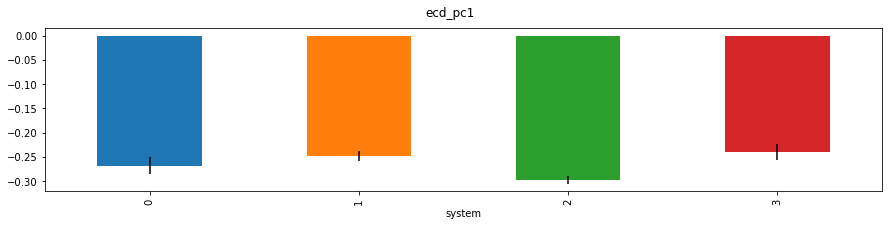

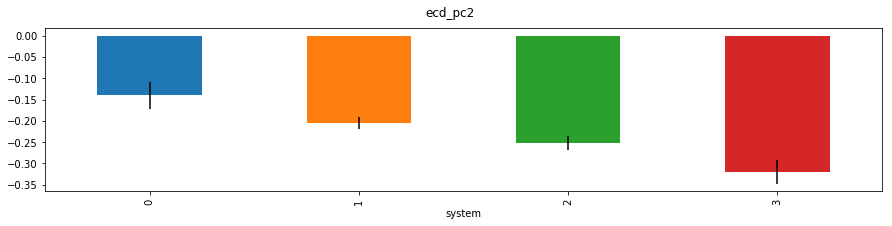

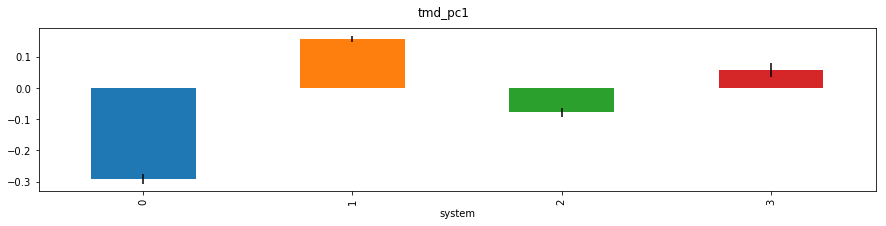

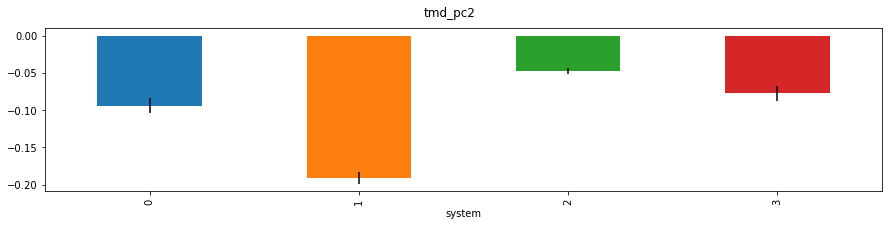

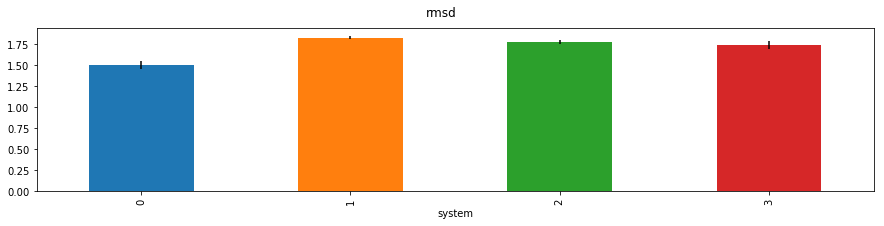

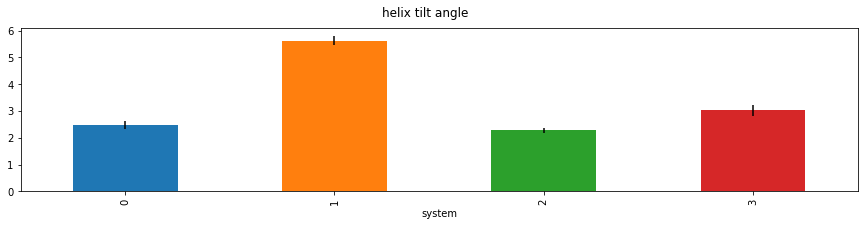

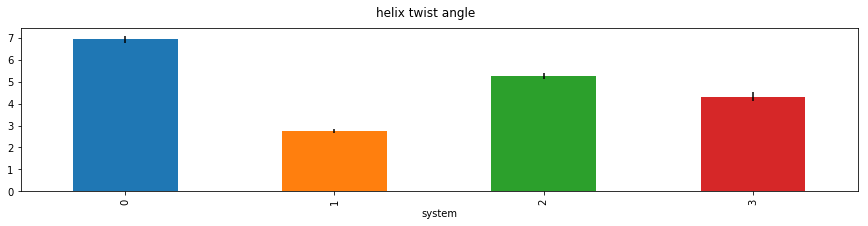

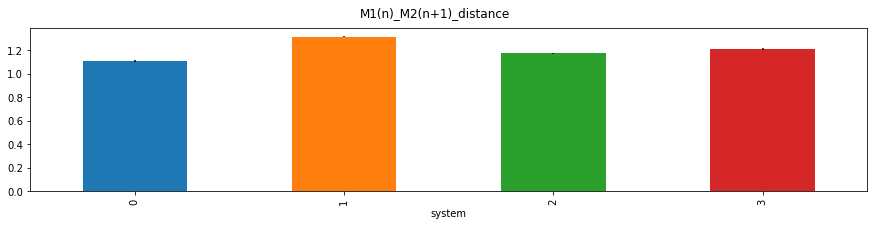

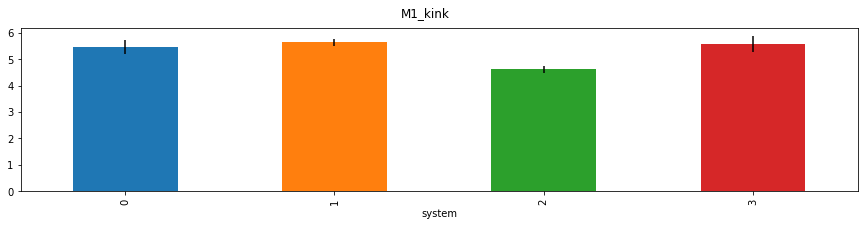

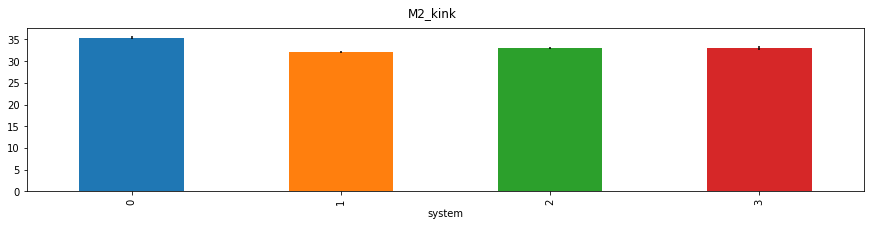

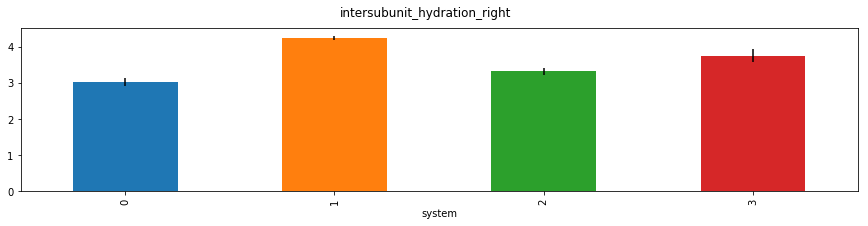

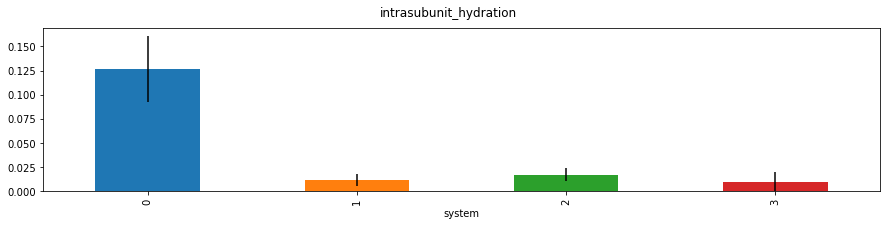

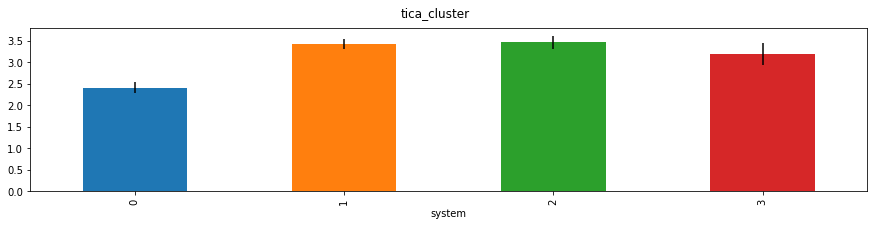

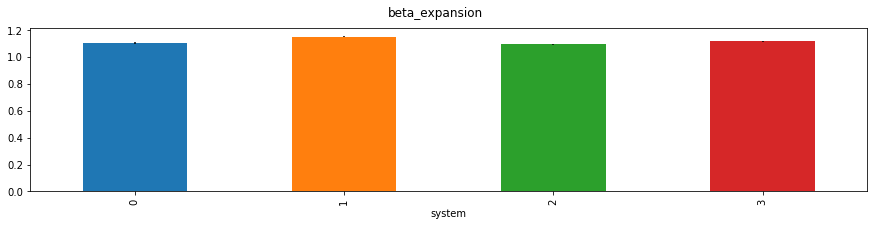

In [156]:
for feature in md_data.columns[6:]:
    fig, ax = plt.subplots(figsize=(15, 3))
#        md_data_235[md_data_235.replicate == '4'].plot(x='traj_time',y=feature,ax=ax[0],label='4',c='blue')
#        md_data_235[md_data_235.replicate == '5'].plot(x='traj_time',y=feature,ax=ax[0],label='5',c='blue')
#        md_data_235[md_data_235.replicate == '6'].plot(x='traj_time',y=feature,ax=ax[0],label='6',c='blue')
#        md_data_235[md_data_235.replicate == '7'].plot(x='traj_time',y=feature,ax=ax[0],label='7',c='red')
#        md_data_235[md_data_235.replicate == '8'].plot(x='traj_time',y=feature,ax=ax[0],label='8',c='red')
#        md_data_235[md_data_235.replicate == '9'].plot(x='traj_time',y=feature,ax=ax[0],label='9',c='red')
#        ax[0].set_xlim(0,90)
    fig.suptitle(feature)
    group = md_data.groupby(['system'],sort=False)[feature]
    mean = group.mean()
    errors = group.sem()
    mean.plot.bar(yerr=errors,ax=ax)
#    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


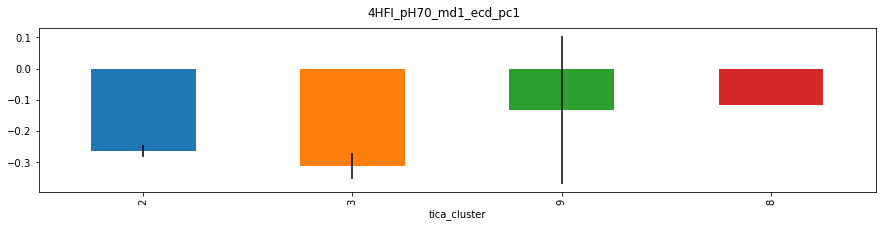

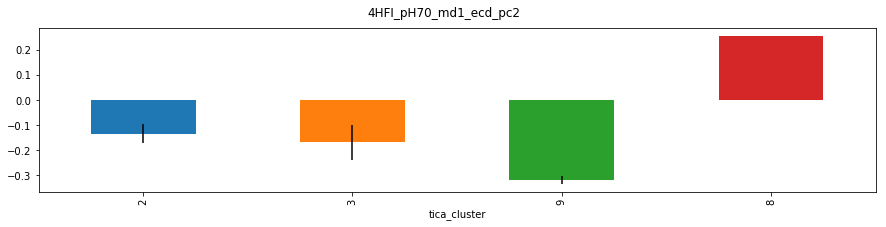

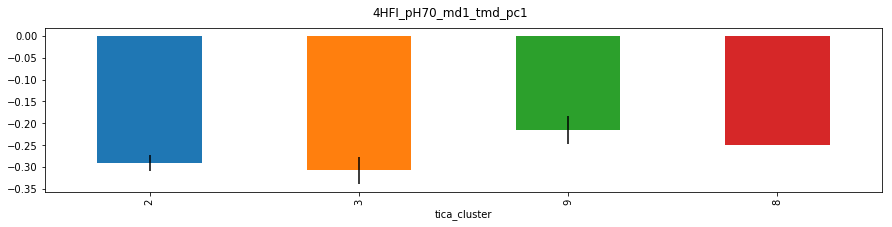

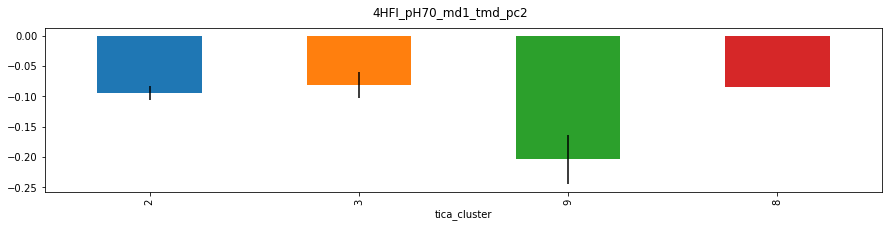

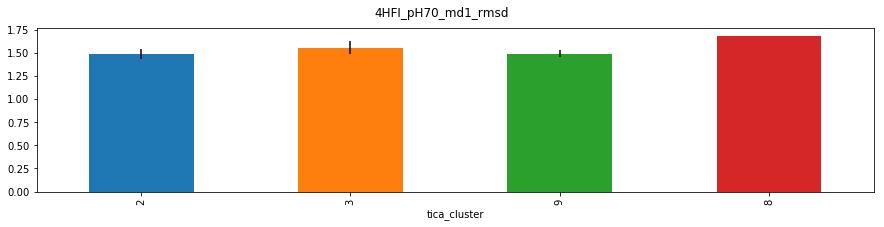

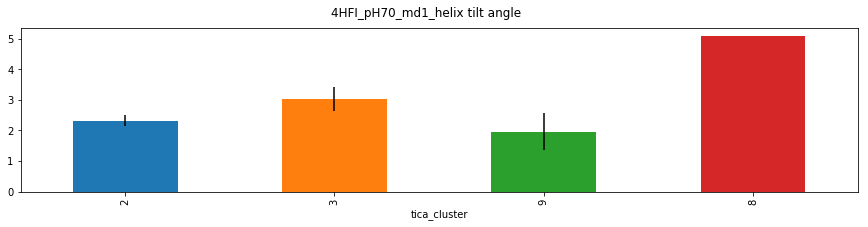

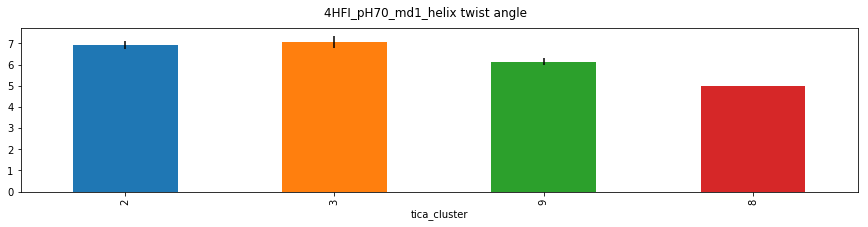

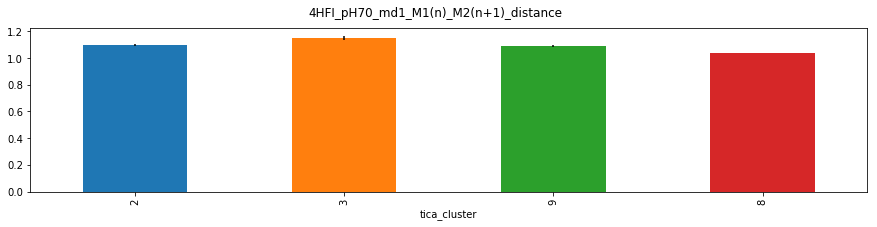

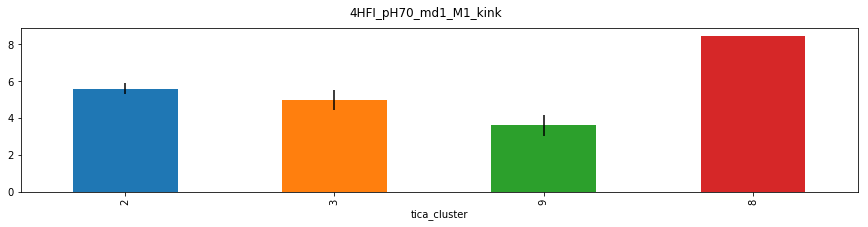

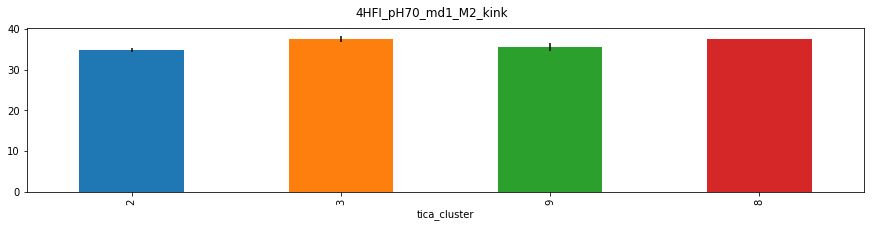

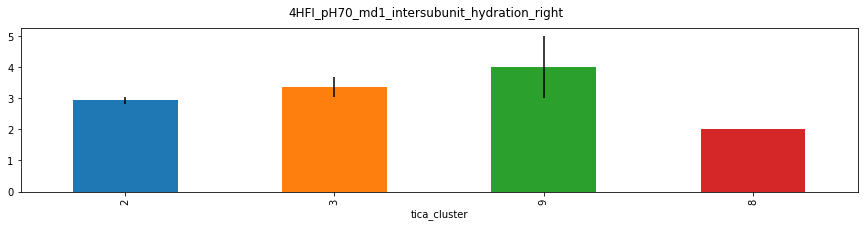

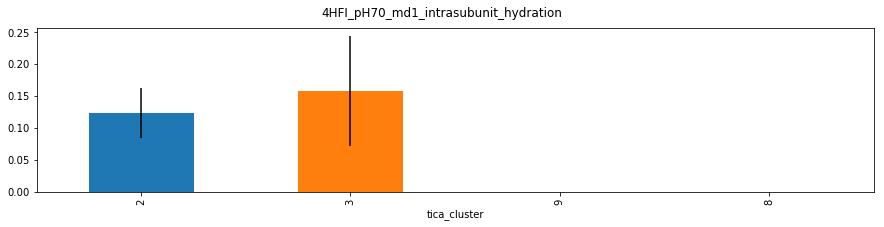

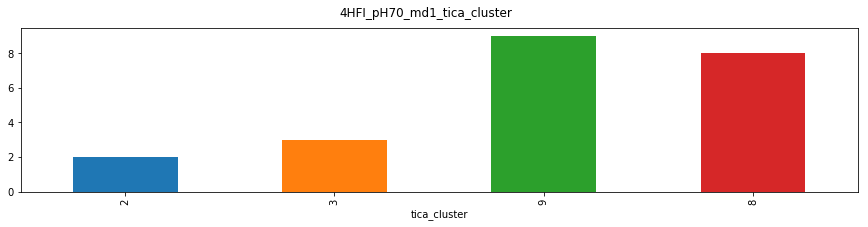

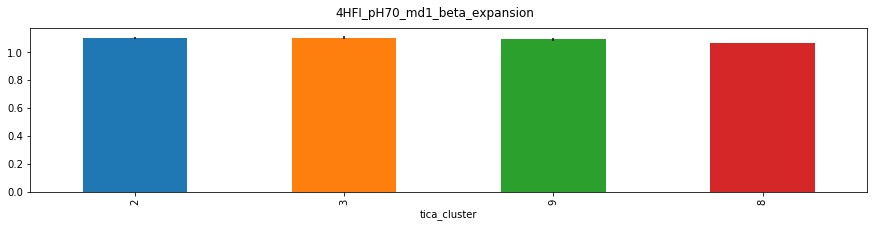

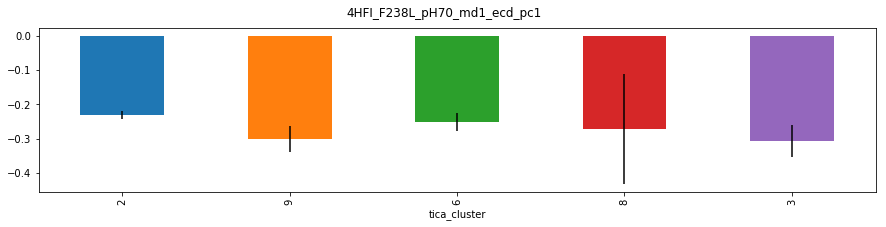

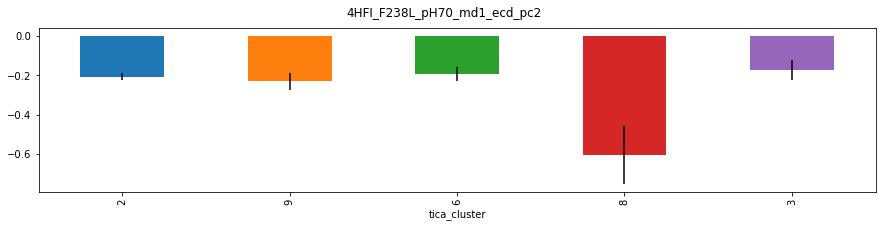

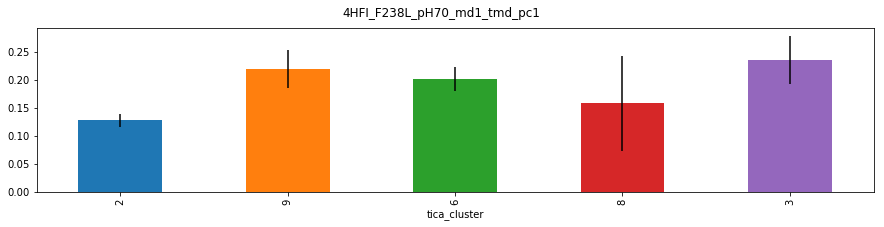

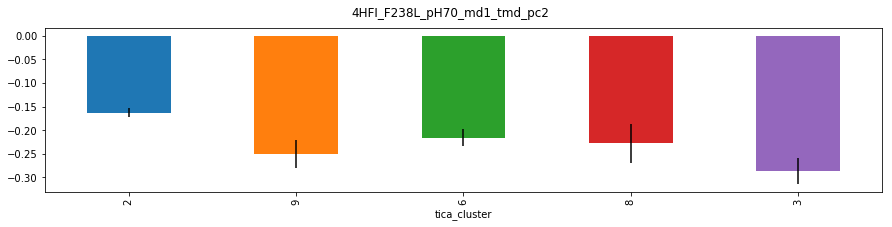

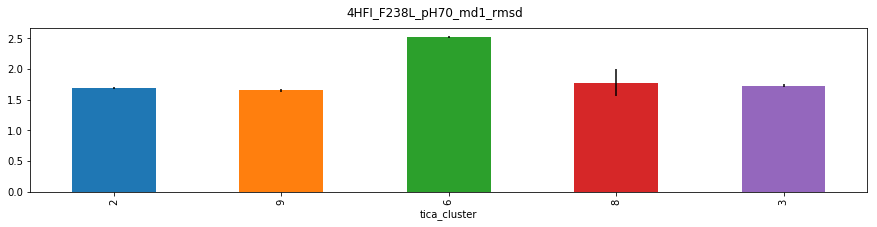

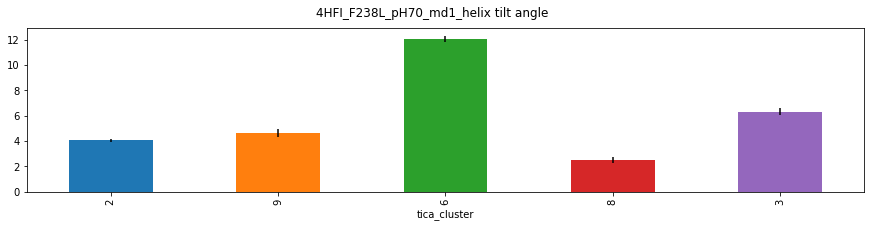

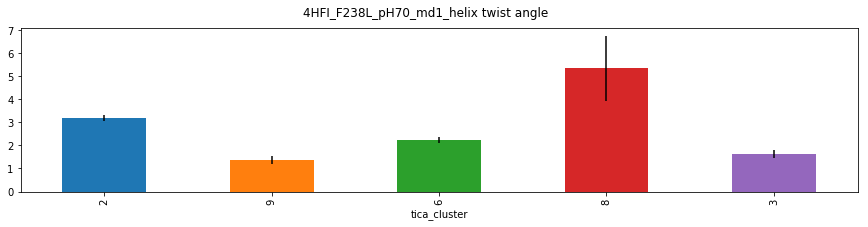

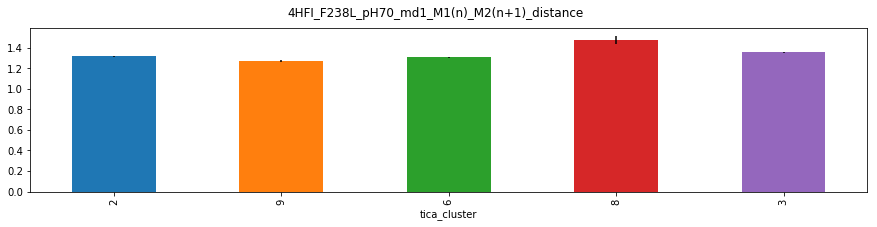

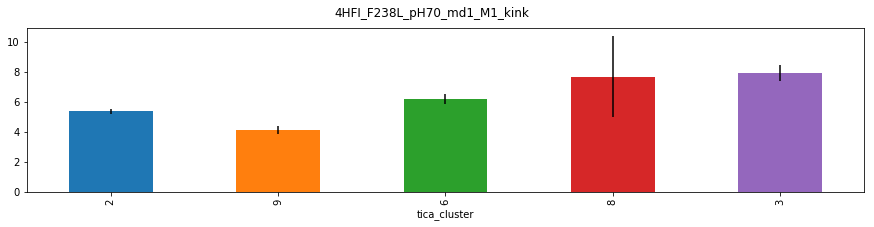

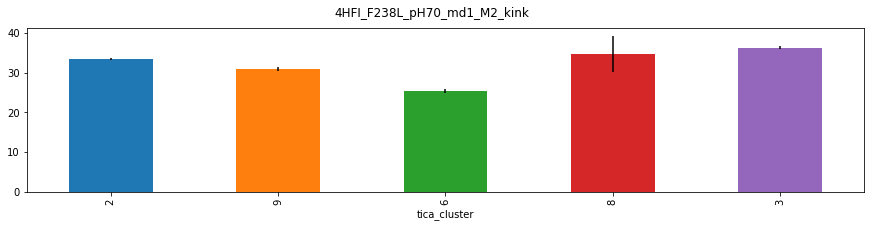

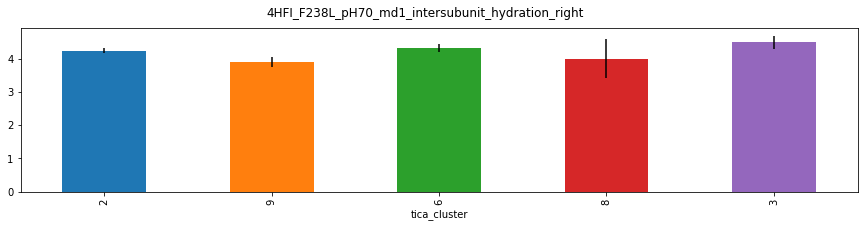

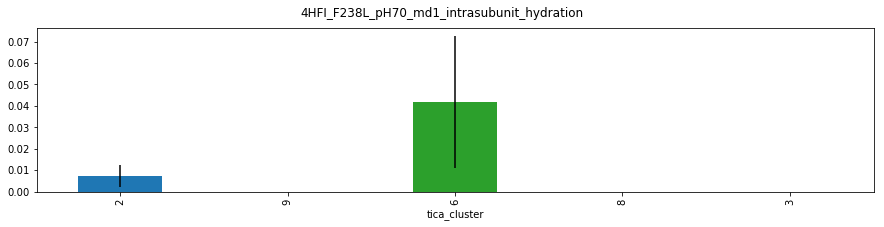

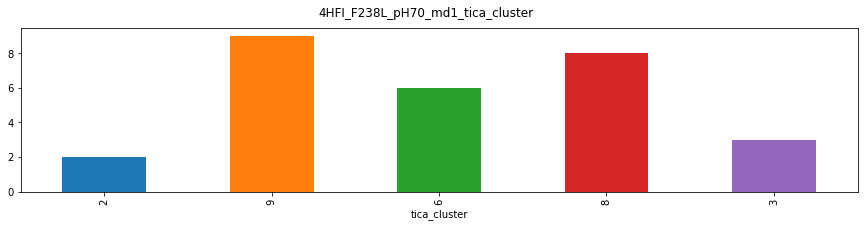

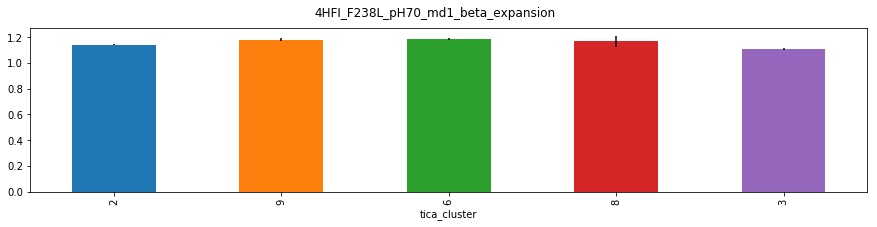

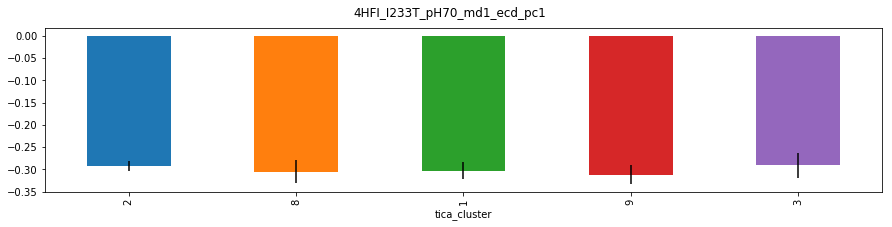

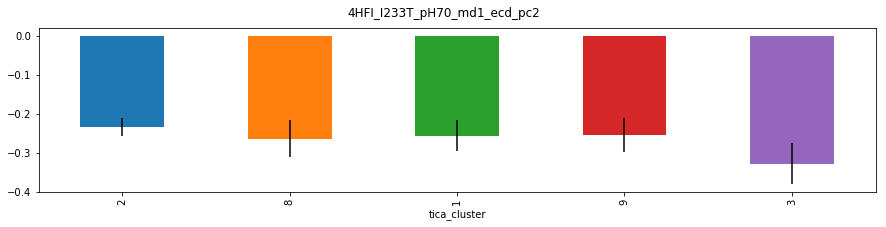

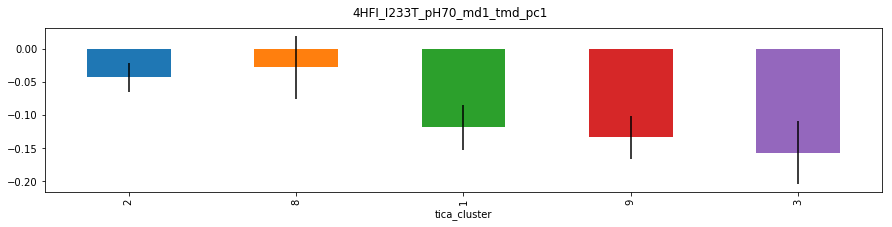

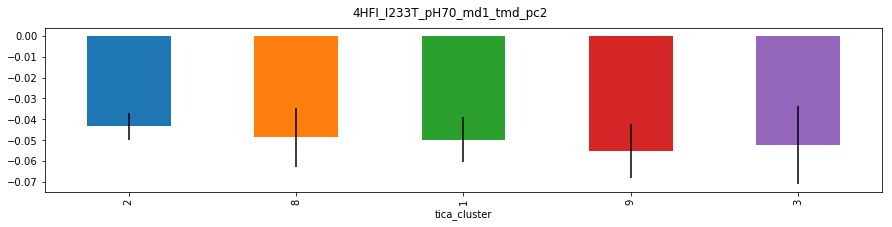

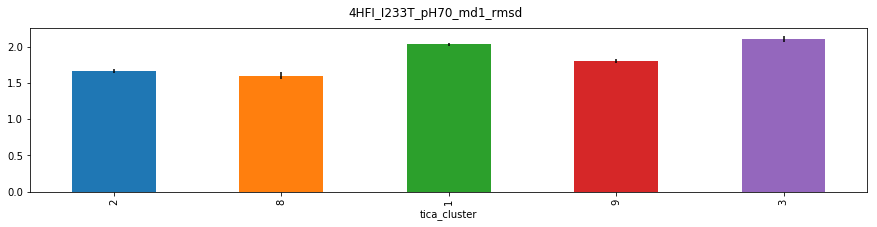

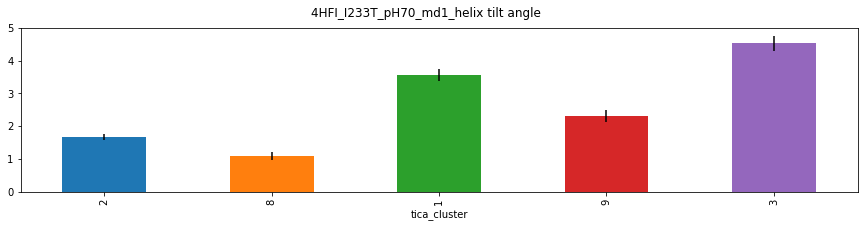

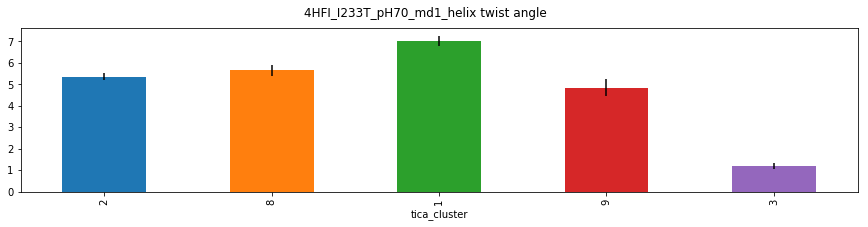

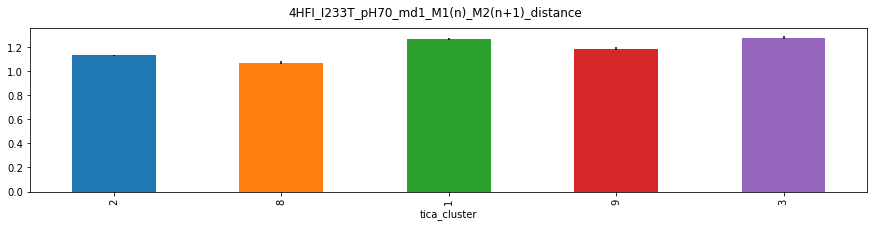

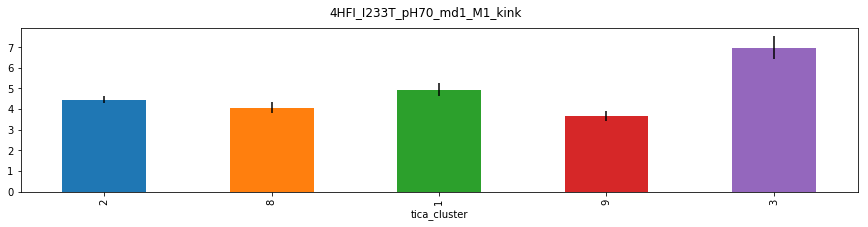

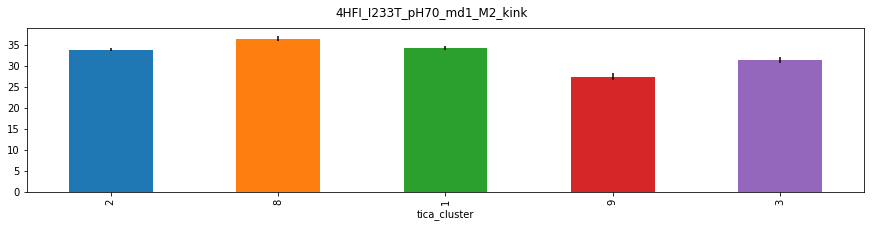

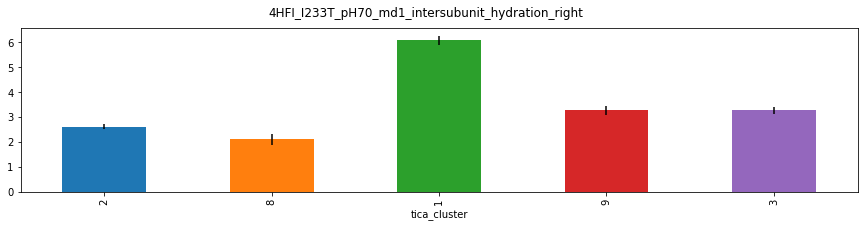

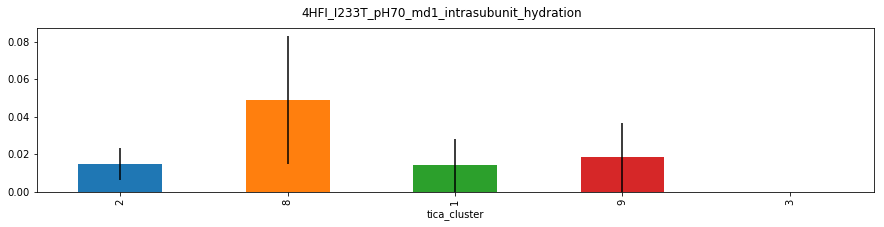

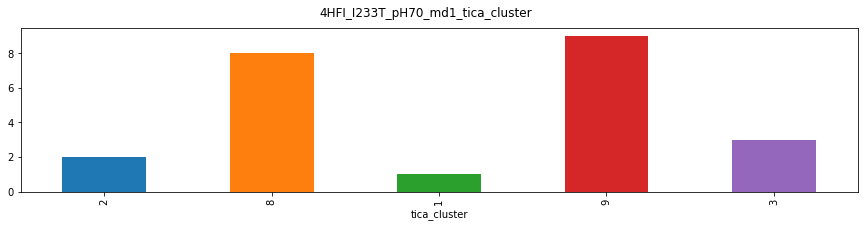

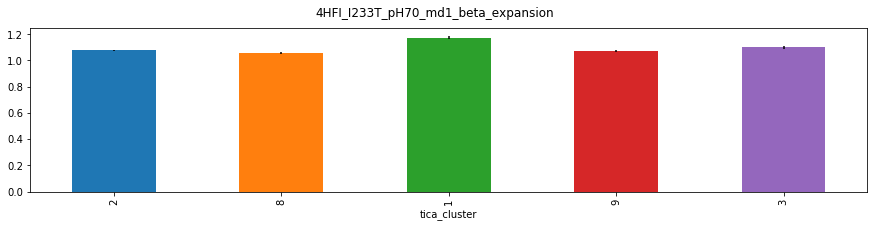

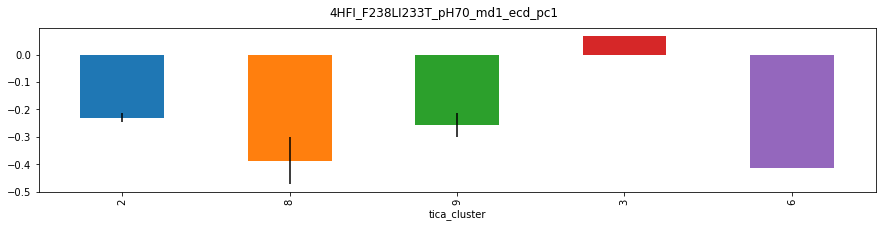

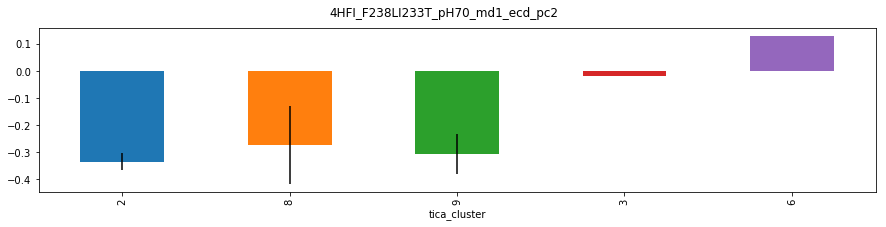

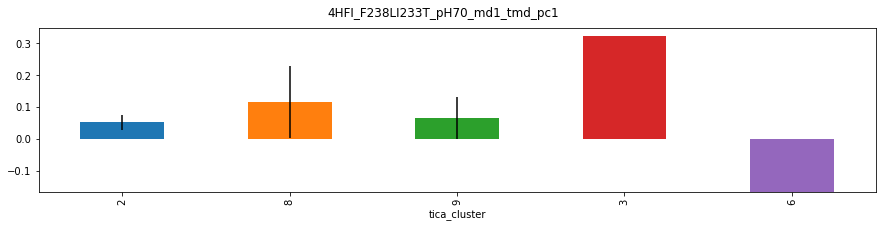

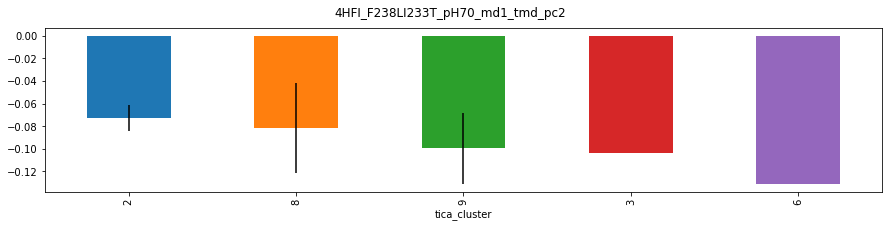

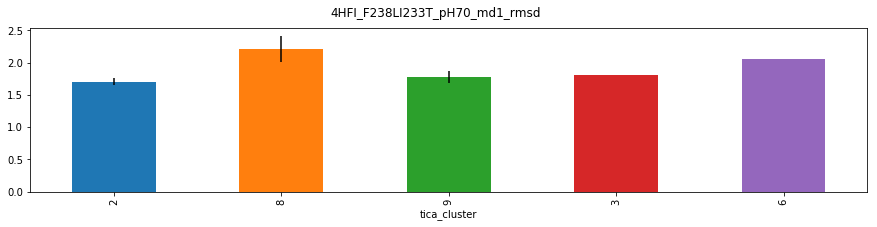

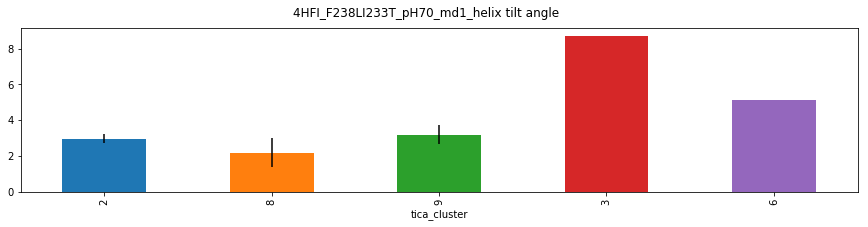

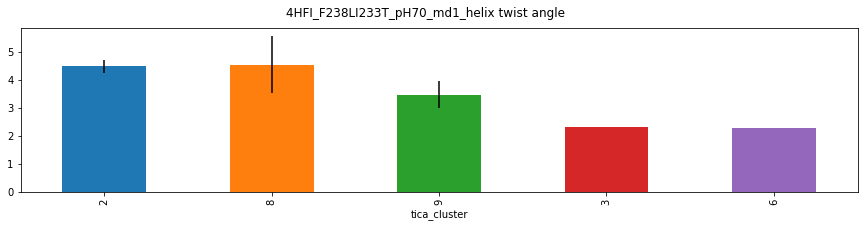

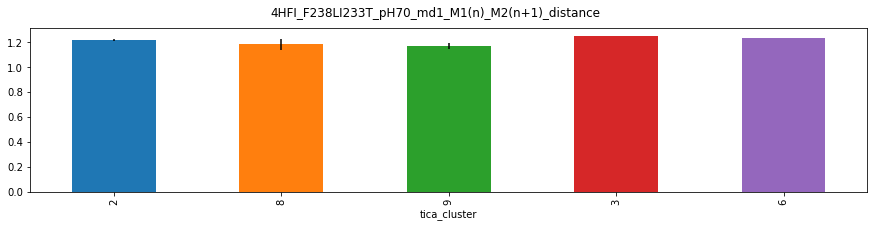

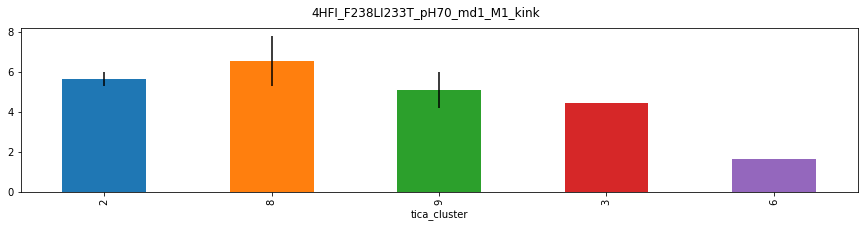

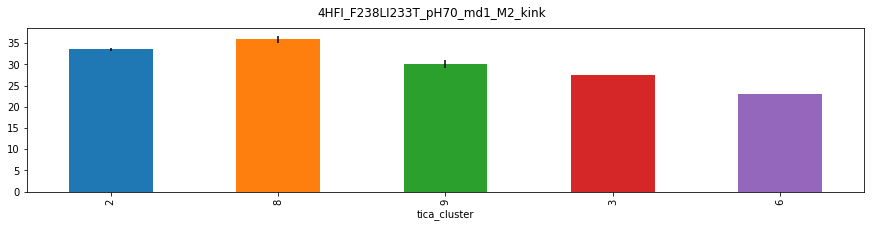

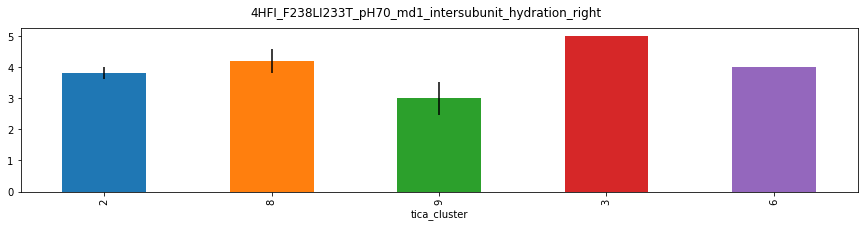

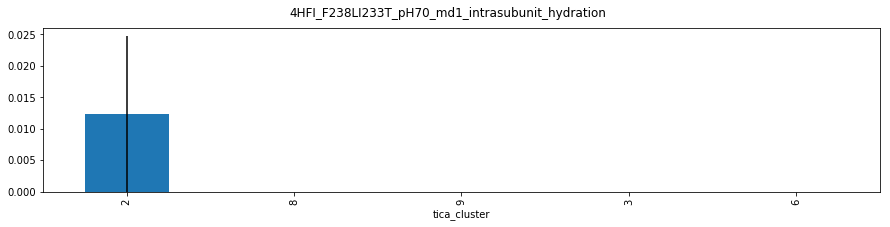

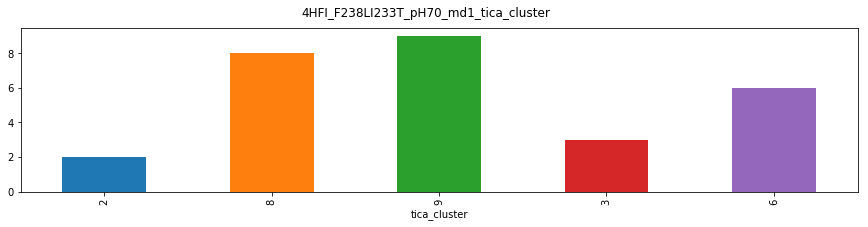

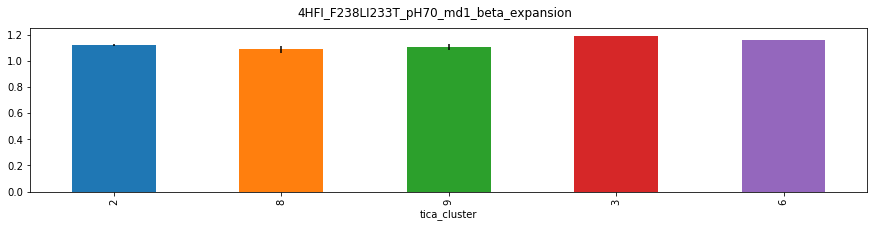

In [157]:
for system in sorted(set(md_data.system)):
    for feature in md_data.columns[6:]:

        fig, ax = plt.subplots(figsize=(15, 3))
        fig.suptitle(notation_changer[system] + '_' + feature)
        group = md_data[(md_data.system == system)].groupby(['tica_cluster'],sort=False)[feature]
        mean = group.mean()
        errors = group.sem()
        mean.plot.bar(yerr=errors,ax=ax)
#    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


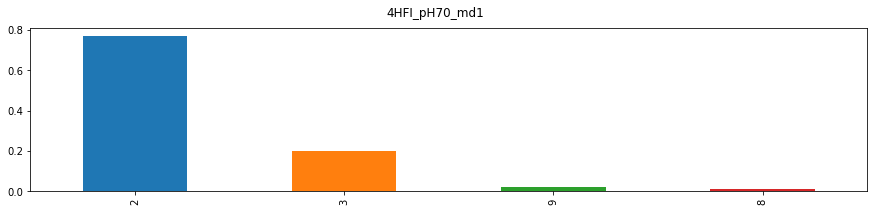

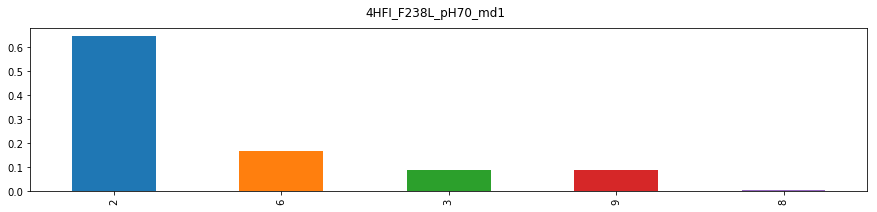

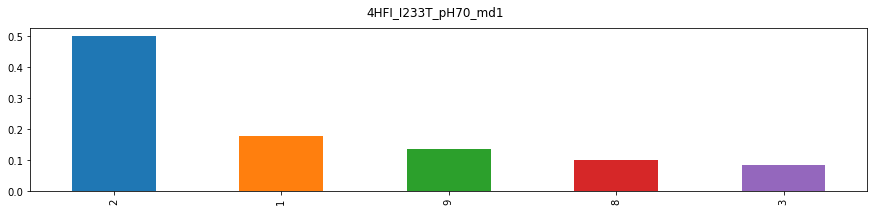

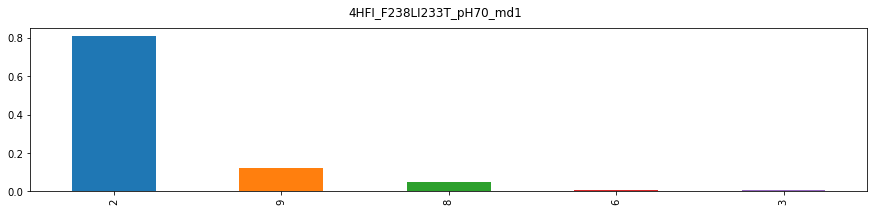

In [158]:
for system in sorted(set(md_data.system)):
    fig, ax = plt.subplots(figsize=(15, 3))
    fig.suptitle(notation_changer[system])
    group = md_data[(md_data.system == system)]['tica_cluster']
    mean = group.value_counts(normalize=True)
#    errors = group.sem()
    mean.plot.bar(ax=ax)
#    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


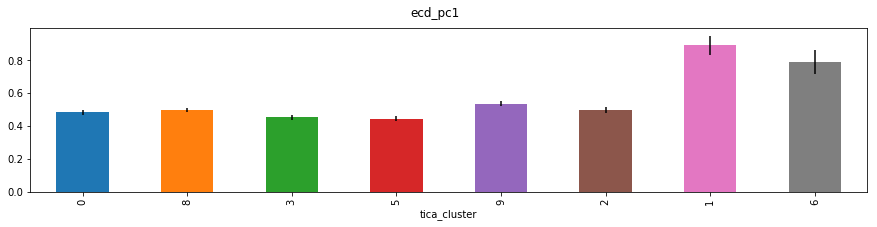

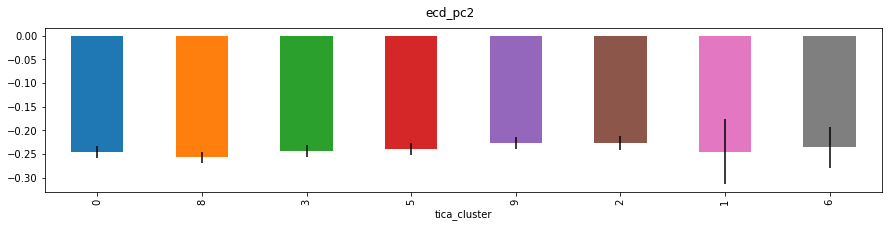

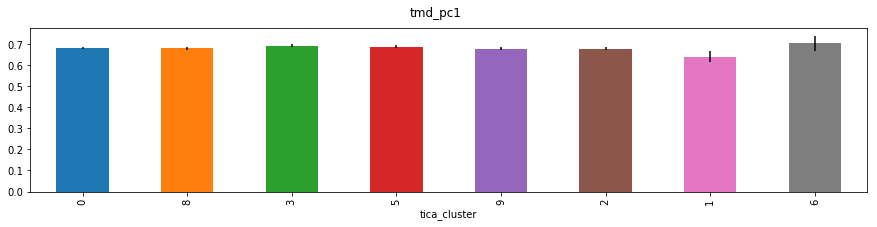

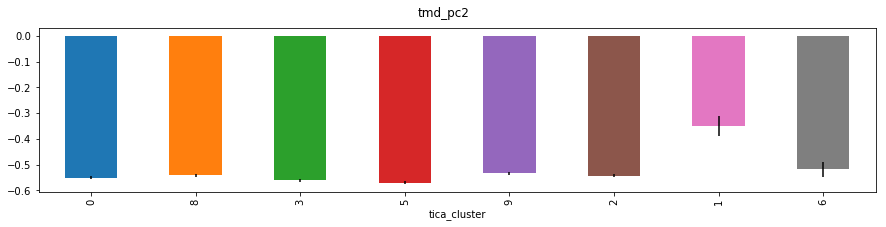

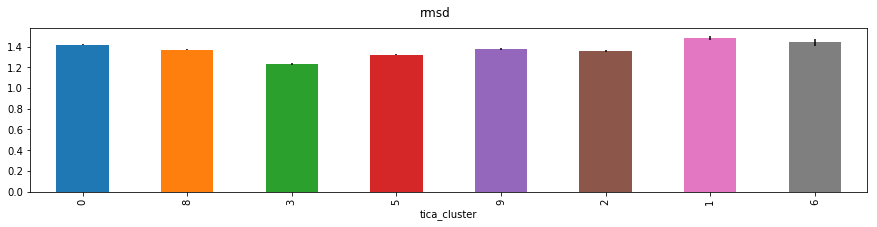

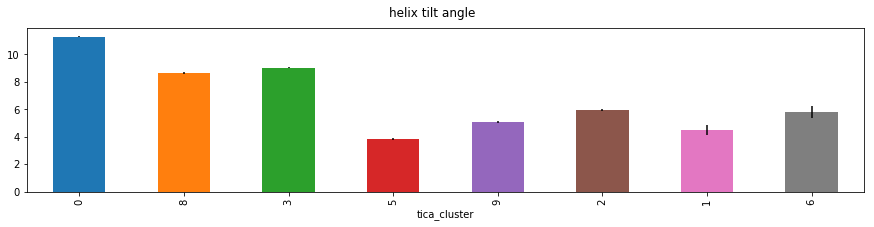

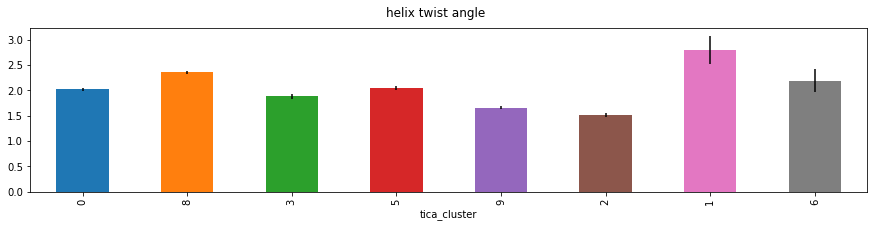

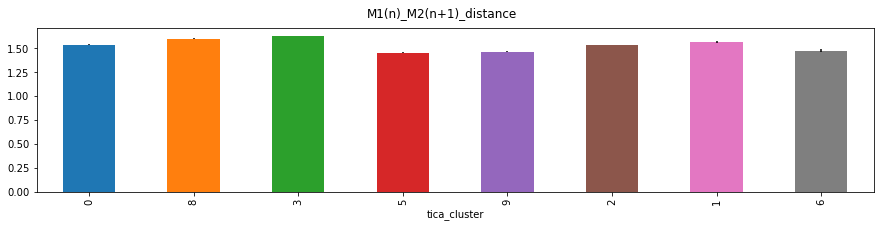

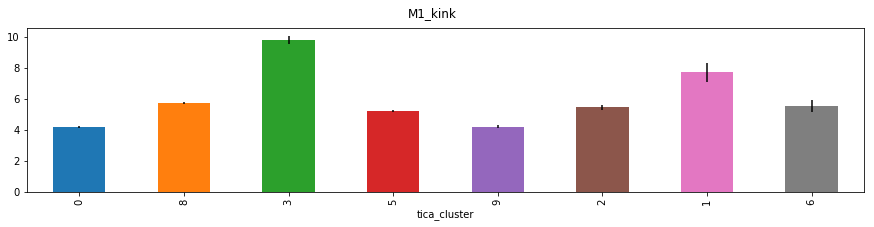

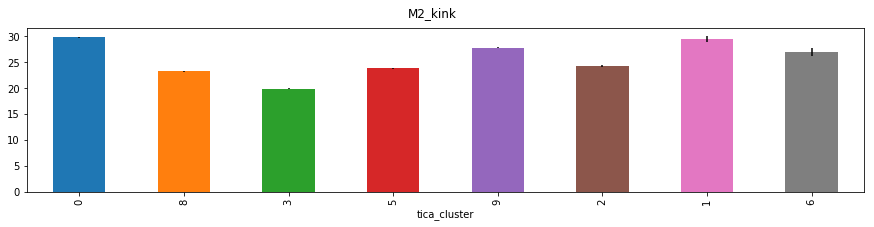

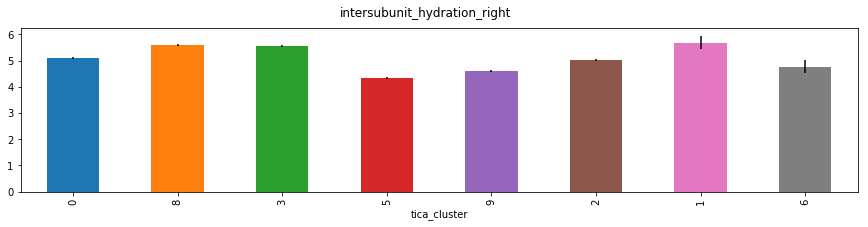

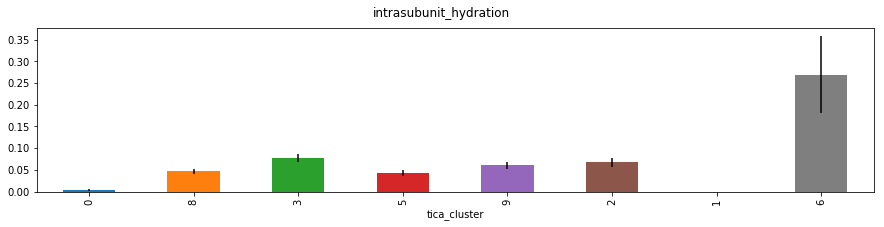

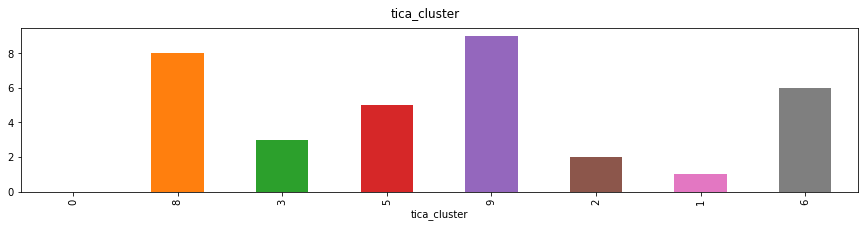

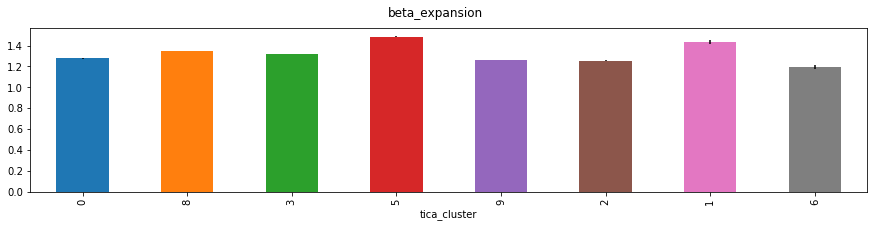

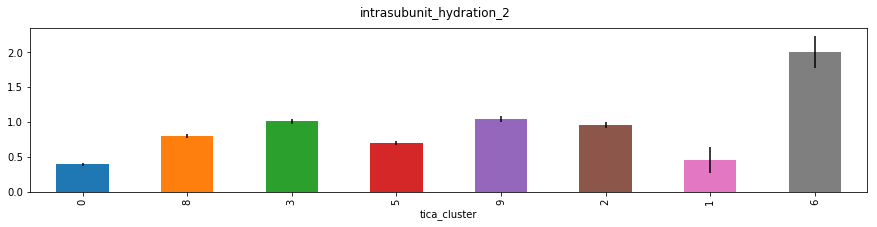

In [262]:
for feature in md_data.columns[6:]:

    fig, ax = plt.subplots(figsize=(15, 3))
    fig.suptitle(feature)
    group = md_data[md_data.system.isin(['8','9','10','11'])].groupby(['tica_cluster'],sort=False)[feature]
    mean = group.mean()
    errors = group.sem()
    mean.plot.bar(yerr=errors,ax=ax)
#    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


In [208]:
traj_notes =  [
              '4HFI_pH46_ethanol_md1','4HFI_pH46_ethanol_md2','4HFI_pH46_ethanol_md3',
                '4HFI_F238L_pH46_ethanol_md4','4HFI_F238L_pH46_ethanol_md5','4HFI_F238L_pH46_ethanol_md6','4HFI_F238L_pH46_ethanol_md1',
              '4HFI_I233T_pH46_ethanol_md1','4HFI_I233T_pH46_ethanol_md2','4HFI_I233T_pH46_ethanol_md3',
                '4HFI_F238LI233T_pH46_ethanol_md1','4HFI_F238LI233T_pH46_ethanol_md2','4HFI_F238LI233T_pH46_ethanol_md3',
              '4HFI_pH70_ethanol_md1',
              '4HFI_F238L_pH70_ethanol_md1',
              '4HFI_I233T_pH70_ethanol_md1',
              '4HFI_F238LI233T_pH70_ethanol_md1',
               '4NPQ_pH70_ethanol_md1','4NPQ_pH70_ethanol_md2','4NPQ_pH70_ethanol_md3',
              '4NPQ_F238L_pH70_ethanol_md1','4NPQ_F238L_pH70_ethanol_md2','4NPQ_F238L_pH70_ethanol_md3',
               '4NPQ_I233T_pH70_ethanol_md1','4NPQ_I233T_pH70_ethanol_md2','4NPQ_I233T_pH70_ethanol_md3',
                '4NPQ_F238LI233T_pH70_ethanol_md1','4NPQ_F238LI233T_pH70_ethanol_md2','4NPQ_F238LI233T_pH70_ethanol_md3']


In [209]:
notation_changer = [
                   '4HFI_pH46_ethanol_md1',
                '4HFI_F238L_pH46_ethanol_md4','4HFI_F238L_pH46_ethanol_md1',
              '4HFI_I233T_pH46_ethanol_md1',
                '4HFI_F238LI233T_pH46_ethanol_md1',
              '4HFI_pH70_ethanol_md1',
              '4HFI_F238L_pH70_ethanol_md1',
              '4HFI_I233T_pH70_ethanol_md1',
              '4HFI_F238LI233T_pH70_ethanol_md1',
               '4NPQ_pH70_ethanol_md1',
              '4NPQ_F238L_pH70_ethanol_md1',
               '4NPQ_I233T_pH70_ethanol_md1',
                '4NPQ_F238LI233T_pH70_ethanol_md1']

In [232]:
md_data = pd.read_pickle('glic_activation_subunit_ethanol.pickle')

In [77]:
md_data = create_md_dataframe()
create_metadata(md_data)
create_system_notation(md_data)
create_cppca_data(md_data)

In 4HFI_pH46_ethanol_md1, simulation runs 850.0 ns.
In 4HFI_pH46_ethanol_md2, simulation runs 560.0 ns.
In 4HFI_pH46_ethanol_md3, simulation runs 600.0 ns.
In 4HFI_F238L_pH46_ethanol_md4, simulation runs 550.0 ns.
In 4HFI_F238L_pH46_ethanol_md5, simulation runs 580.0 ns.
In 4HFI_F238L_pH46_ethanol_md6, simulation runs 590.0 ns.
In 4HFI_F238L_pH46_ethanol_md1, simulation runs 720.0 ns.
In 4HFI_I233T_pH46_ethanol_md1, simulation runs 500.0 ns.
In 4HFI_I233T_pH46_ethanol_md2, simulation runs 400.0 ns.
In 4HFI_I233T_pH46_ethanol_md3, simulation runs 410.0 ns.
In 4HFI_F238LI233T_pH46_ethanol_md1, simulation runs 370.0 ns.
In 4HFI_F238LI233T_pH46_ethanol_md2, simulation runs 410.0 ns.
In 4HFI_F238LI233T_pH46_ethanol_md3, simulation runs 400.0 ns.
In 4HFI_pH70_ethanol_md1, simulation runs 120.0 ns.
In 4HFI_F238L_pH70_ethanol_md1, simulation runs 660.0 ns.
In 4HFI_I233T_pH70_ethanol_md1, simulation runs 660.0 ns.
In 4HFI_F238LI233T_pH70_ethanol_md1, simulation runs 110.0 ns.
In 4NPQ_pH70_ethan

In [78]:
create_rmsd_data(md_data)
create_helix_tilt_data(md_data)
create_helix_twist_data(md_data)
create_M2_M1_distance(md_data)
create_M1_kink(md_data)
create_M2_kink(md_data)

In [ ]:
create_intersubunit_ethanol_data(md_data)

In [108]:
create_intersubunit_ethanol_data_2(md_data)

In [109]:
create_intersubunit_ethanol_data_5(md_data)

In [110]:
create_intrasubunit_ethanol_data(md_data)

In [185]:
create_intrasubunit_ethanol_data_2(md_data)

In [220]:
create_intrasubunit_ethanol_data_3(md_data)

In [163]:
create_tica_cluster_data(md_data)

In [164]:
create_beta_expansion(md_data)

In [223]:
md_data.to_pickle('glic_activation_subunit_ethanol.pickle')

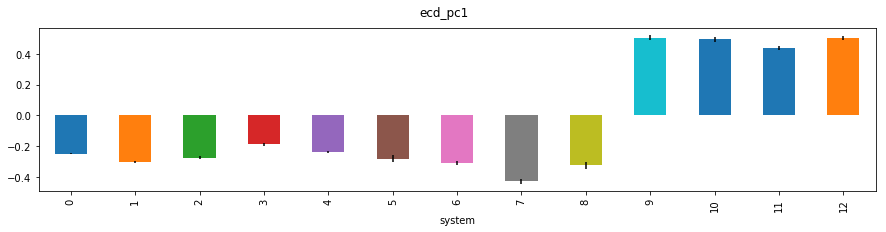

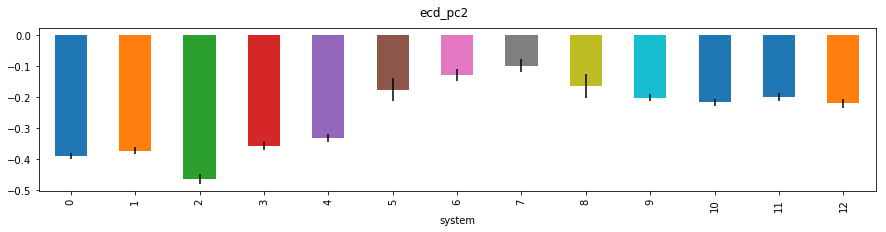

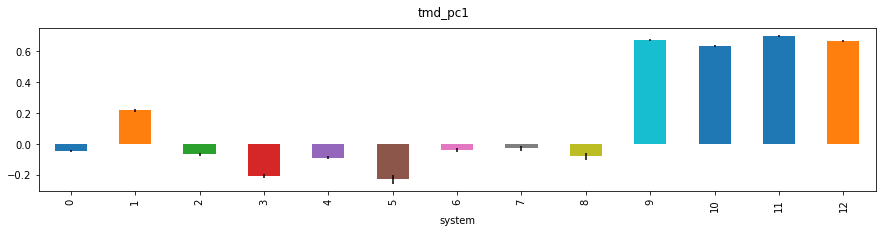

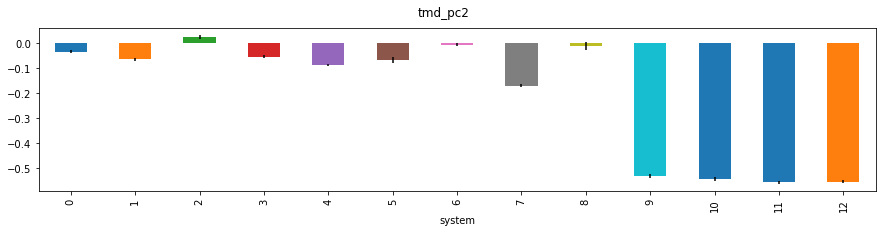

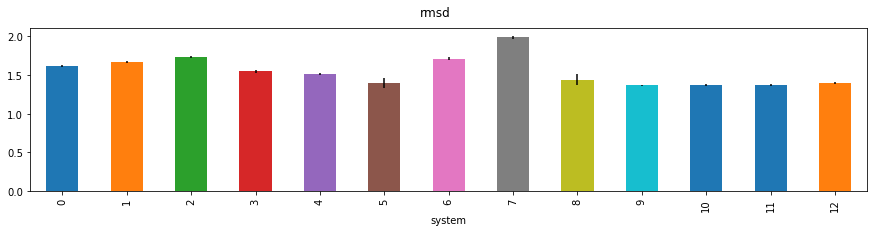

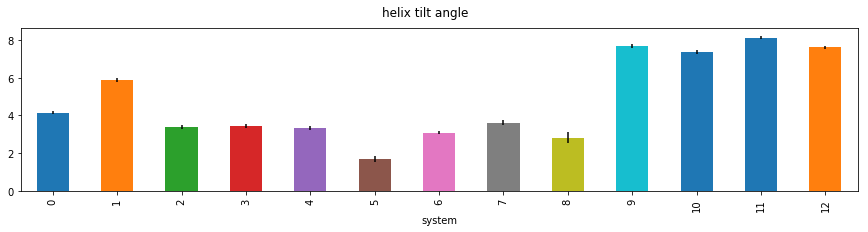

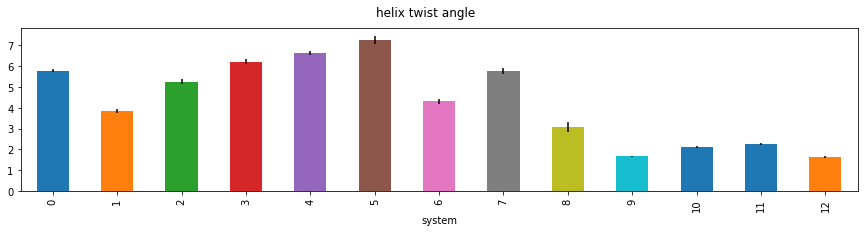

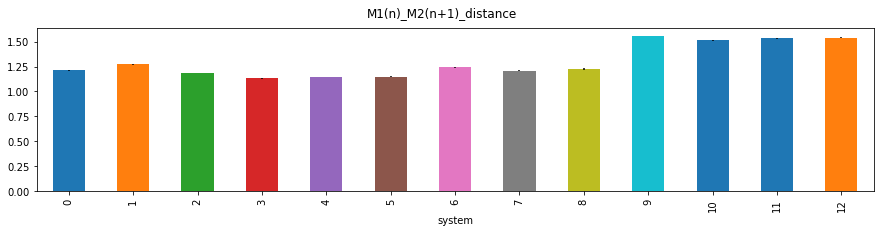

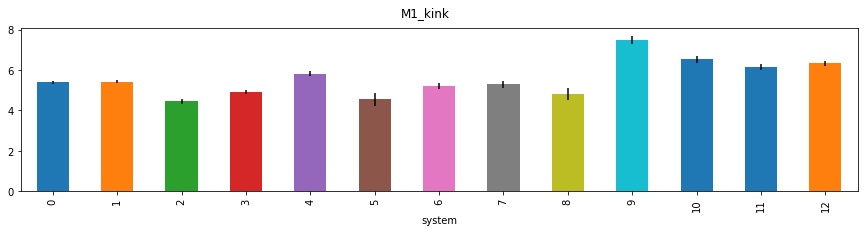

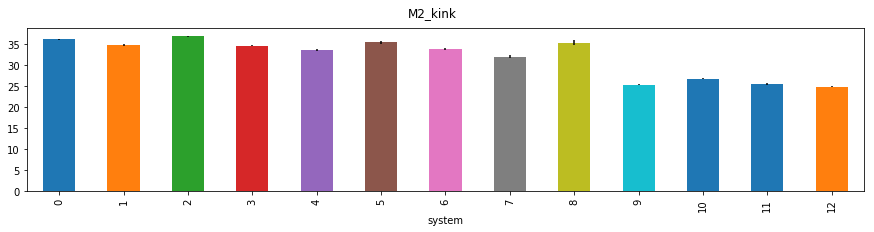

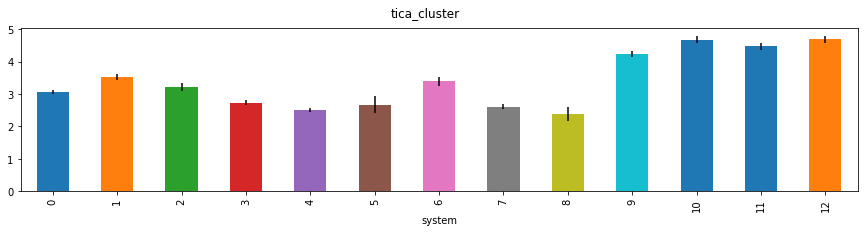

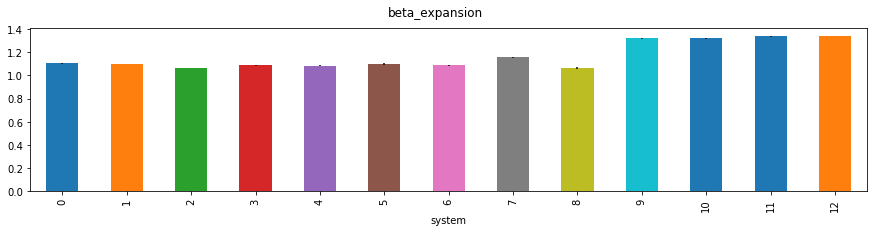

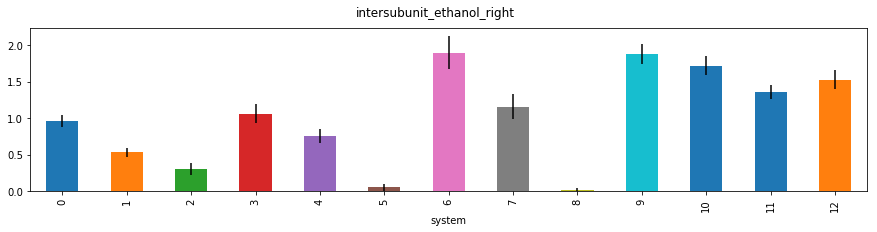

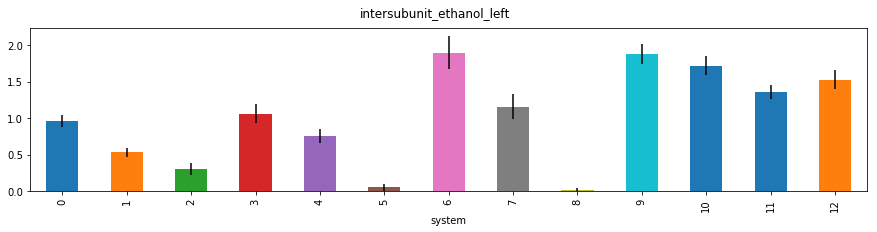

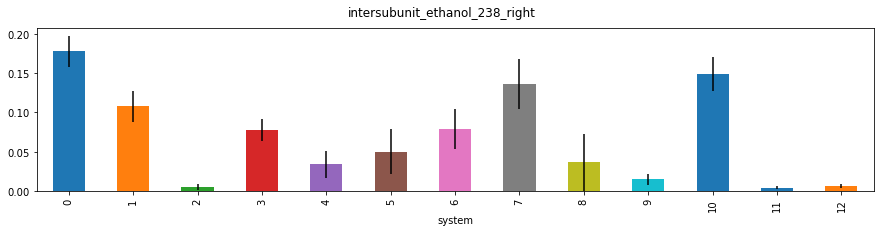

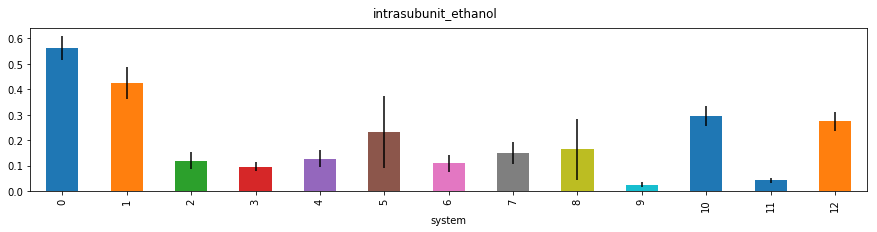

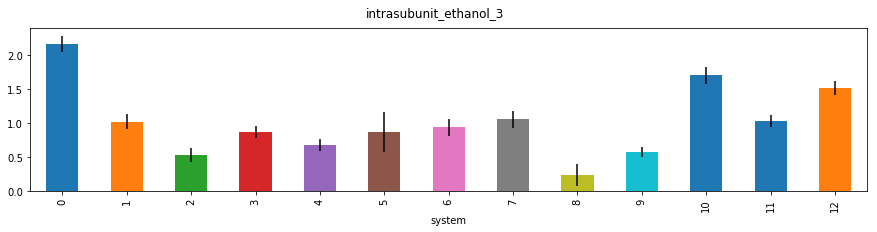

In [222]:
for feature in md_data.columns[6:]:
    fig, ax = plt.subplots(figsize=(15, 3))
#        md_data_235[md_data_235.replicate == '4'].plot(x='traj_time',y=feature,ax=ax[0],label='4',c='blue')
#        md_data_235[md_data_235.replicate == '5'].plot(x='traj_time',y=feature,ax=ax[0],label='5',c='blue')
#        md_data_235[md_data_235.replicate == '6'].plot(x='traj_time',y=feature,ax=ax[0],label='6',c='blue')
#        md_data_235[md_data_235.replicate == '7'].plot(x='traj_time',y=feature,ax=ax[0],label='7',c='red')
#        md_data_235[md_data_235.replicate == '8'].plot(x='traj_time',y=feature,ax=ax[0],label='8',c='red')
#        md_data_235[md_data_235.replicate == '9'].plot(x='traj_time',y=feature,ax=ax[0],label='9',c='red')
#        ax[0].set_xlim(0,90)
    fig.suptitle(feature)
    group = md_data.groupby(['system'],sort=False)[feature]
    mean = group.mean()
    errors = group.sem()
    mean.plot.bar(yerr=errors,ax=ax)
#    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


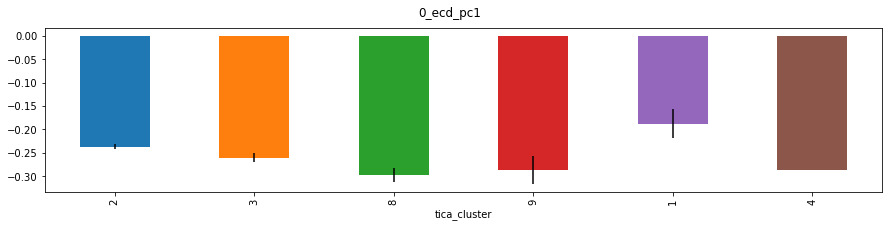

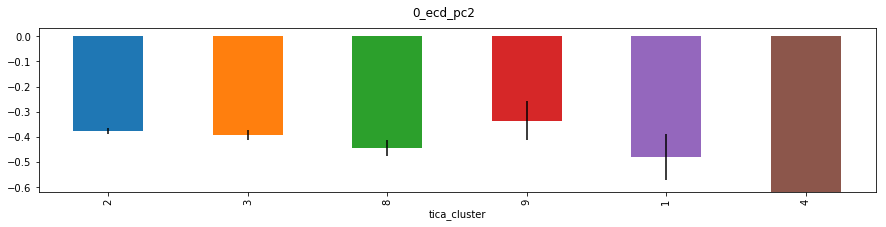

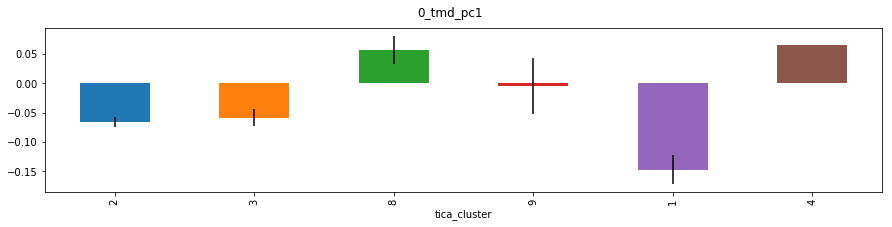

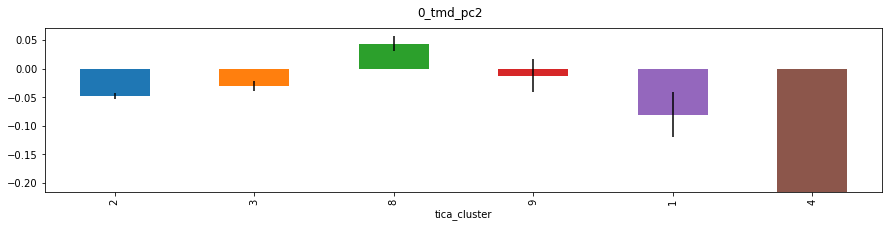

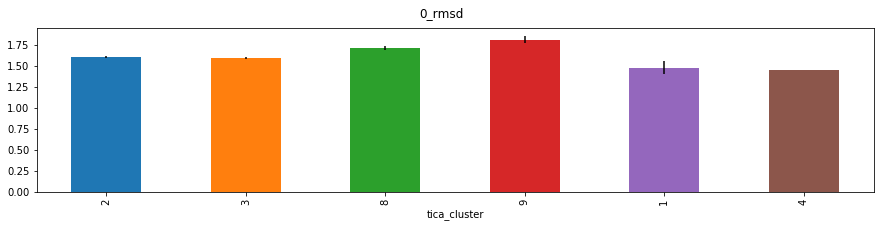

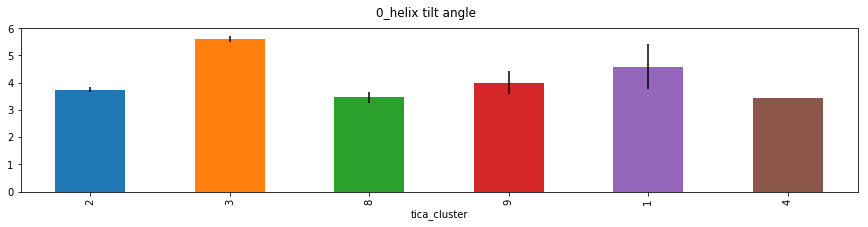

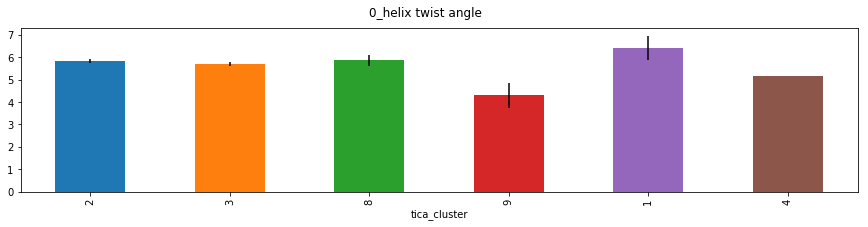

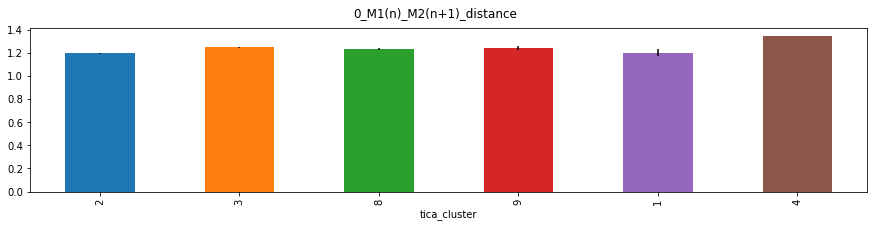

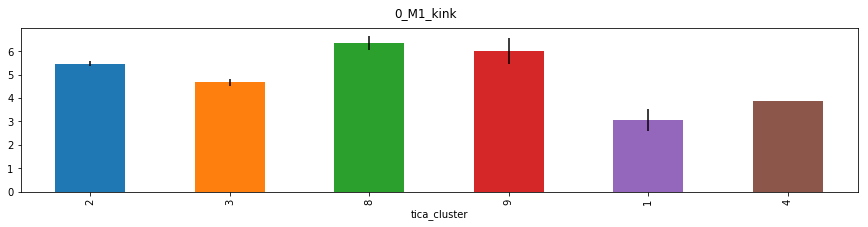

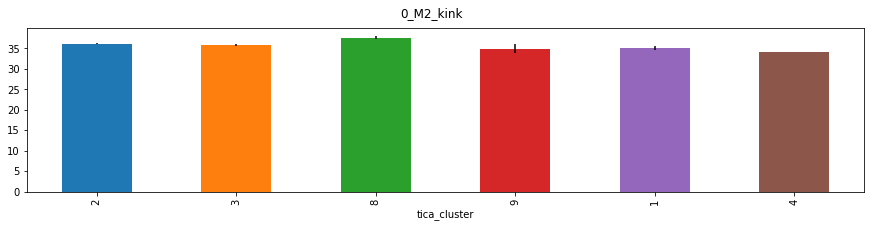

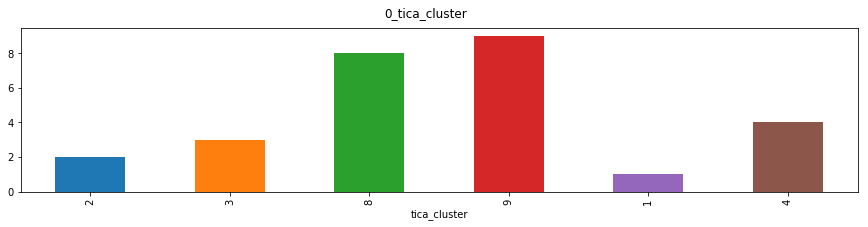

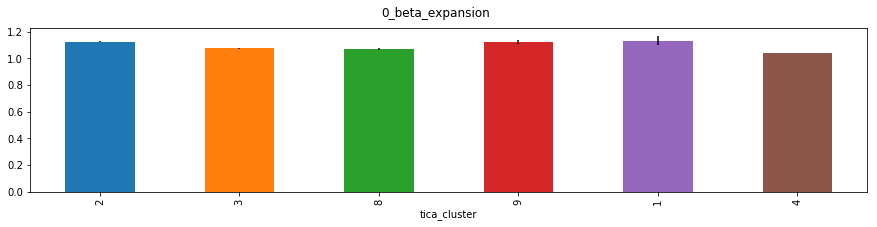

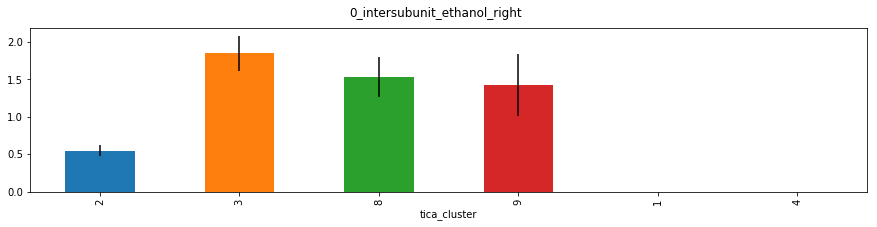

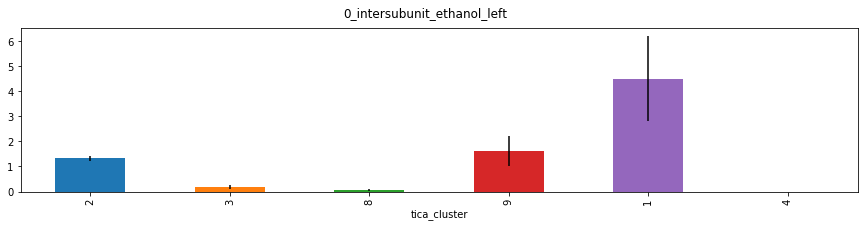

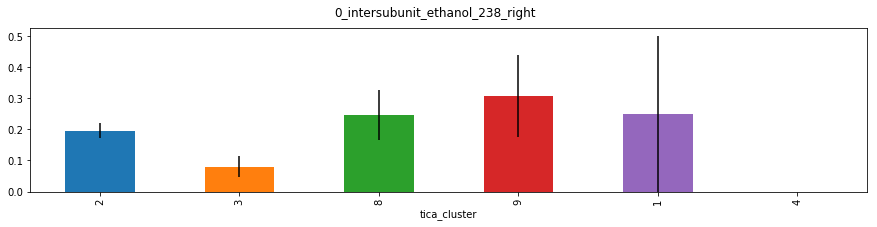

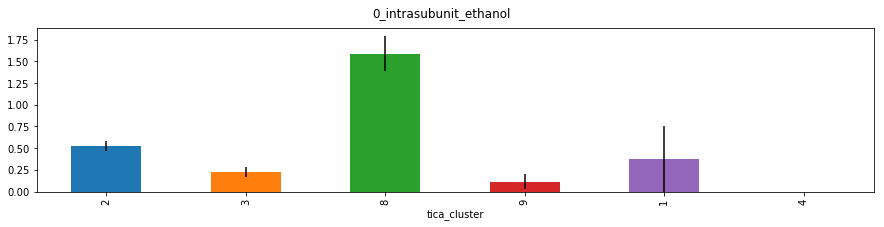

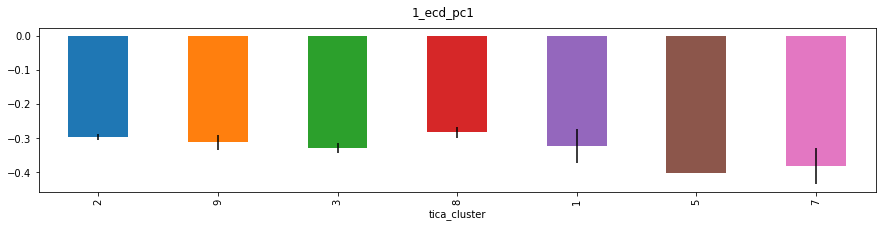

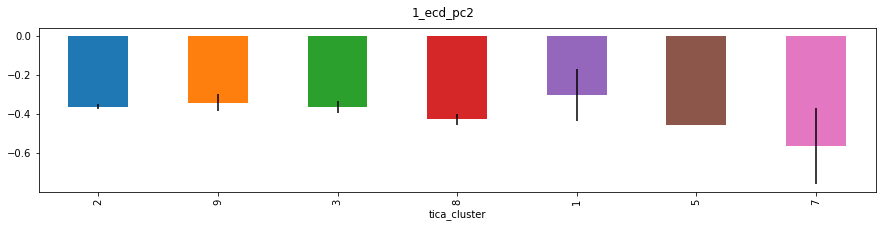

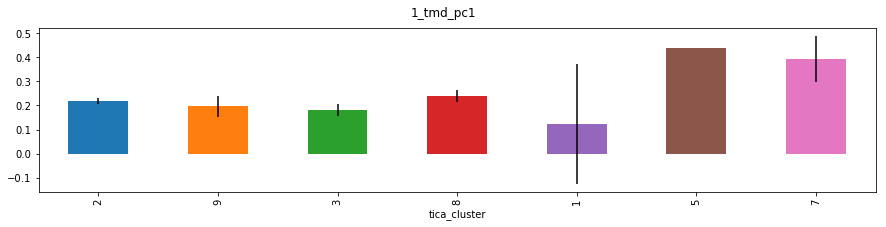

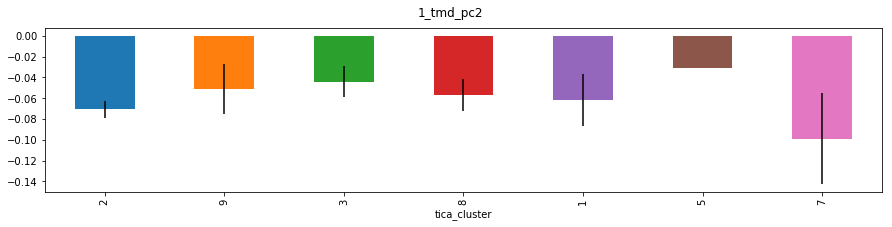

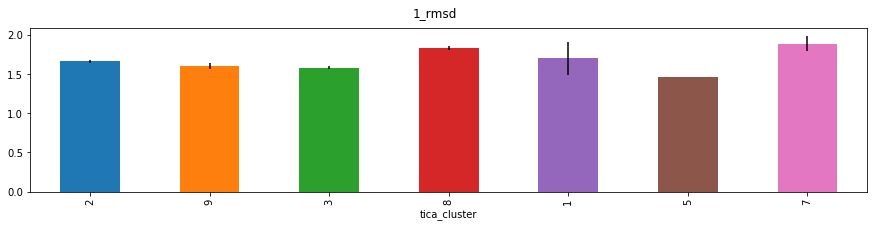

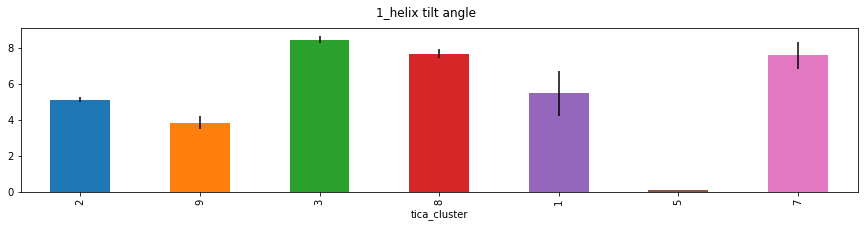

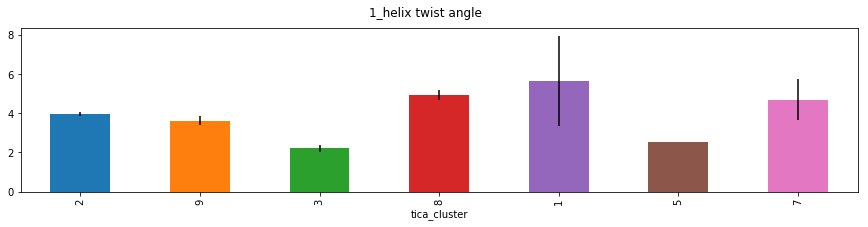

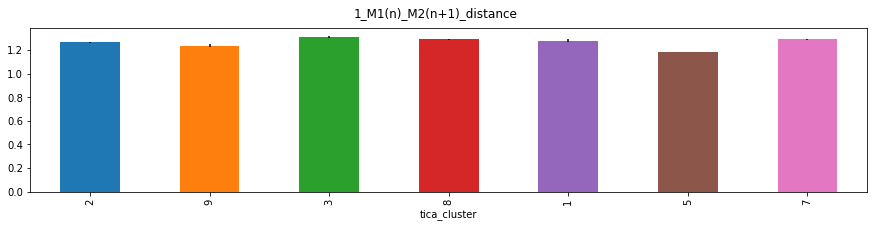

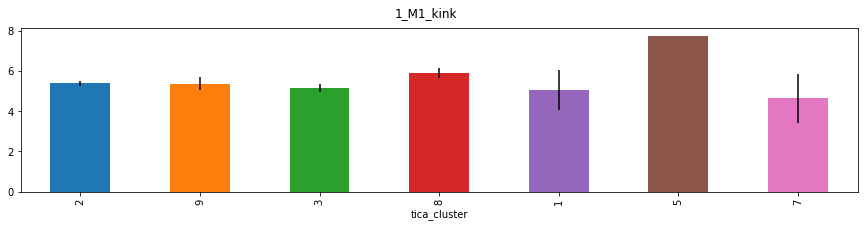

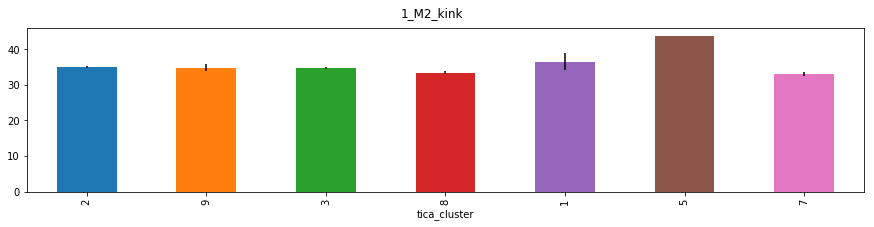

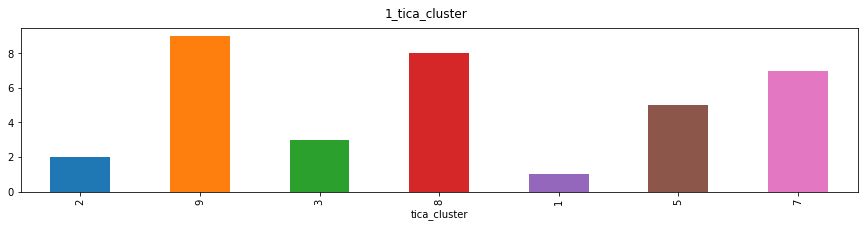

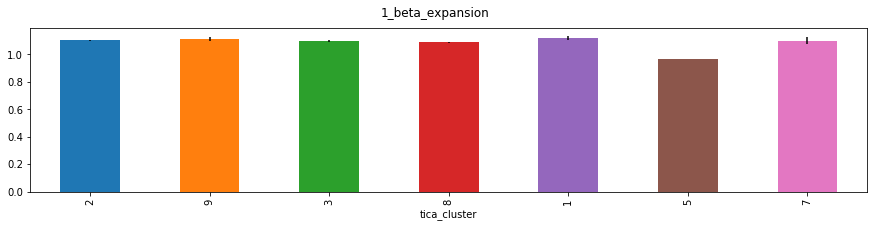

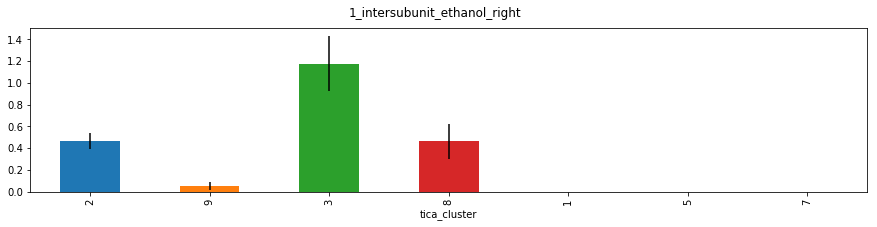

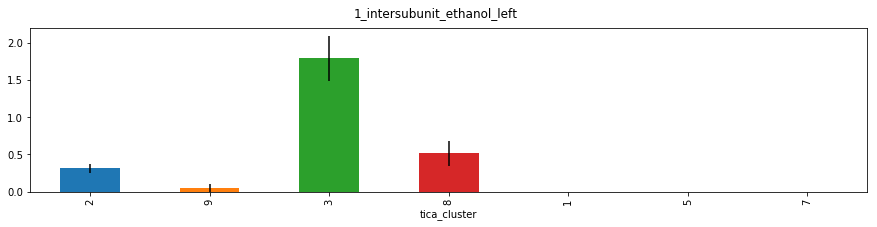

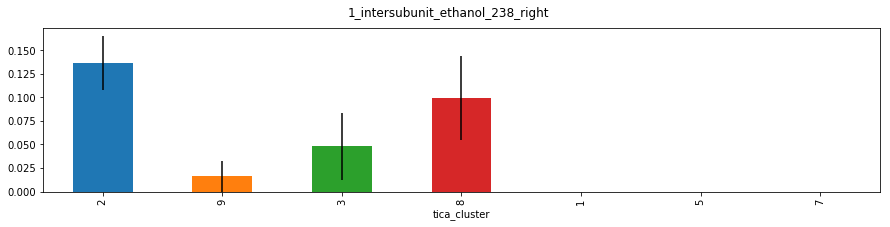

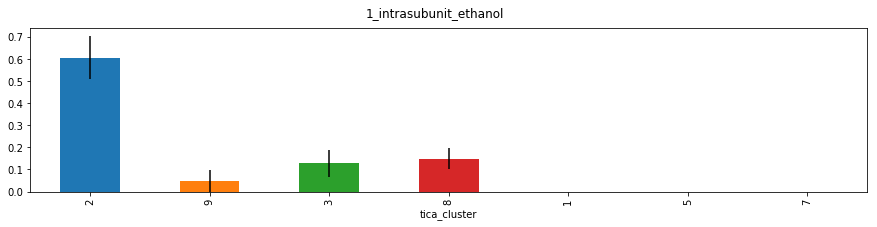

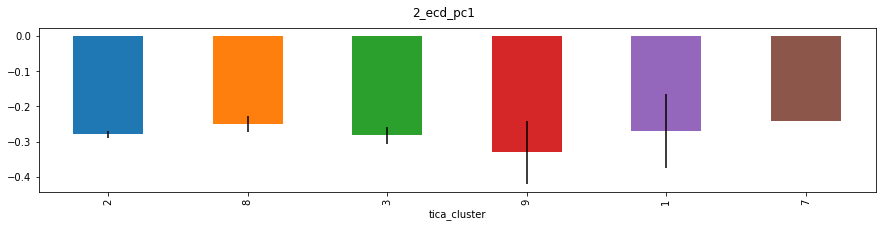

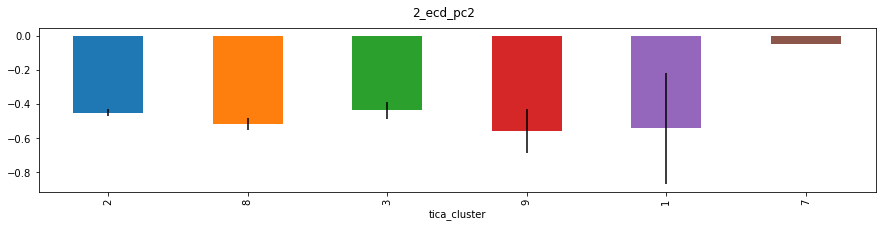

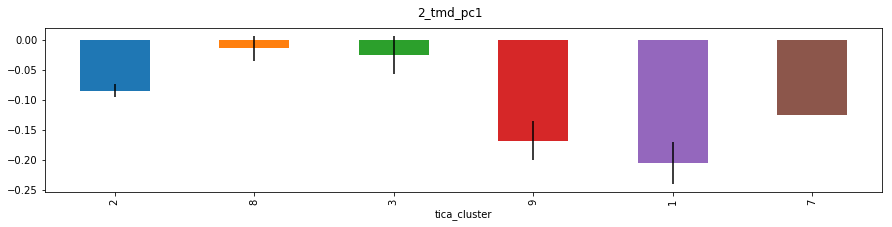

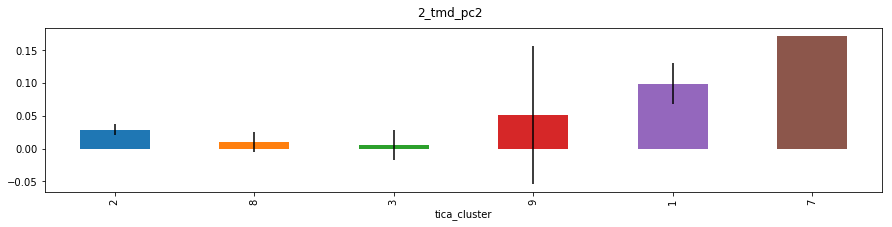

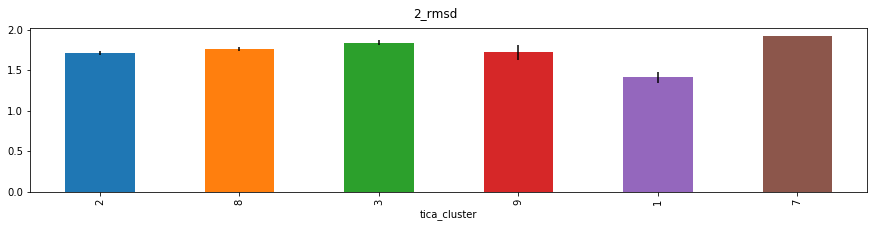

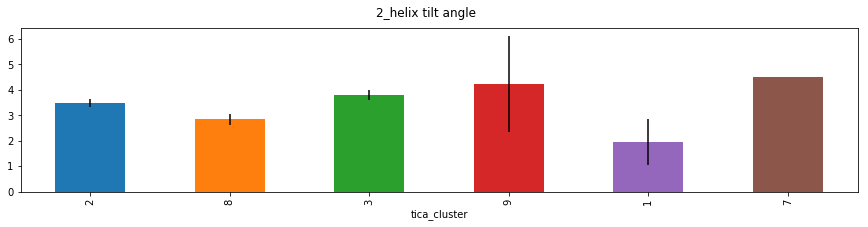

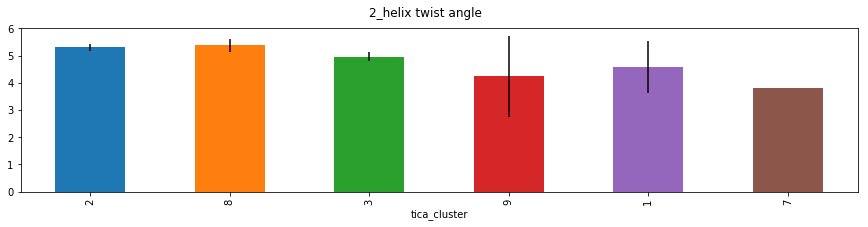

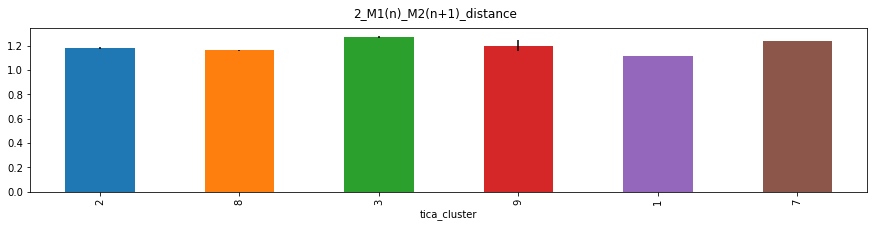

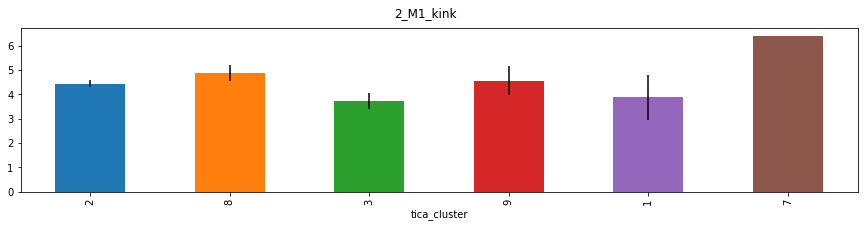

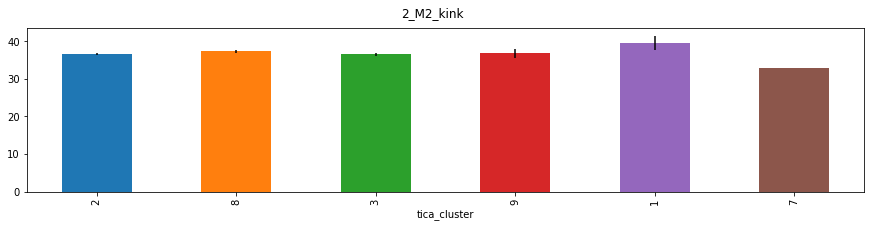

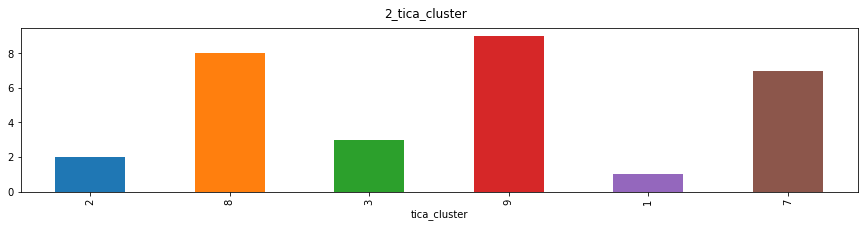

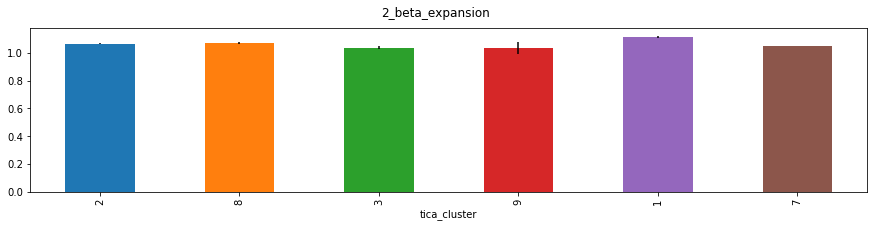

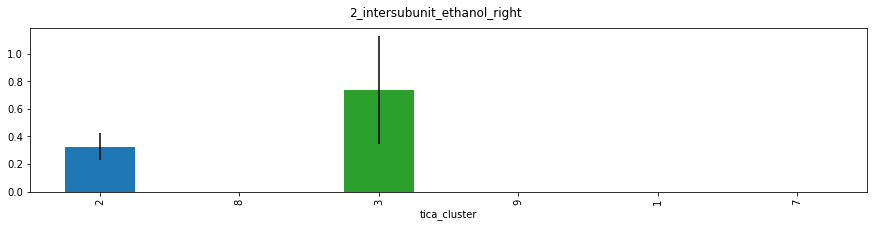

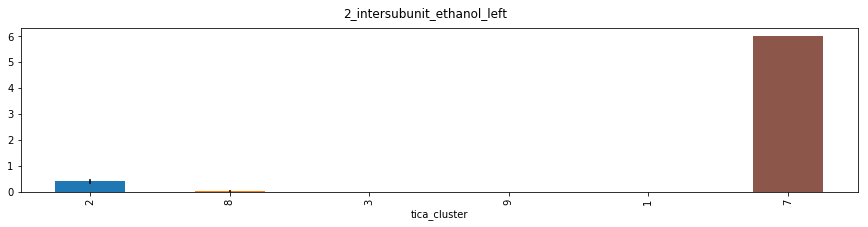

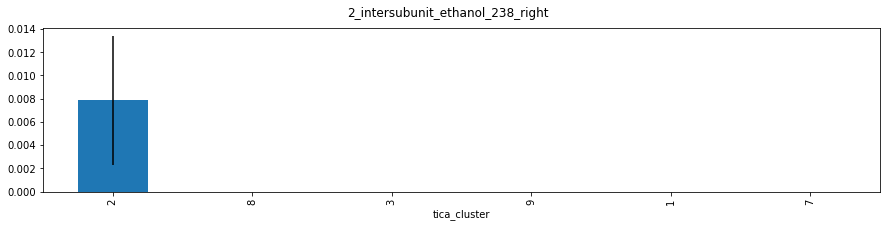

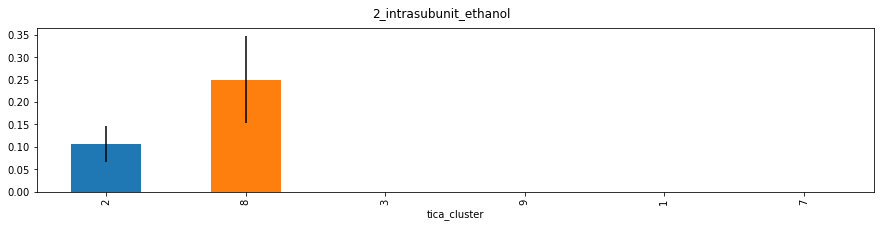

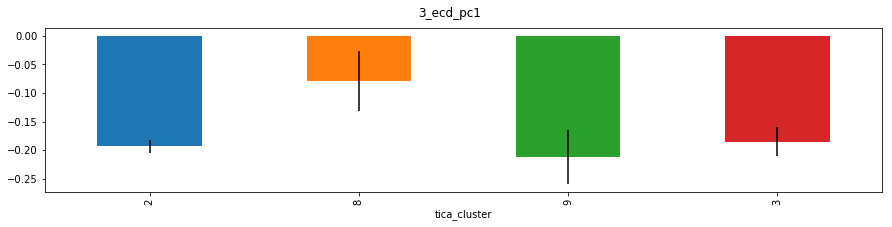

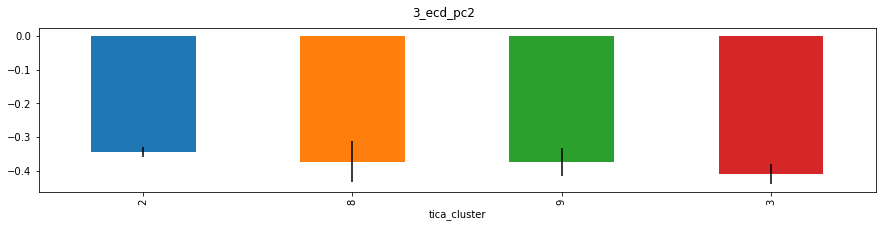

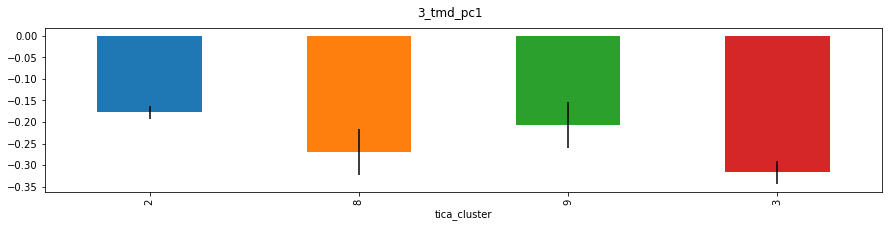

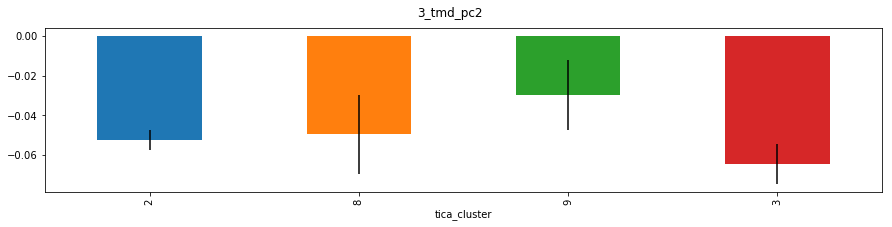

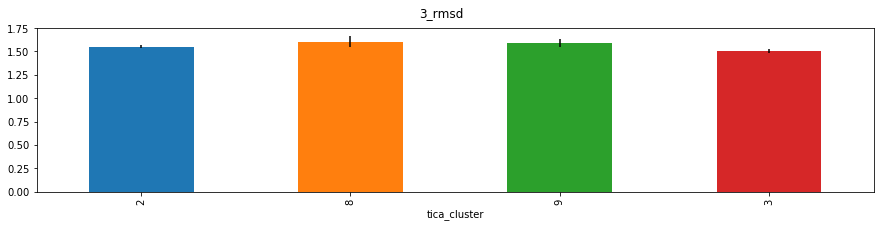

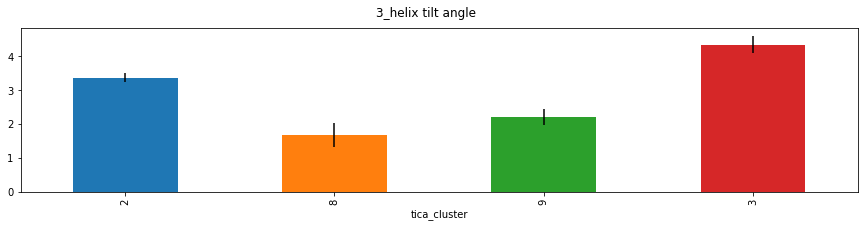

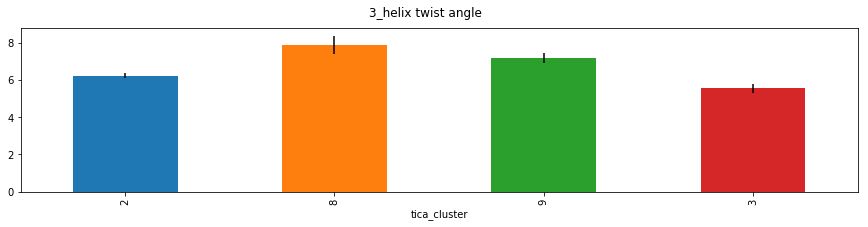

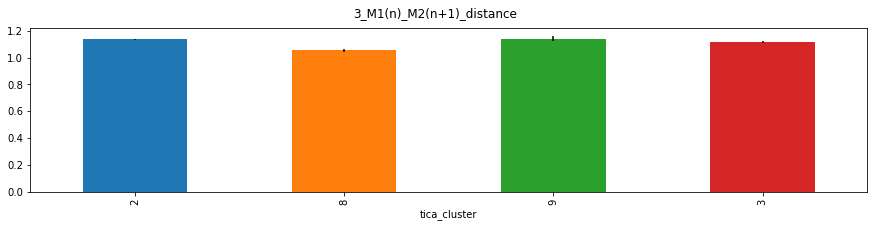

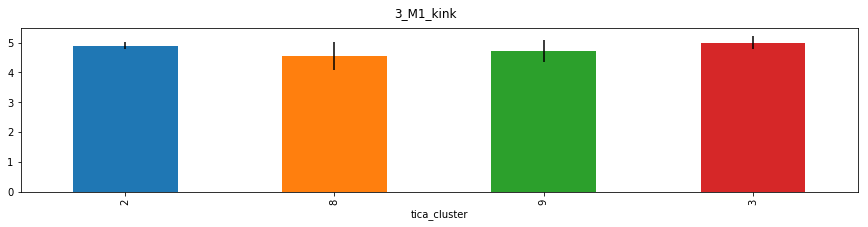

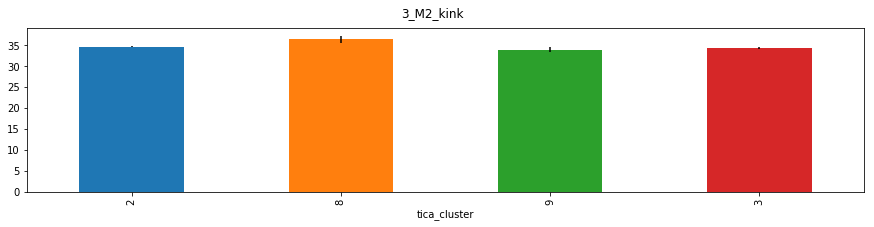

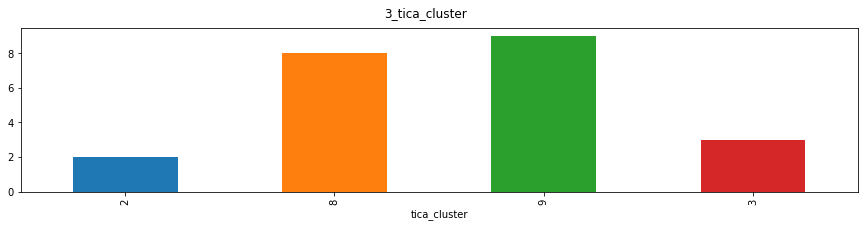

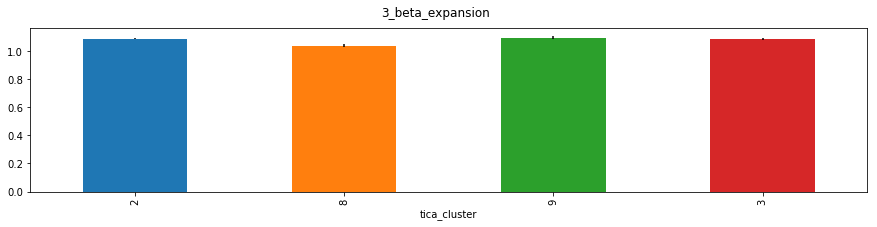

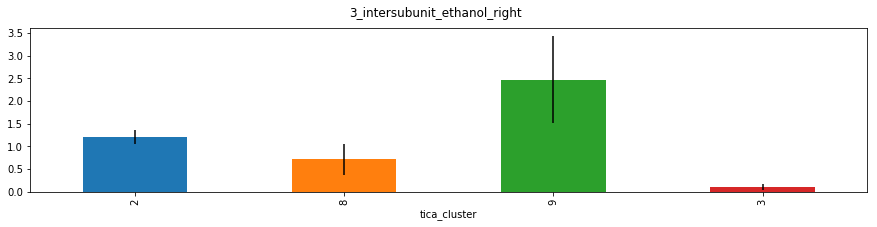

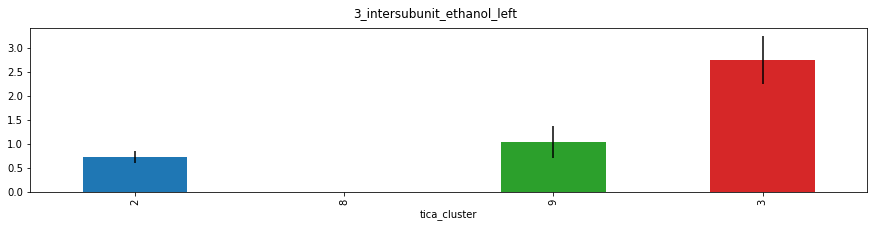

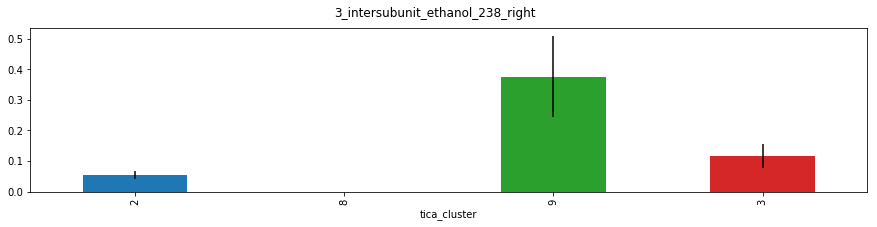

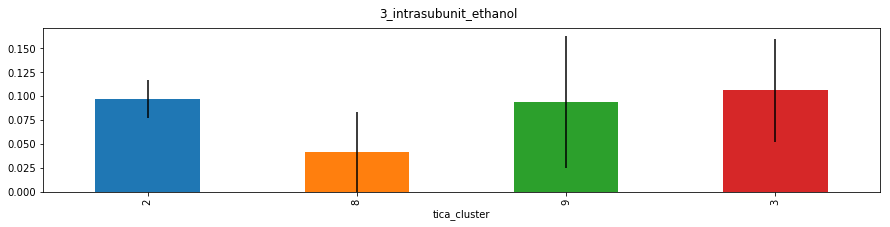

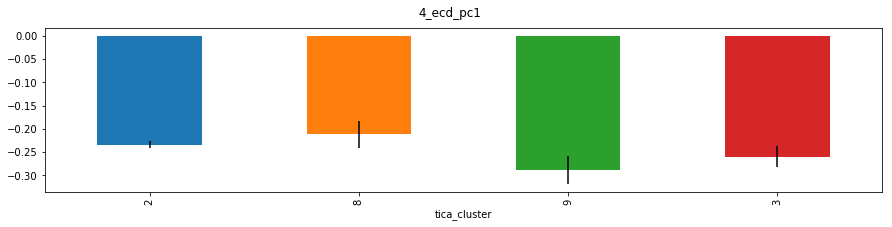

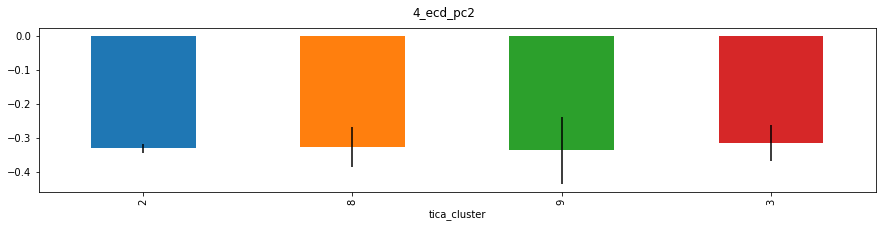

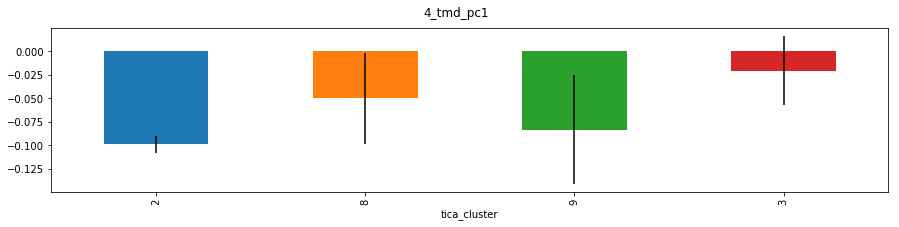

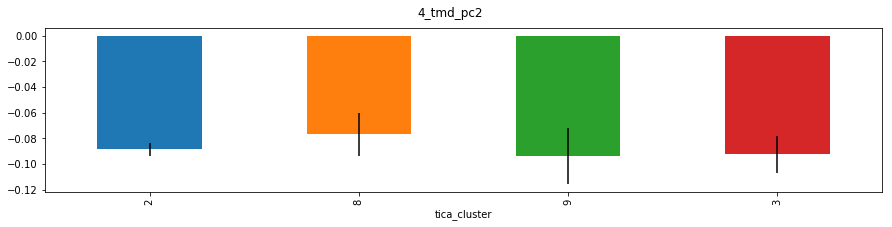

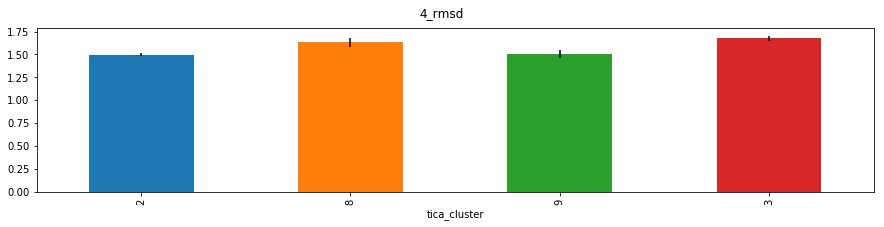

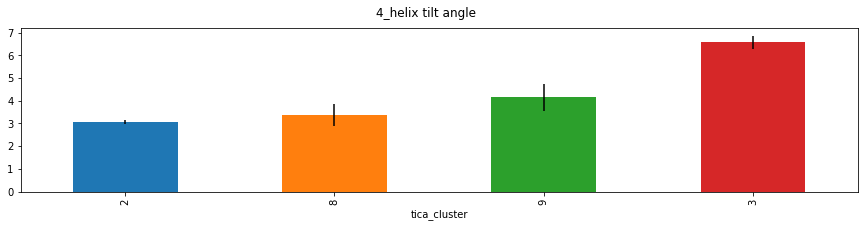

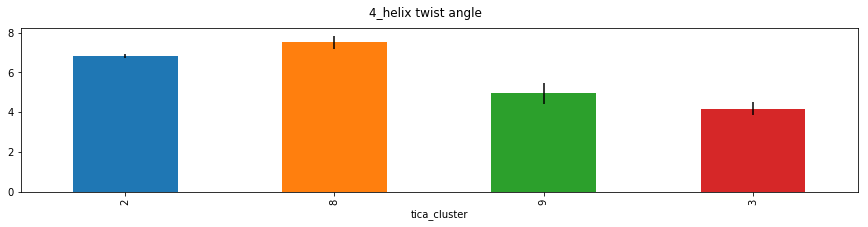

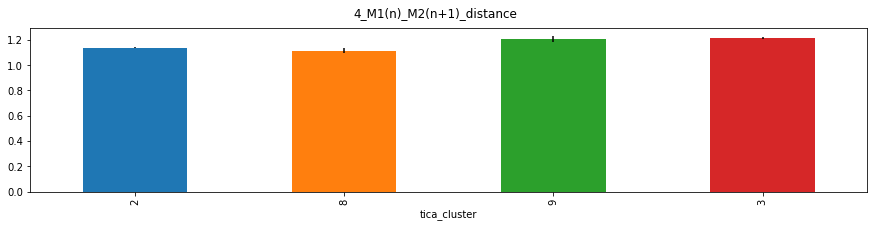

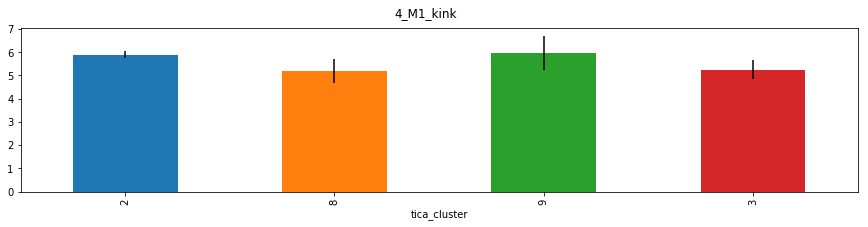

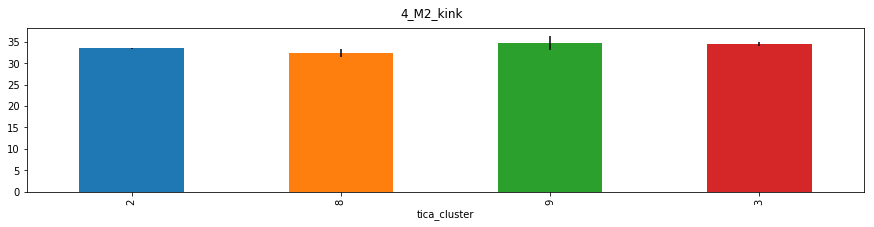

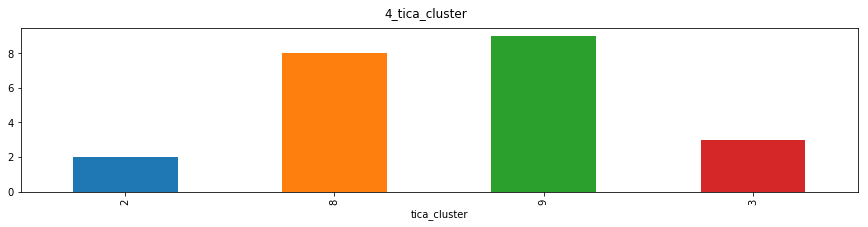

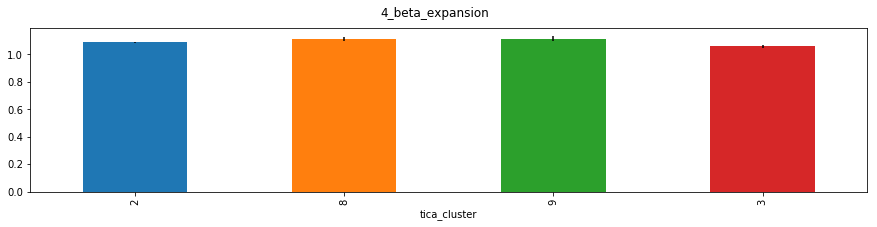

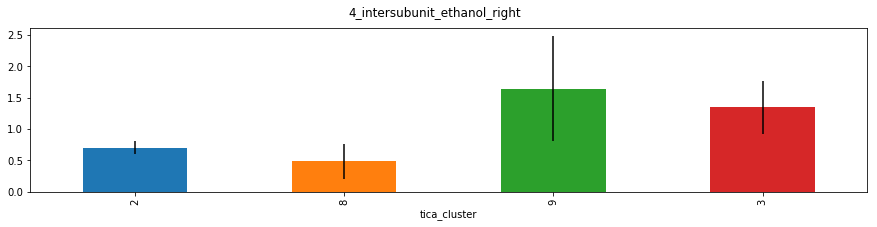

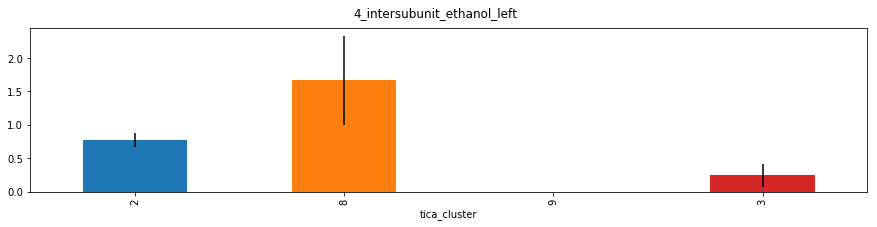

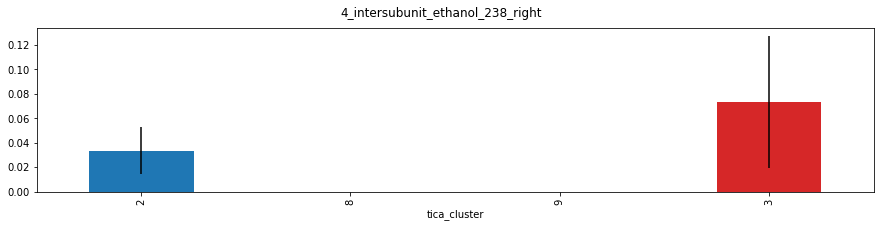

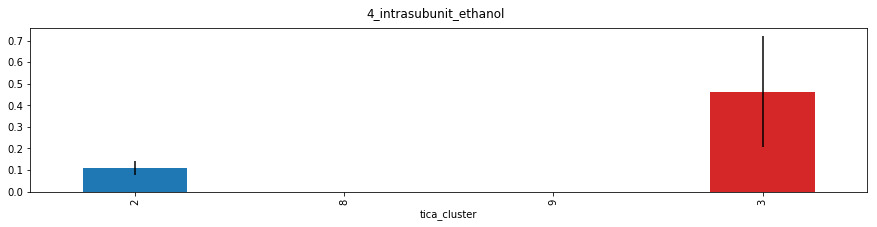

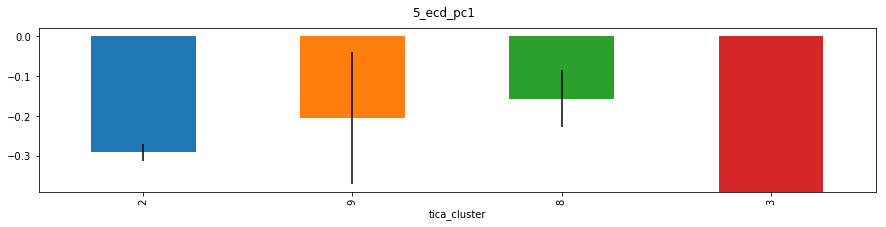

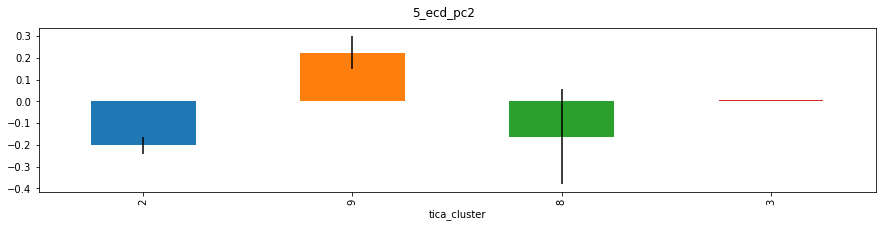

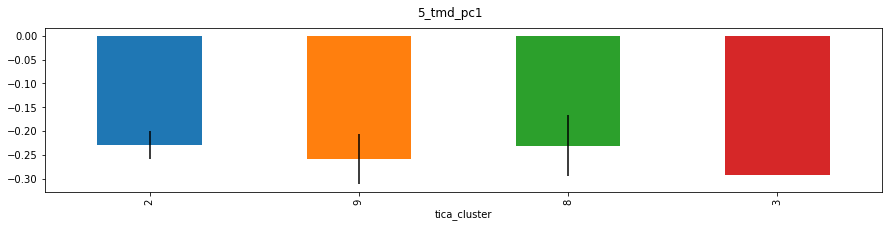

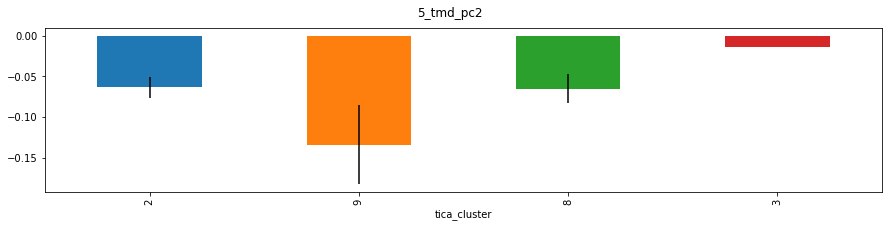

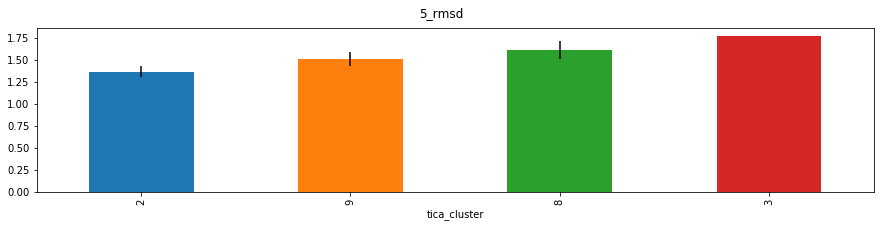

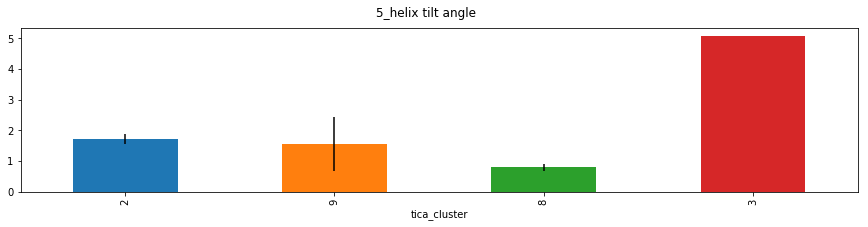

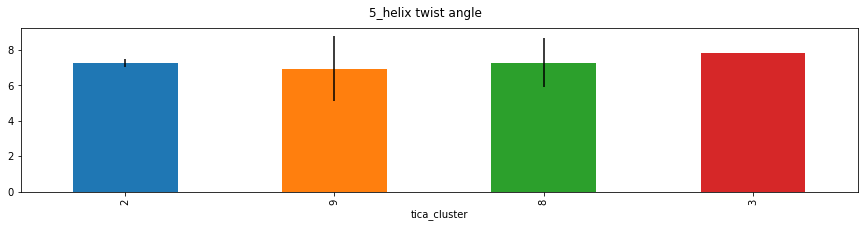

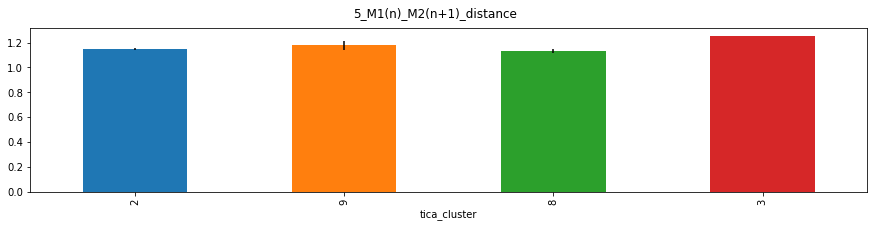

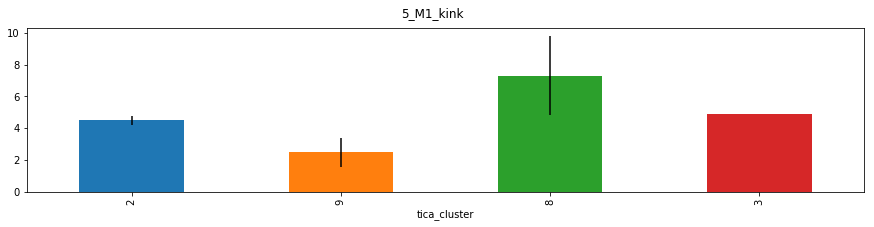

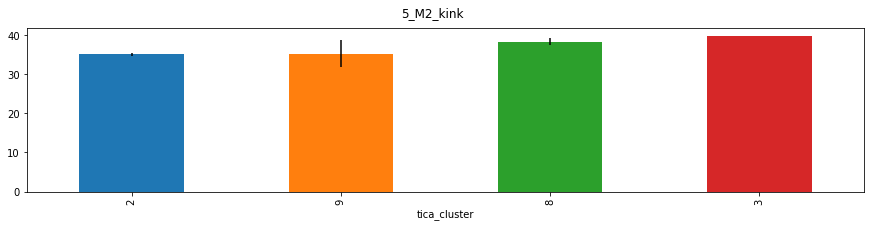

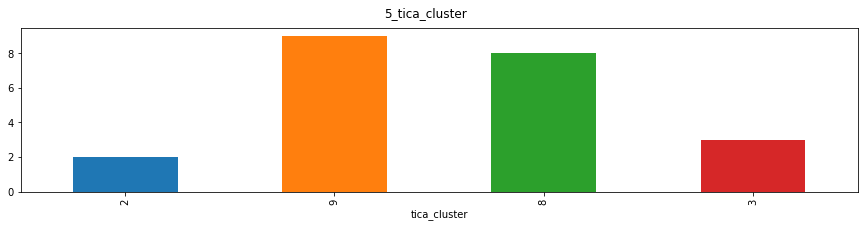

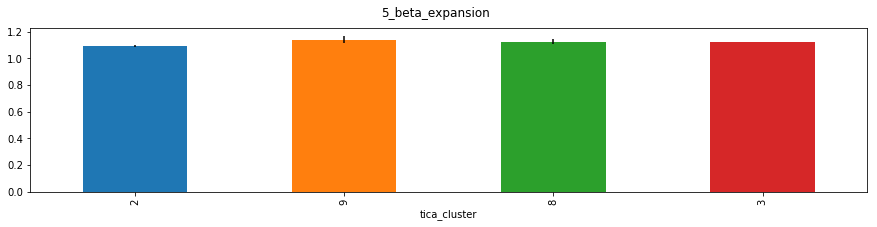

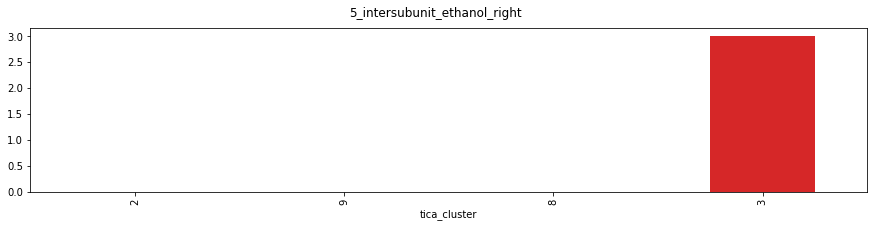

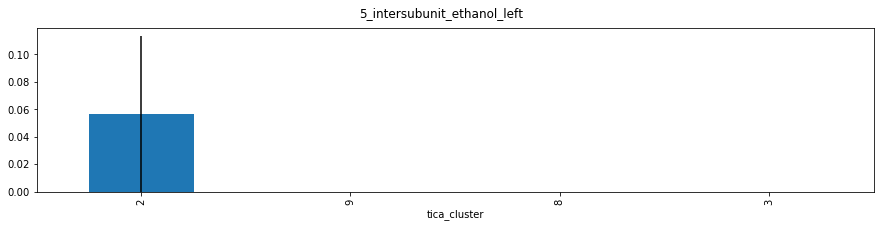

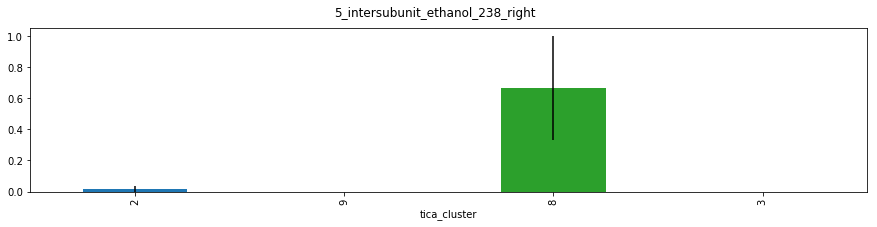

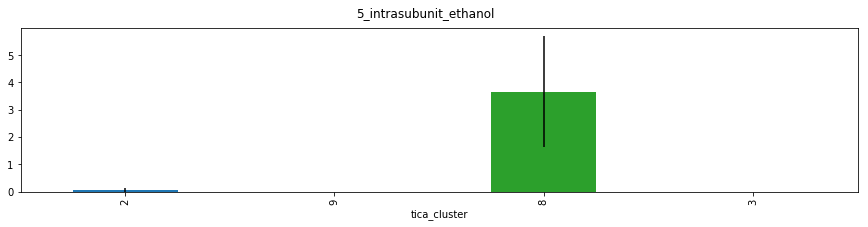

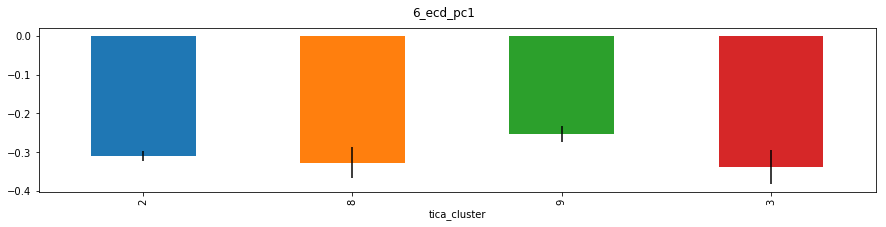

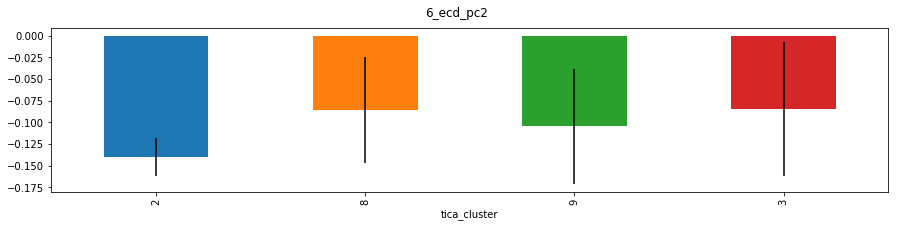

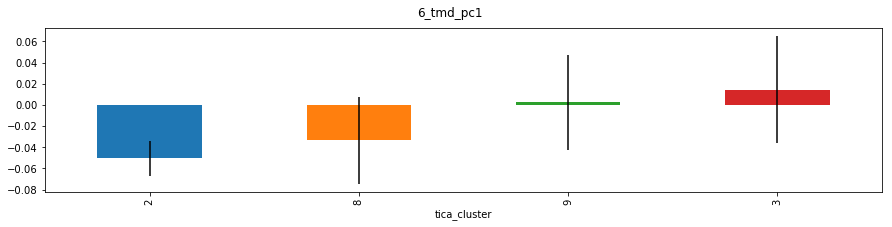

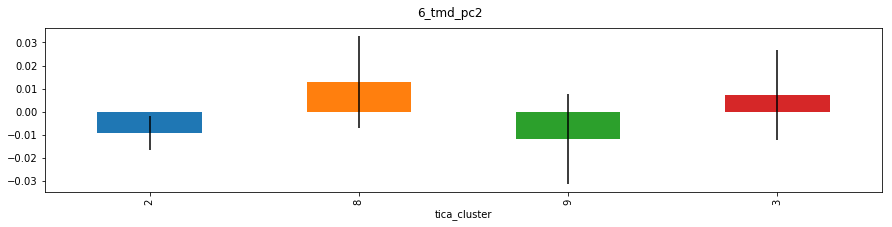

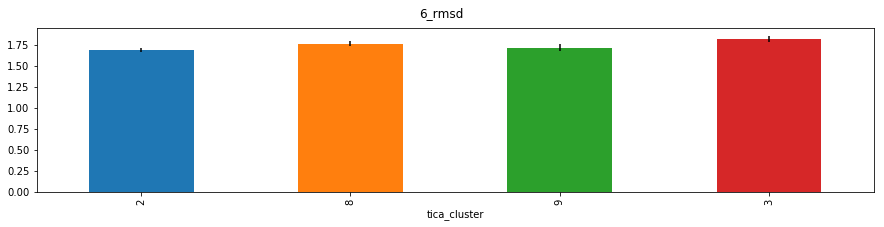

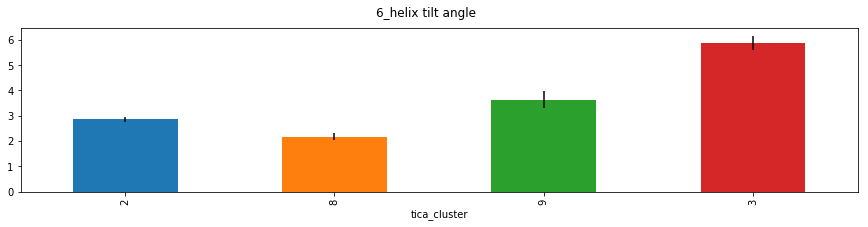

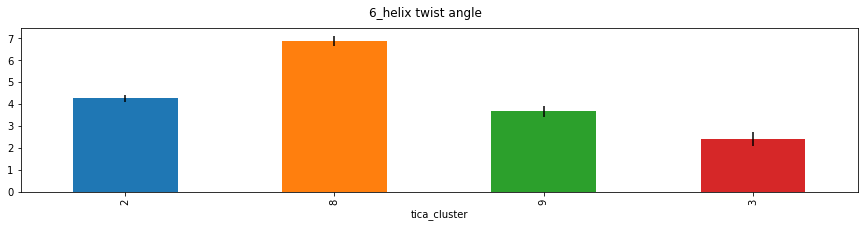

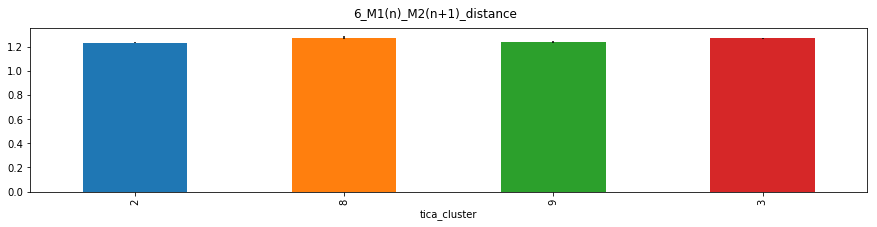

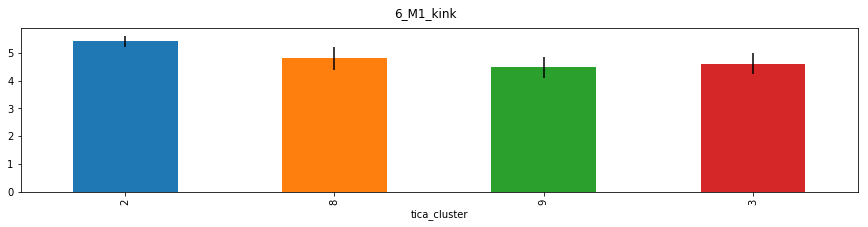

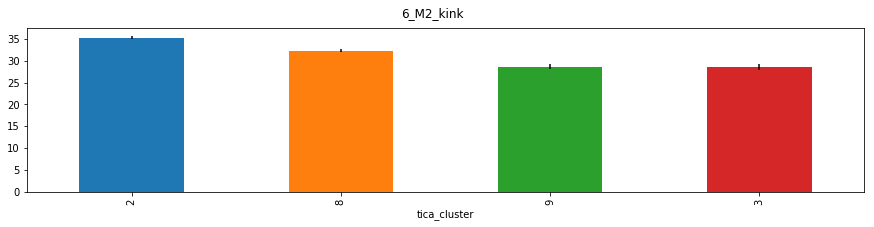

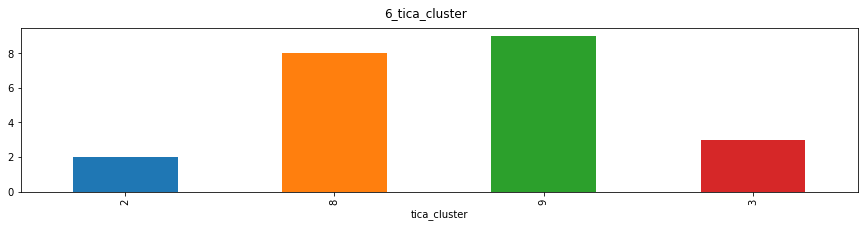

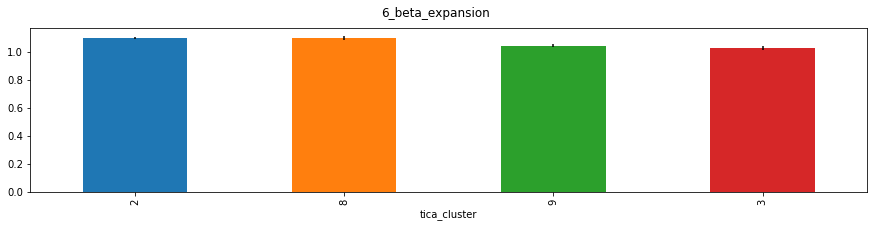

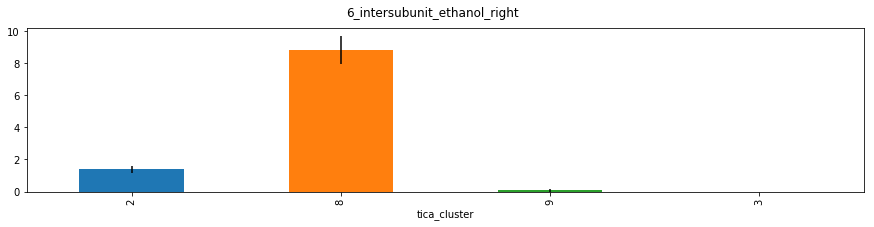

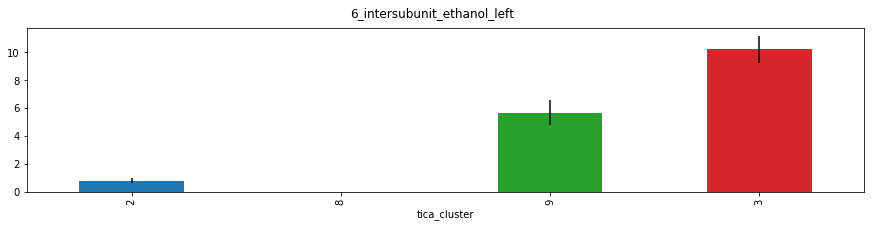

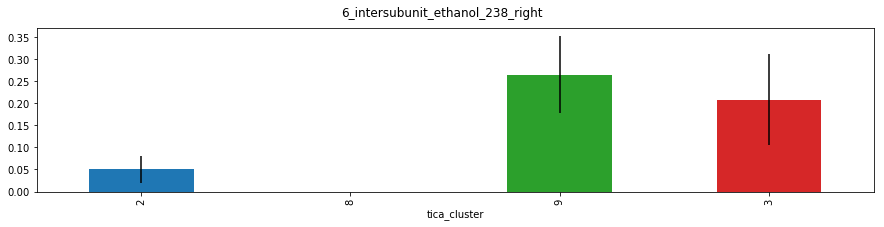

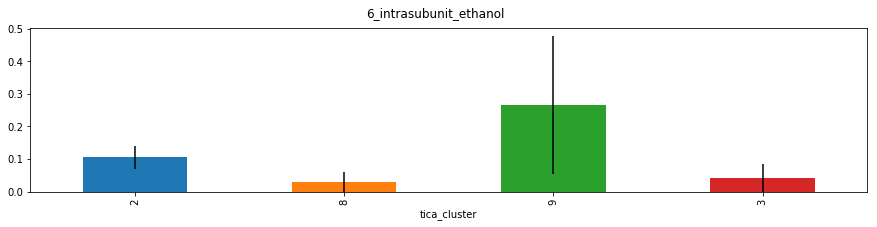

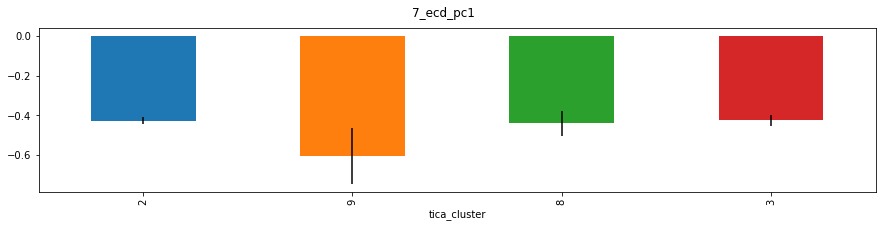

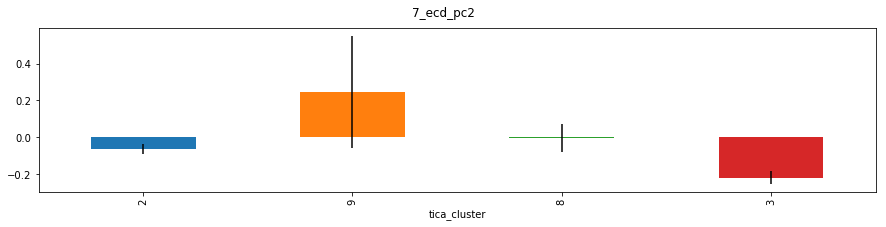

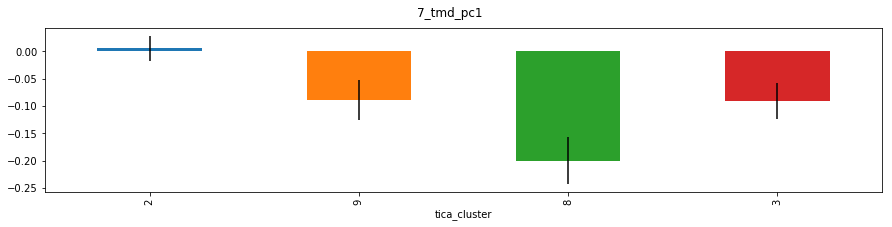

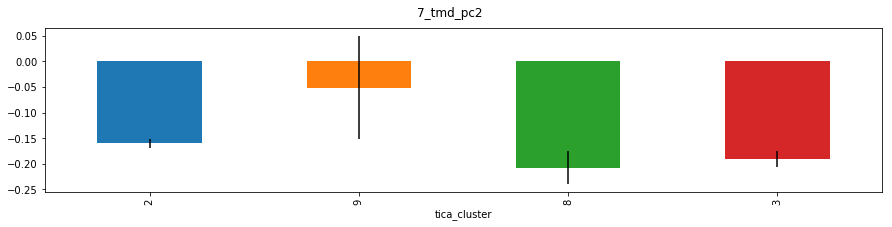

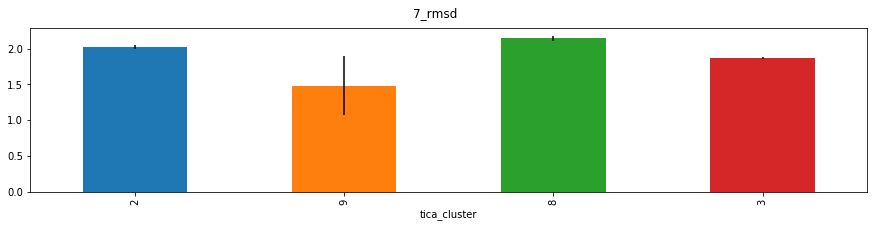

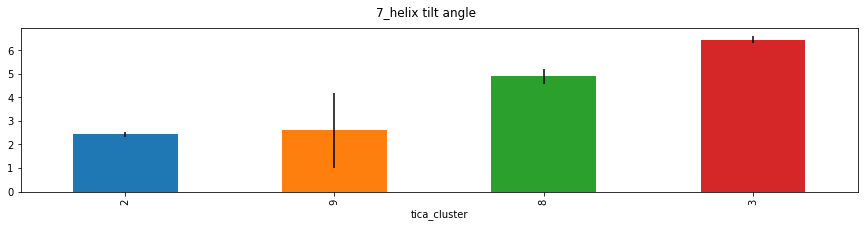

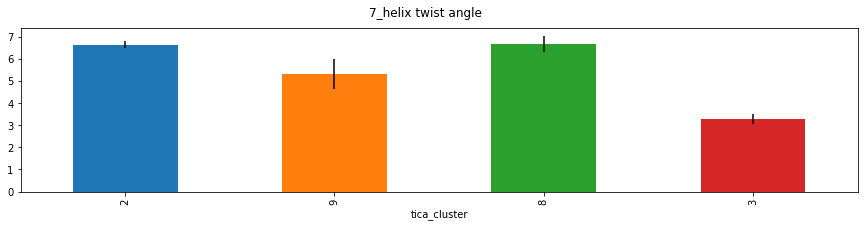

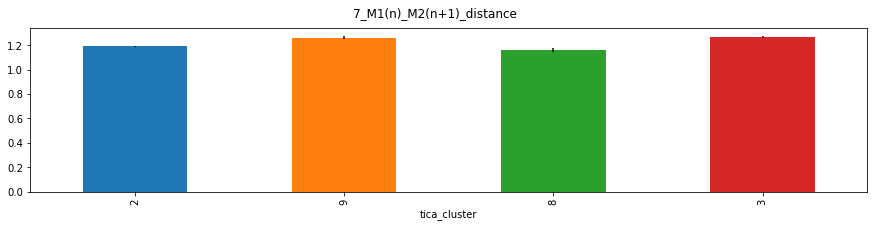

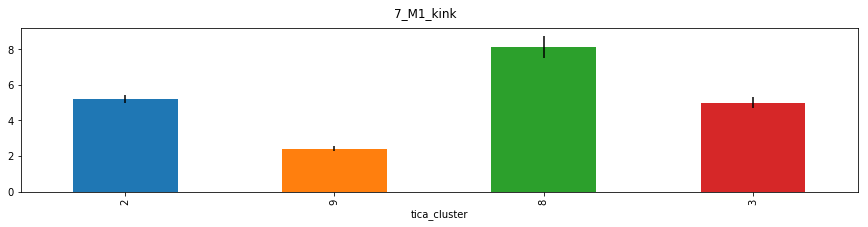

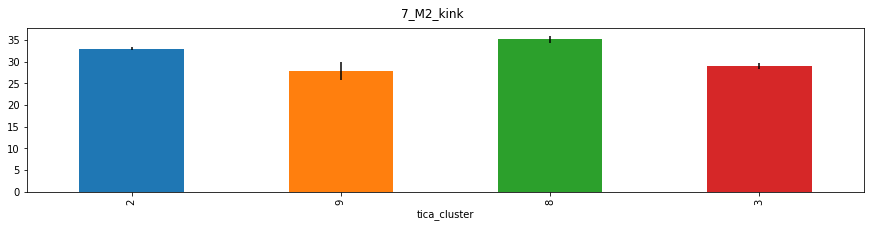

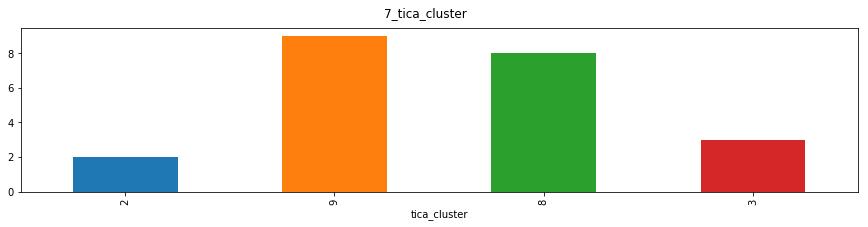

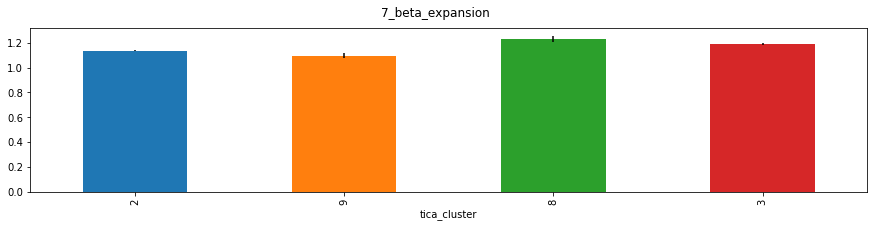

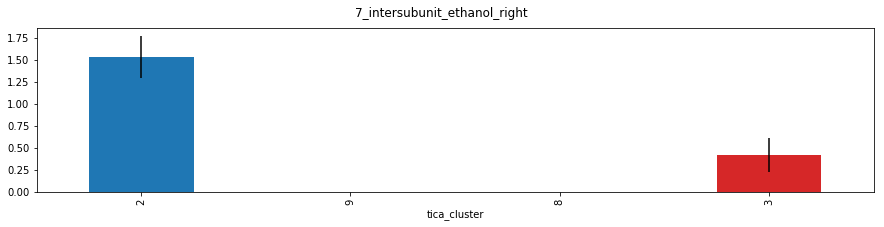

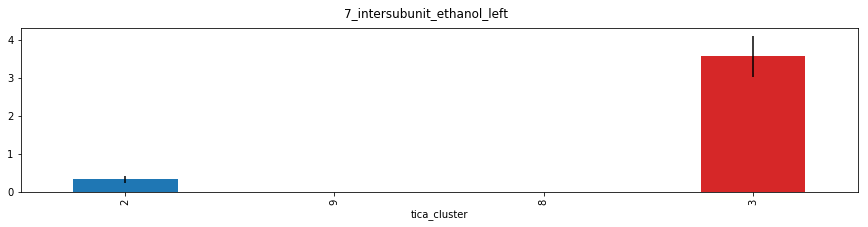

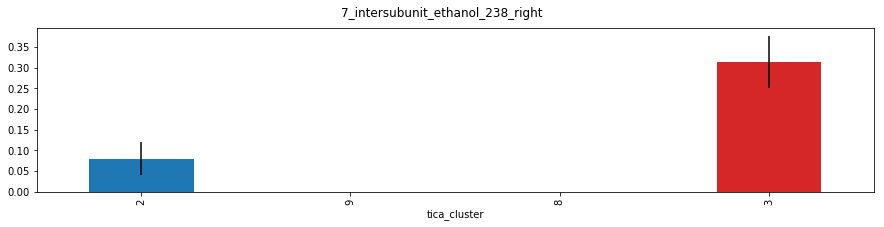

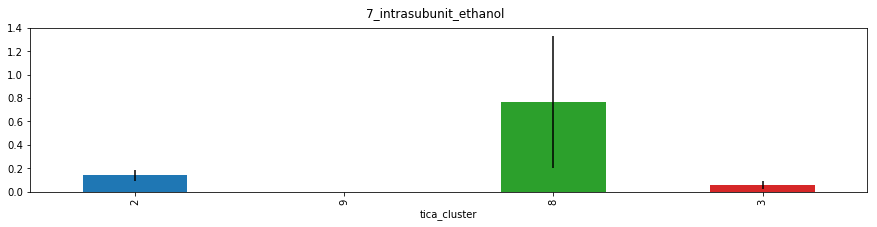

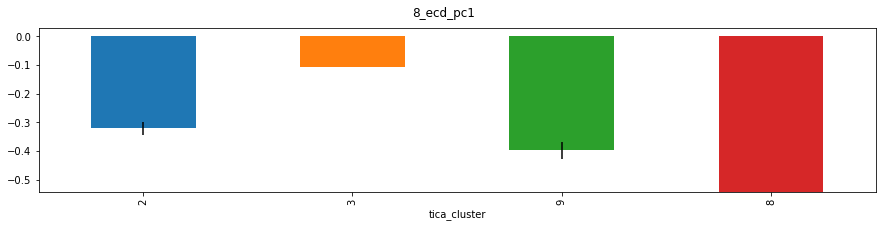

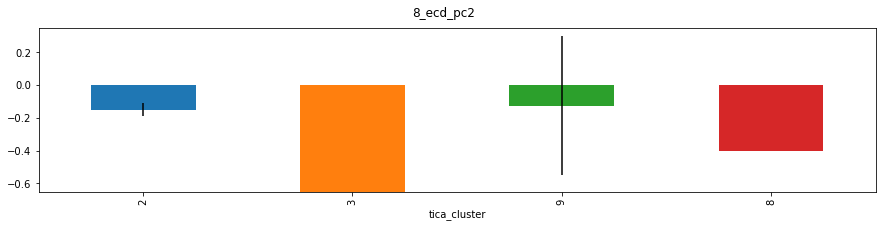

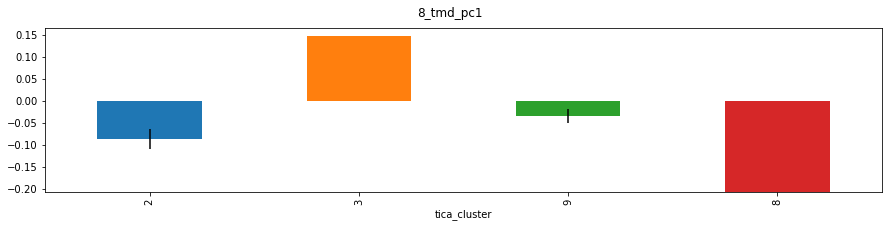

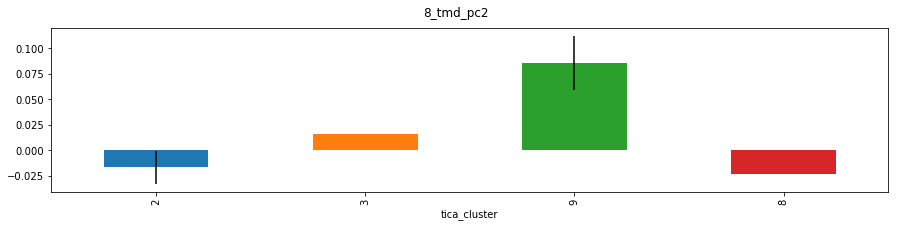

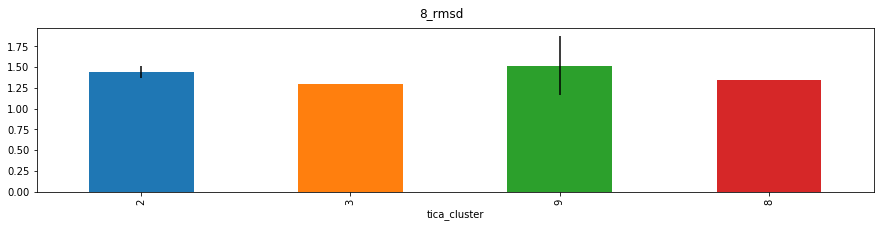

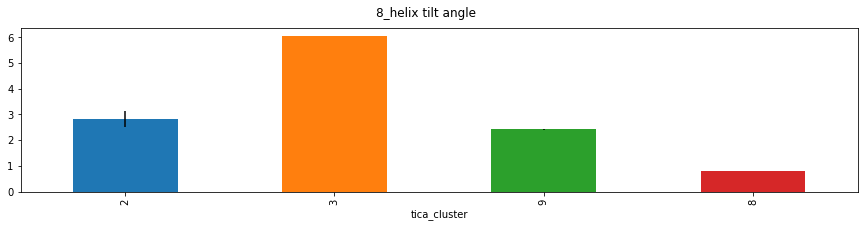

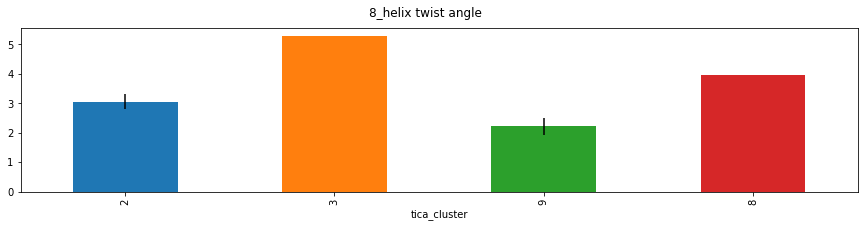

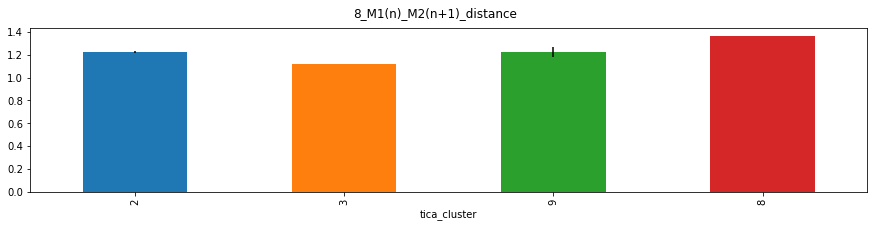

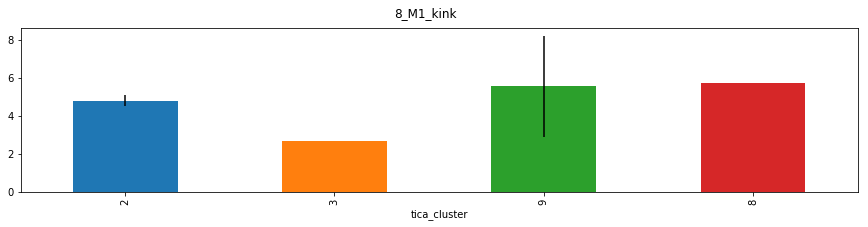

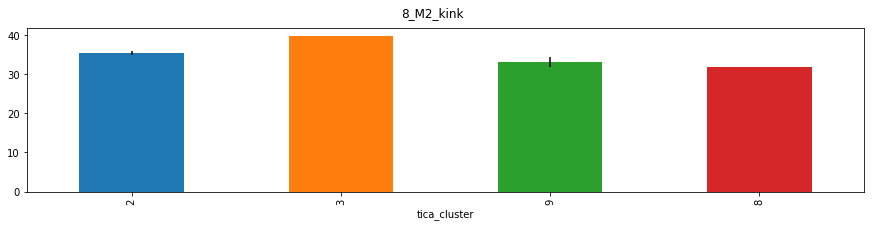

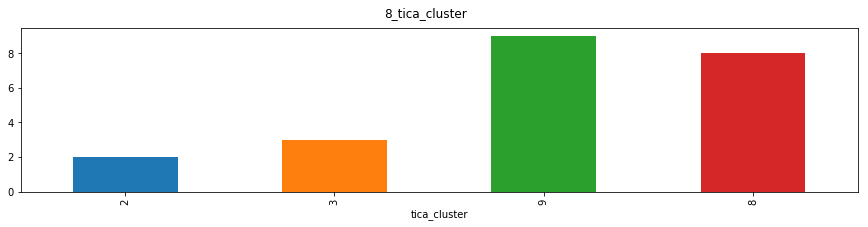

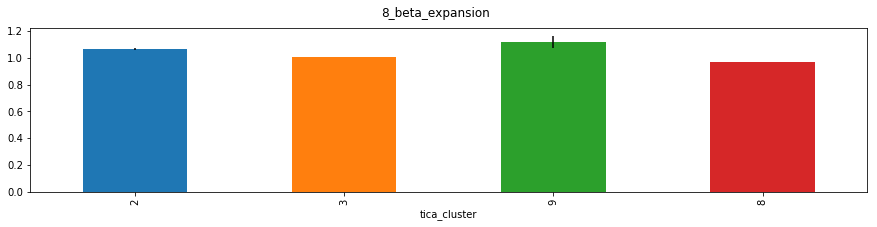

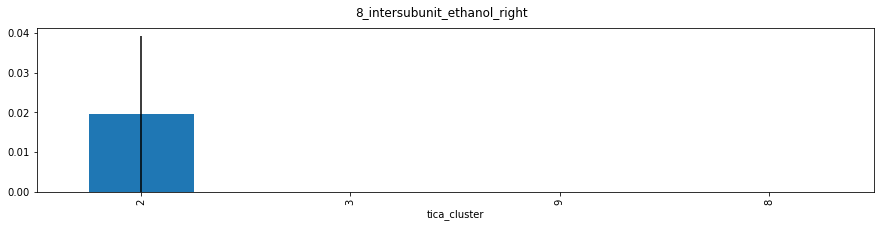

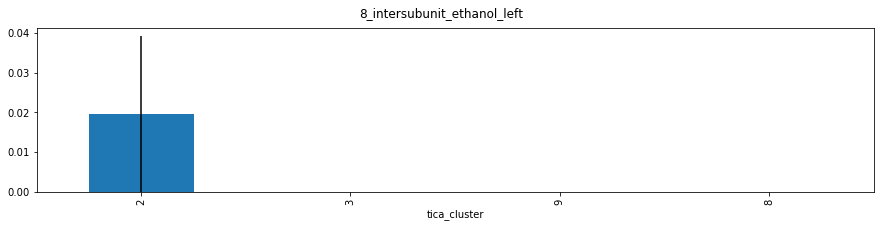

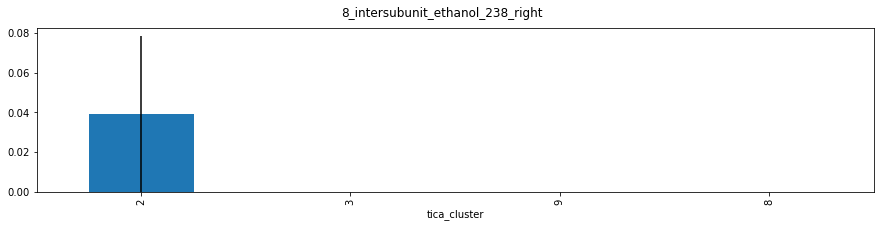

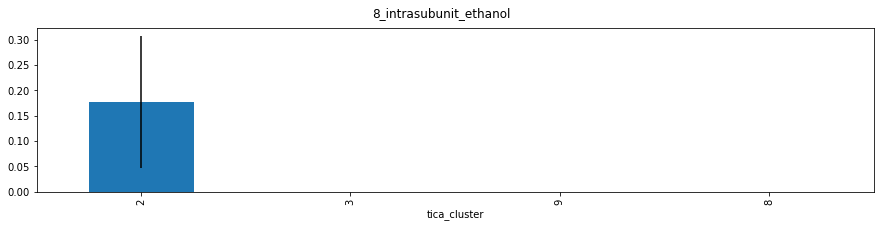

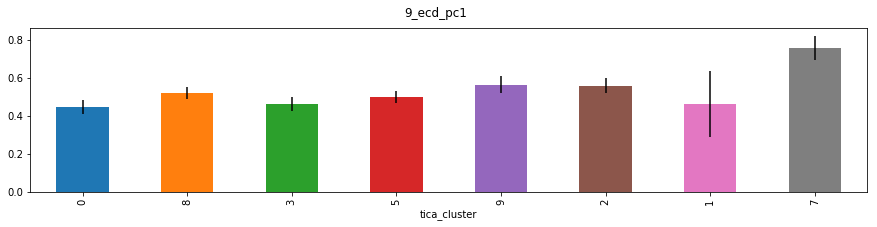

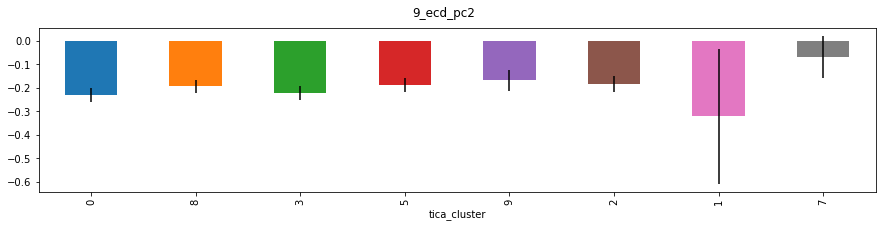

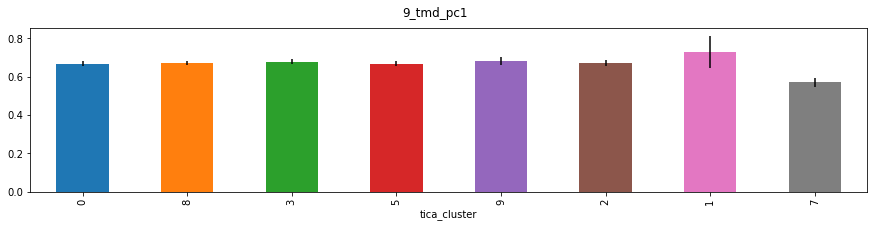

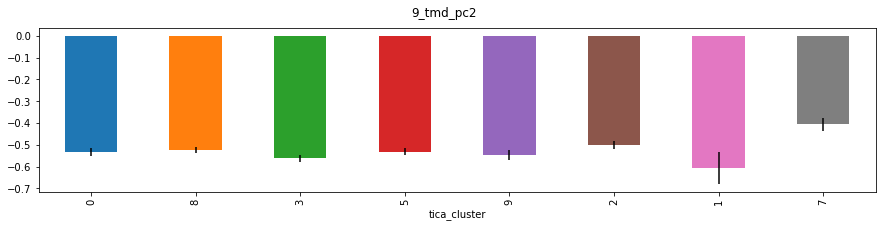

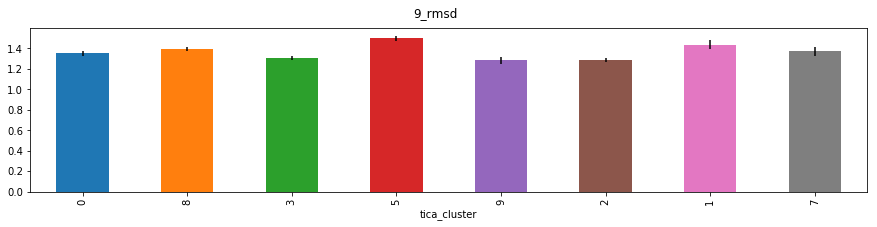

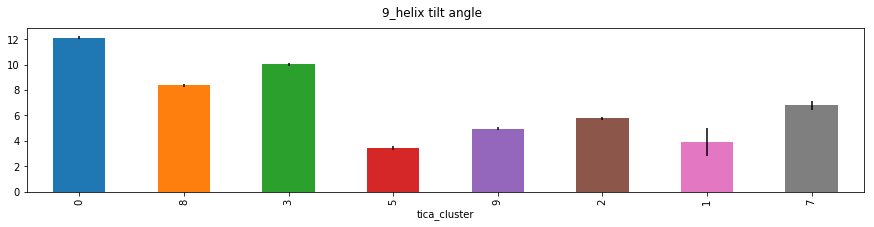

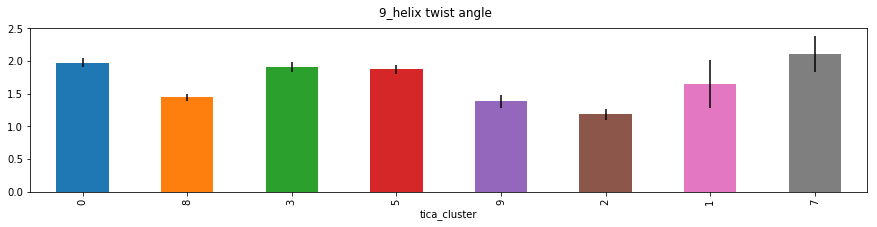

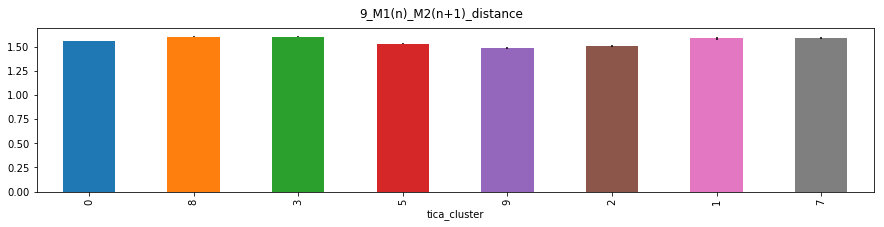

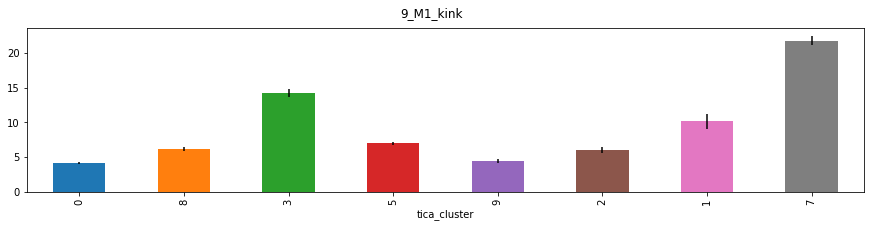

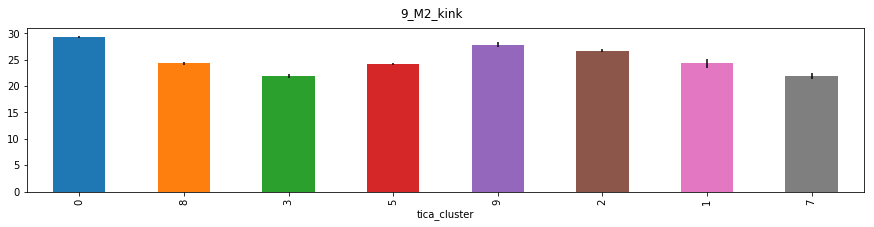

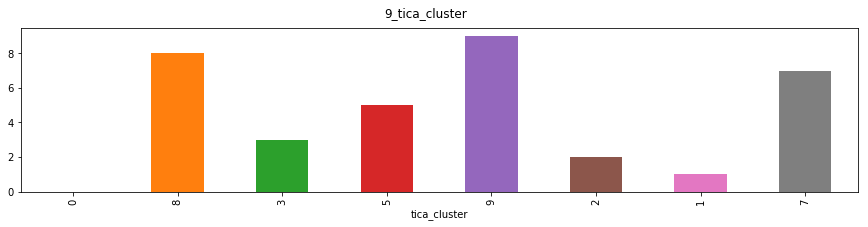

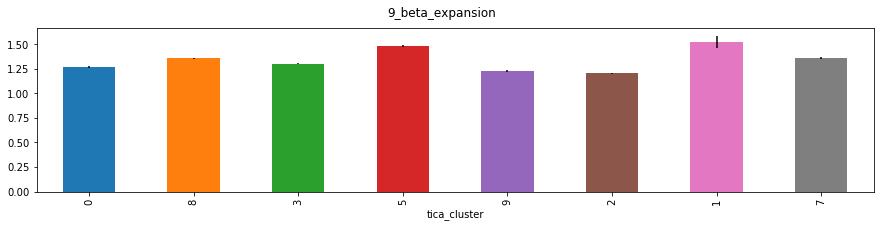

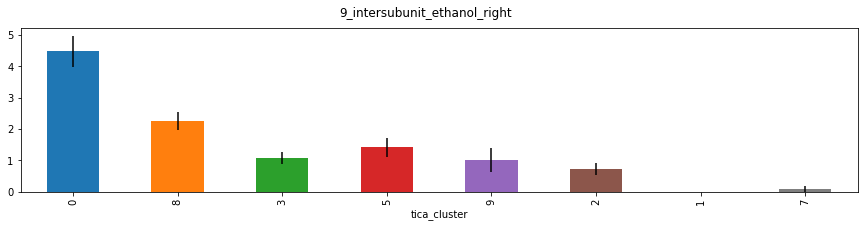

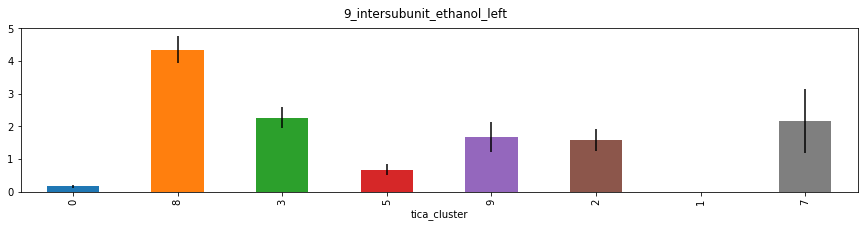

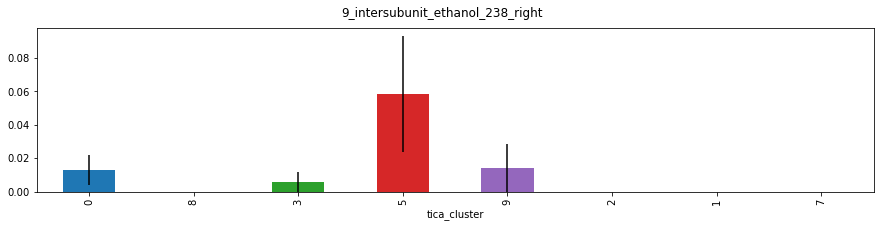

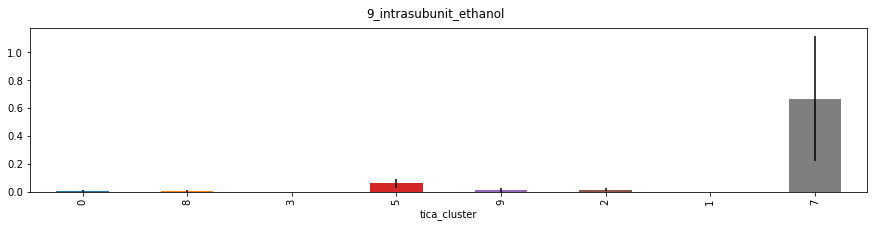

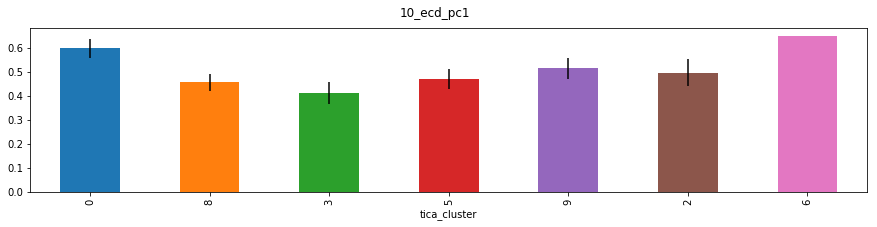

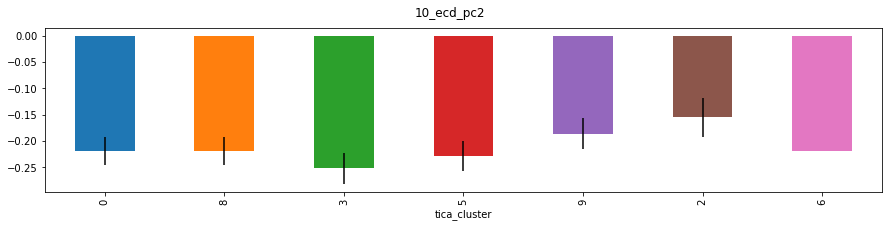

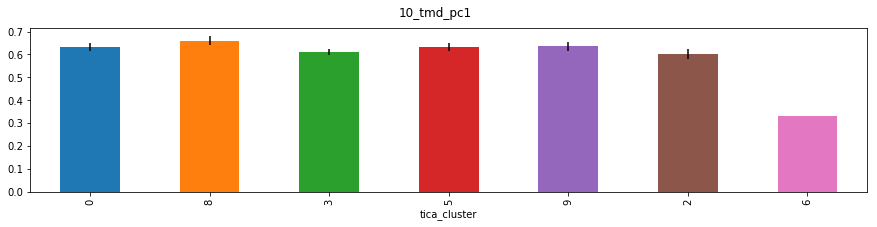

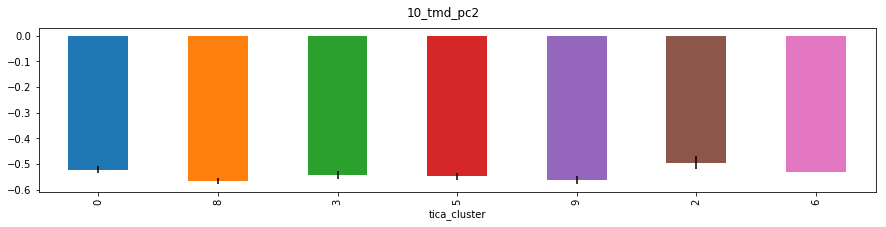

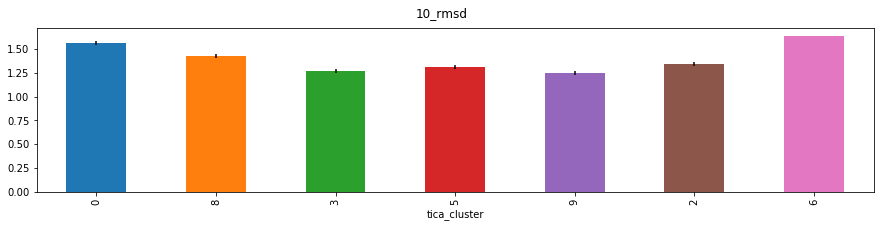

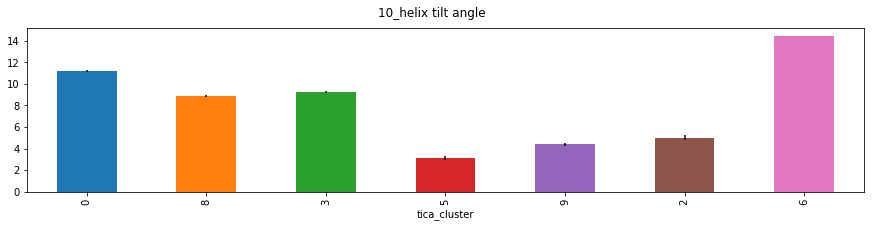

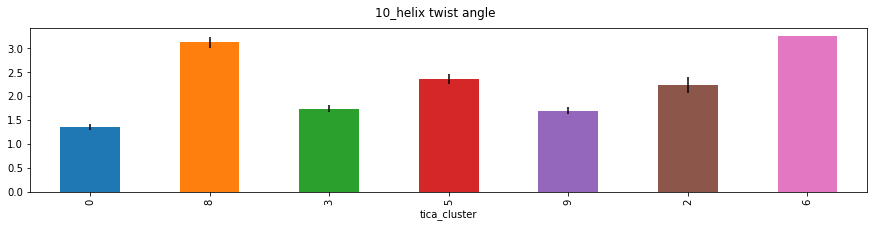

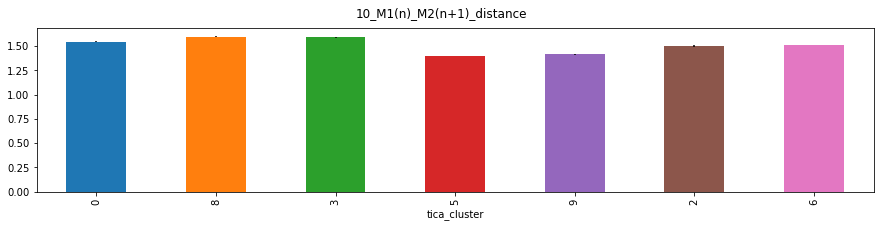

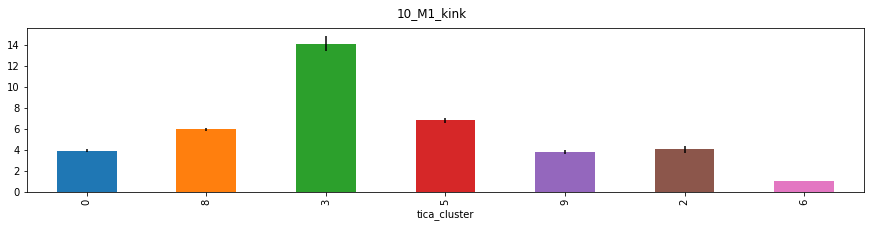

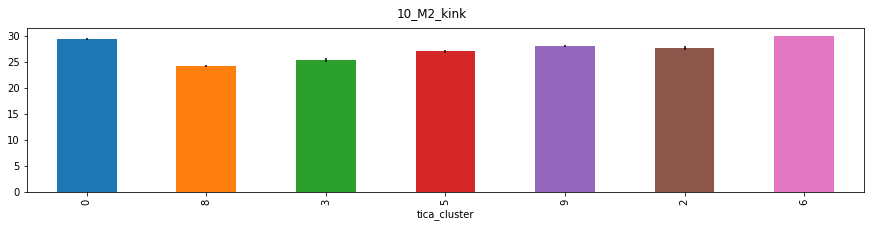

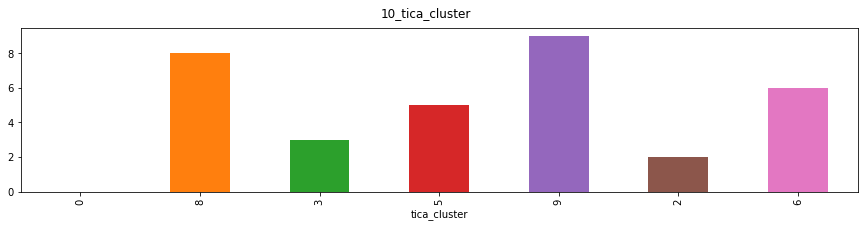

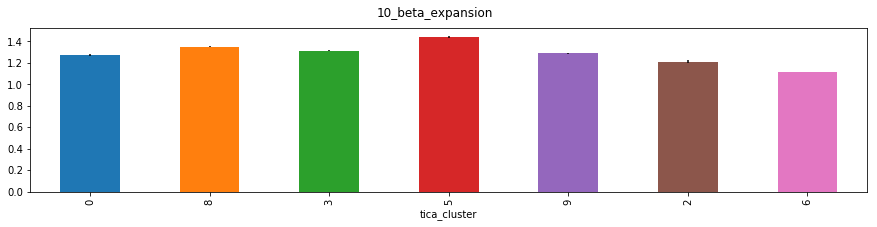

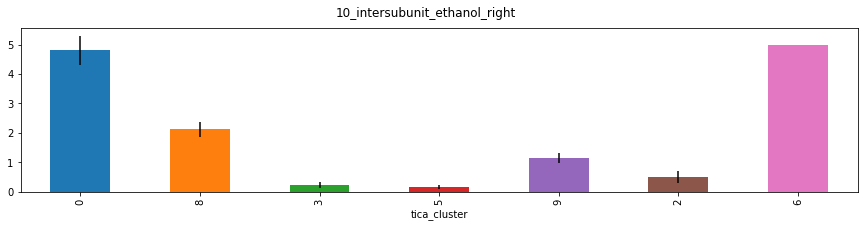

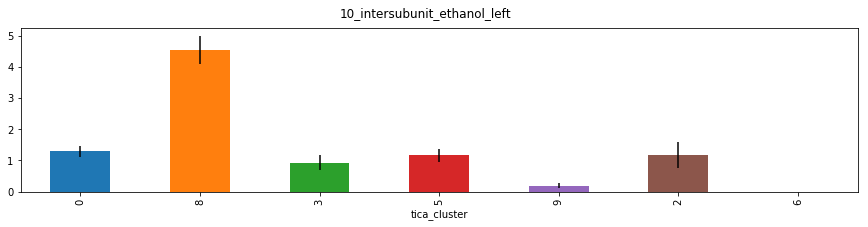

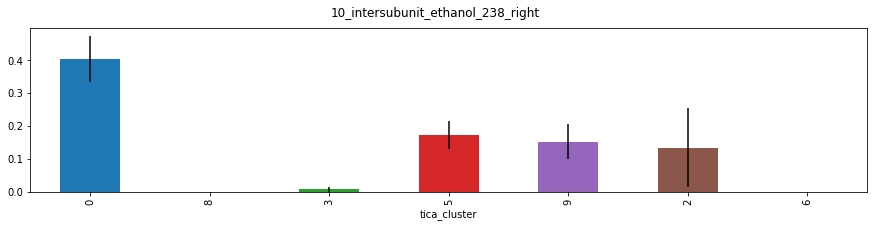

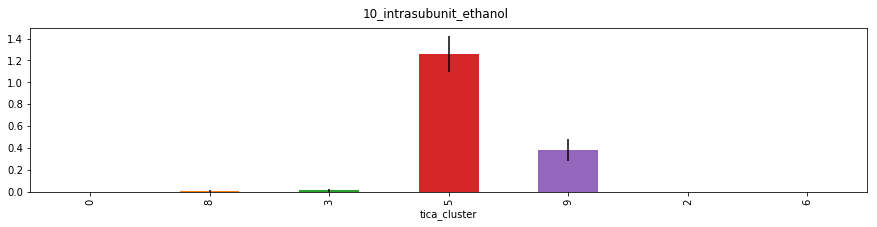

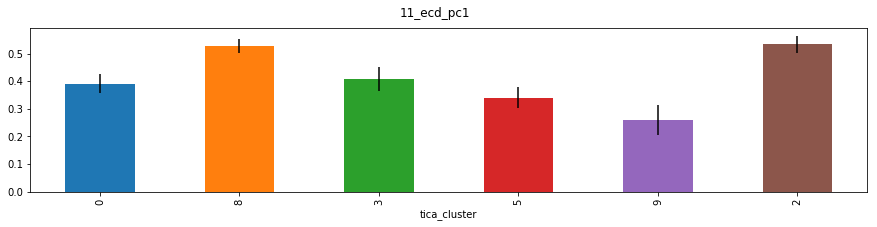

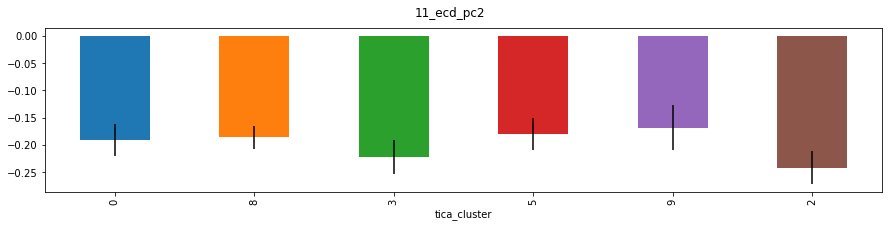

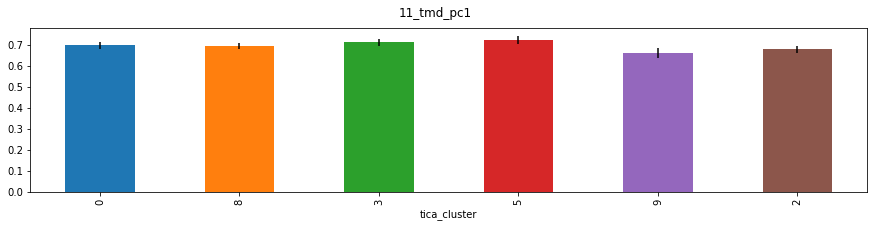

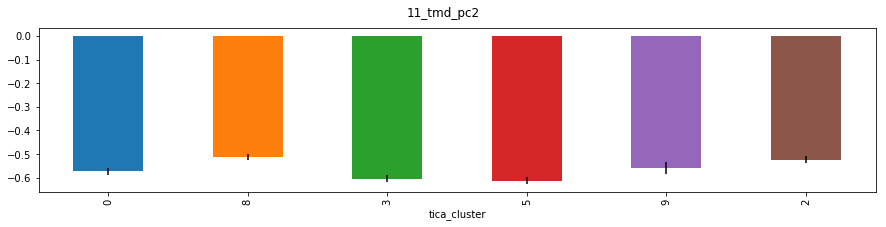

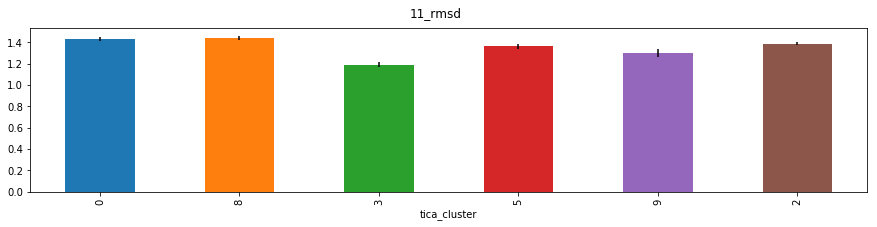

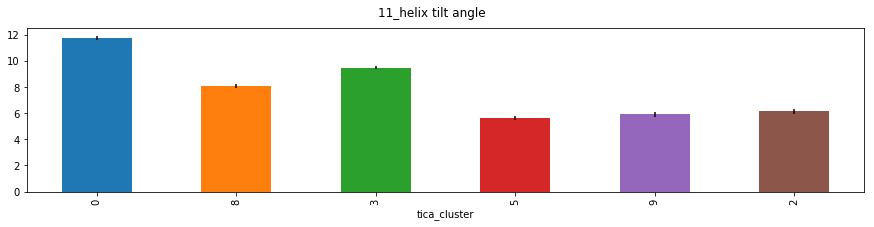

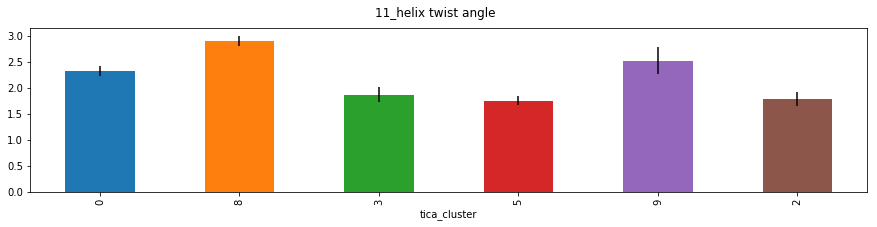

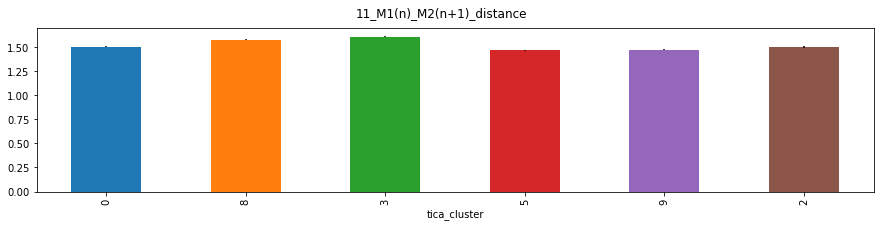

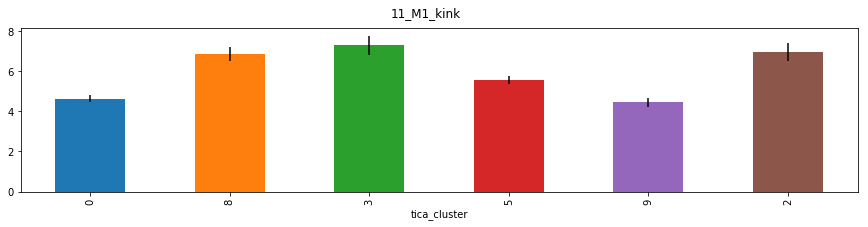

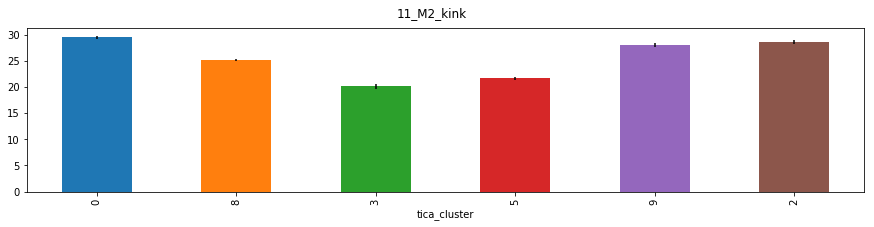

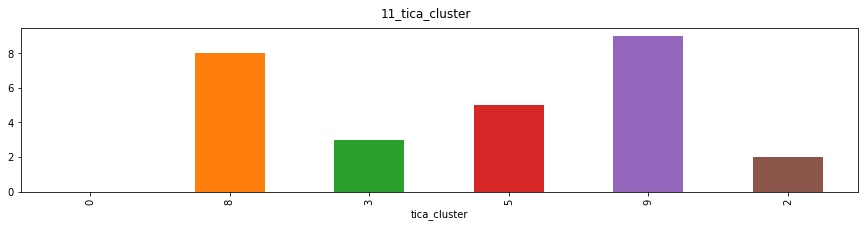

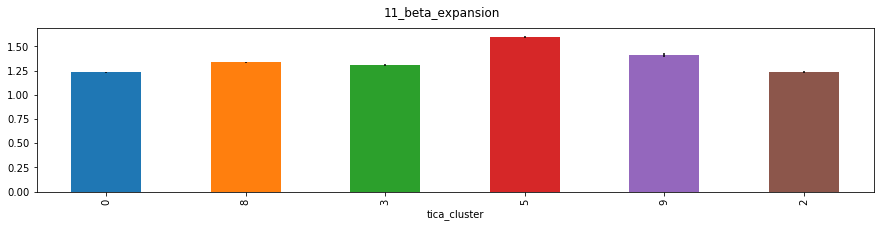

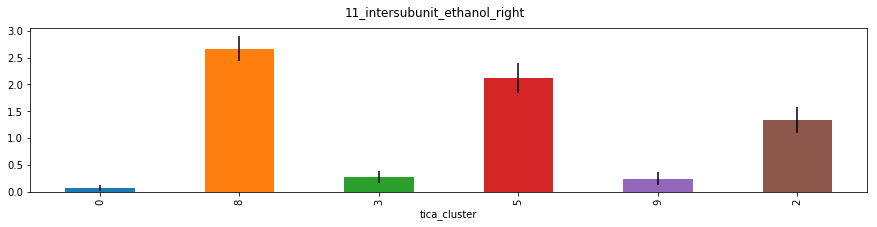

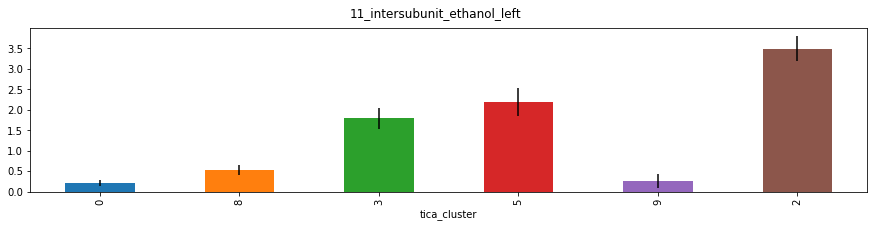

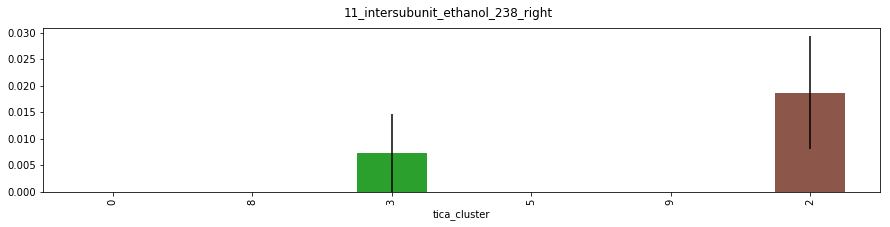

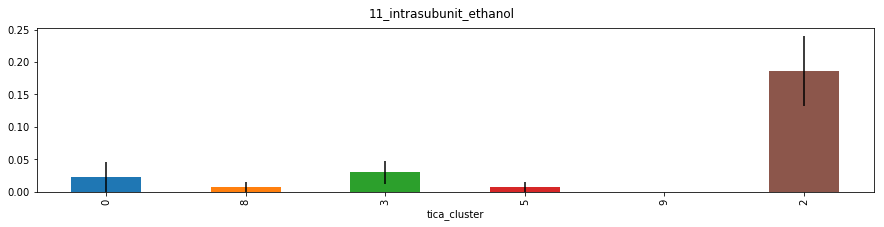

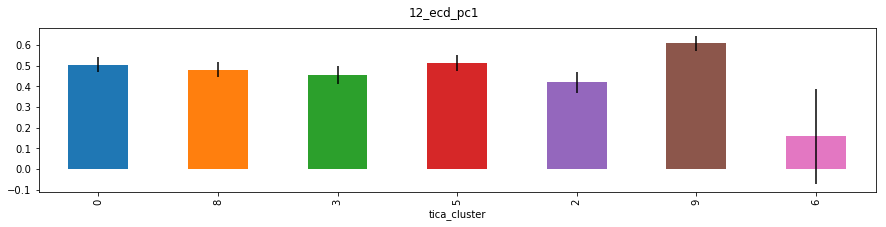

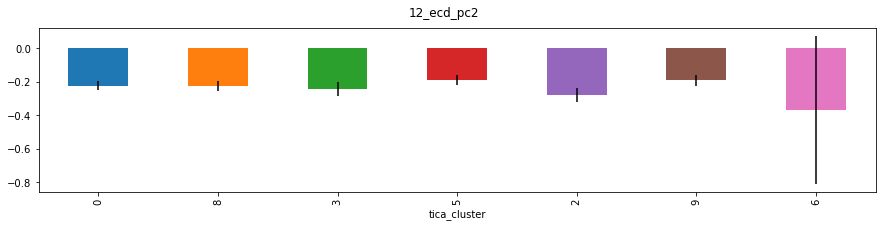

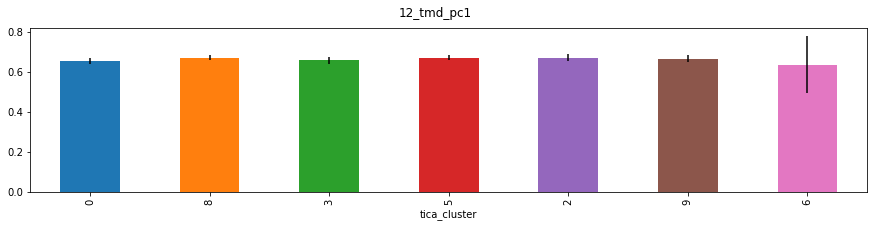

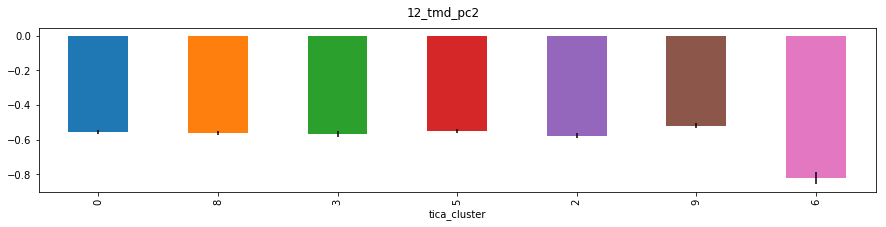

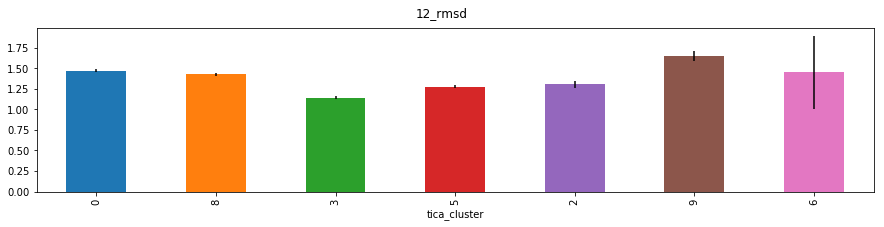

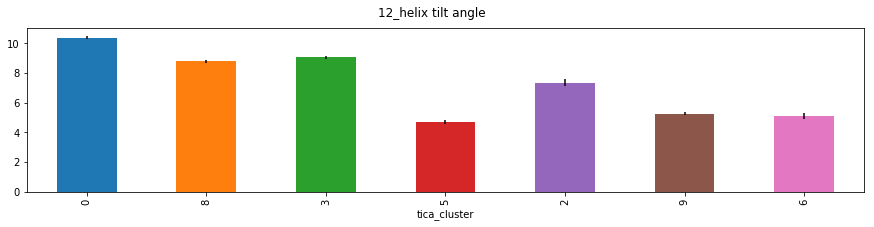

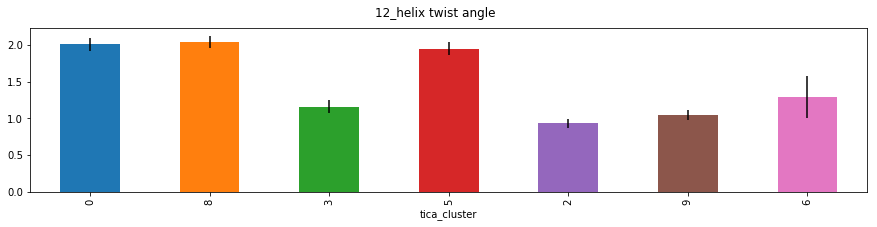

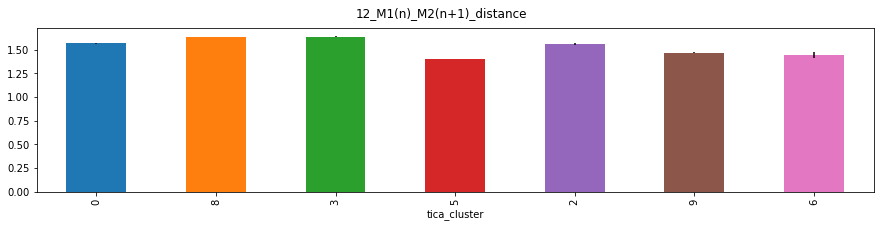

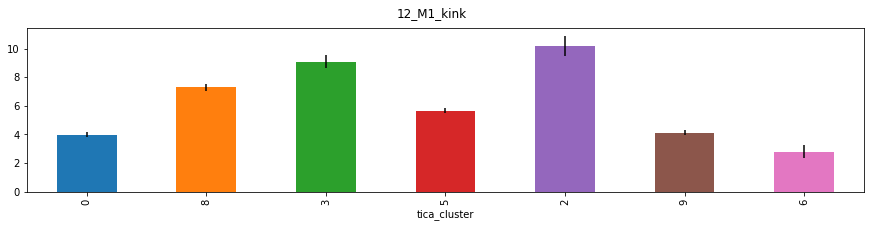

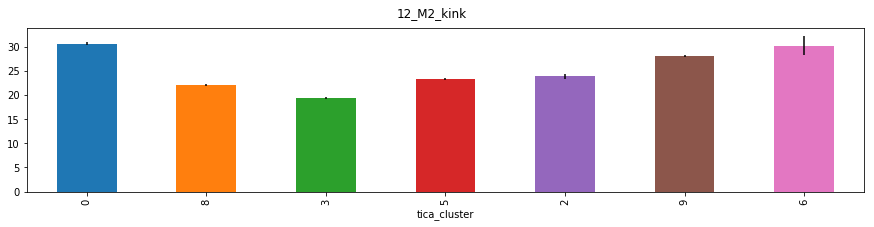

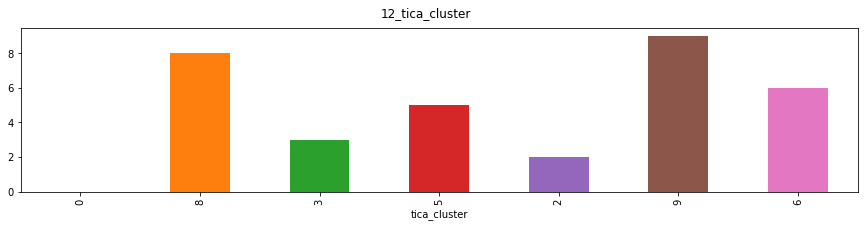

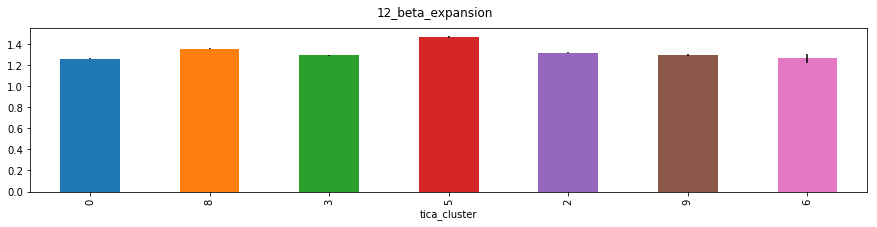

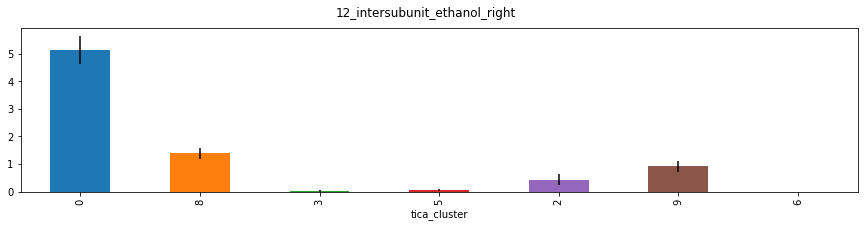

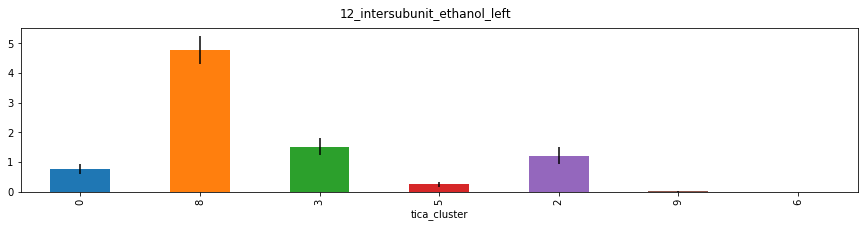

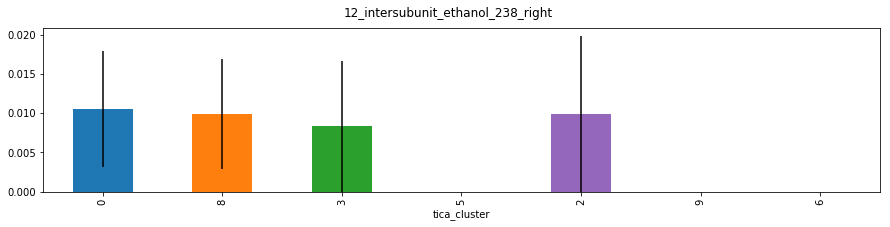

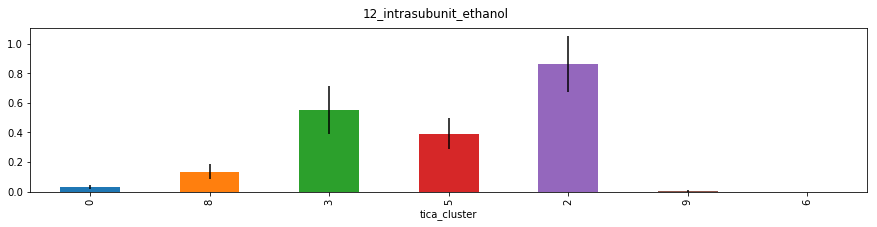

In [167]:
for system in sorted(set(md_data.system)):
    for feature in md_data.columns[6:]:

        fig, ax = plt.subplots(figsize=(15, 3))
        fig.suptitle(str(system) + '_' + feature)
        group = md_data[(md_data.system == system)].groupby(['tica_cluster'],sort=False)[feature]
        mean = group.mean()
        errors = group.sem()
        mean.plot.bar(yerr=errors,ax=ax)
#    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


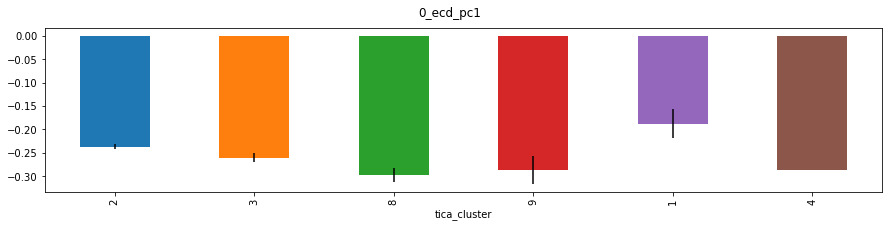

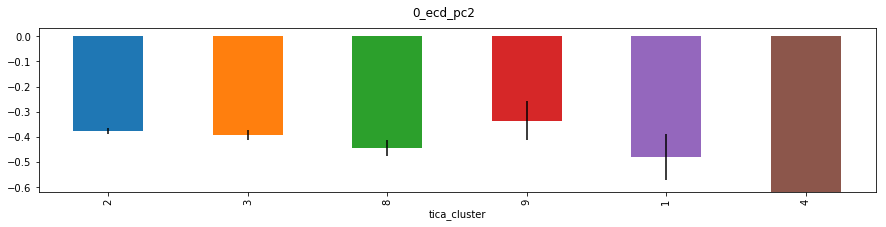

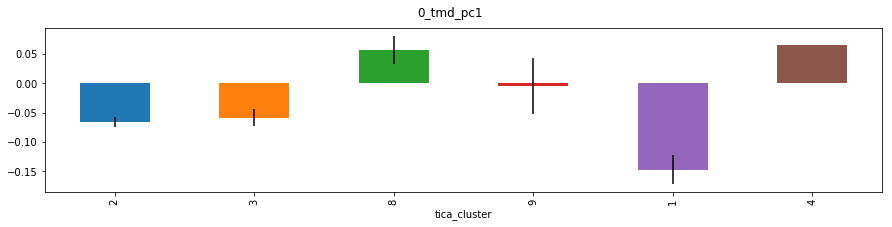

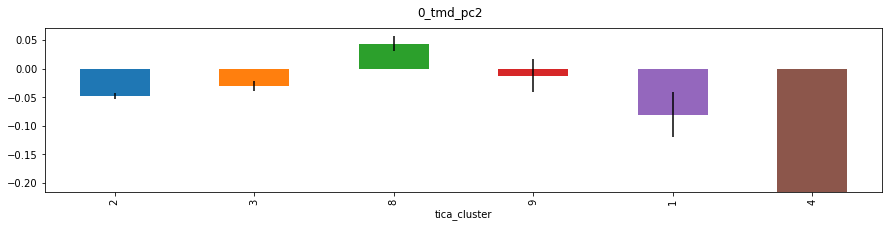

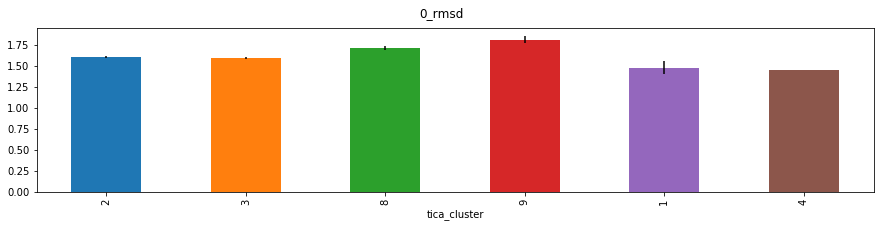

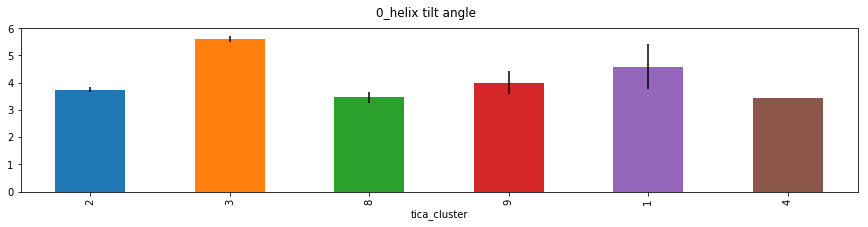

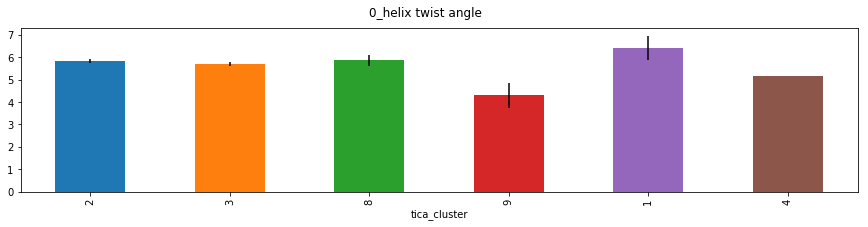

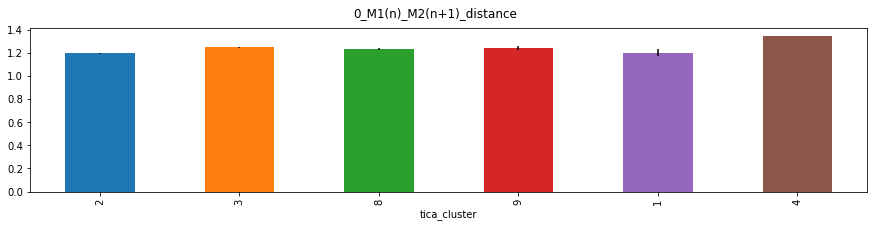

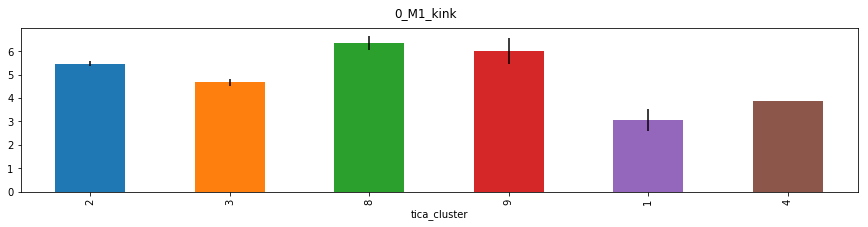

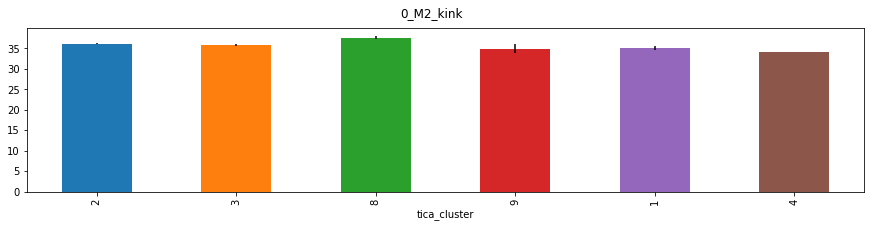

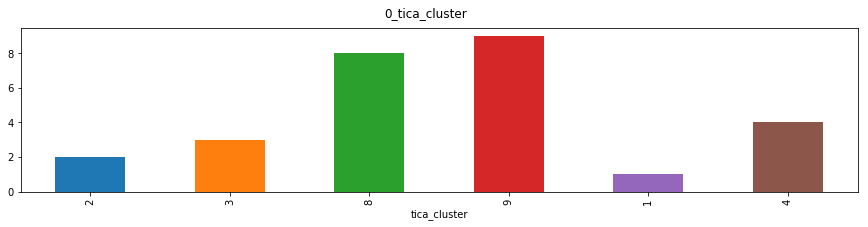

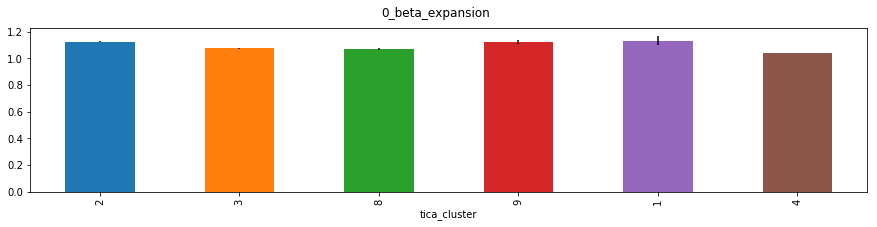

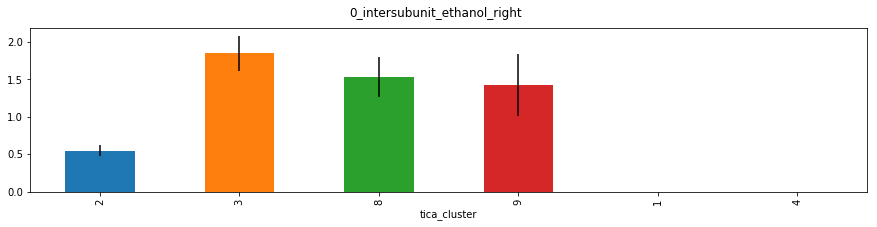

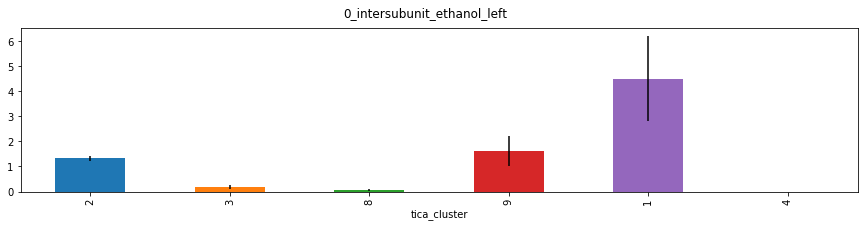

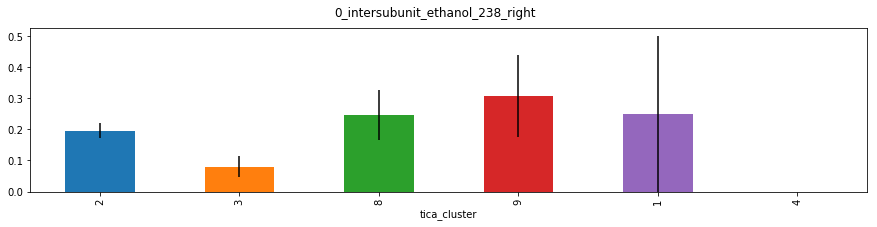

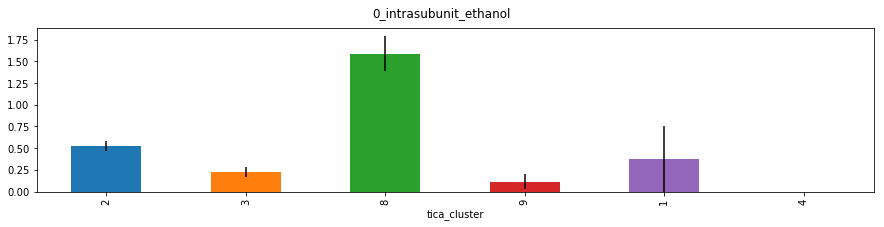

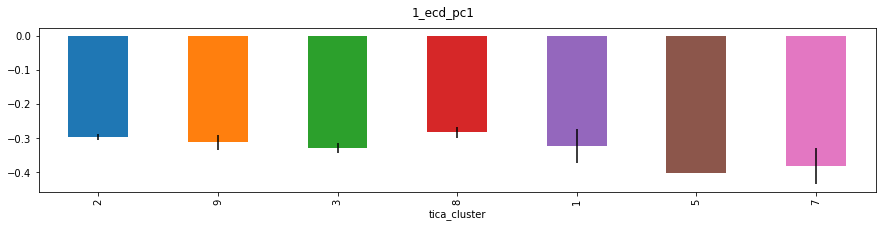

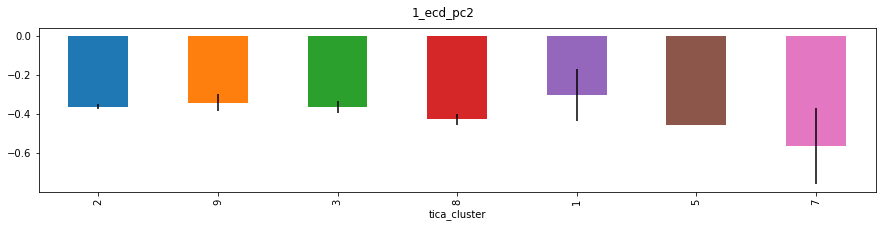

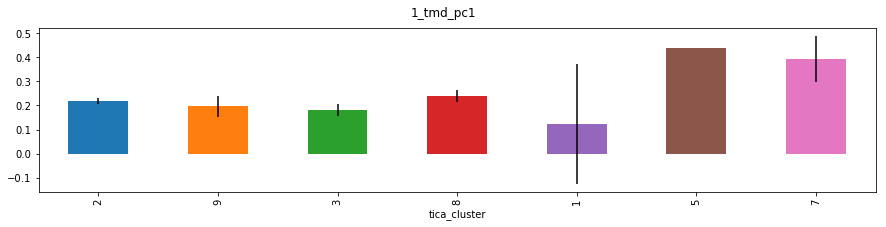

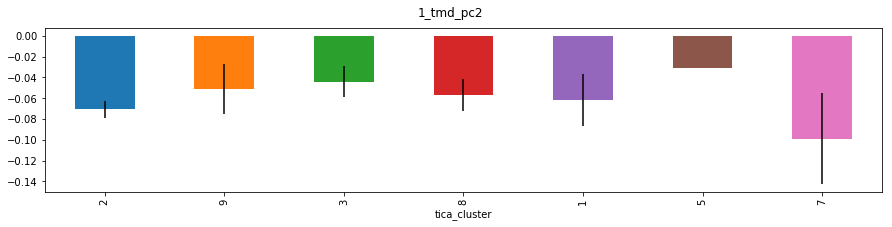

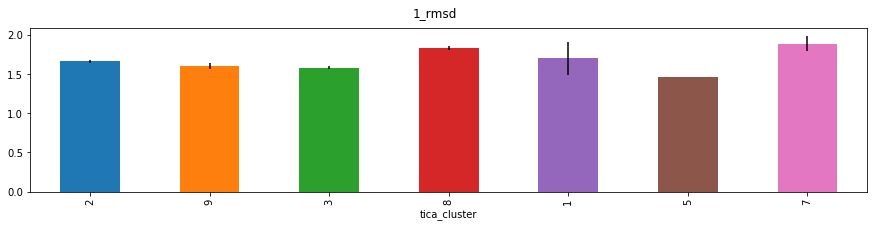

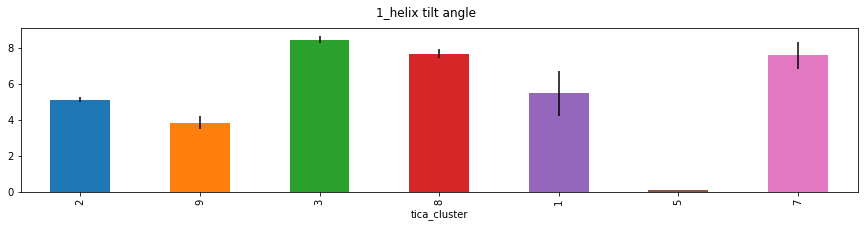

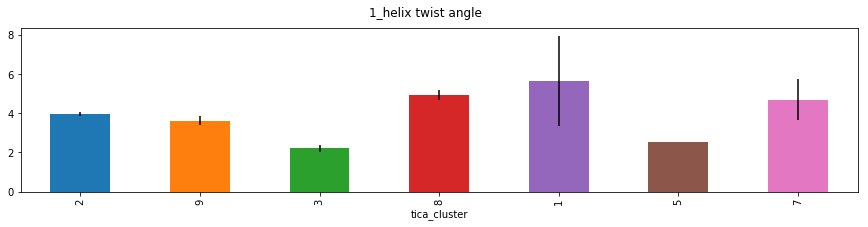

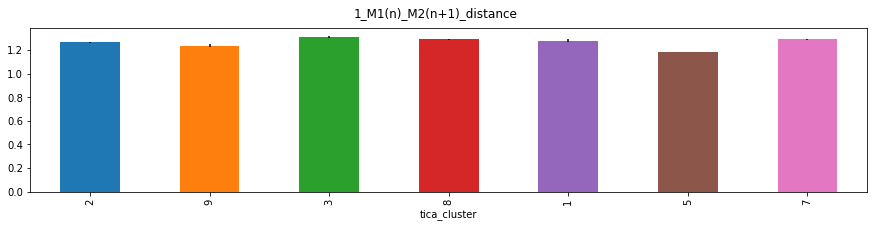

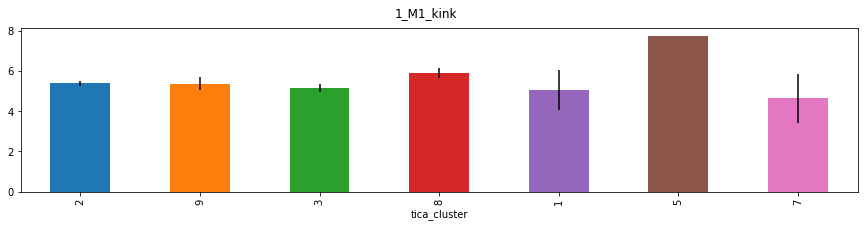

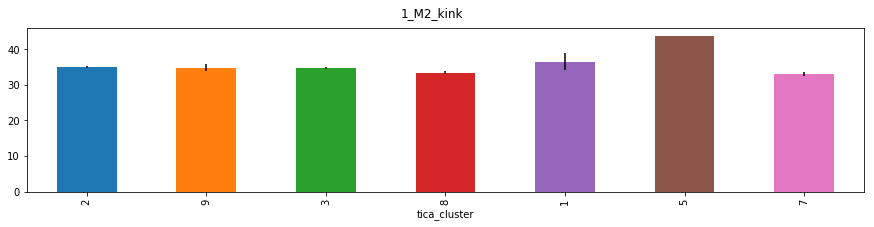

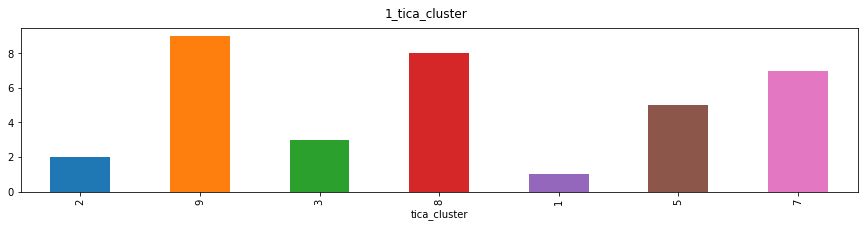

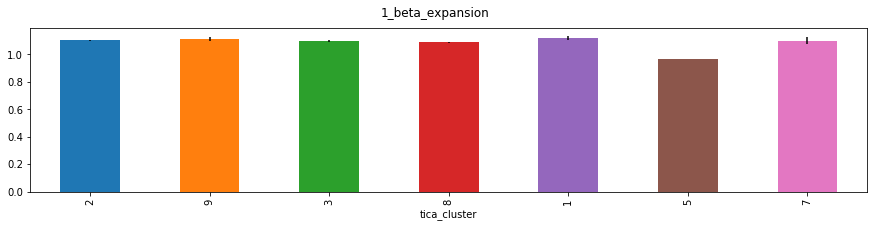

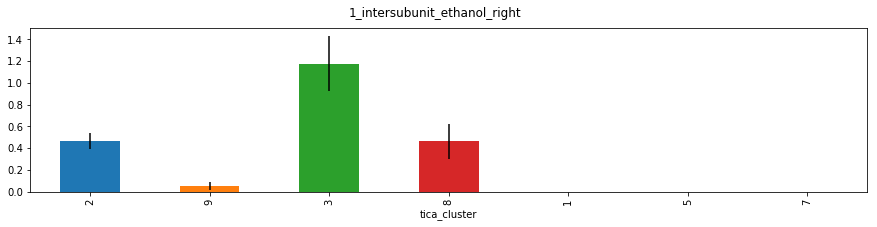

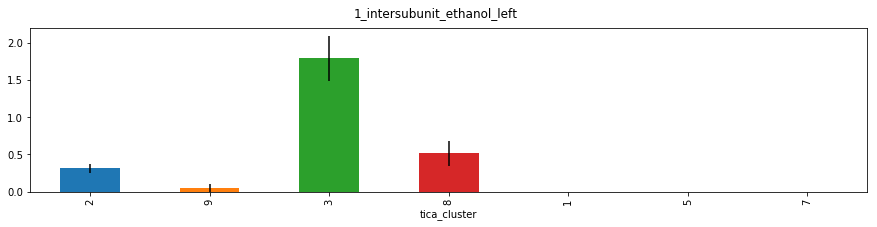

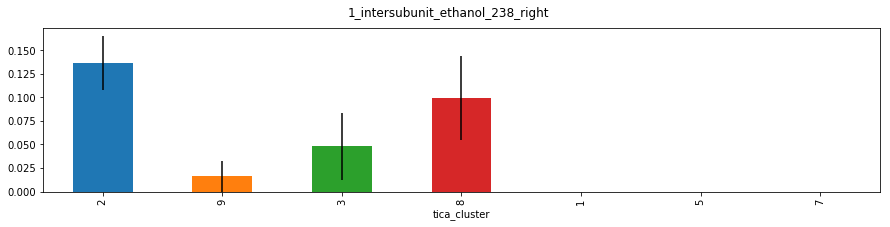

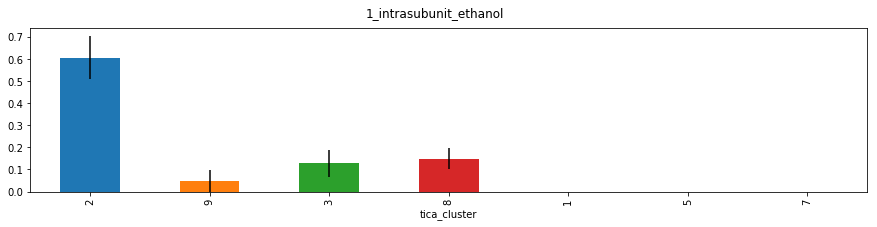

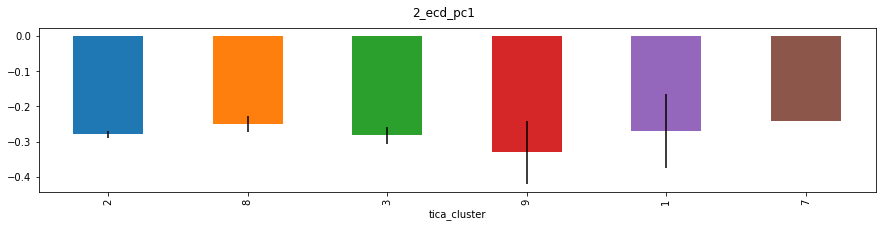

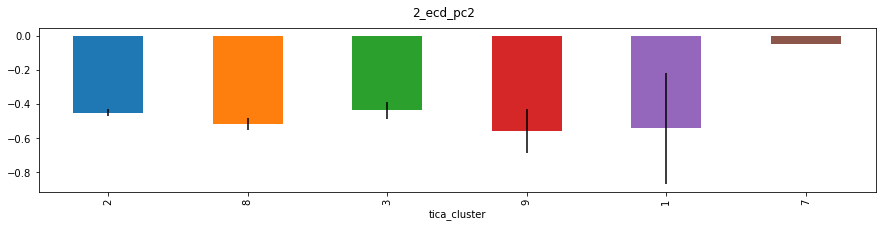

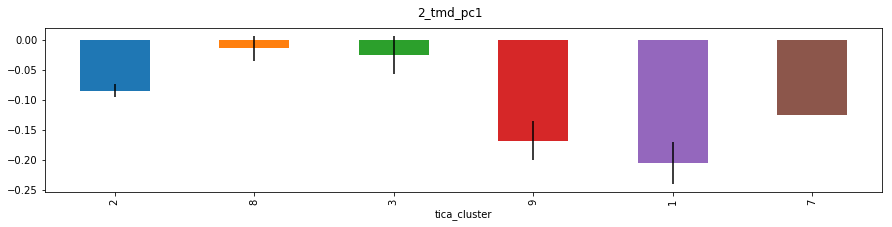

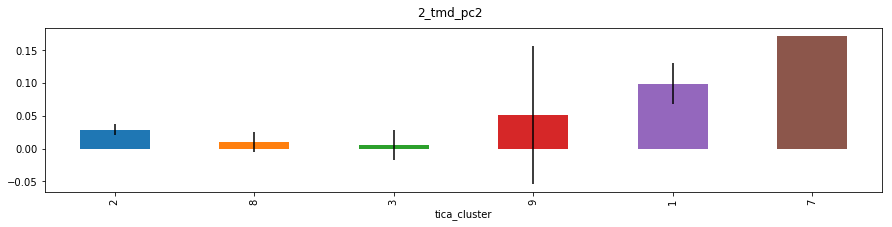

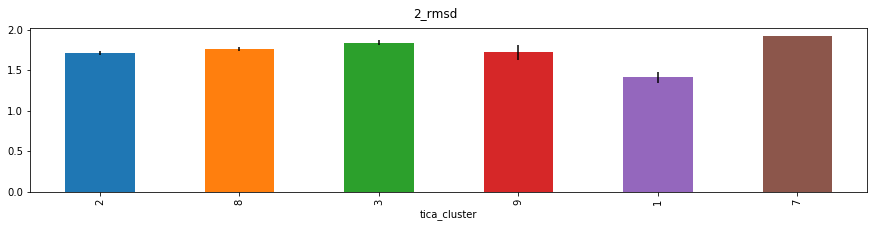

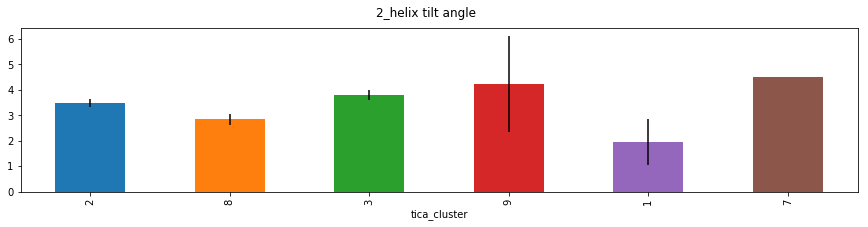

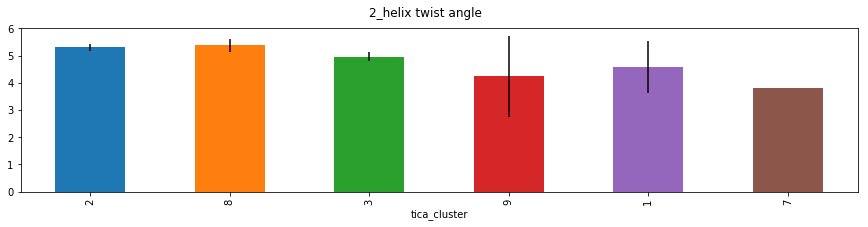

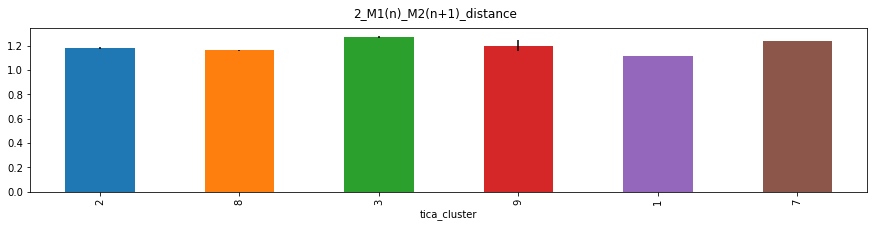

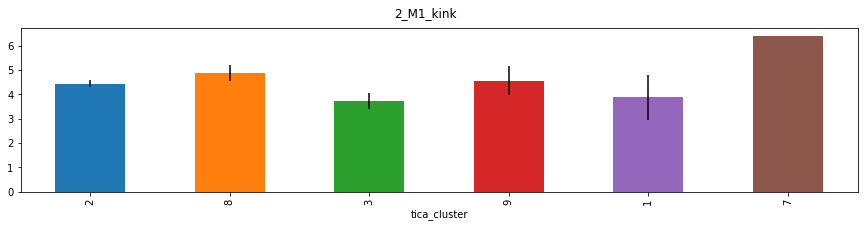

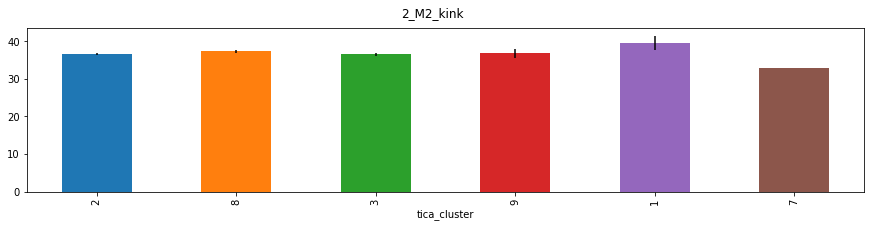

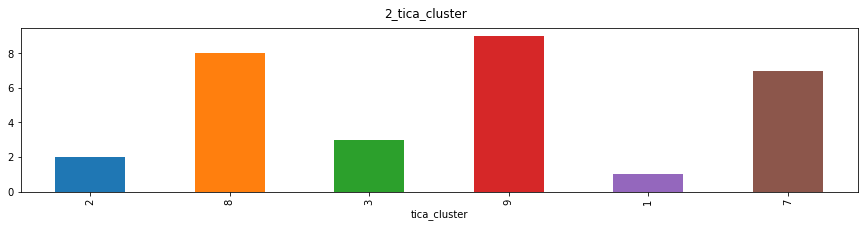

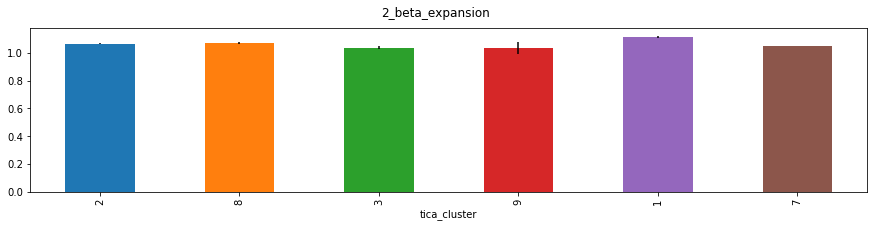

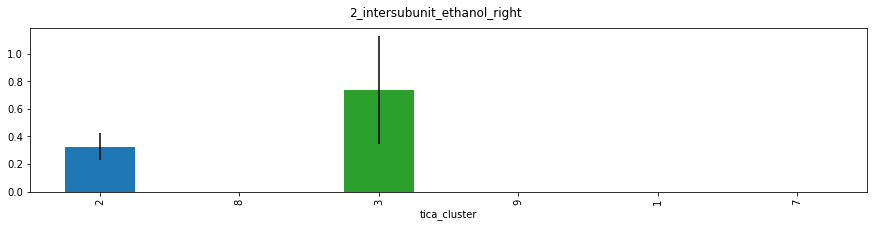

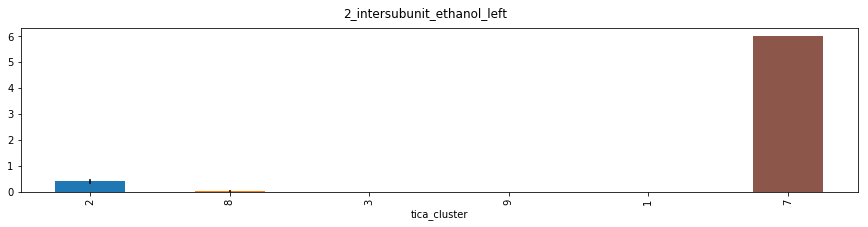

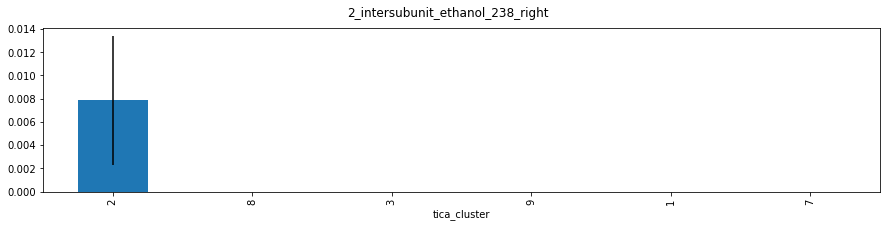

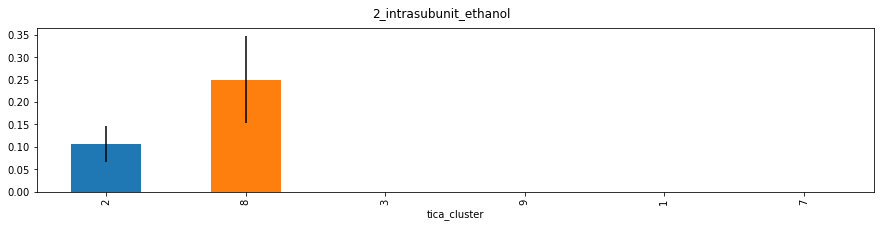

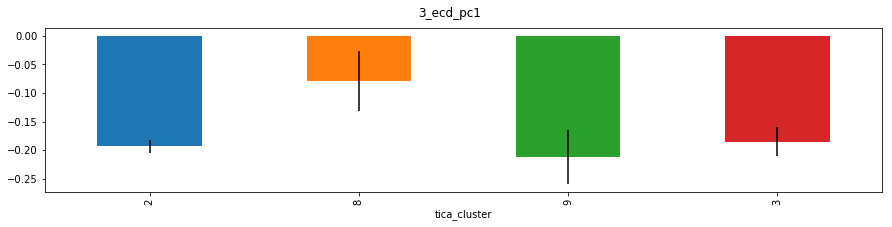

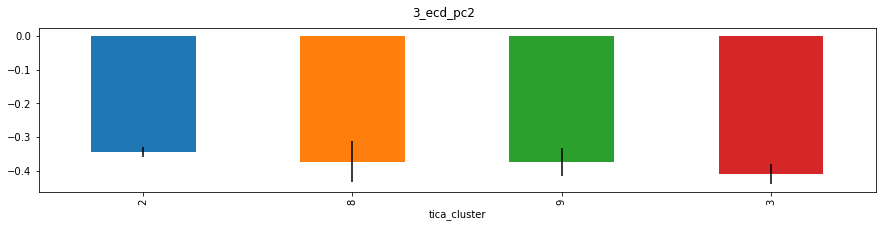

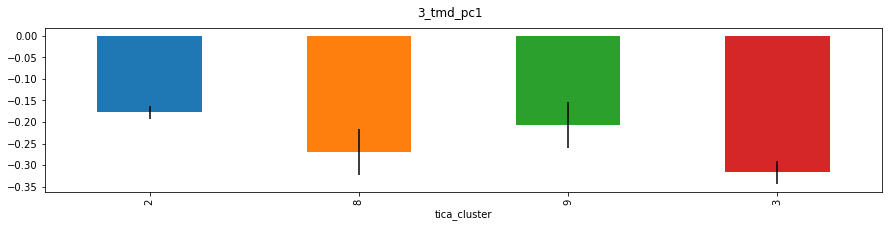

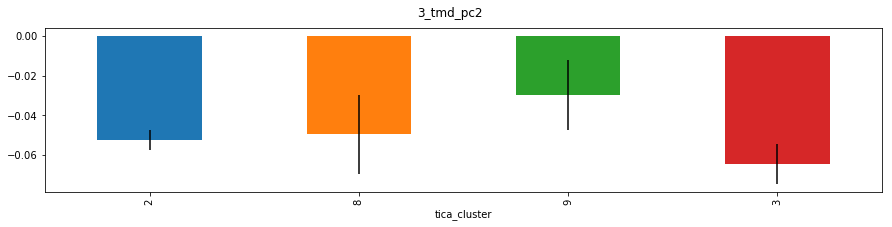

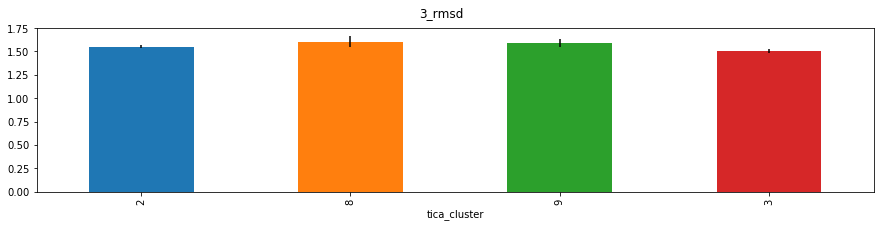

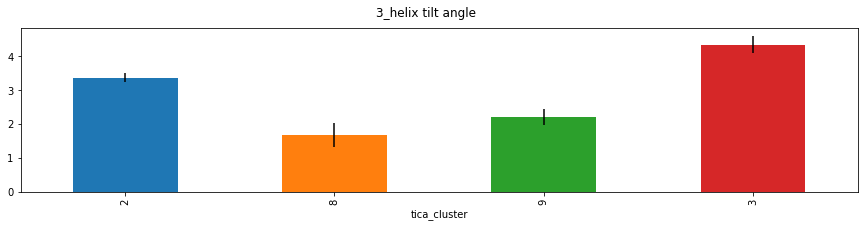

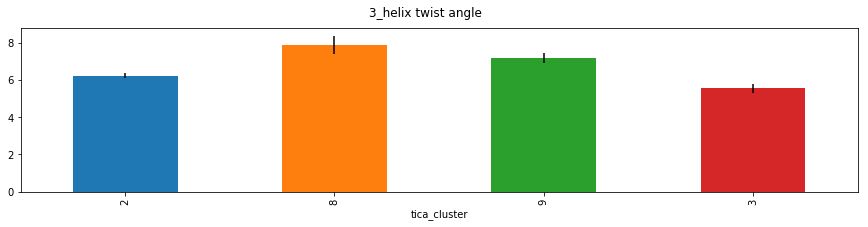

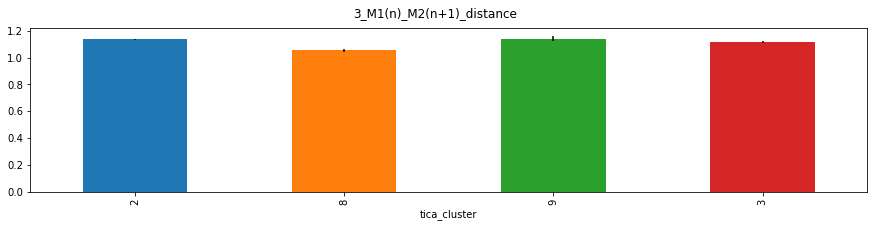

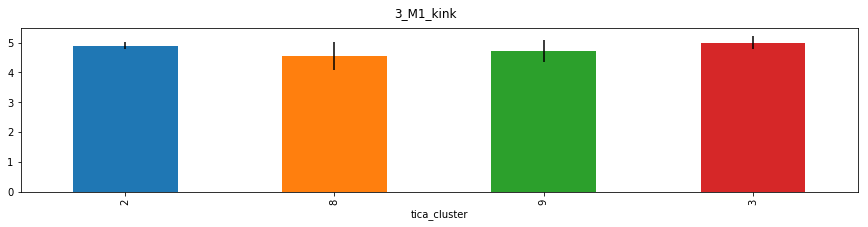

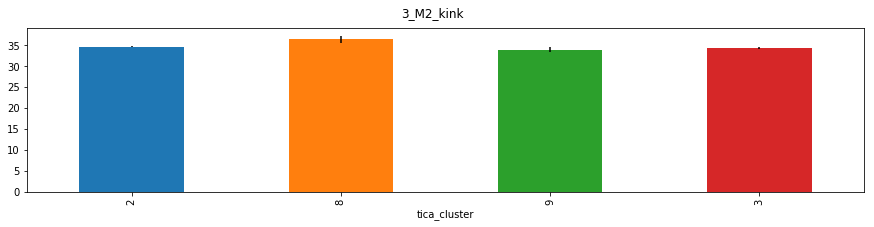

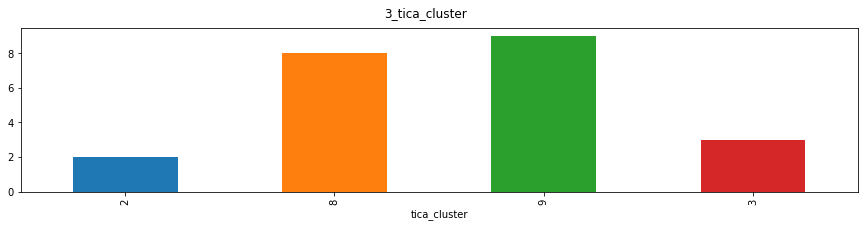

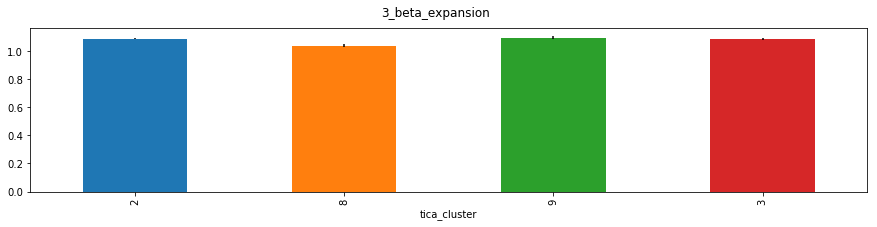

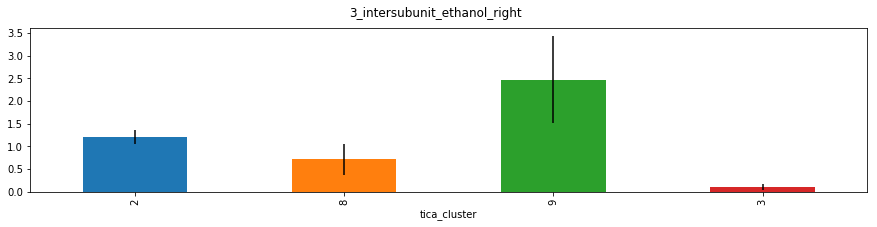

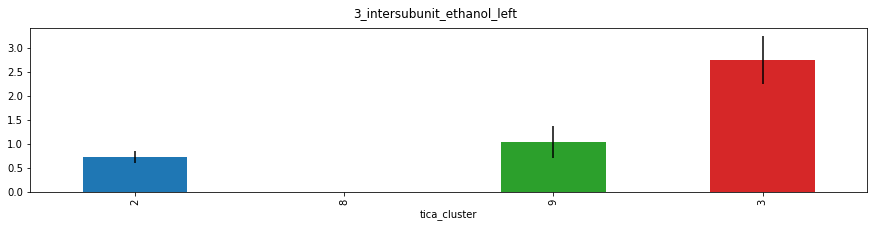

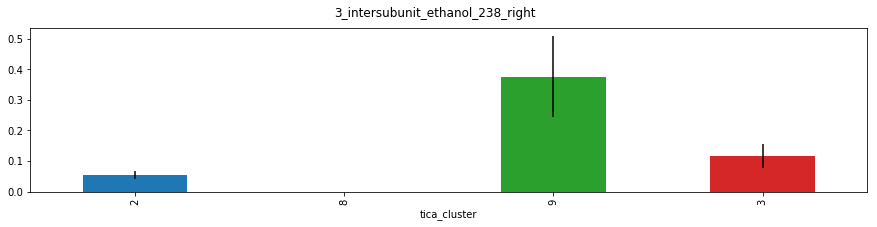

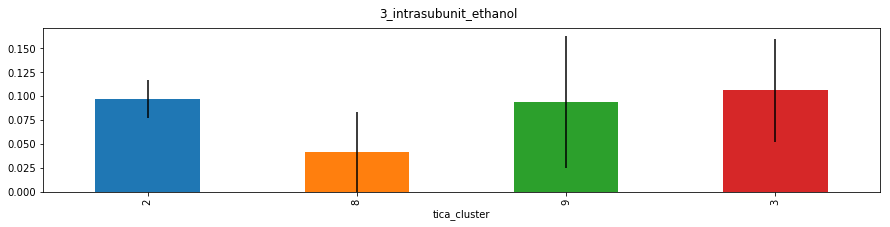

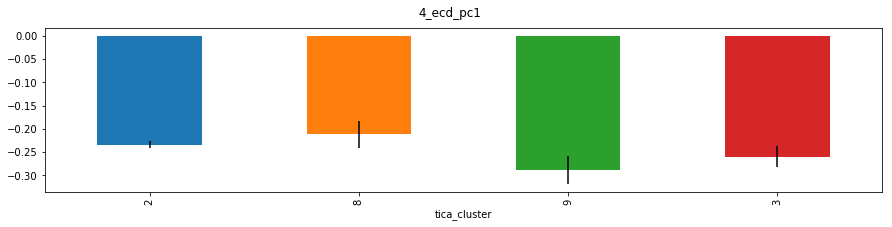

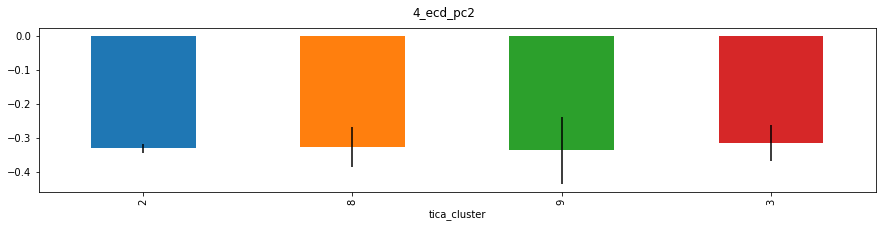

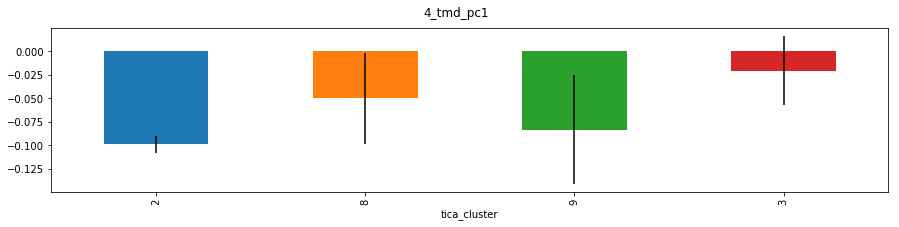

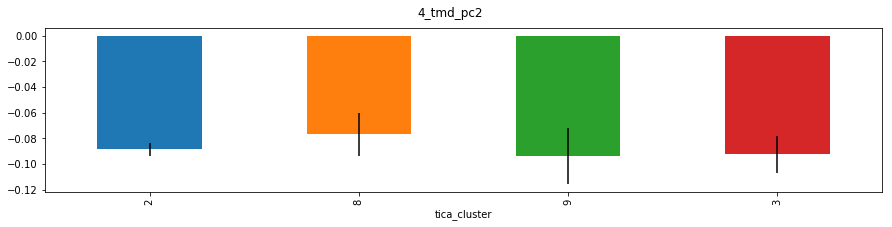

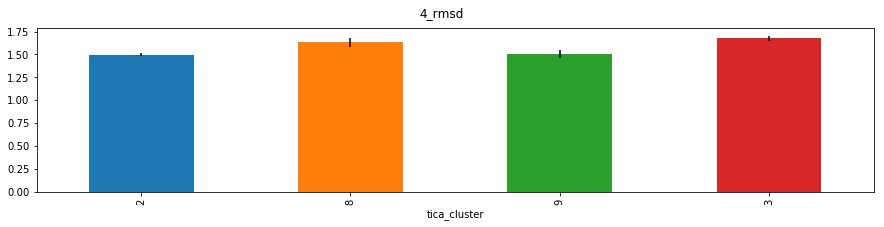

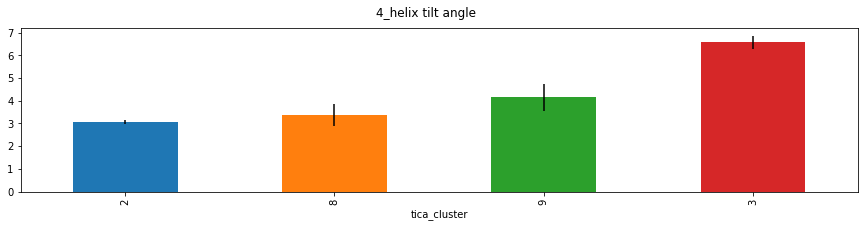

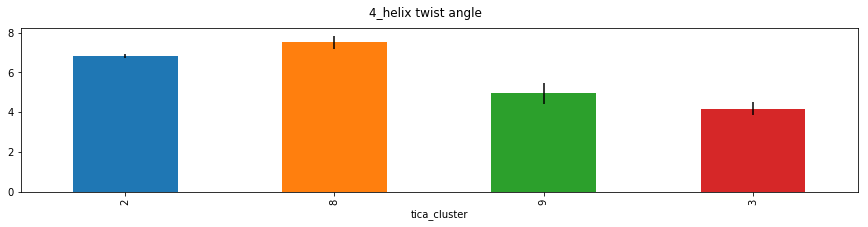

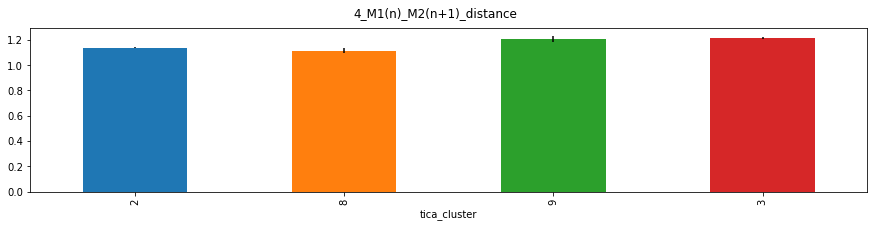

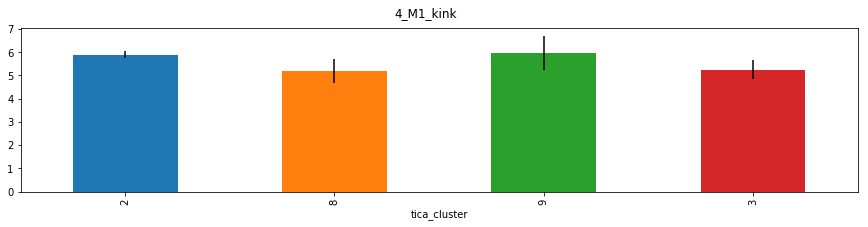

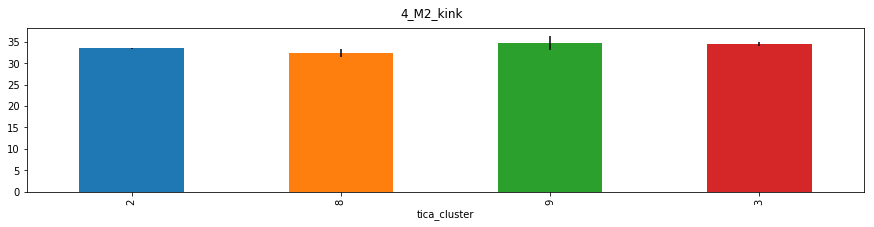

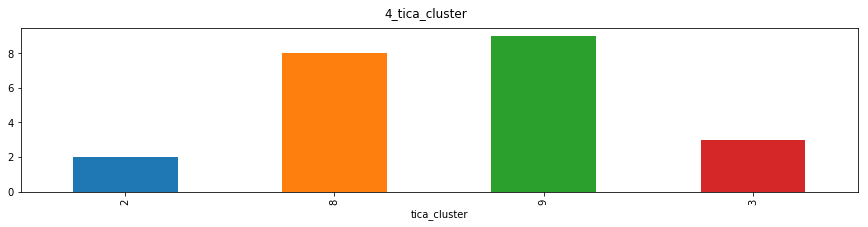

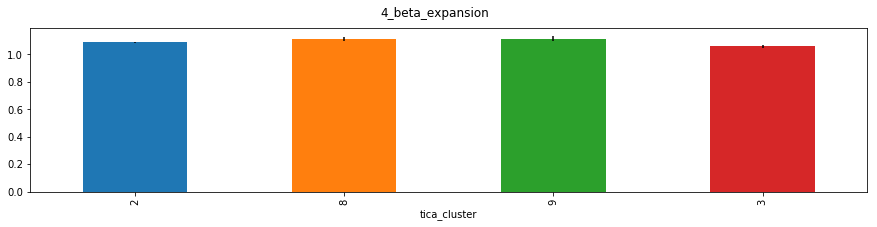

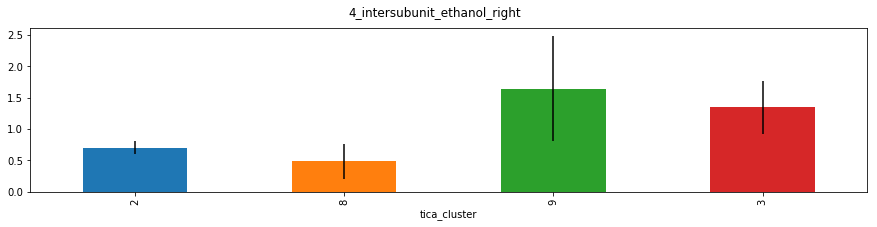

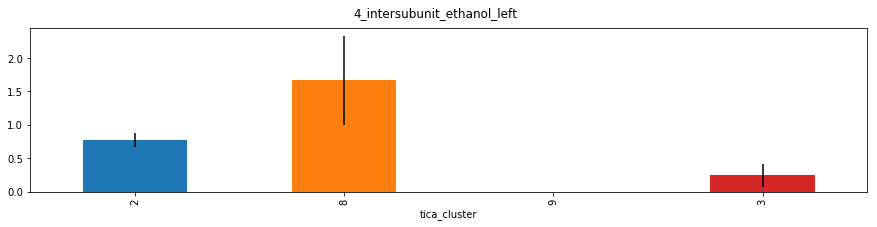

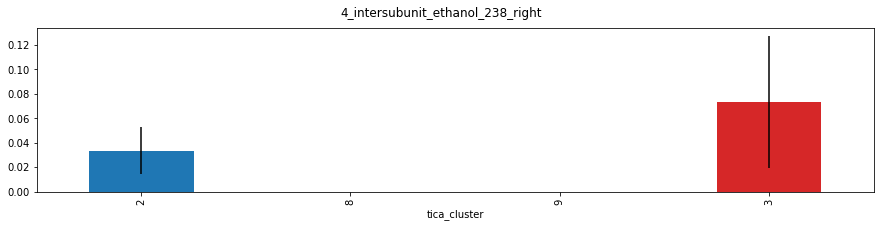

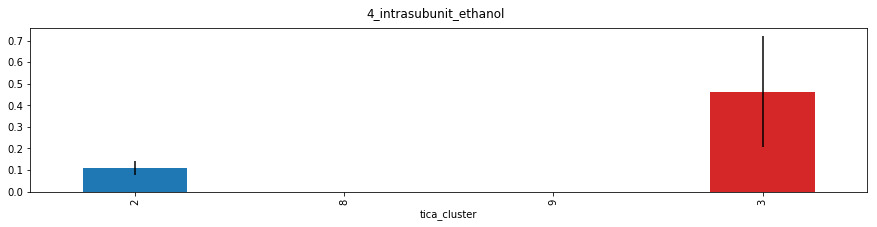

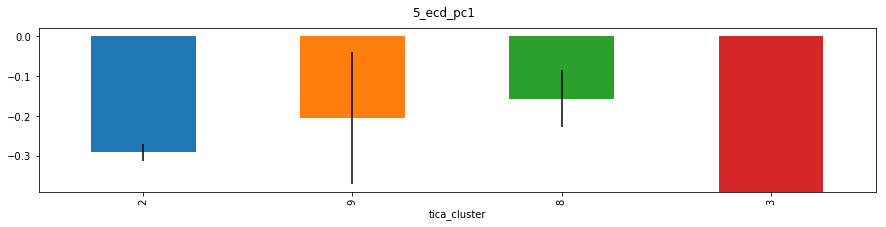

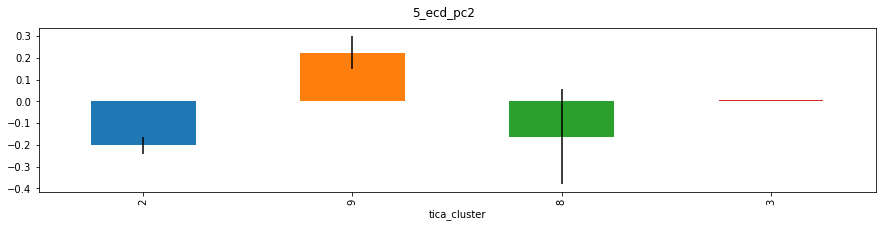

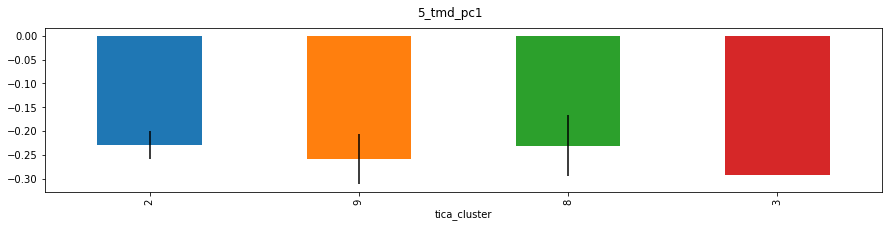

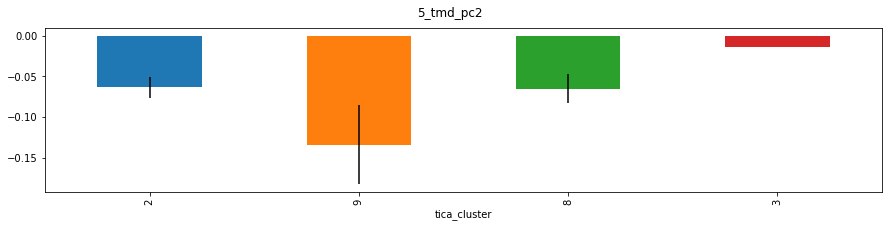

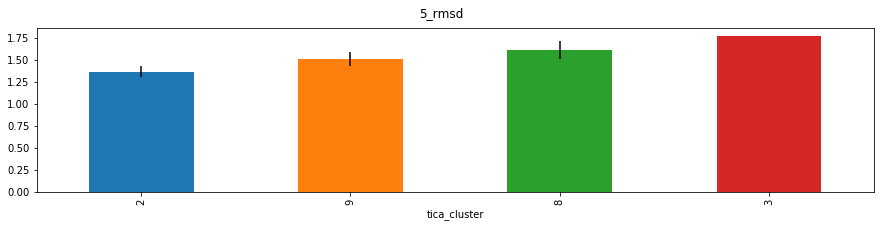

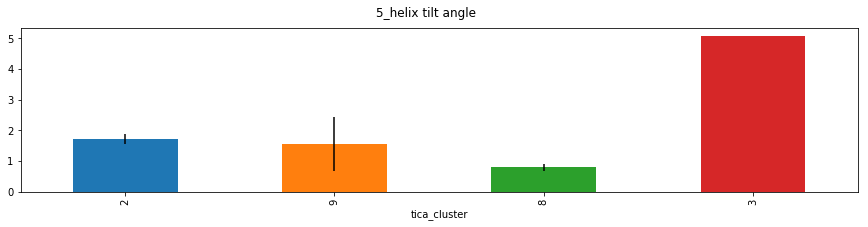

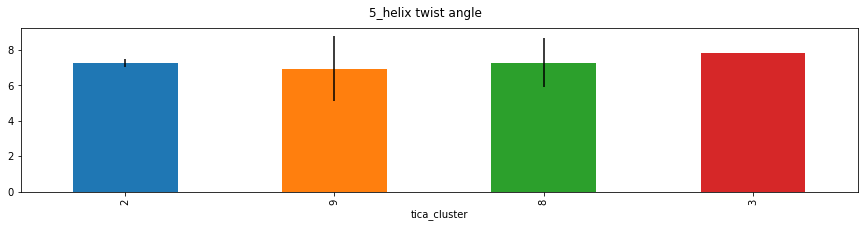

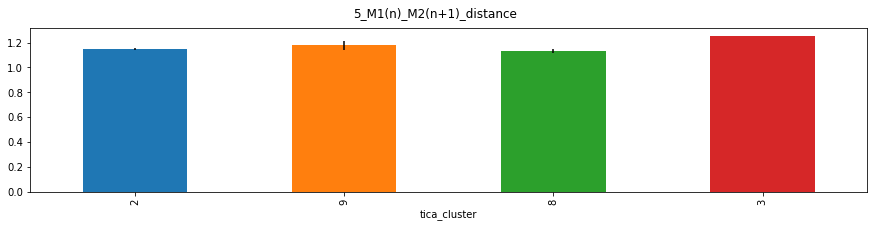

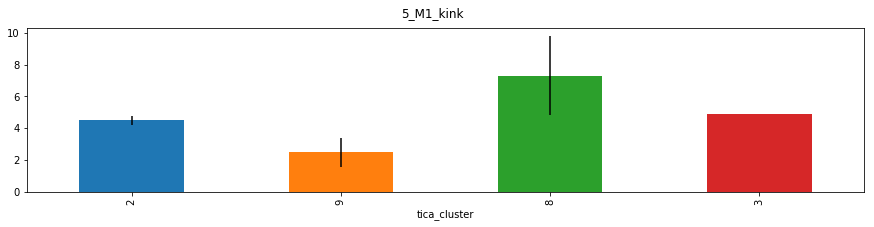

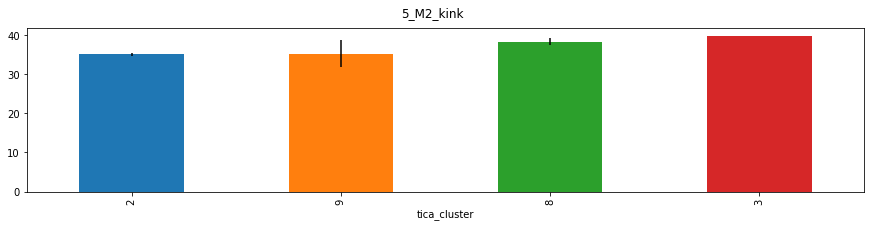

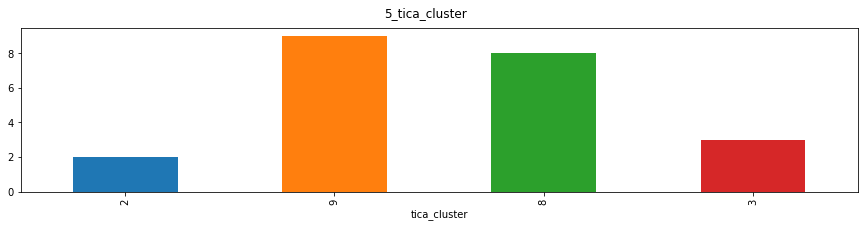

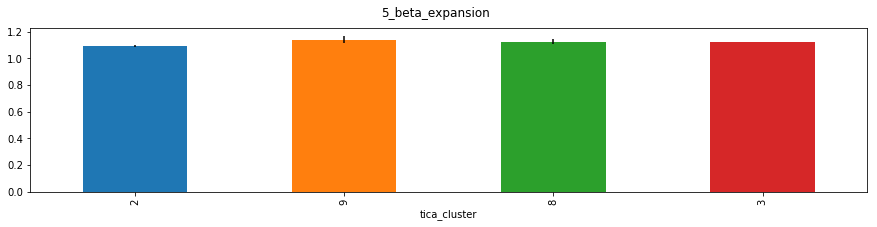

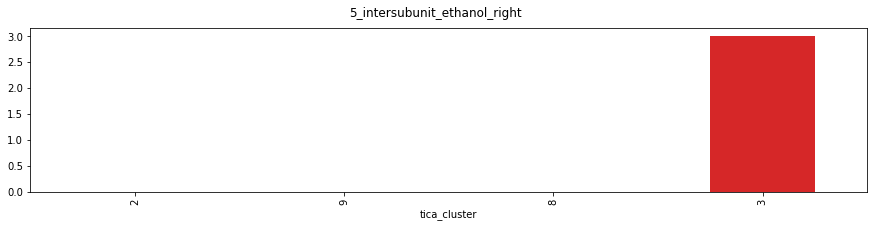

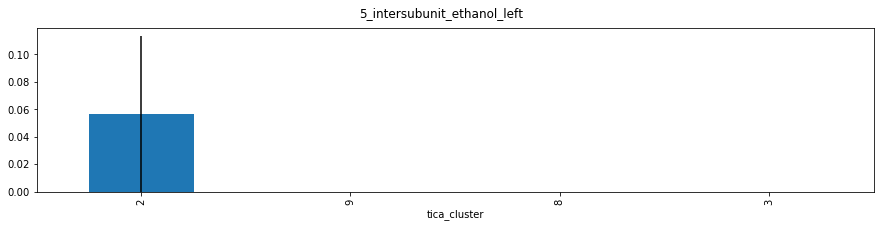

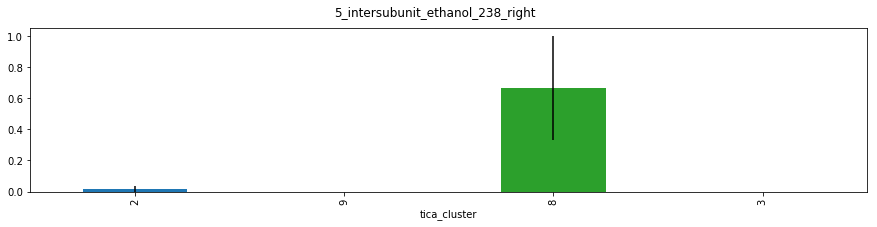

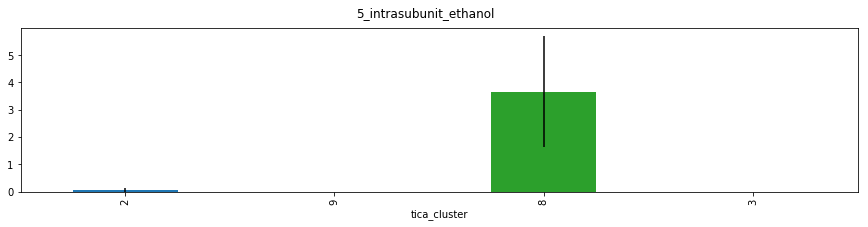

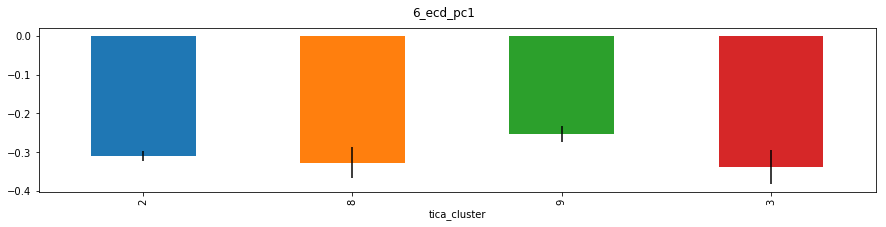

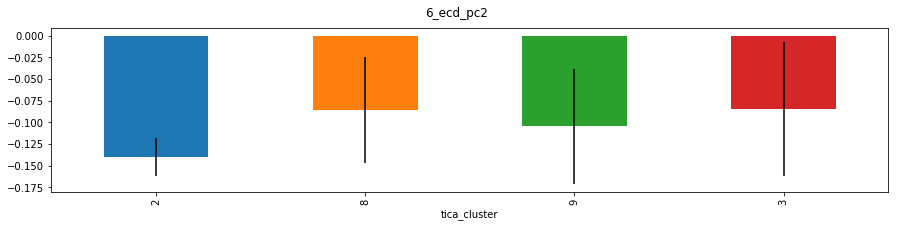

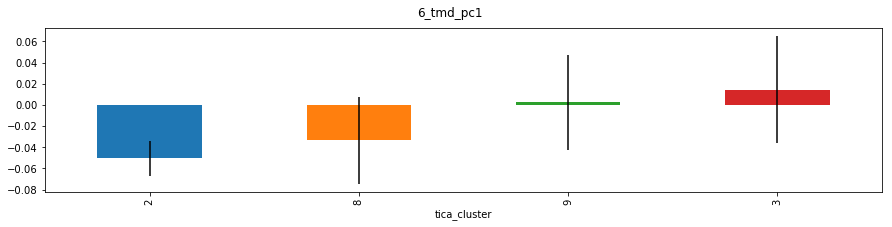

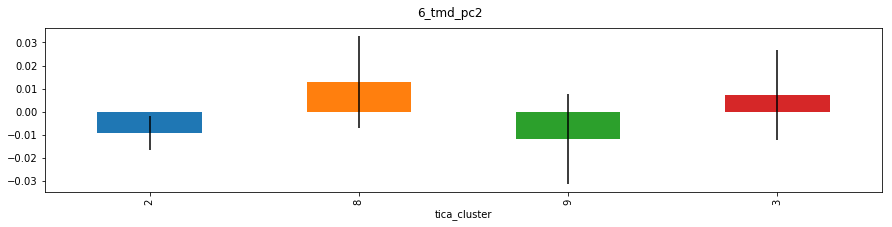

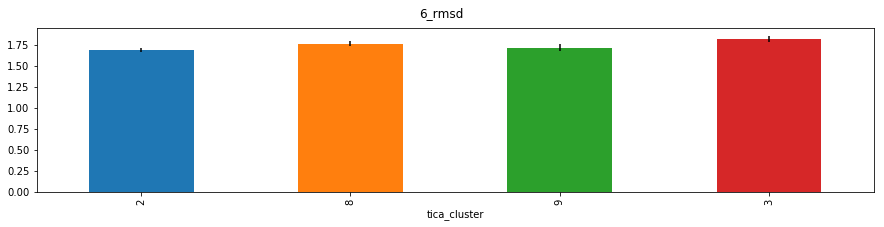

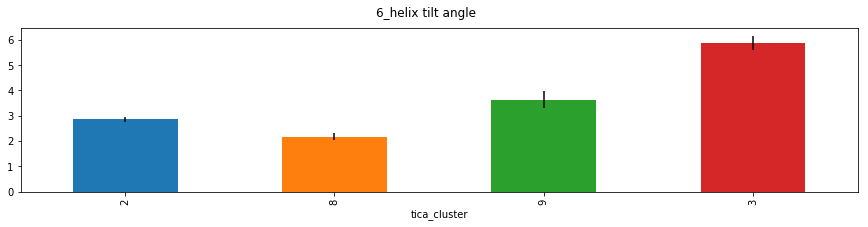

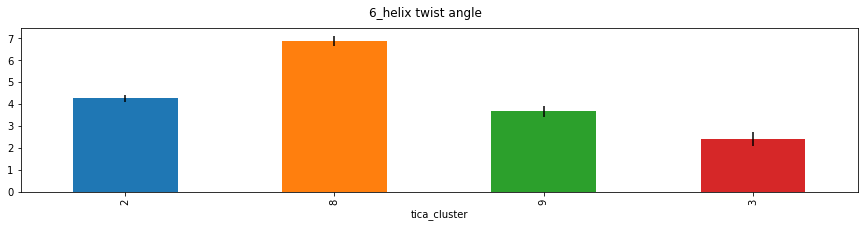

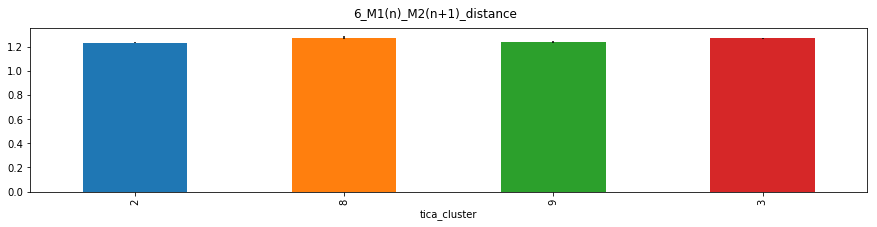

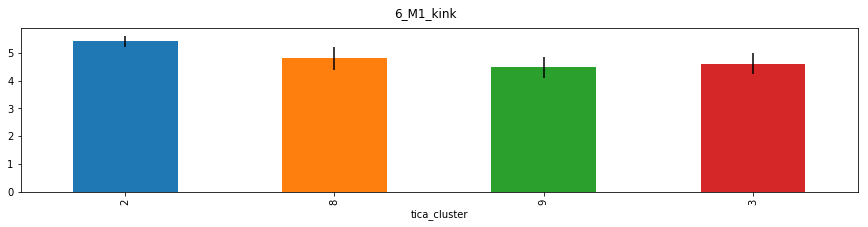

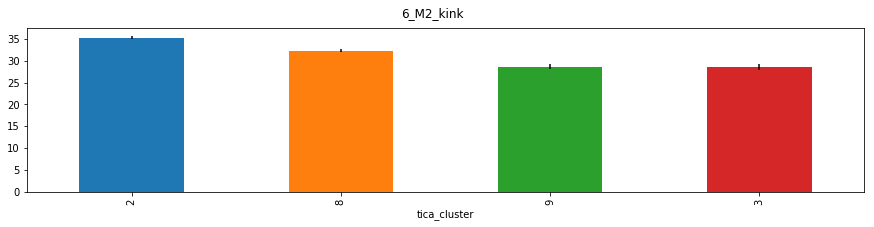

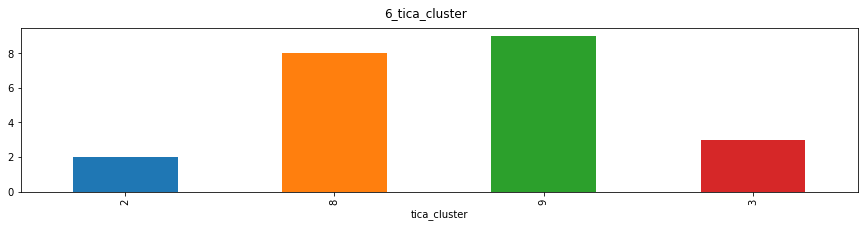

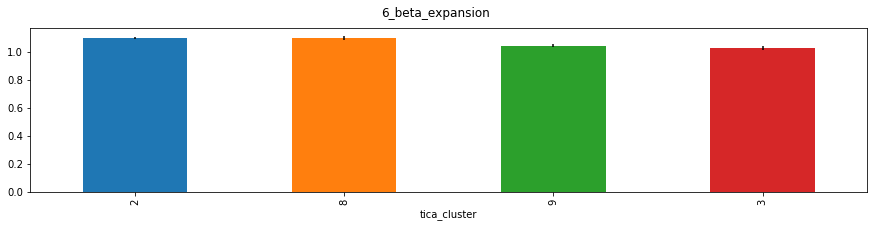

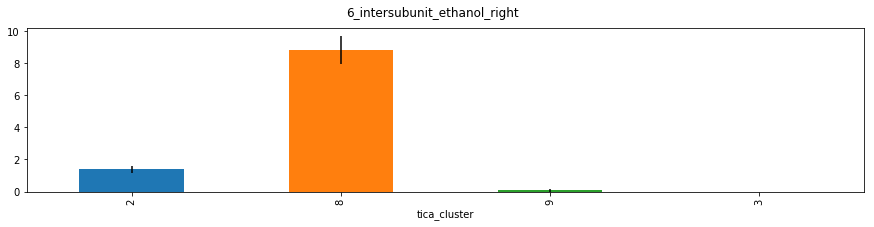

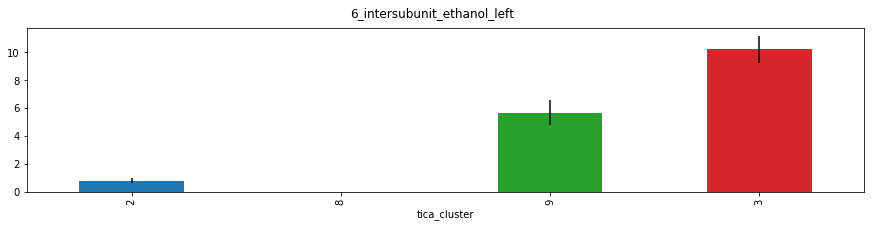

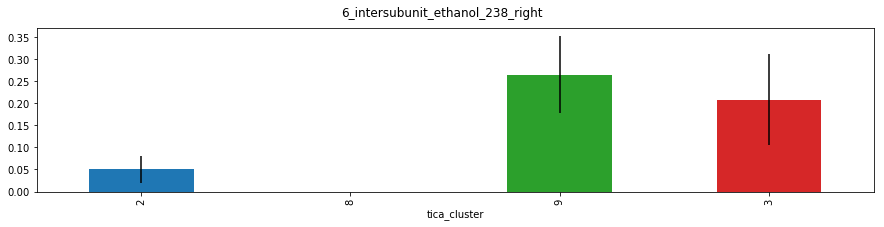

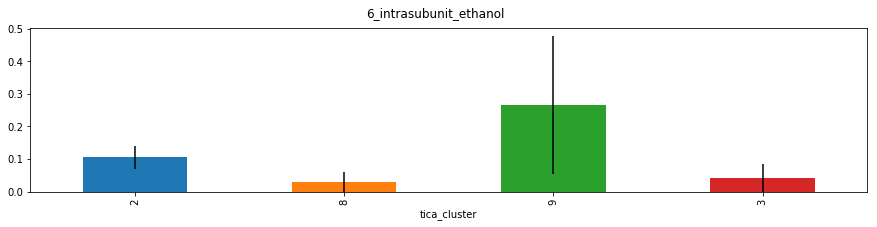

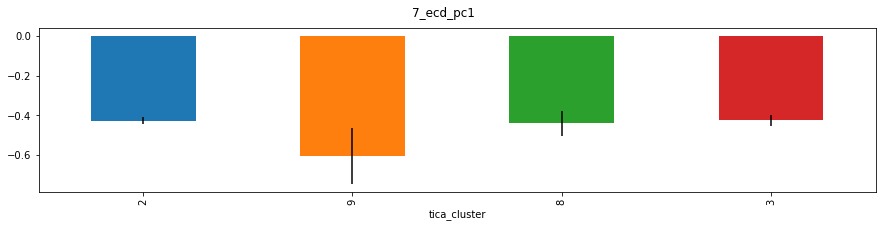

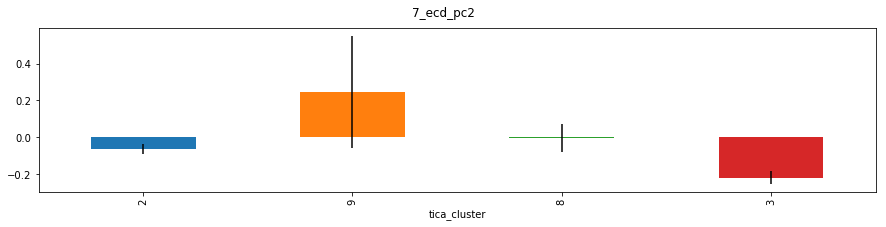

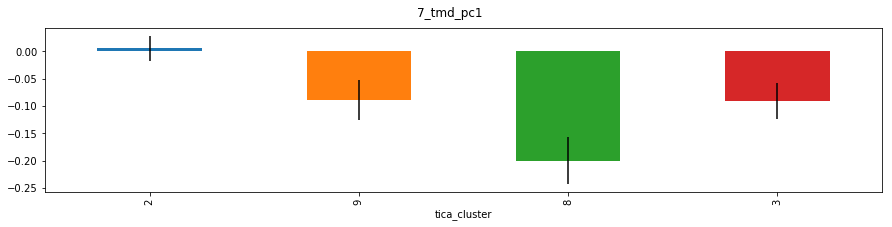

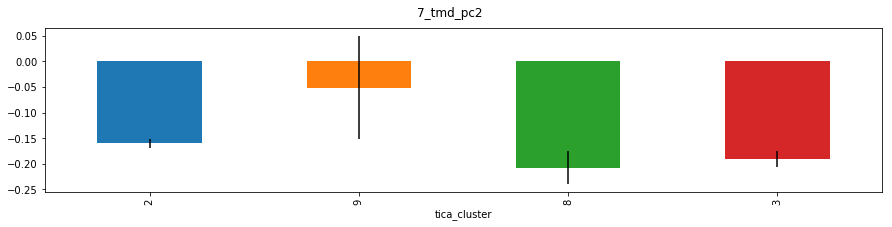

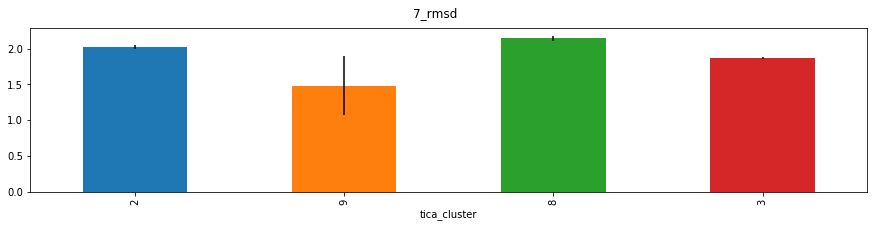

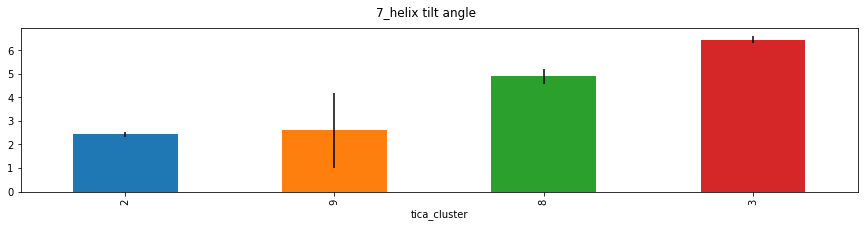

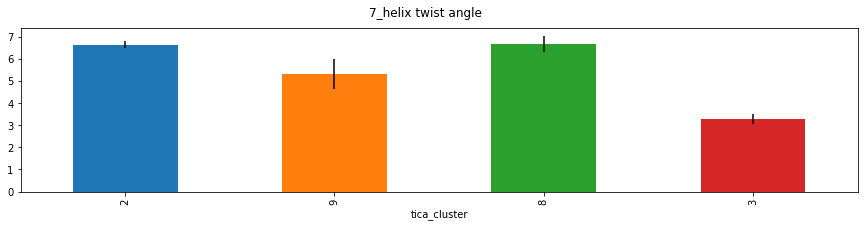

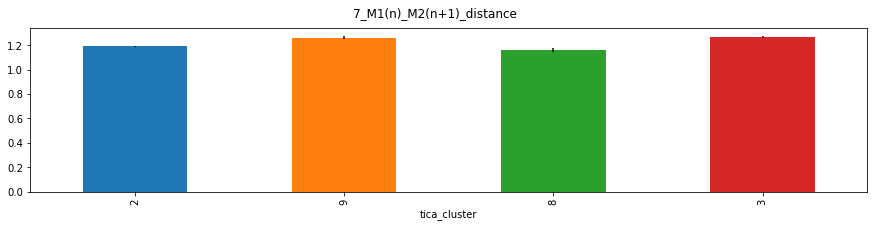

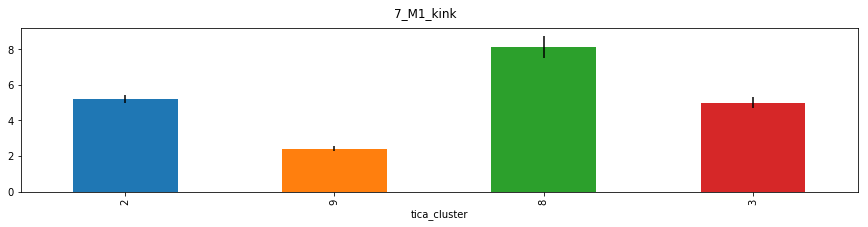

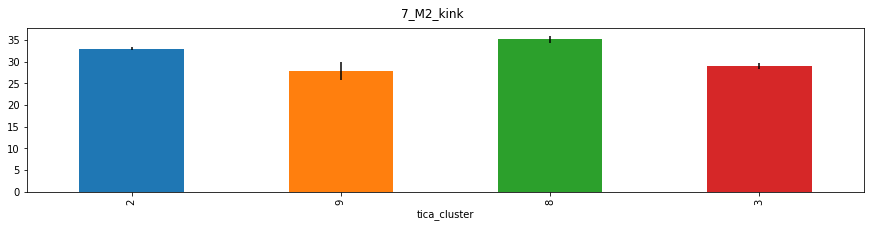

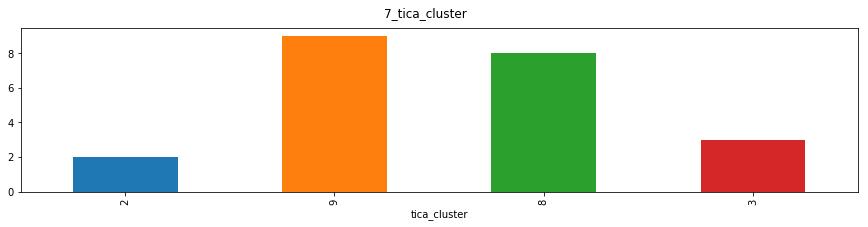

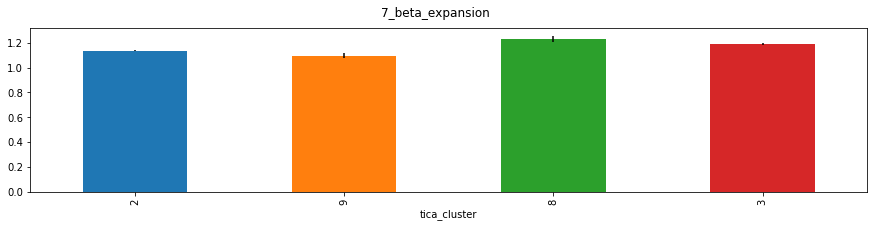

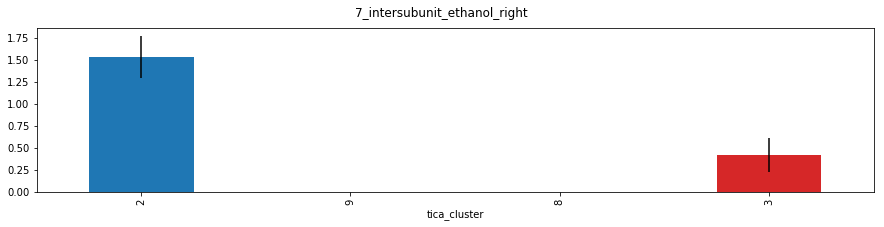

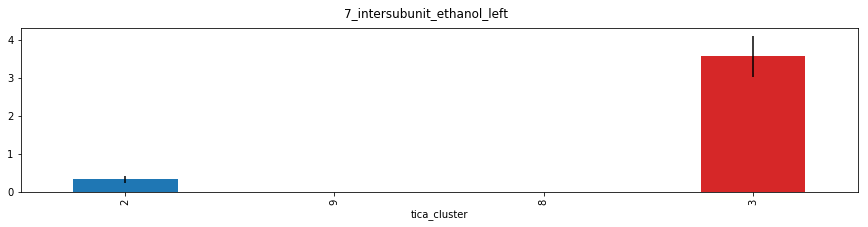

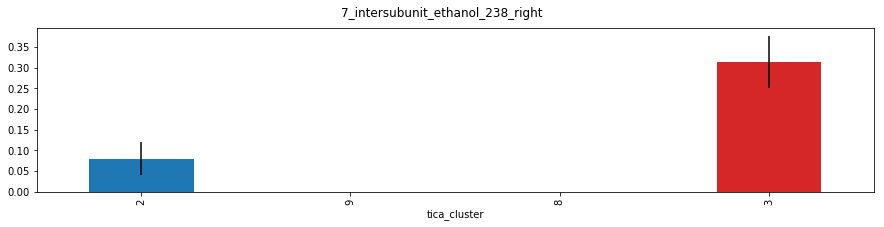

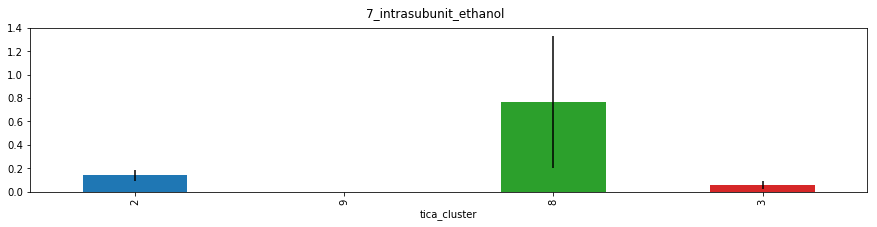

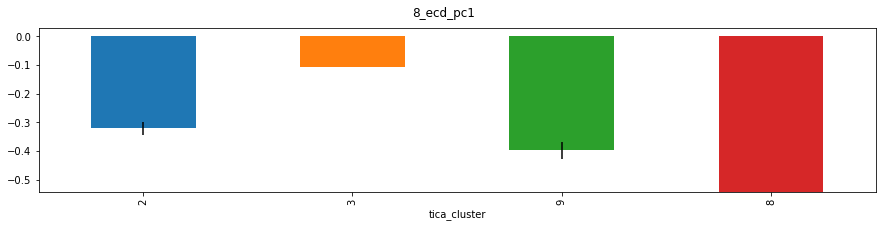

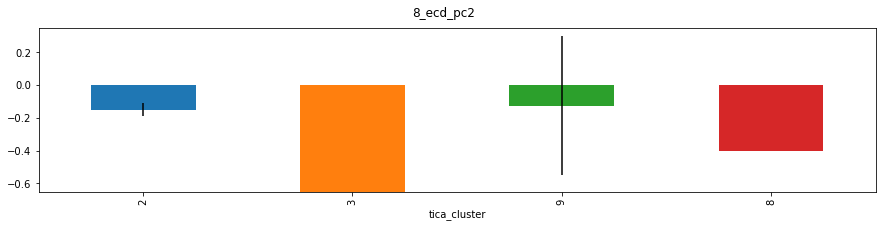

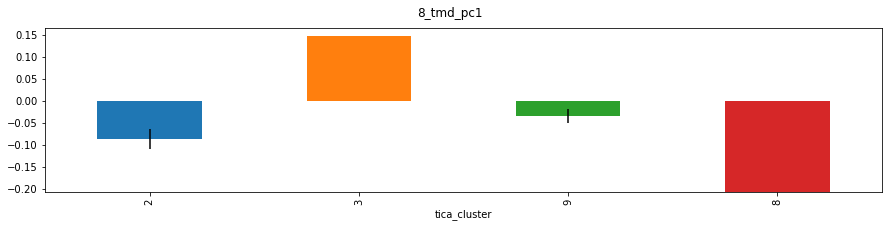

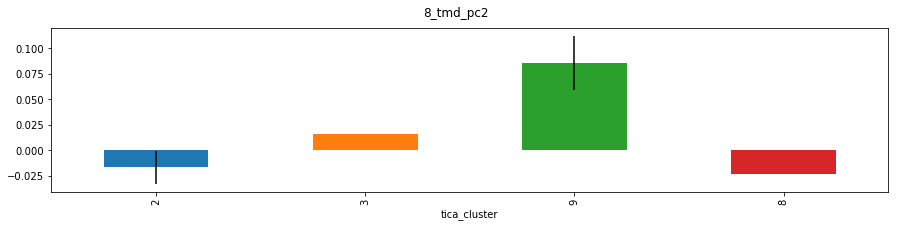

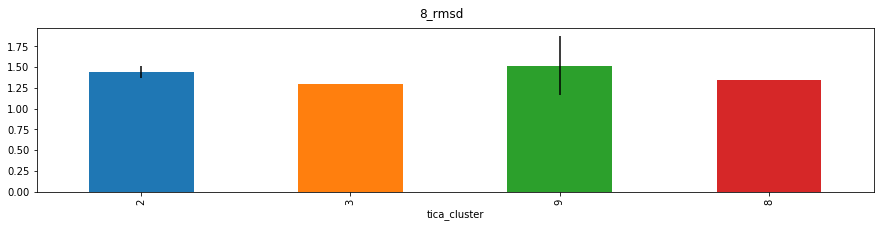

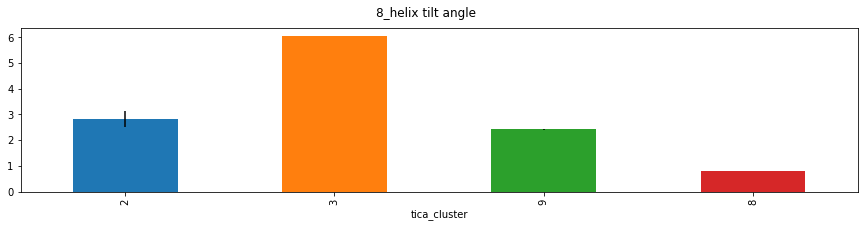

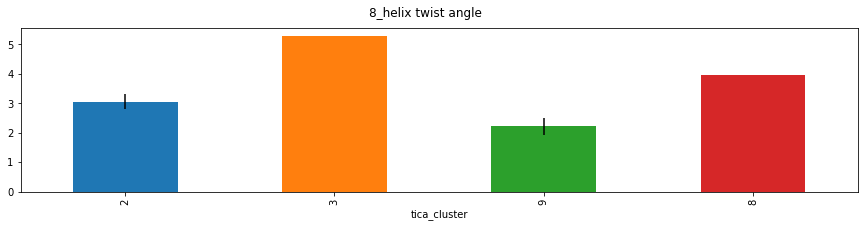

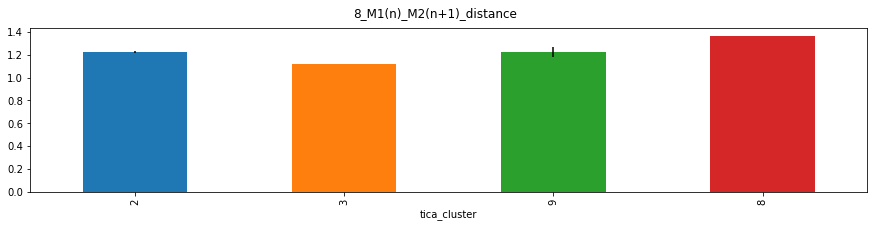

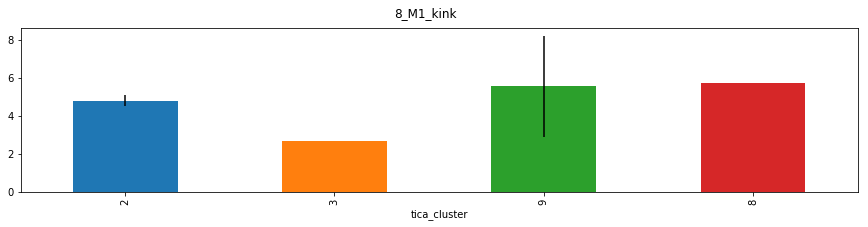

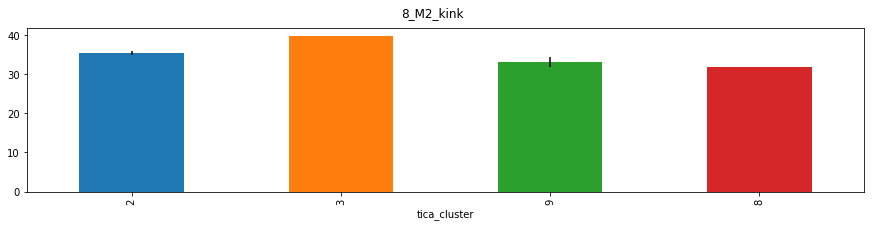

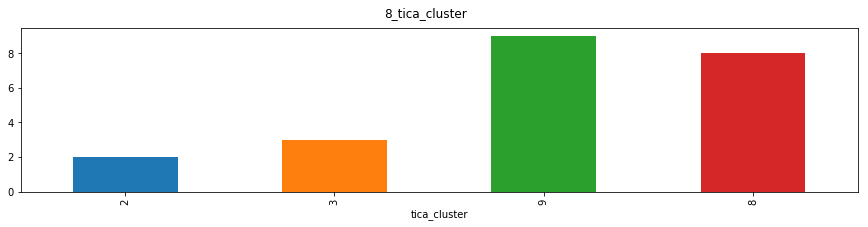

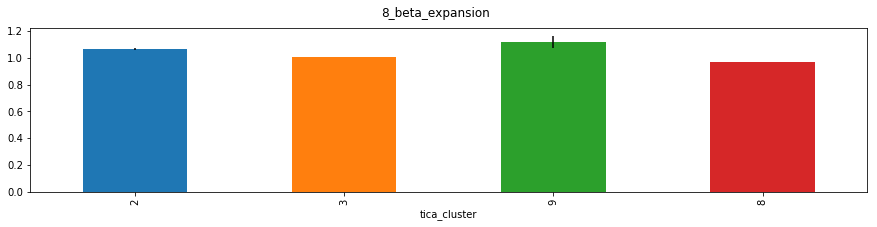

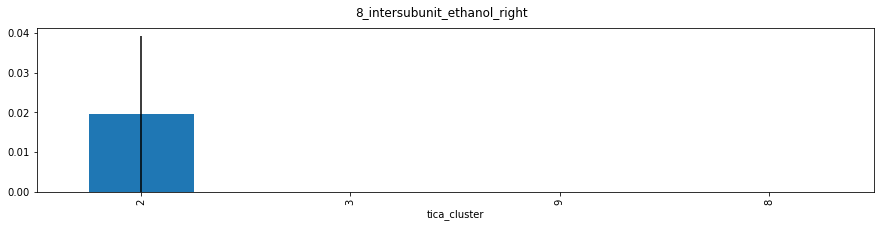

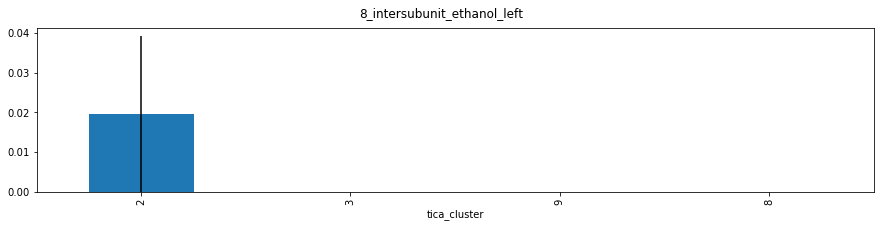

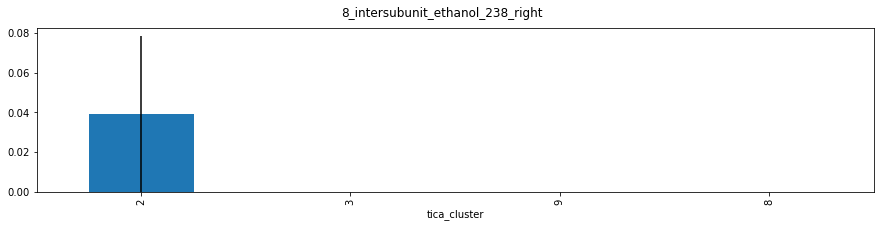

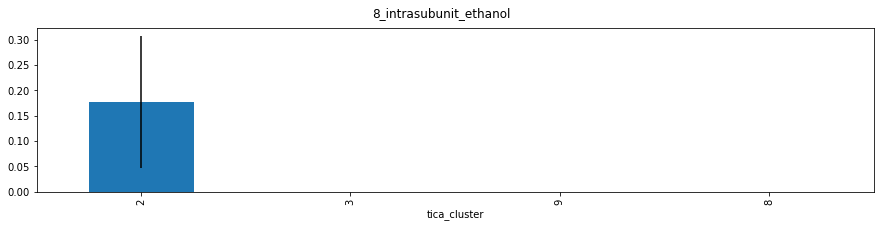

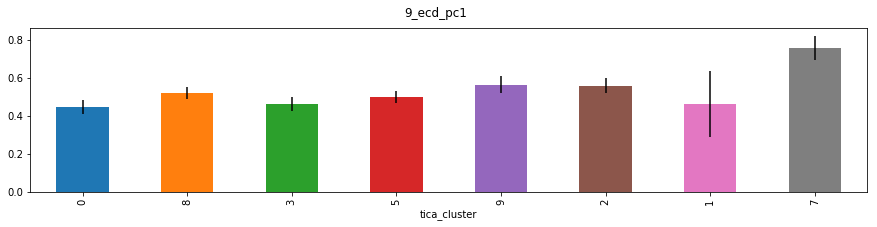

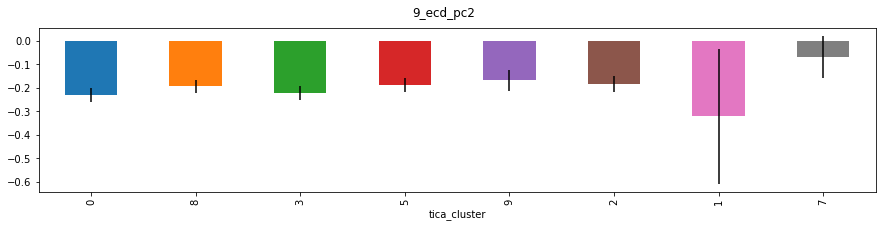

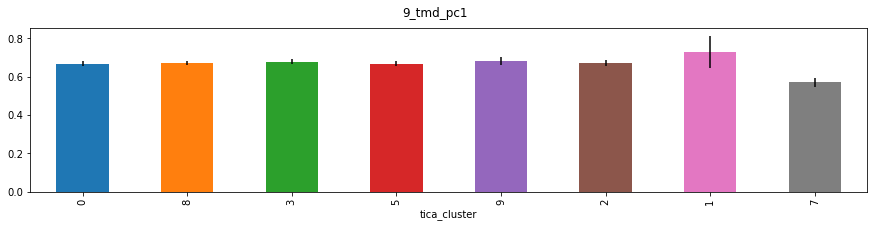

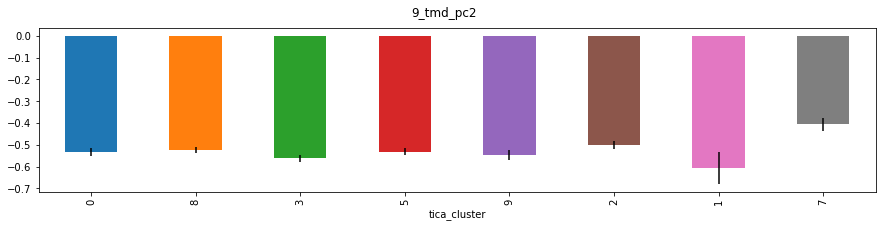

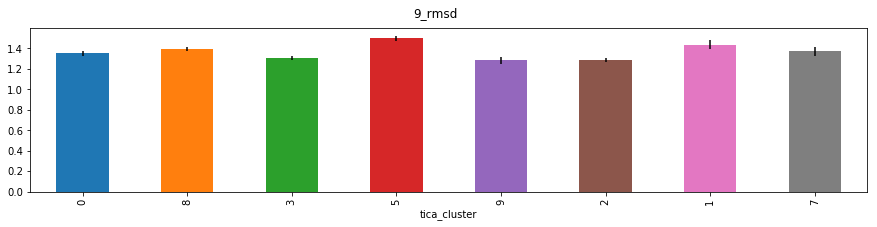

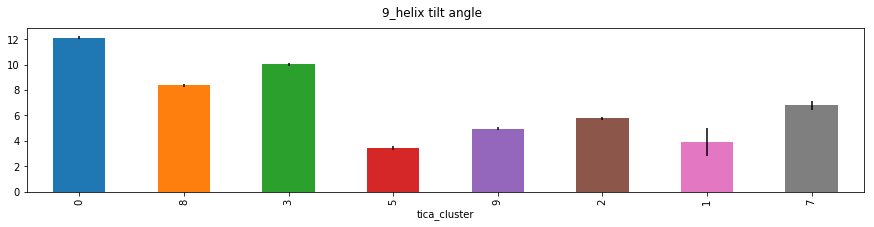

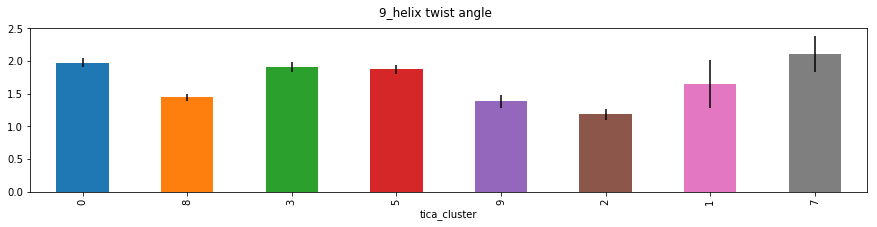

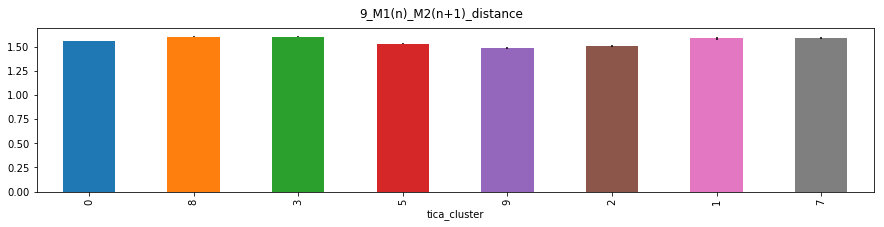

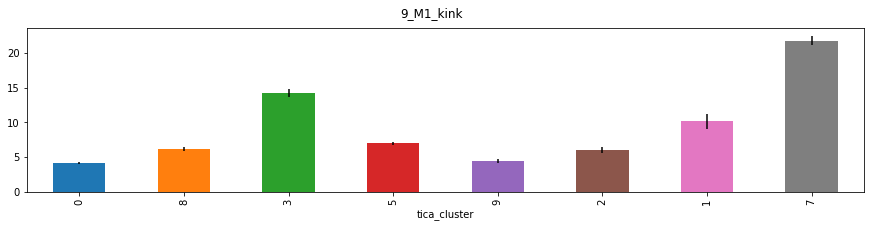

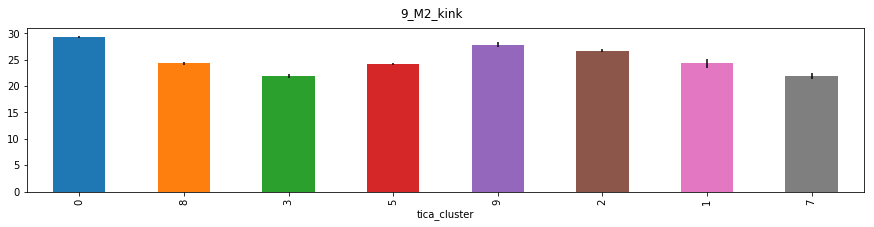

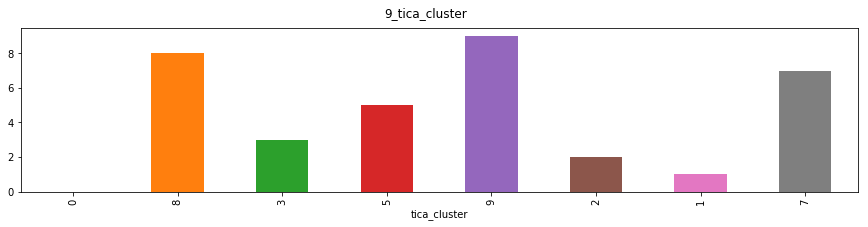

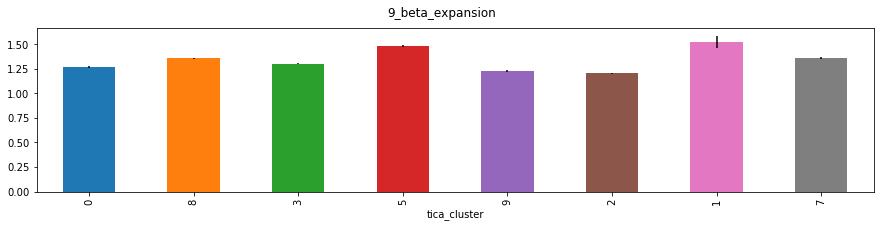

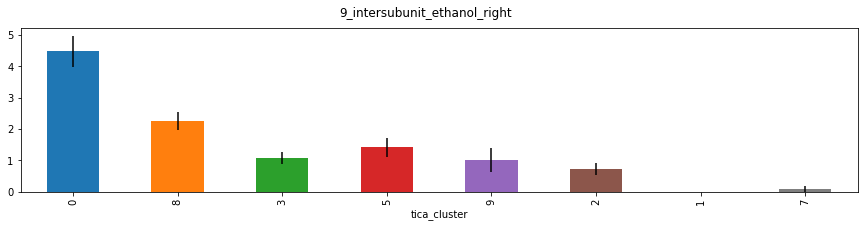

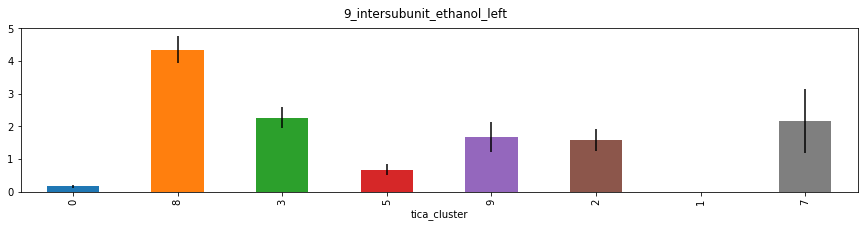

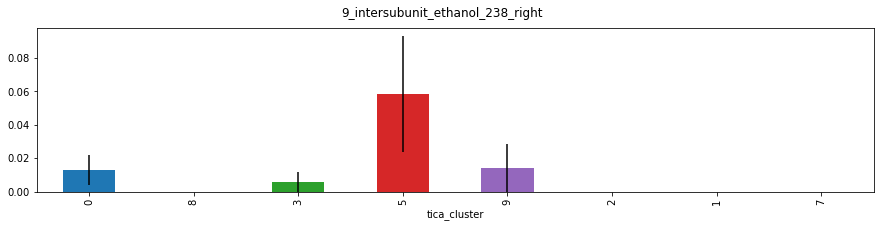

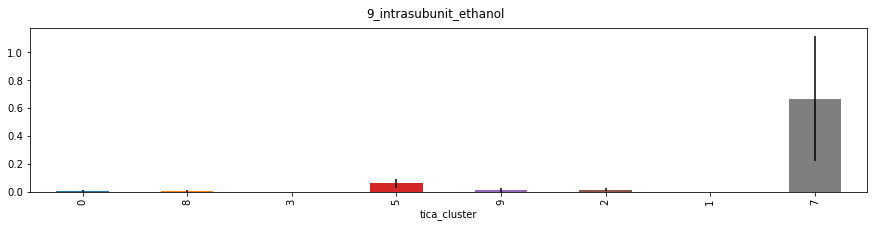

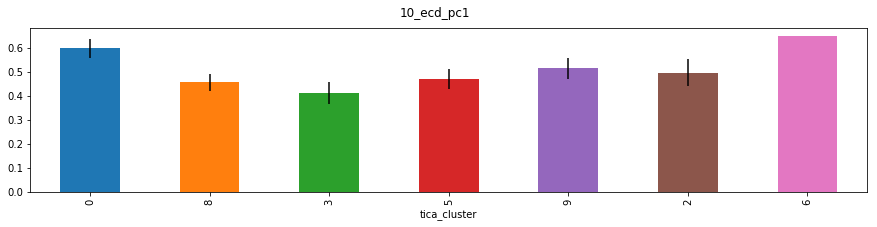

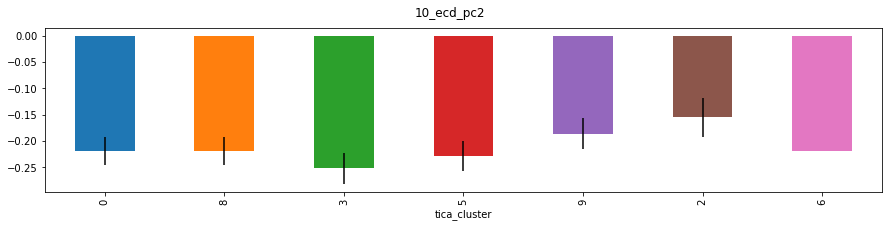

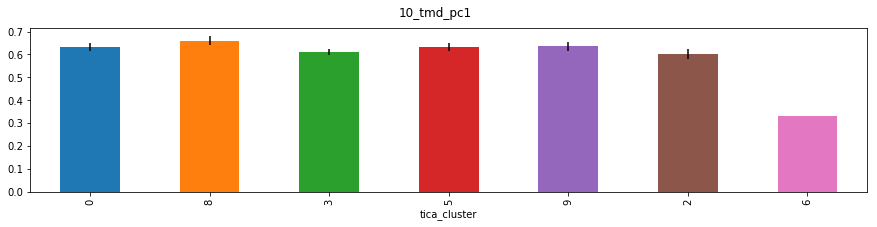

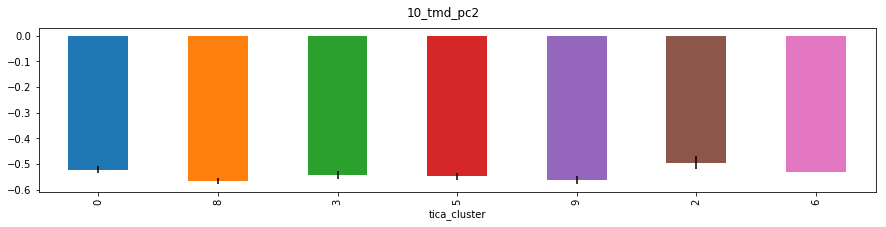

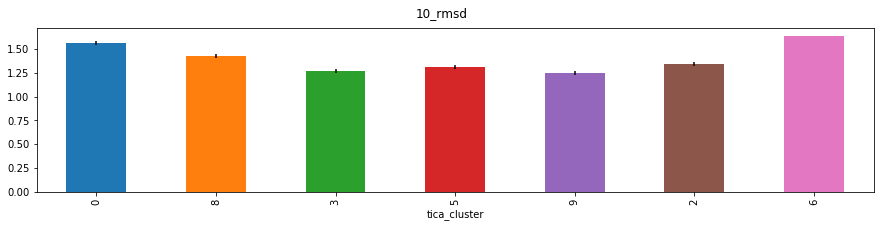

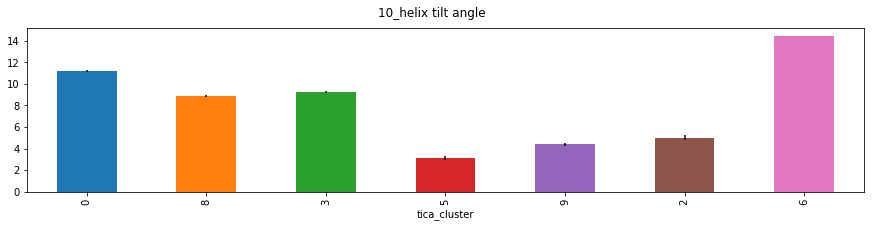

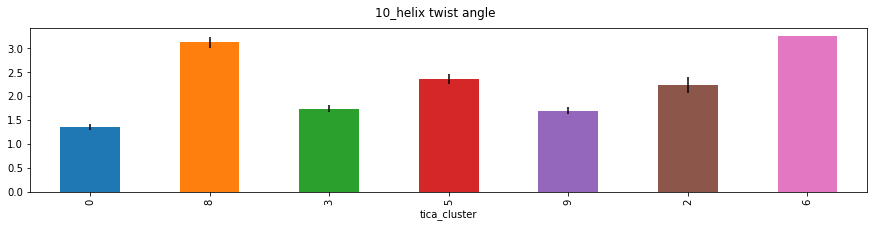

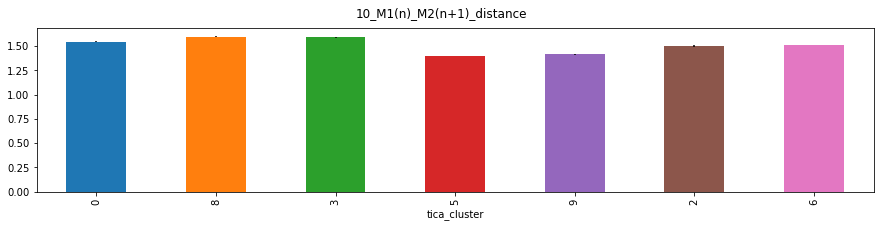

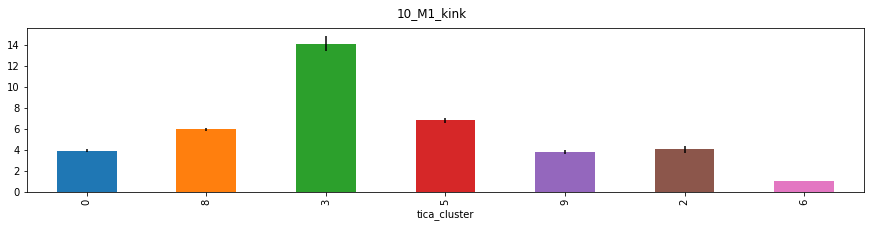

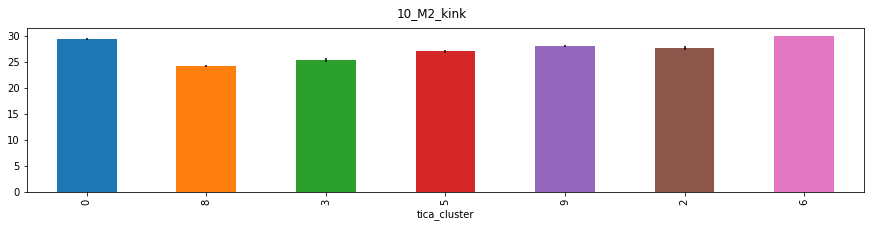

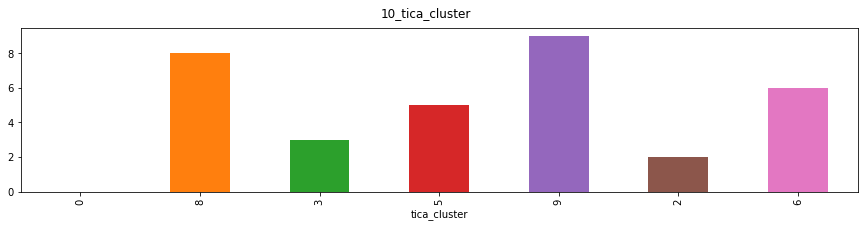

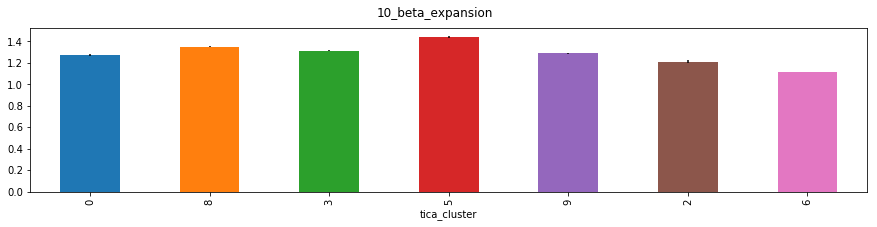

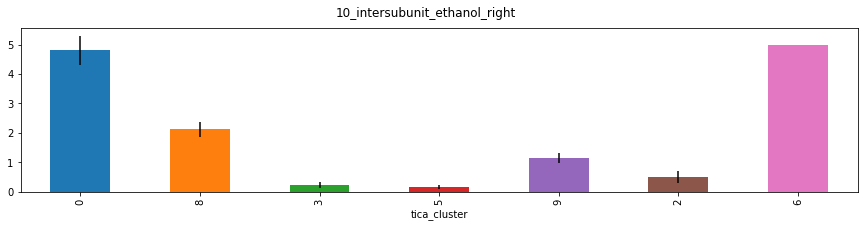

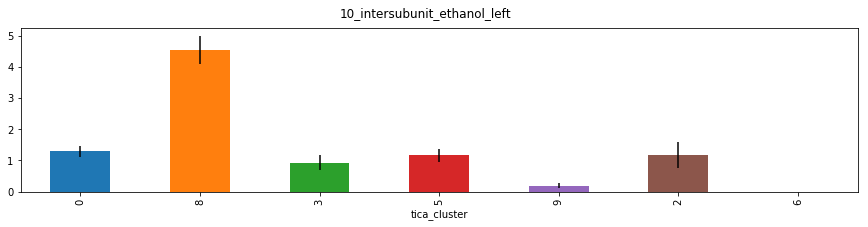

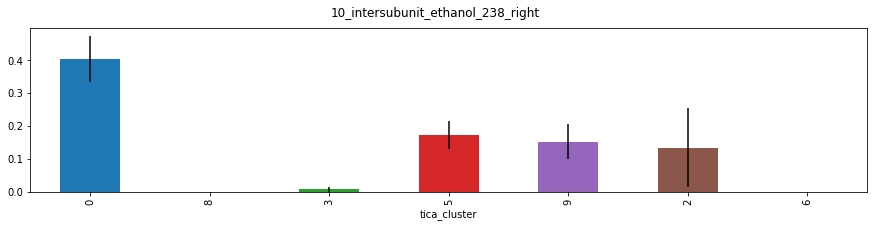

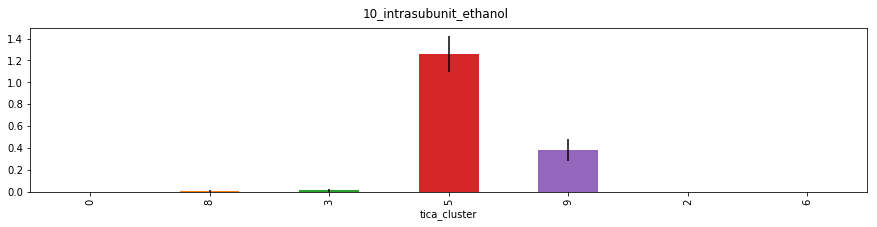

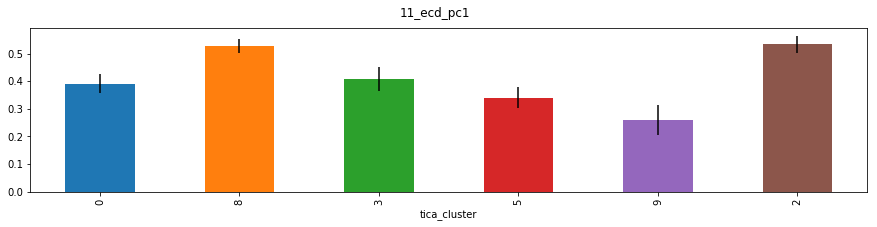

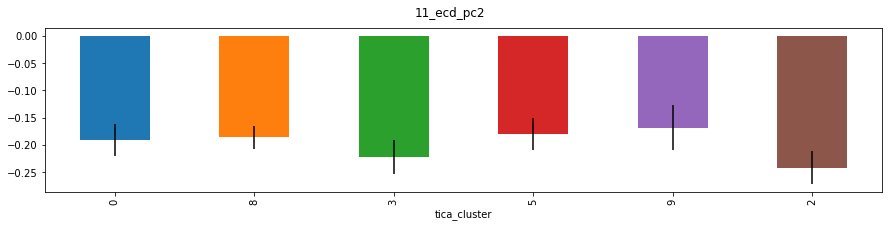

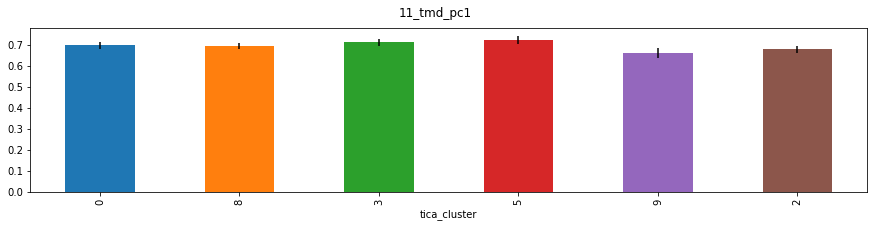

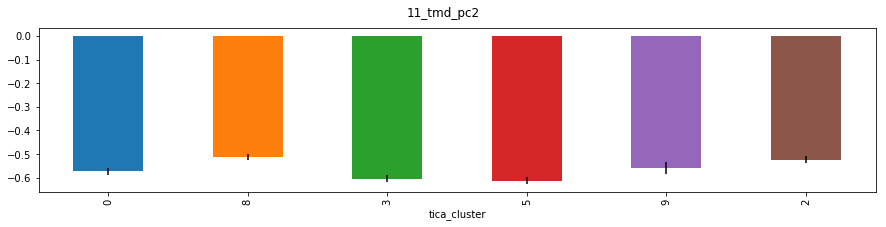

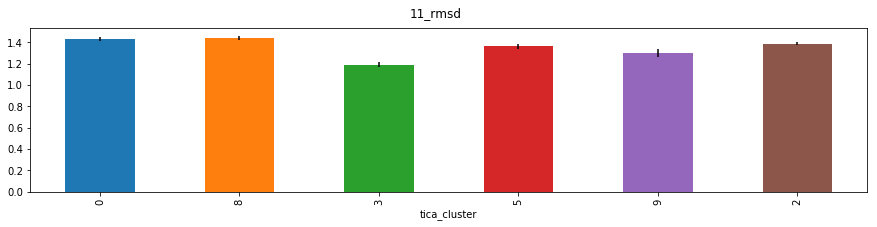

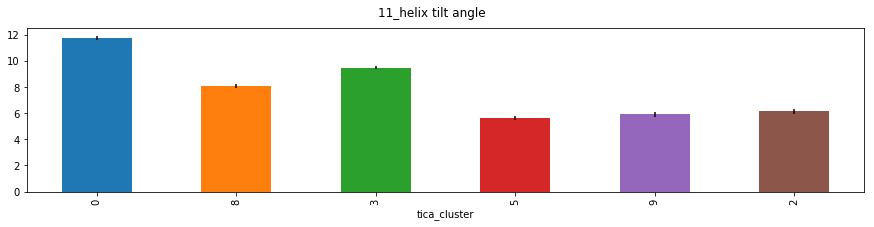

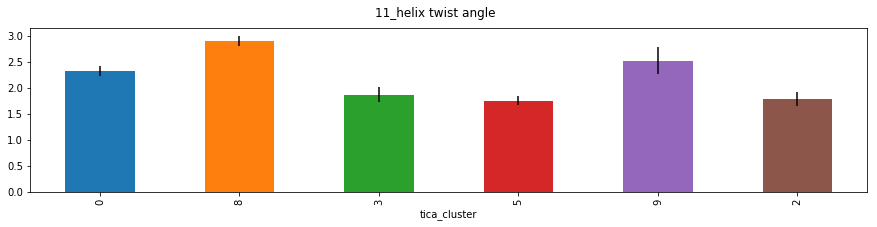

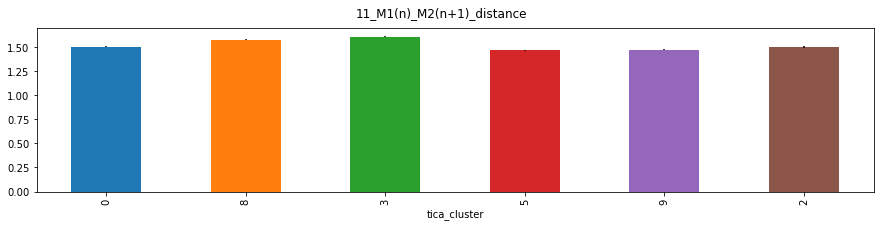

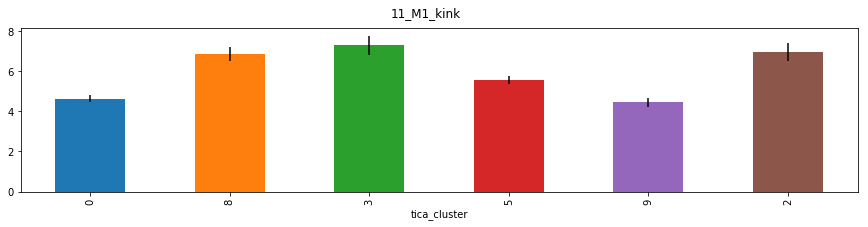

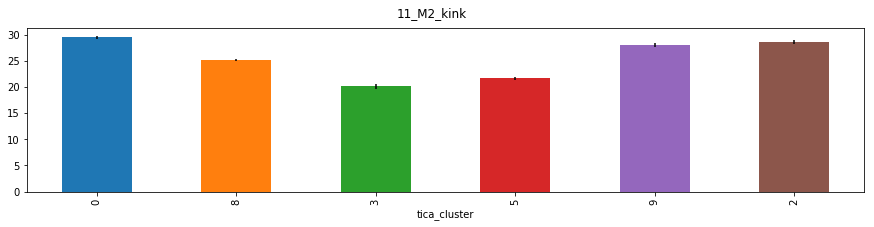

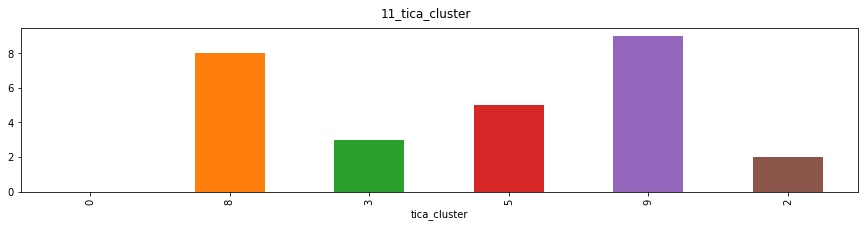

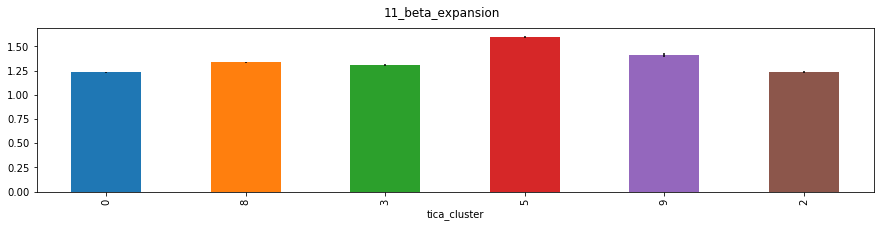

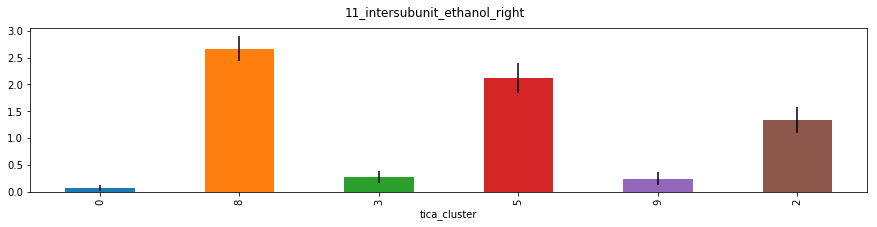

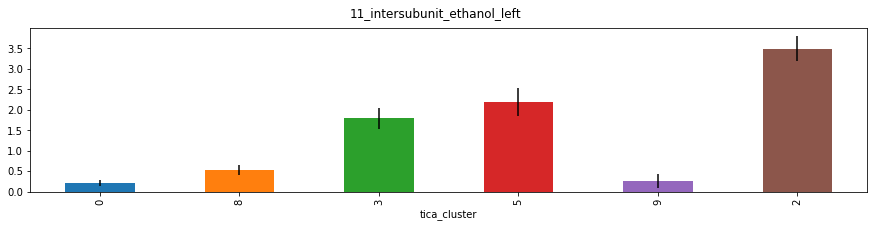

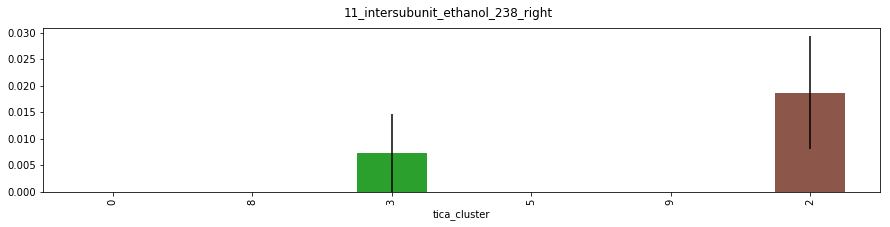

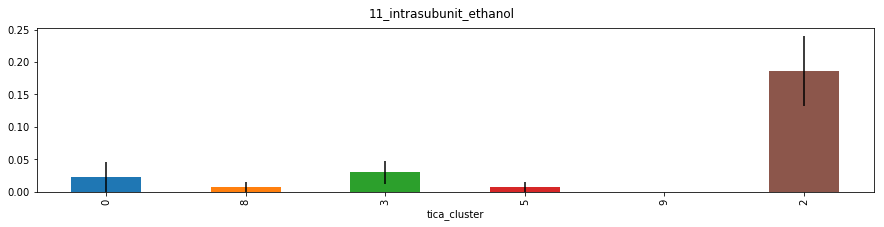

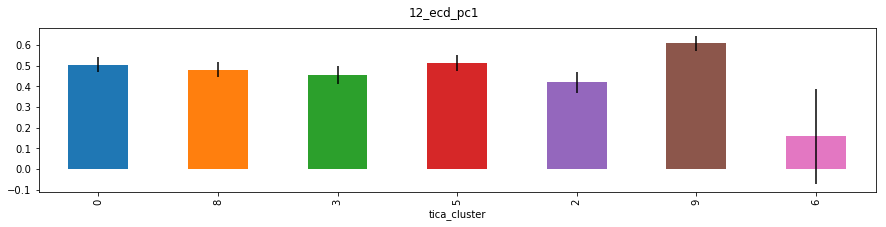

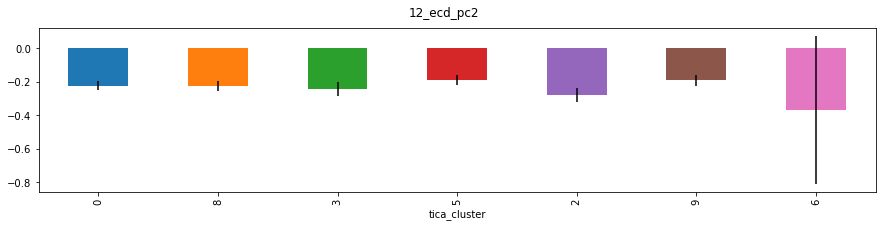

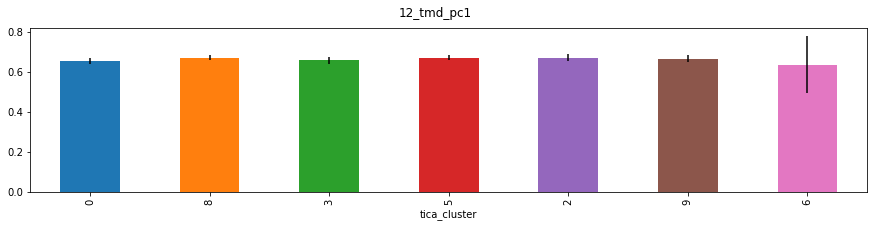

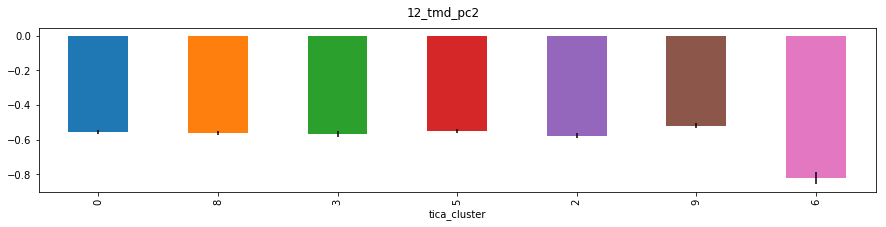

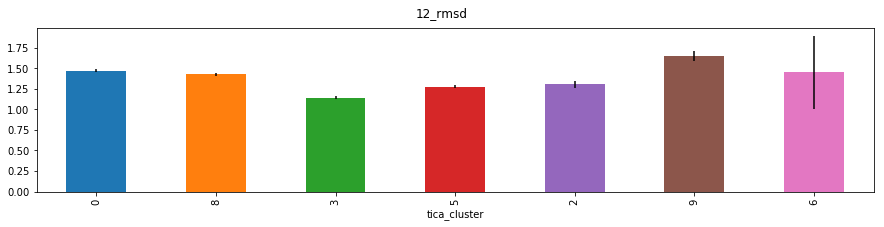

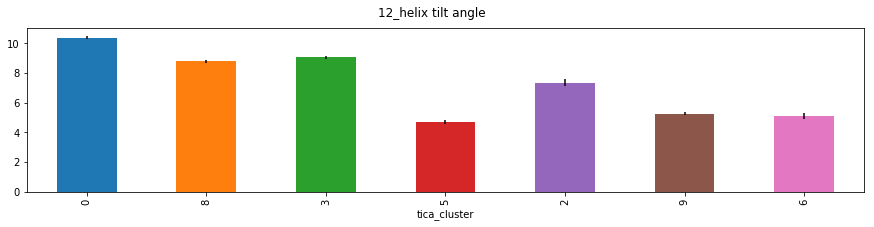

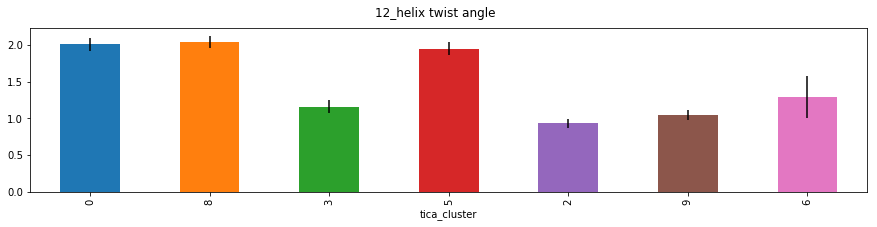

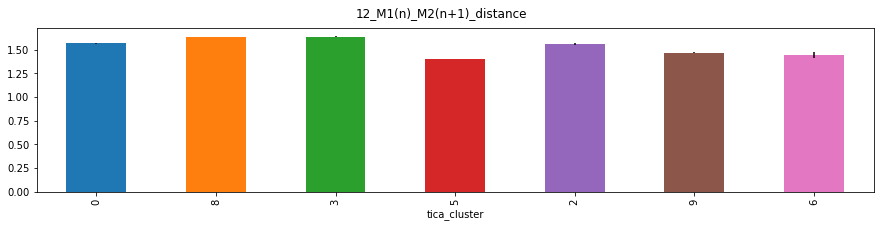

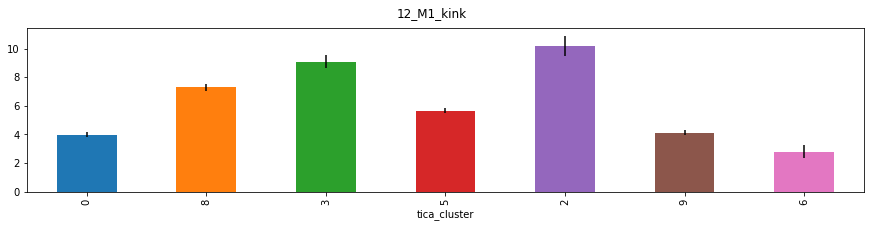

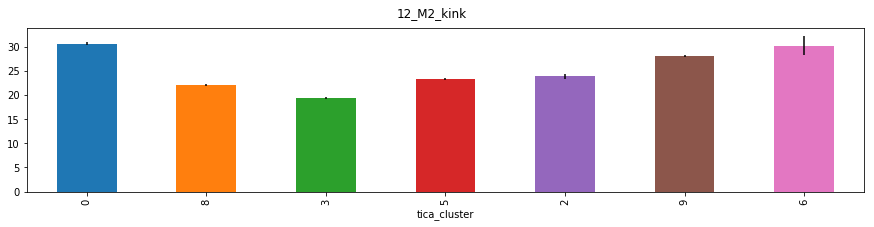

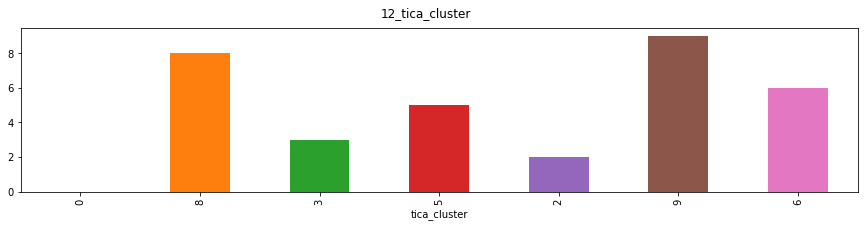

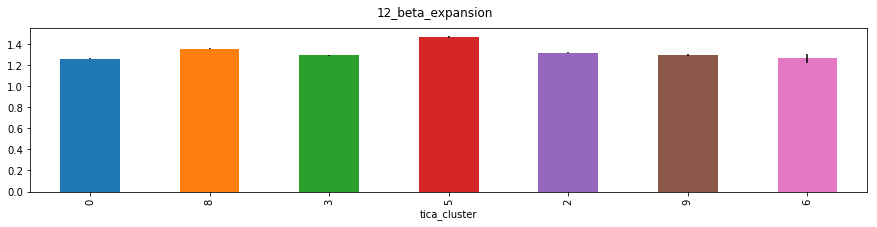

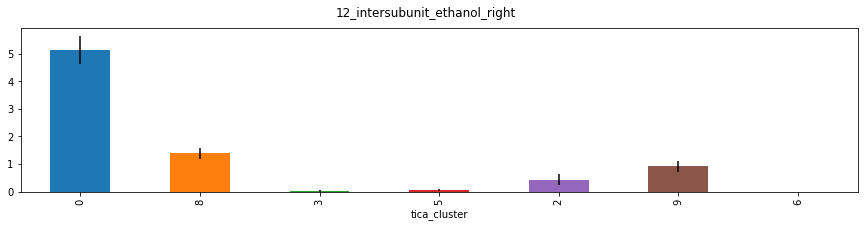

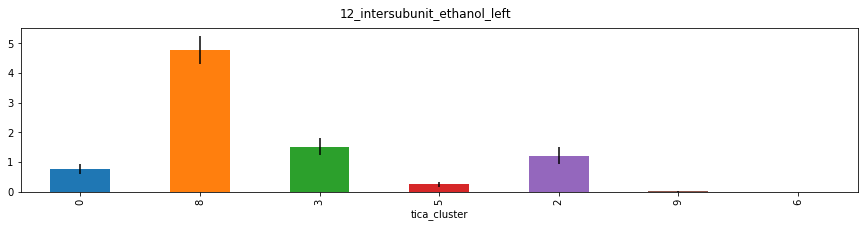

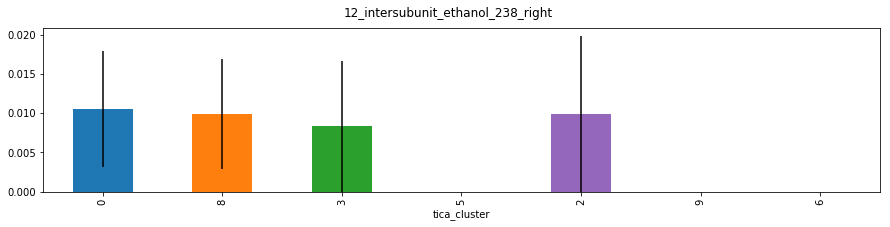

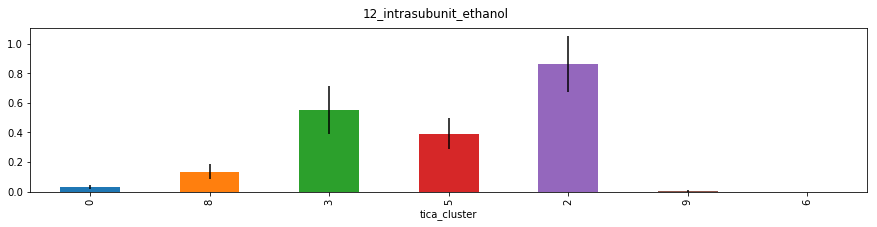

In [167]:
for system in sorted(set(md_data.system)):
    for feature in md_data.columns[6:]:

        fig, ax = plt.subplots(figsize=(15, 3))
        fig.suptitle(str(system) + '_' + feature)
        group = md_data[(md_data.system == system)].groupby(['tica_cluster'],sort=False)[feature]
        mean = group.mean()
        errors = group.sem()
        mean.plot.bar(yerr=errors,ax=ax)
#    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


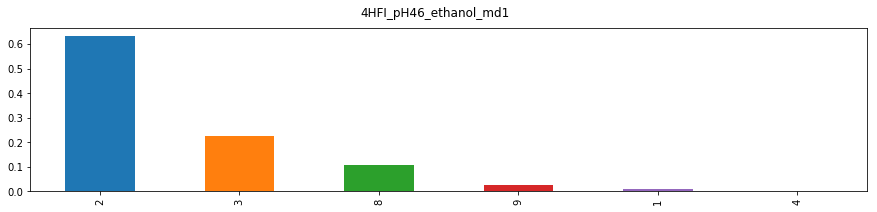

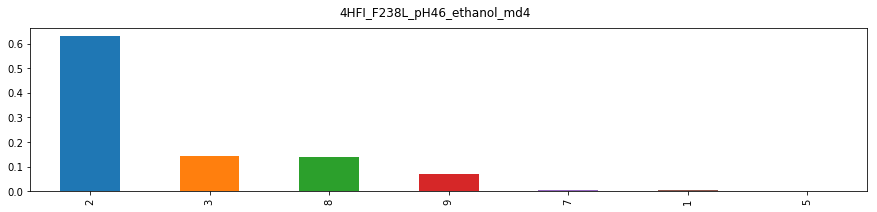

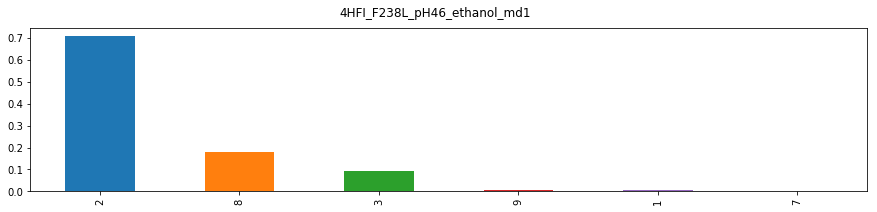

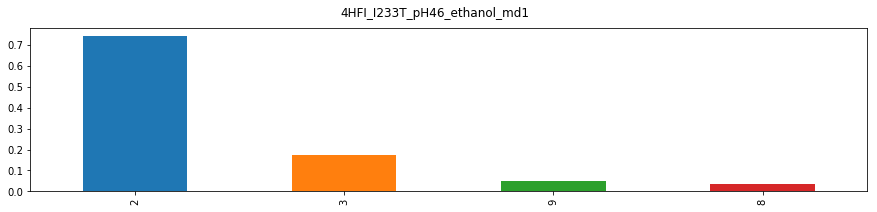

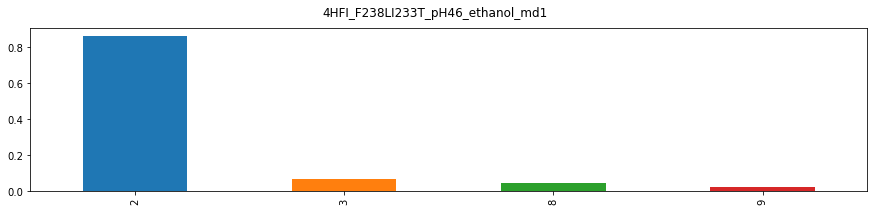

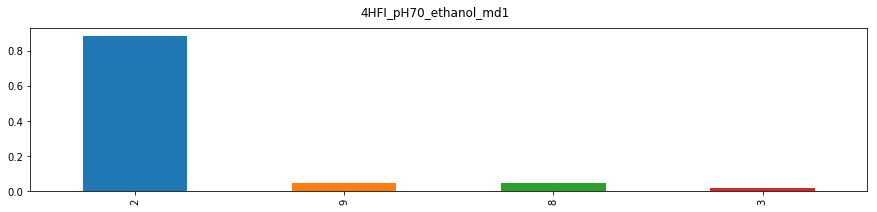

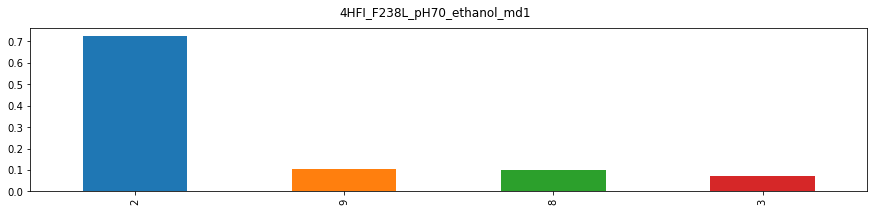

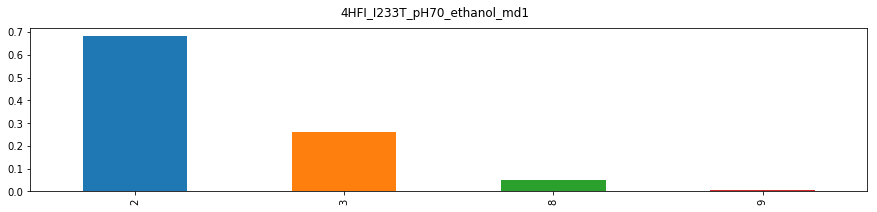

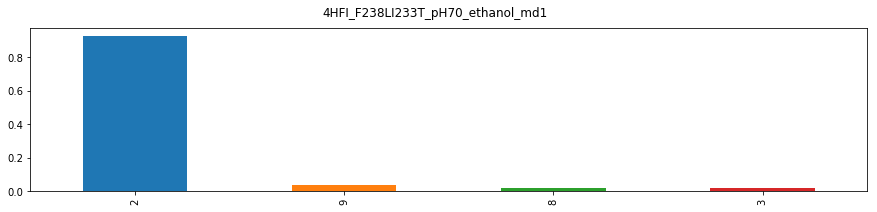

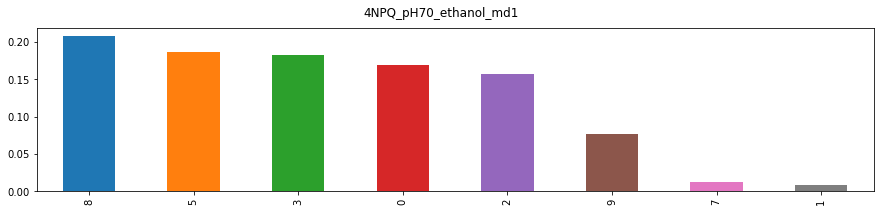

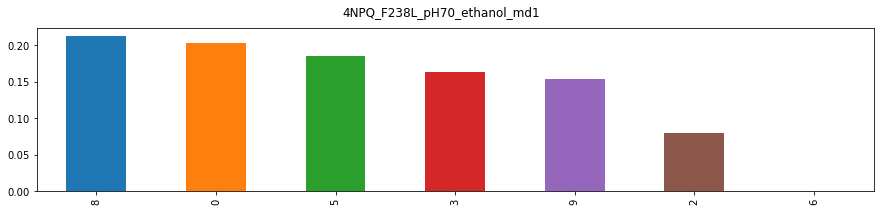

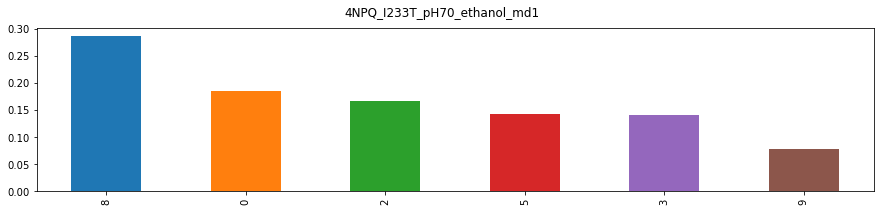

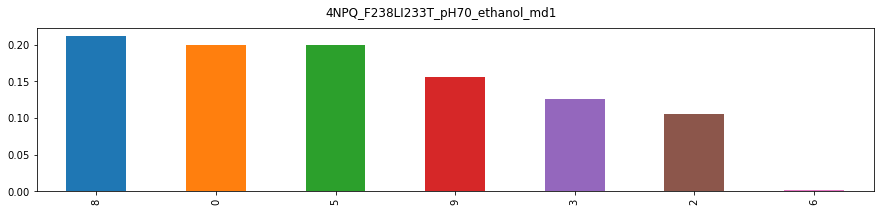

In [168]:
for system in sorted(set(md_data.system)):
    fig, ax = plt.subplots(figsize=(15, 3))
    fig.suptitle(notation_changer[system])
    group = md_data[(md_data.system == system)]['tica_cluster']
    mean = group.value_counts(normalize=True)
#    errors = group.sem()
    mean.plot.bar(ax=ax)
#    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


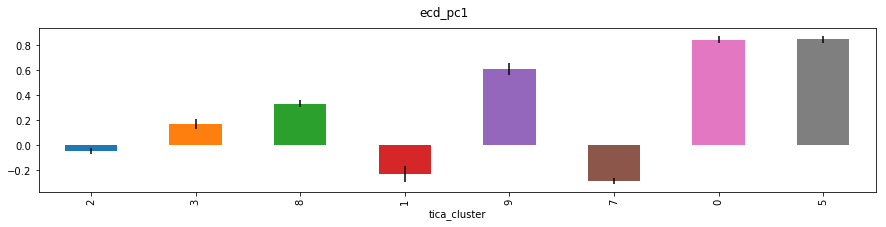

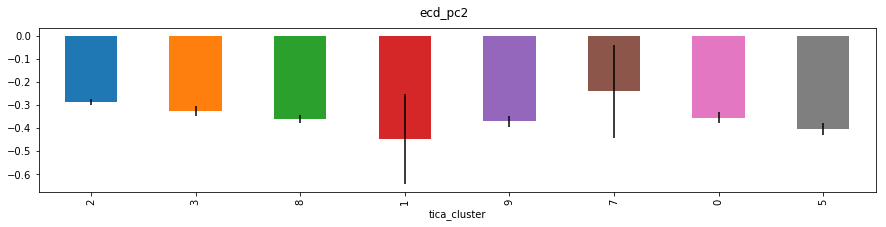

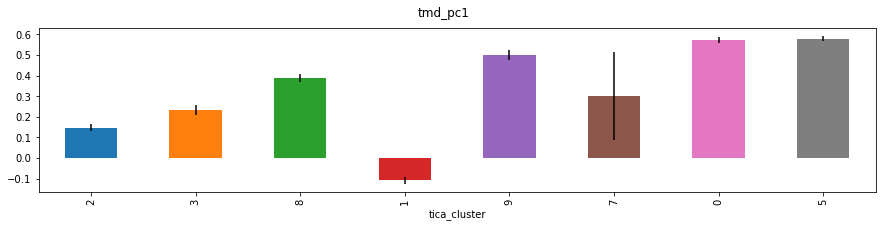

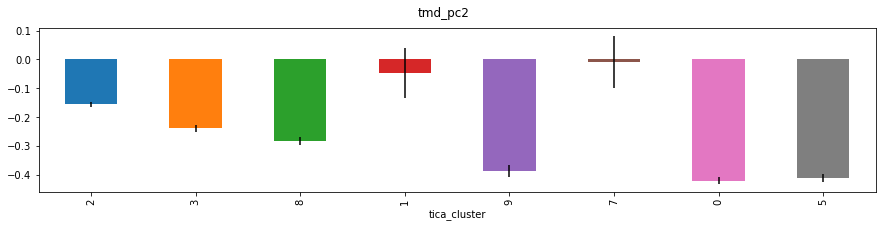

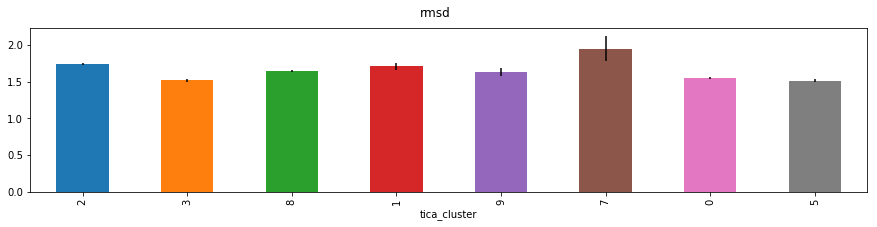

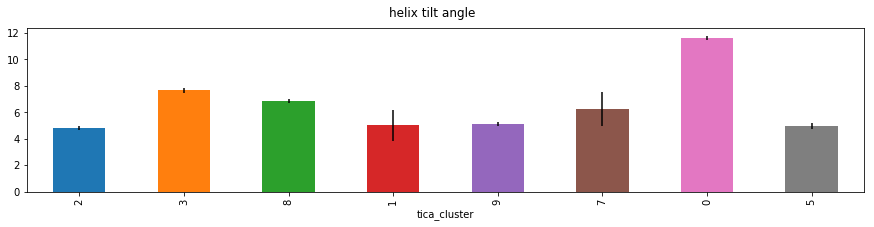

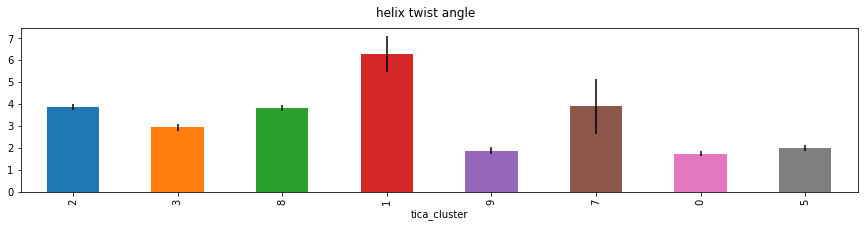

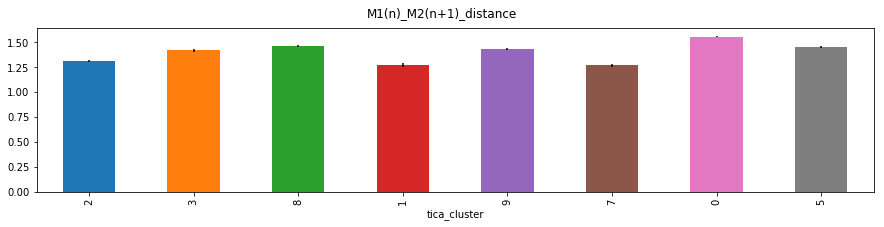

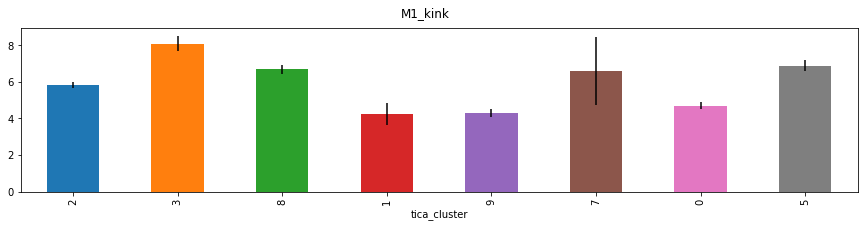

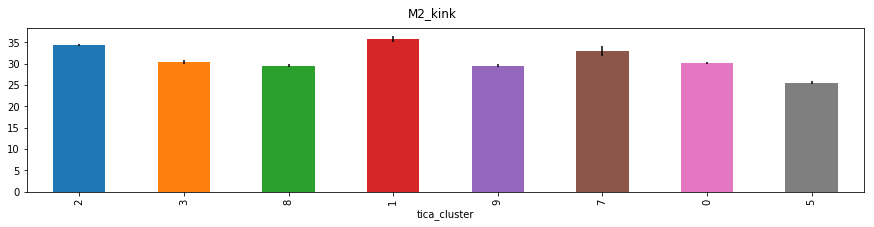

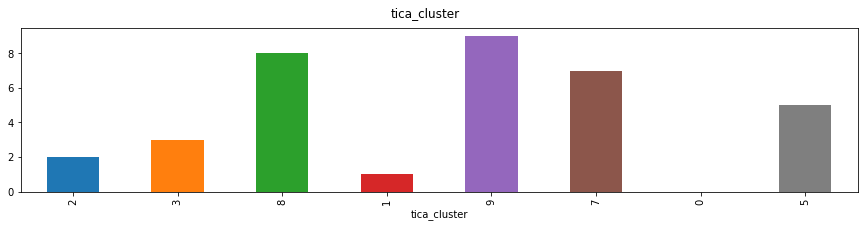

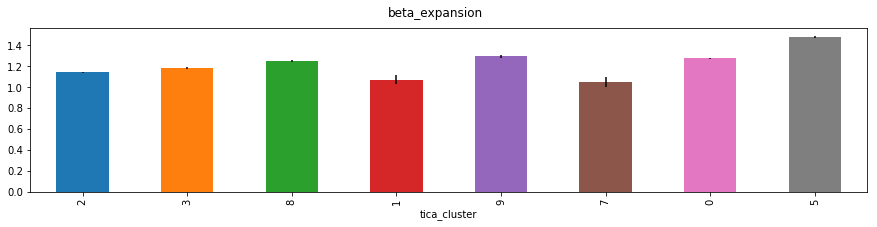

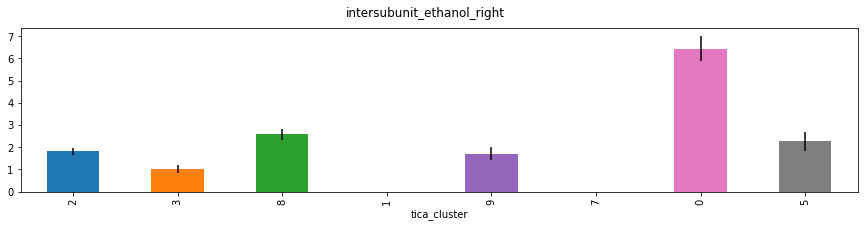

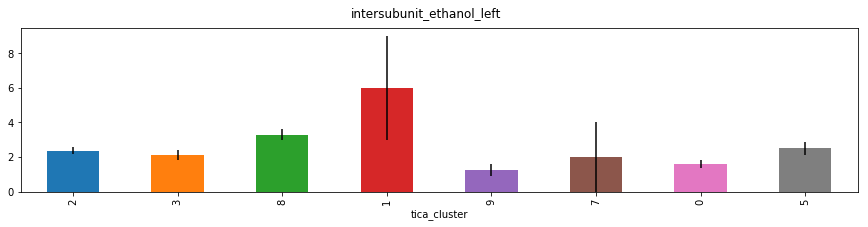

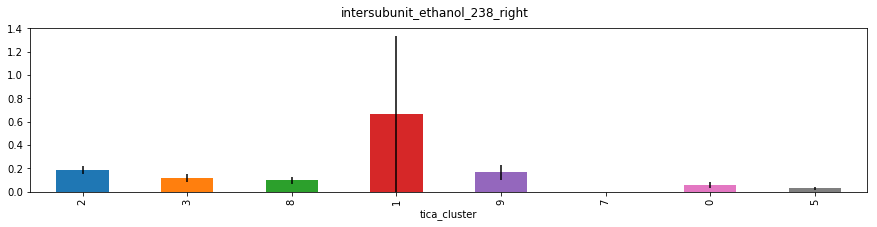

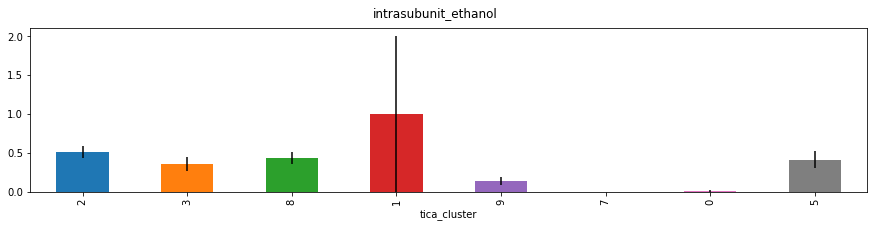

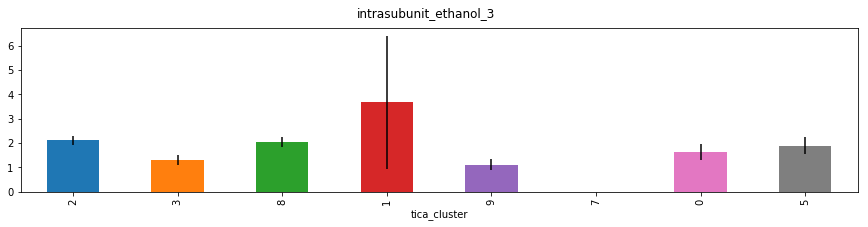

In [242]:
for feature in md_data.columns[6:]:

    fig, ax = plt.subplots(figsize=(15, 3))
    fig.suptitle(feature)
    group = md_data[(md_data.traj_time > 50)].groupby(['tica_cluster'],sort=False)[feature]
    mean = group.mean()
    errors = group.sem()
    mean.plot.bar(yerr=errors,ax=ax)
#    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


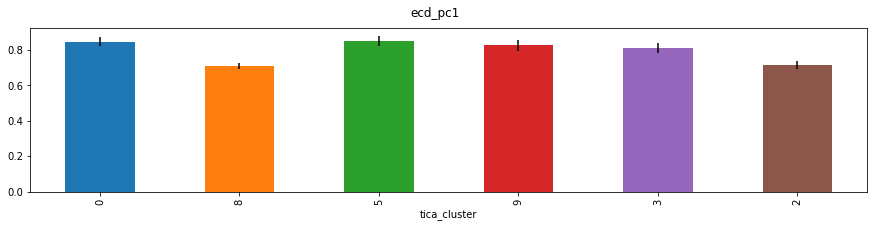

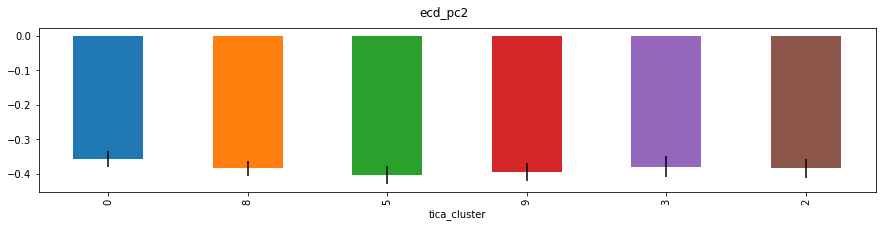

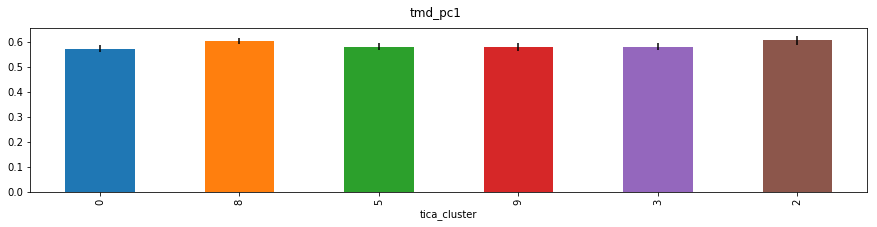

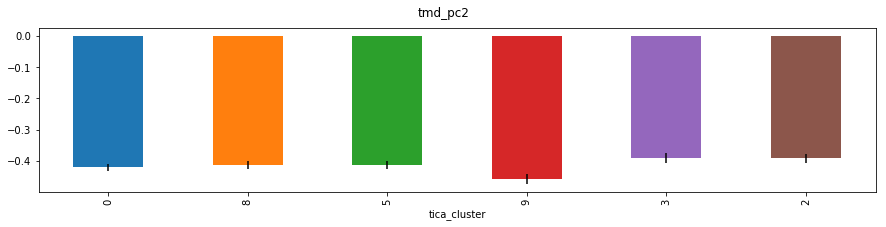

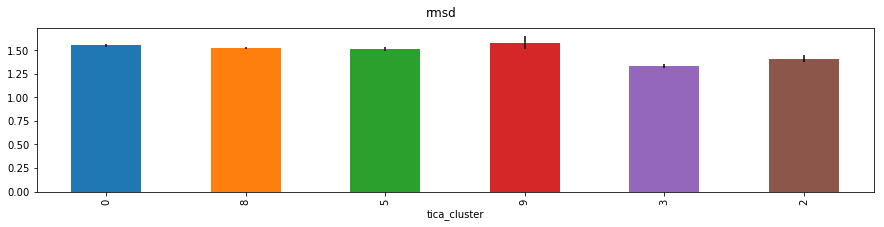

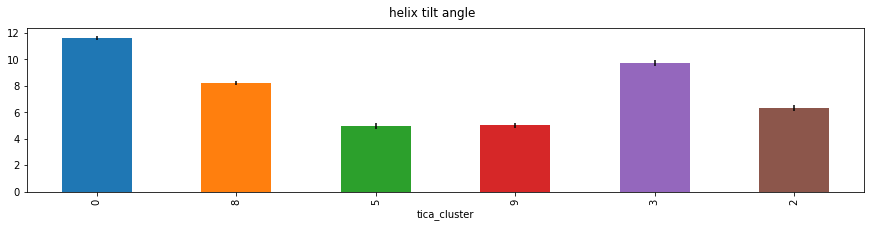

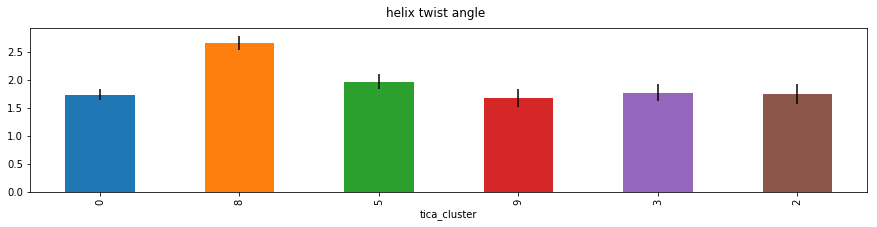

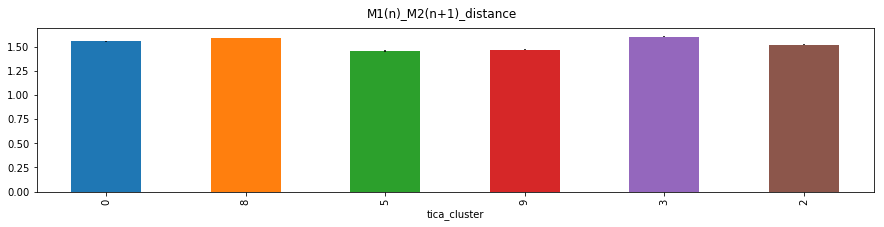

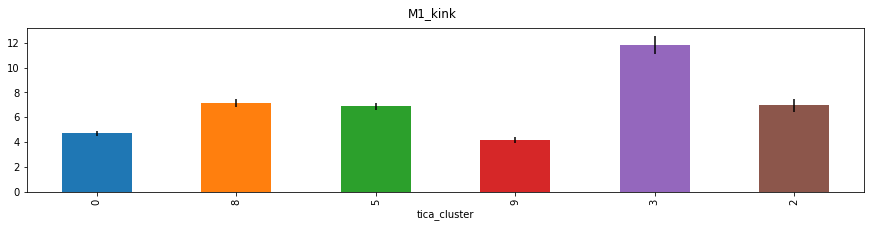

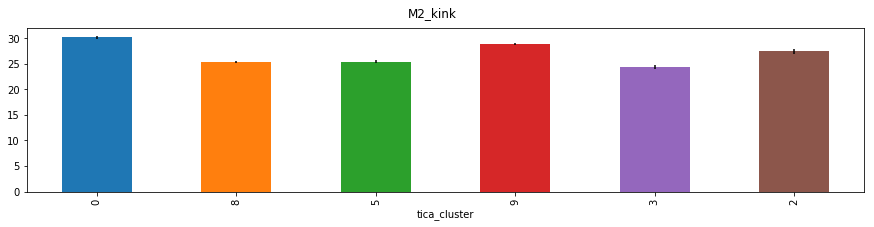

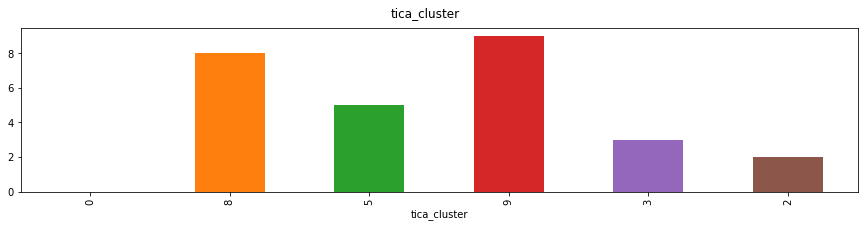

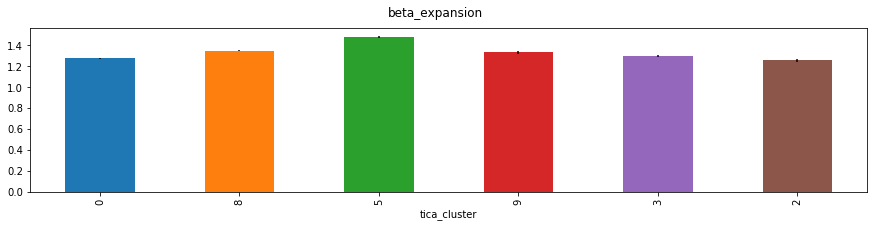

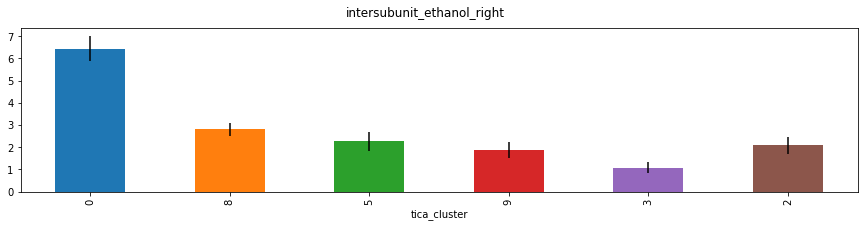

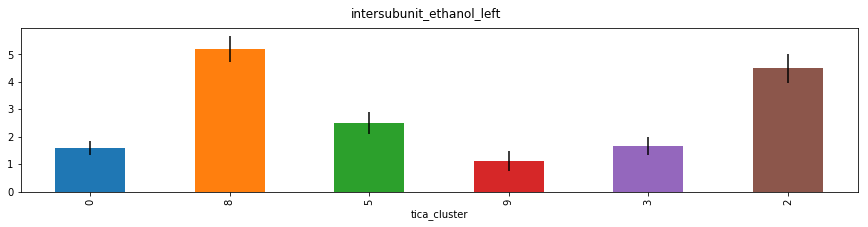

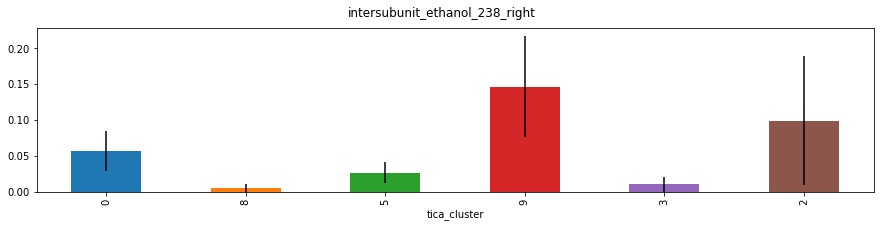

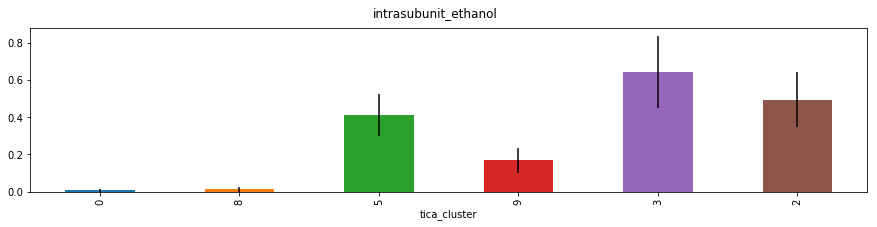

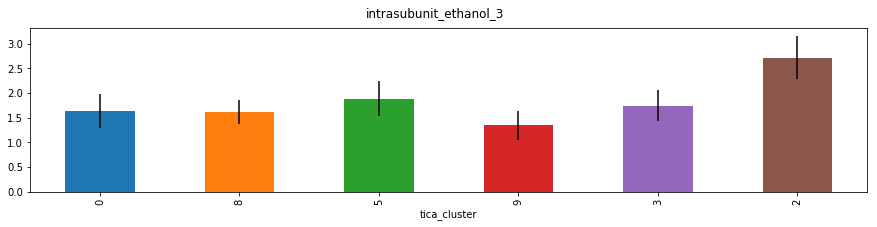

In [237]:
for feature in md_data.columns[6:]:

    fig, ax = plt.subplots(figsize=(15, 3))
    fig.suptitle(feature)
    group = md_data[(md_data.system.isin(['9','10','11','12'])) & (md_data.traj_time > 50)].groupby(['tica_cluster'],sort=False)[feature]
    mean = group.mean()
    errors = group.sem()
    mean.plot.bar(yerr=errors,ax=ax)
#    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


(0, 10)

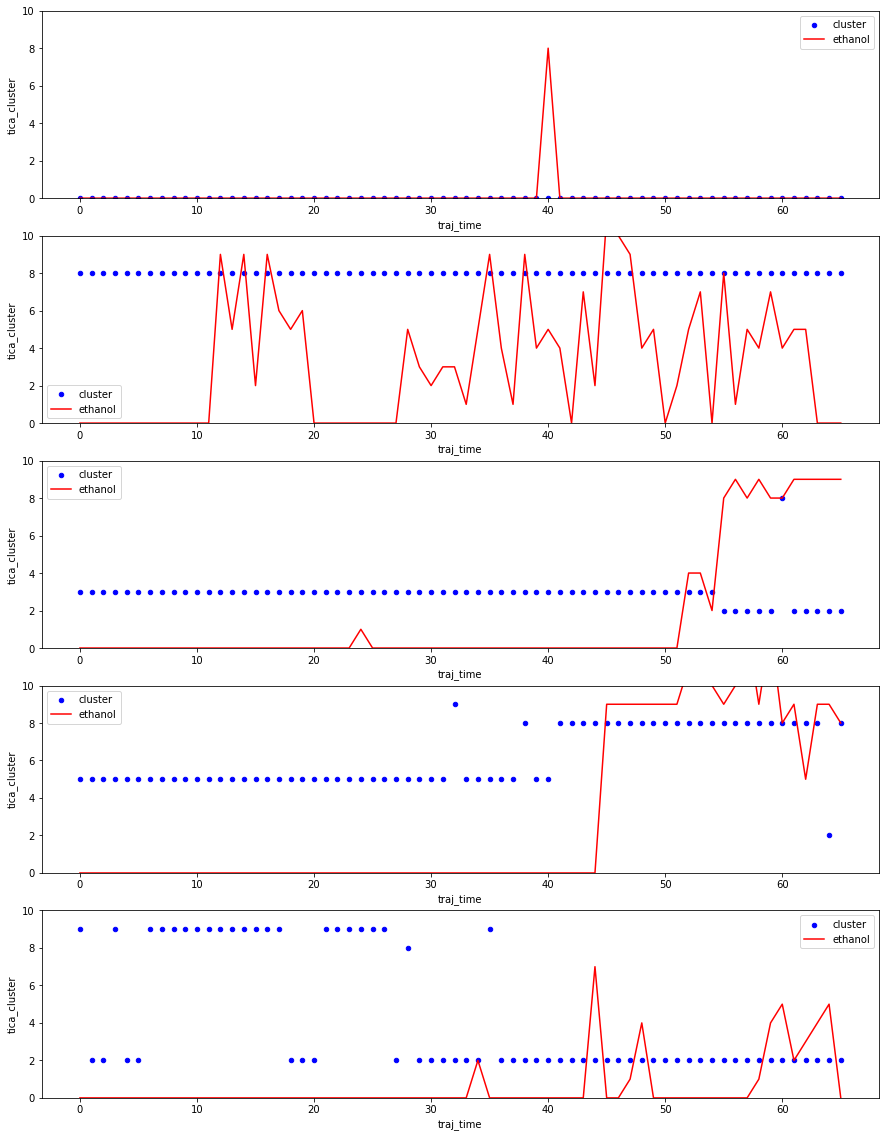

In [170]:
fig, ax = plt.subplots(5,figsize=(15, 20))
md_data[(md_data.system == 11) & (md_data.replicate == '1') & (md_data.subunit == 0)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[0],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '1')  & (md_data.subunit == 0)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[0],label='ethanol',c='red')
md_data[(md_data.system == 11) & (md_data.replicate == '1') & (md_data.subunit == 1)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[1],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '1')  & (md_data.subunit == 1)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[1],label='ethanol',c='red')
md_data[(md_data.system == 11) & (md_data.replicate == '1') & (md_data.subunit == 2)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[2],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '1')  & (md_data.subunit == 2)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[2],label='ethanol',c='red')
md_data[(md_data.system == 11) & (md_data.replicate == '1') & (md_data.subunit == 3)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[3],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '1')  & (md_data.subunit == 3)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[3],label='ethanol',c='red')
md_data[(md_data.system == 11) & (md_data.replicate == '1') & (md_data.subunit == 4)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[4],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '1')  & (md_data.subunit == 4)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[4],label='ethanol',c='red')
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)
ax[4].set_ylim(0,10)


(0, 10)

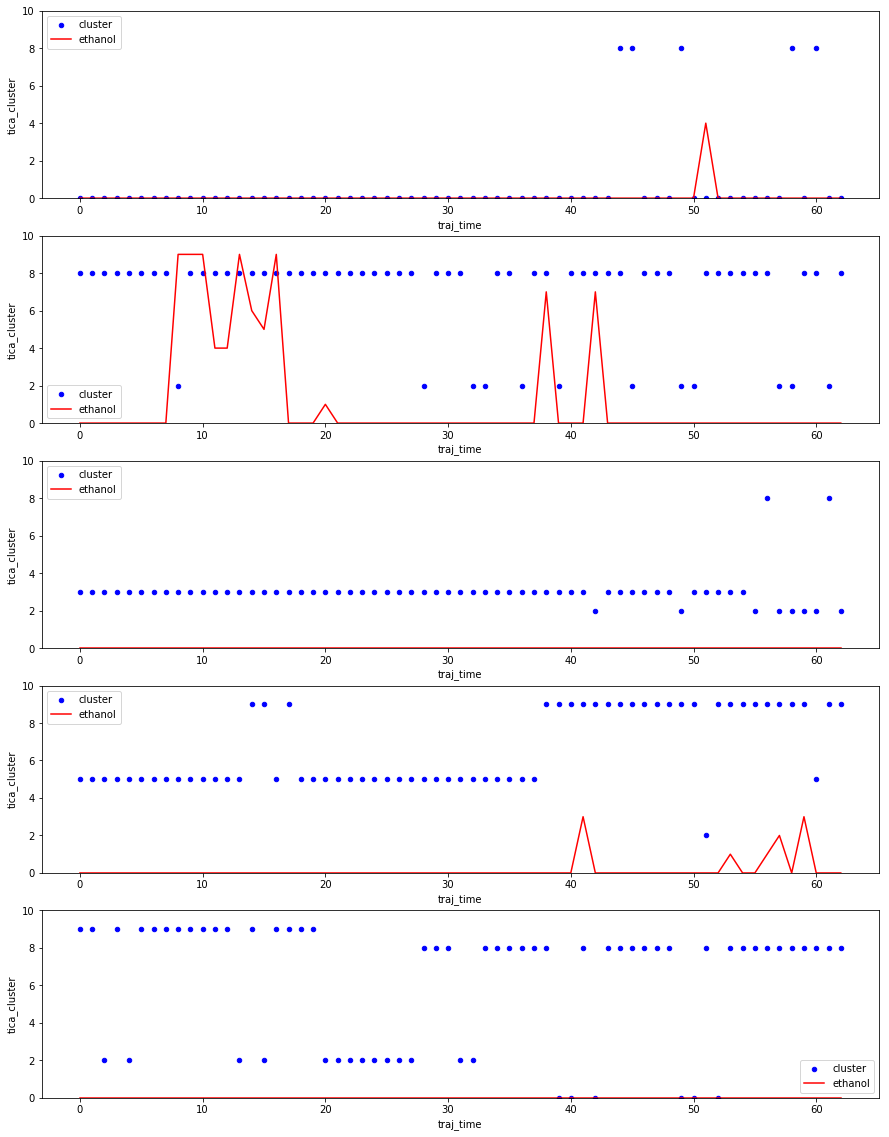

In [171]:
fig, ax = plt.subplots(5,figsize=(15, 20))
md_data[(md_data.system == 11) & (md_data.replicate == '2') & (md_data.subunit == 0)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[0],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '2')  & (md_data.subunit == 0)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[0],label='ethanol',c='red')
md_data[(md_data.system == 11) & (md_data.replicate == '2') & (md_data.subunit == 1)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[1],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '2')  & (md_data.subunit == 1)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[1],label='ethanol',c='red')
md_data[(md_data.system == 11) & (md_data.replicate == '2') & (md_data.subunit == 2)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[2],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '2')  & (md_data.subunit == 2)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[2],label='ethanol',c='red')
md_data[(md_data.system == 11) & (md_data.replicate == '2') & (md_data.subunit == 3)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[3],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '2')  & (md_data.subunit == 3)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[3],label='ethanol',c='red')
md_data[(md_data.system == 11) & (md_data.replicate == '2') & (md_data.subunit == 4)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[4],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '2')  & (md_data.subunit == 4)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[4],label='ethanol',c='red')
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)
ax[4].set_ylim(0,10)


(0, 10)

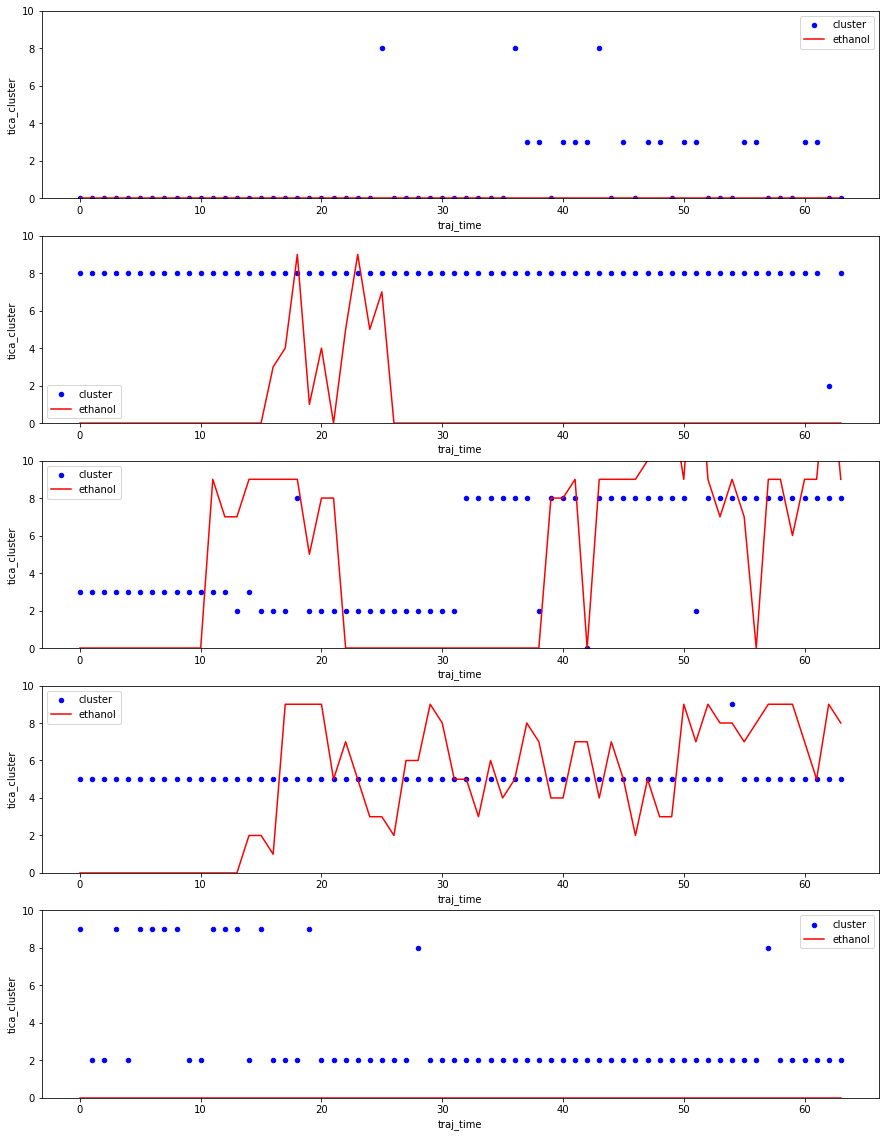

In [172]:
fig, ax = plt.subplots(5,figsize=(15, 20))
md_data[(md_data.system == 11) & (md_data.replicate == '3') & (md_data.subunit == 0)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[0],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '3')  & (md_data.subunit == 0)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[0],label='ethanol',c='red')
md_data[(md_data.system == 11) & (md_data.replicate == '3') & (md_data.subunit == 1)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[1],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '3')  & (md_data.subunit == 1)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[1],label='ethanol',c='red')
md_data[(md_data.system == 11) & (md_data.replicate == '3') & (md_data.subunit == 2)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[2],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '3')  & (md_data.subunit == 2)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[2],label='ethanol',c='red')
md_data[(md_data.system == 11) & (md_data.replicate == '3') & (md_data.subunit == 3)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[3],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '3')  & (md_data.subunit == 3)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[3],label='ethanol',c='red')
md_data[(md_data.system == 11) & (md_data.replicate == '3') & (md_data.subunit == 4)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[4],label='cluster',c='blue')
md_data[(md_data.system == 11) & (md_data.replicate == '3')  & (md_data.subunit == 4)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[4],label='ethanol',c='red')
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)
ax[4].set_ylim(0,10)


(0, 10)

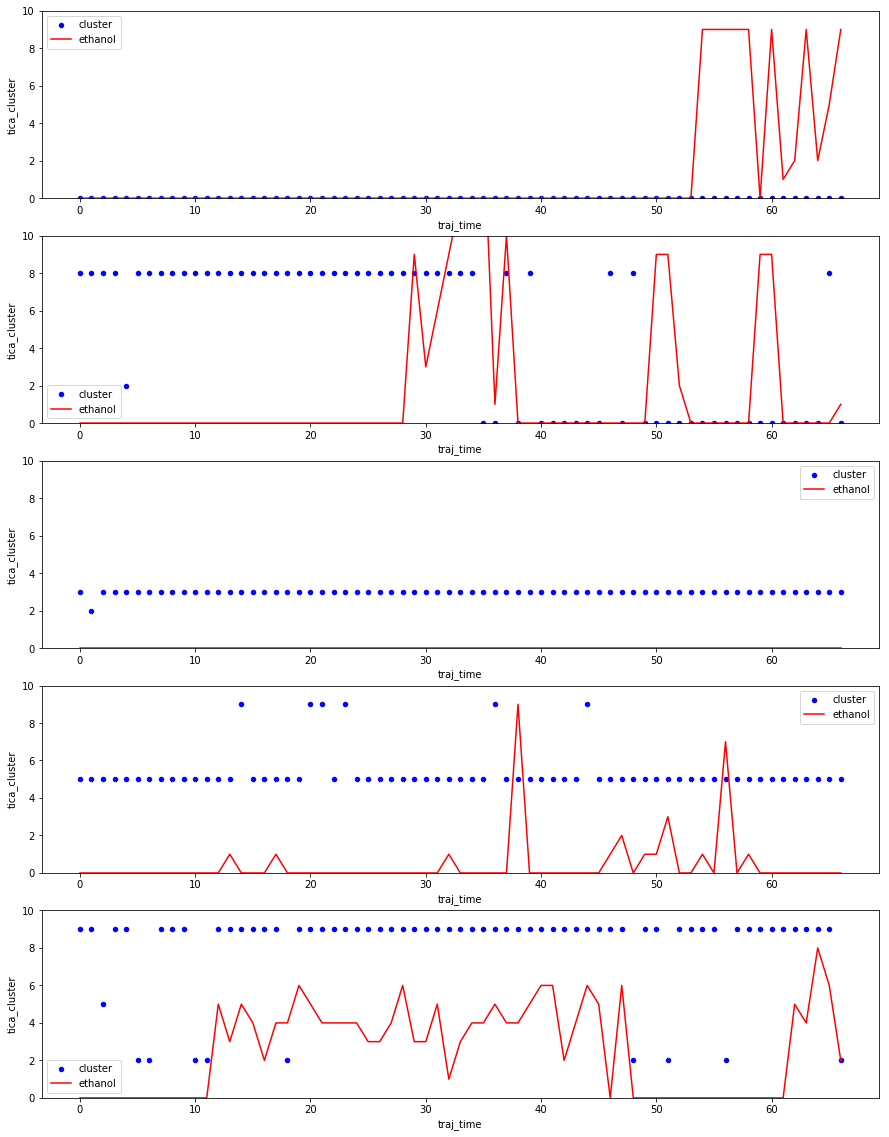

In [173]:
fig, ax = plt.subplots(5,figsize=(15, 20))
md_data[(md_data.system == 10) & (md_data.replicate == '1') & (md_data.subunit == 0)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[0],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '1')  & (md_data.subunit == 0)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[0],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '1') & (md_data.subunit == 1)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[1],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '1')  & (md_data.subunit == 1)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[1],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '1') & (md_data.subunit == 2)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[2],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '1')  & (md_data.subunit == 2)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[2],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '1') & (md_data.subunit == 3)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[3],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '1')  & (md_data.subunit == 3)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[3],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '1') & (md_data.subunit == 4)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[4],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '1')  & (md_data.subunit == 4)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[4],label='ethanol',c='red')
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)
ax[4].set_ylim(0,10)


(0, 10)

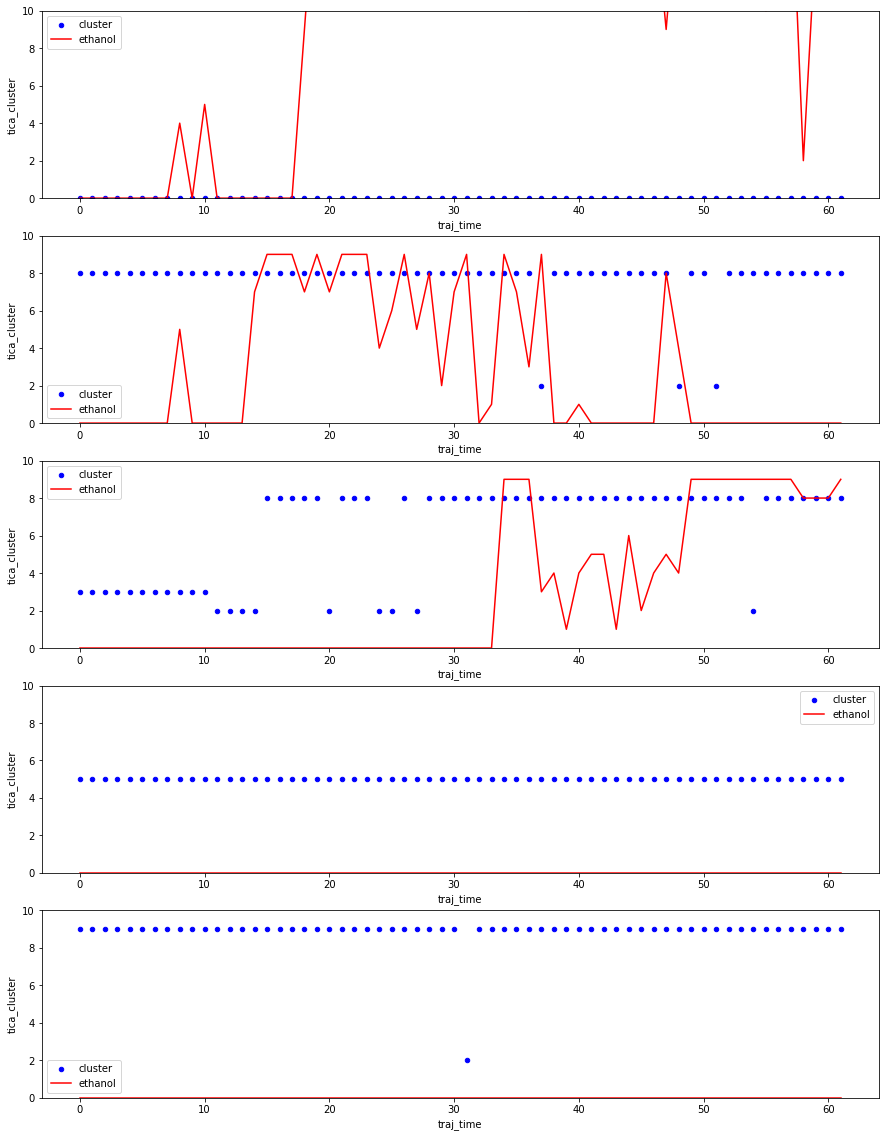

In [174]:
fig, ax = plt.subplots(5,figsize=(15, 20))
md_data[(md_data.system == 10) & (md_data.replicate == '2') & (md_data.subunit == 0)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[0],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '2')  & (md_data.subunit == 0)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[0],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '2') & (md_data.subunit == 1)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[1],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '2')  & (md_data.subunit == 1)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[1],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '2') & (md_data.subunit == 2)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[2],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '2')  & (md_data.subunit == 2)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[2],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '2') & (md_data.subunit == 3)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[3],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '2')  & (md_data.subunit == 3)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[3],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '2') & (md_data.subunit == 4)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[4],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '2')  & (md_data.subunit == 4)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[4],label='ethanol',c='red')
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)
ax[4].set_ylim(0,10)


(0, 10)

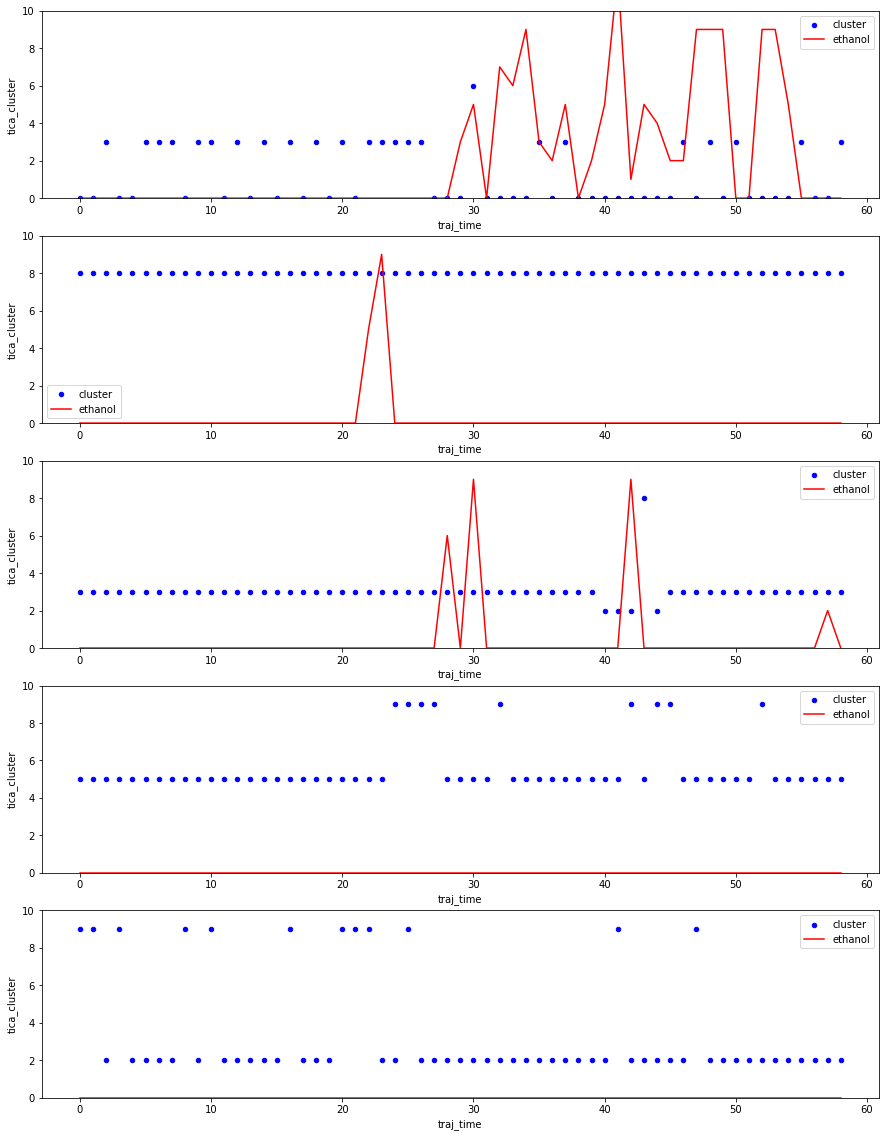

In [175]:
fig, ax = plt.subplots(5,figsize=(15, 20))
md_data[(md_data.system == 10) & (md_data.replicate == '3') & (md_data.subunit == 0)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[0],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '3')  & (md_data.subunit == 0)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[0],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '3') & (md_data.subunit == 1)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[1],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '3')  & (md_data.subunit == 1)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[1],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '3') & (md_data.subunit == 2)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[2],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '3')  & (md_data.subunit == 2)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[2],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '3') & (md_data.subunit == 3)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[3],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '3')  & (md_data.subunit == 3)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[3],label='ethanol',c='red')
md_data[(md_data.system == 10) & (md_data.replicate == '3') & (md_data.subunit == 4)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[4],label='cluster',c='blue')
md_data[(md_data.system == 10) & (md_data.replicate == '3')  & (md_data.subunit == 4)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[4],label='ethanol',c='red')
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)
ax[4].set_ylim(0,10)


(0, 10)

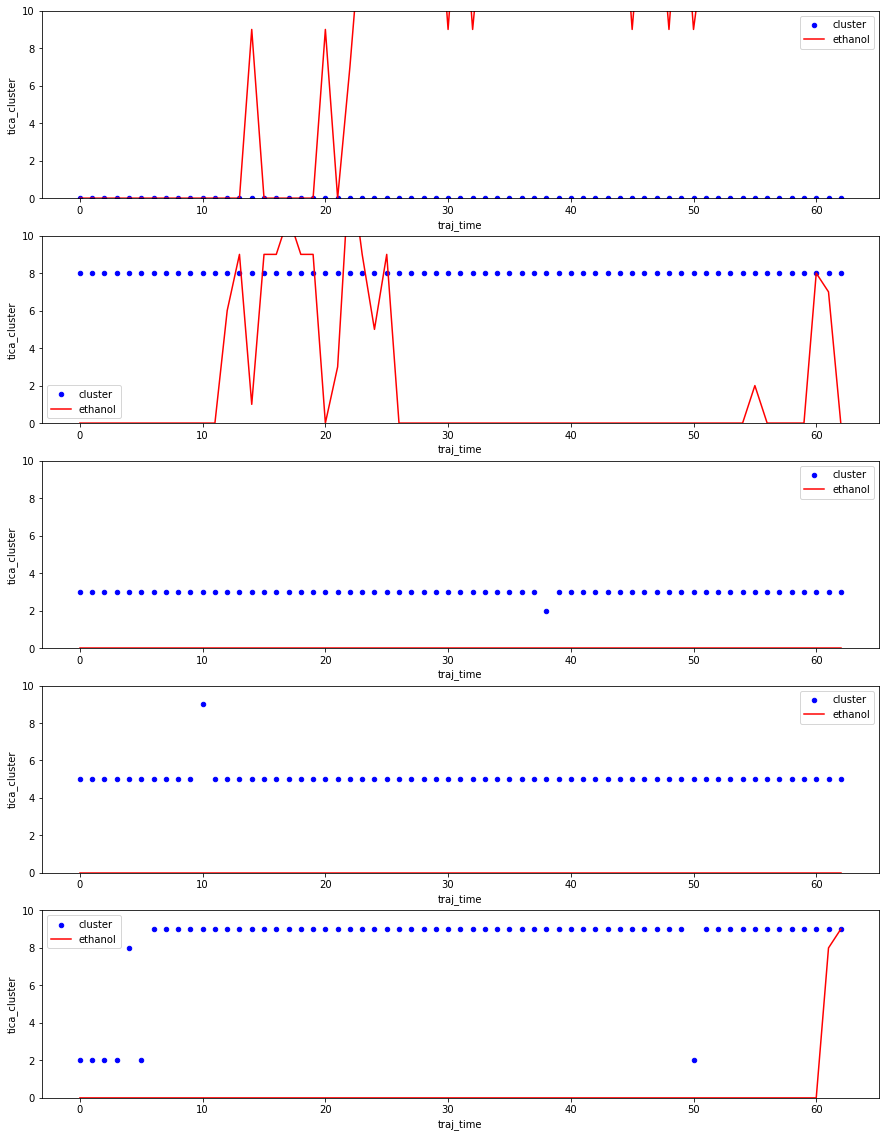

In [176]:
fig, ax = plt.subplots(5,figsize=(15, 20))
md_data[(md_data.system == 12) & (md_data.replicate == '1') & (md_data.subunit == 0)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[0],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '1')  & (md_data.subunit == 0)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[0],label='ethanol',c='red')
md_data[(md_data.system == 12) & (md_data.replicate == '1') & (md_data.subunit == 1)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[1],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '1')  & (md_data.subunit == 1)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[1],label='ethanol',c='red')
md_data[(md_data.system == 12) & (md_data.replicate == '1') & (md_data.subunit == 2)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[2],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '1')  & (md_data.subunit == 2)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[2],label='ethanol',c='red')
md_data[(md_data.system == 12) & (md_data.replicate == '1') & (md_data.subunit == 3)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[3],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '1')  & (md_data.subunit == 3)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[3],label='ethanol',c='red')
md_data[(md_data.system == 12) & (md_data.replicate == '1') & (md_data.subunit == 4)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[4],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '1')  & (md_data.subunit == 4)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[4],label='ethanol',c='red')
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)
ax[4].set_ylim(0,10)


(0, 10)

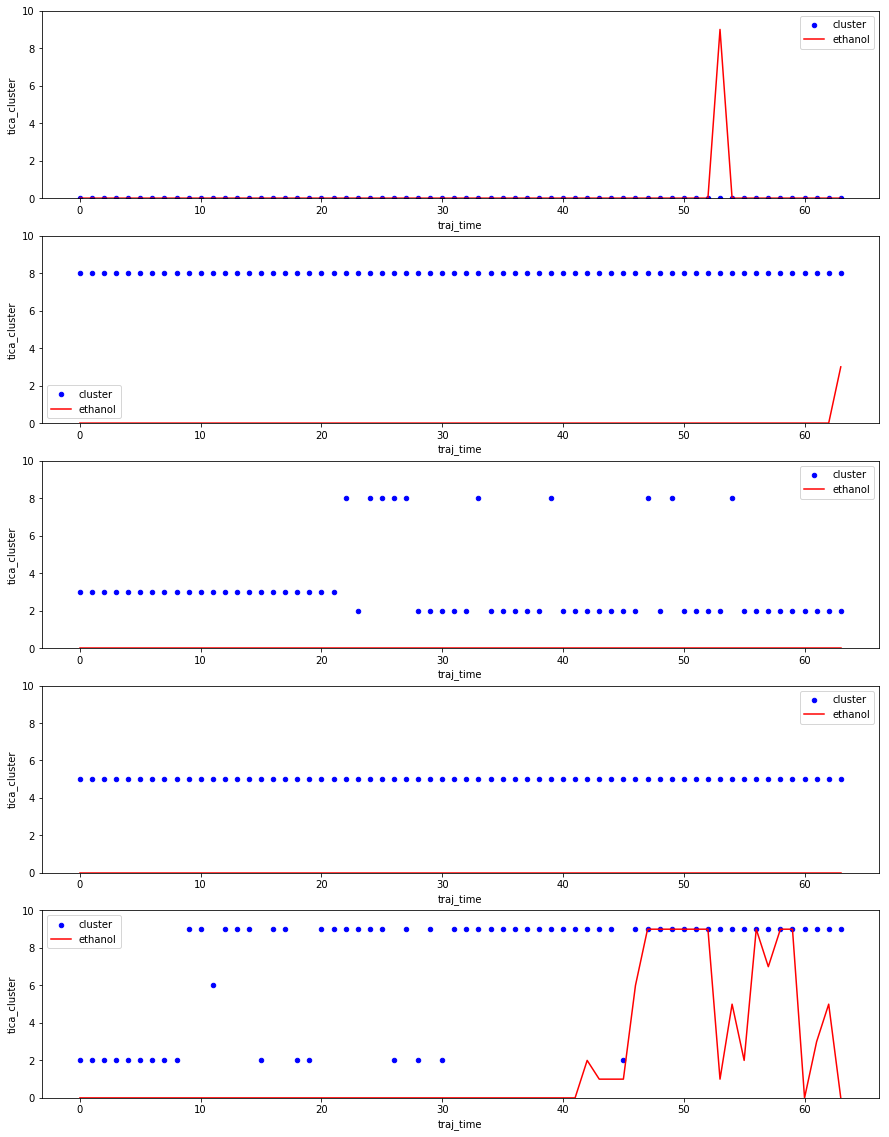

In [177]:
fig, ax = plt.subplots(5,figsize=(15, 20))
md_data[(md_data.system == 12) & (md_data.replicate == '2') & (md_data.subunit == 0)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[0],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '2')  & (md_data.subunit == 0)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[0],label='ethanol',c='red')
md_data[(md_data.system == 12) & (md_data.replicate == '2') & (md_data.subunit == 1)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[1],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '2')  & (md_data.subunit == 1)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[1],label='ethanol',c='red')
md_data[(md_data.system == 12) & (md_data.replicate == '2') & (md_data.subunit == 2)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[2],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '2')  & (md_data.subunit == 2)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[2],label='ethanol',c='red')
md_data[(md_data.system == 12) & (md_data.replicate == '2') & (md_data.subunit == 3)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[3],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '2')  & (md_data.subunit == 3)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[3],label='ethanol',c='red')
md_data[(md_data.system == 12) & (md_data.replicate == '2') & (md_data.subunit == 4)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[4],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '2')  & (md_data.subunit == 4)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[4],label='ethanol',c='red')
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)
ax[4].set_ylim(0,10)


(0, 10)

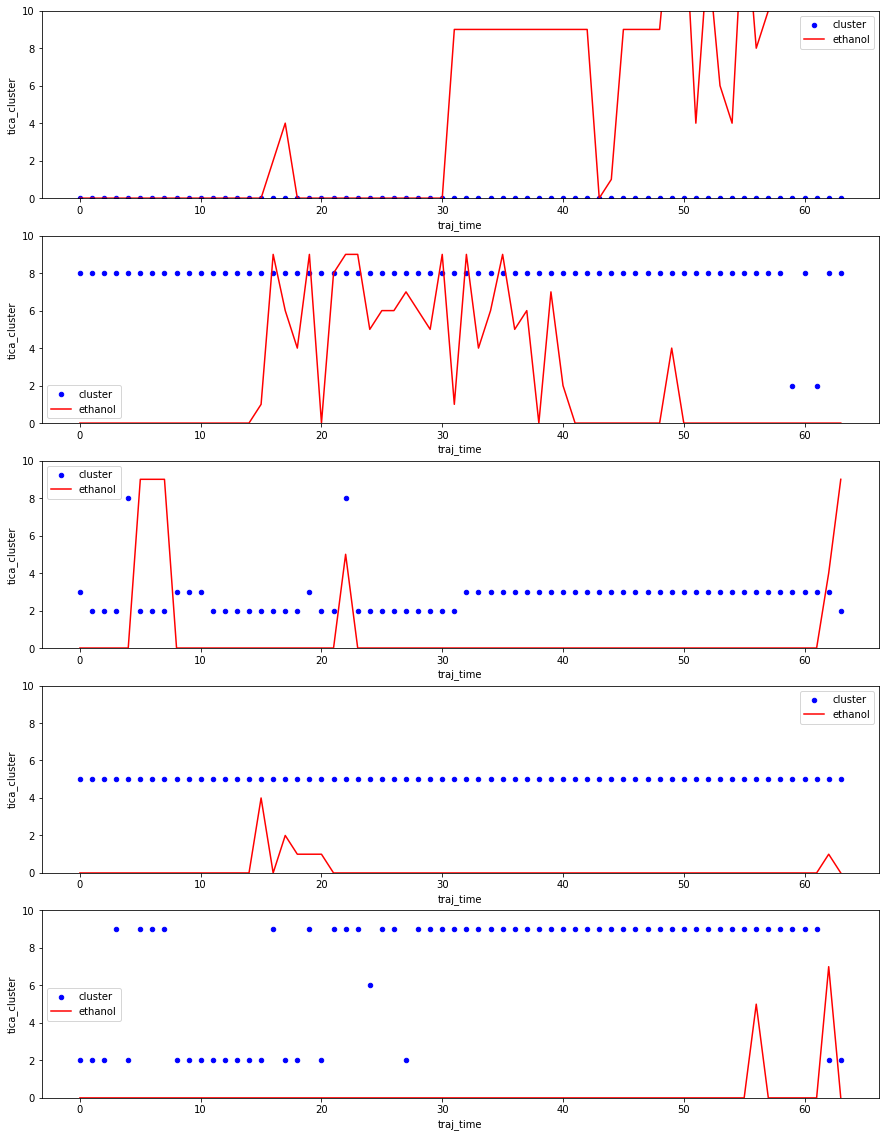

In [178]:
fig, ax = plt.subplots(5,figsize=(15, 20))
md_data[(md_data.system == 12) & (md_data.replicate == '3') & (md_data.subunit == 0)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[0],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '3')  & (md_data.subunit == 0)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[0],label='ethanol',c='red')
md_data[(md_data.system == 12) & (md_data.replicate == '3') & (md_data.subunit == 1)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[1],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '3')  & (md_data.subunit == 1)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[1],label='ethanol',c='red')
md_data[(md_data.system == 12) & (md_data.replicate == '3') & (md_data.subunit == 2)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[2],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '3')  & (md_data.subunit == 2)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[2],label='ethanol',c='red')
md_data[(md_data.system == 12) & (md_data.replicate == '3') & (md_data.subunit == 3)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[3],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '3')  & (md_data.subunit == 3)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[3],label='ethanol',c='red')
md_data[(md_data.system == 12) & (md_data.replicate == '3') & (md_data.subunit == 4)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[4],label='cluster',c='blue')
md_data[(md_data.system == 12) & (md_data.replicate == '3')  & (md_data.subunit == 4)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[4],label='ethanol',c='red')
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)
ax[4].set_ylim(0,10)


(0, 10)

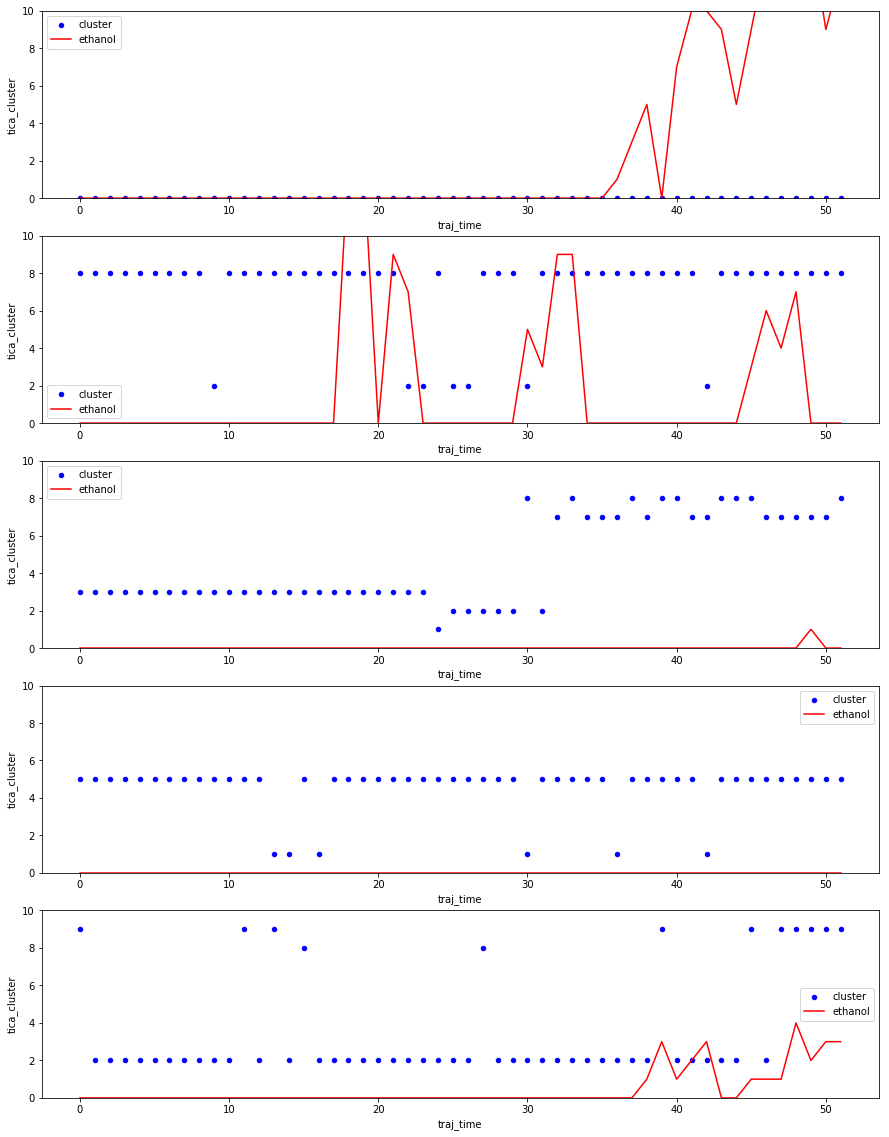

In [179]:
fig, ax = plt.subplots(5,figsize=(15, 20))
md_data[(md_data.system == 9) & (md_data.replicate == '1') & (md_data.subunit == 0)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[0],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '1')  & (md_data.subunit == 0)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[0],label='ethanol',c='red')
md_data[(md_data.system == 9) & (md_data.replicate == '1') & (md_data.subunit == 1)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[1],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '1')  & (md_data.subunit == 1)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[1],label='ethanol',c='red')
md_data[(md_data.system == 9) & (md_data.replicate == '1') & (md_data.subunit == 2)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[2],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '1')  & (md_data.subunit == 2)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[2],label='ethanol',c='red')
md_data[(md_data.system == 9) & (md_data.replicate == '1') & (md_data.subunit == 3)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[3],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '1')  & (md_data.subunit == 3)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[3],label='ethanol',c='red')
md_data[(md_data.system == 9) & (md_data.replicate == '1') & (md_data.subunit == 4)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[4],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '1')  & (md_data.subunit == 4)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[4],label='ethanol',c='red')
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)
ax[4].set_ylim(0,10)


(0, 10)

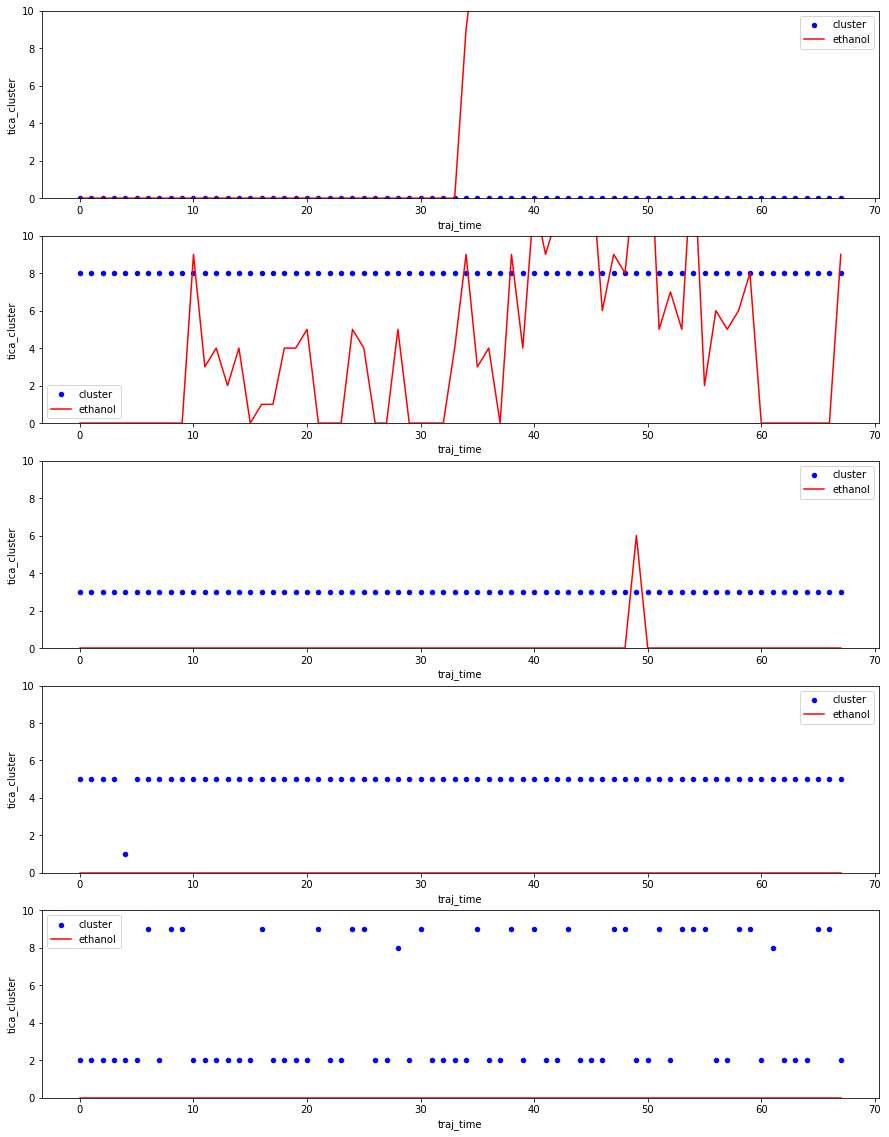

In [180]:
fig, ax = plt.subplots(5,figsize=(15, 20))
md_data[(md_data.system == 9) & (md_data.replicate == '2') & (md_data.subunit == 0)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[0],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '2')  & (md_data.subunit == 0)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[0],label='ethanol',c='red')
md_data[(md_data.system == 9) & (md_data.replicate == '2') & (md_data.subunit == 1)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[1],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '2')  & (md_data.subunit == 1)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[1],label='ethanol',c='red')
md_data[(md_data.system == 9) & (md_data.replicate == '2') & (md_data.subunit == 2)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[2],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '2')  & (md_data.subunit == 2)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[2],label='ethanol',c='red')
md_data[(md_data.system == 9) & (md_data.replicate == '2') & (md_data.subunit == 3)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[3],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '2')  & (md_data.subunit == 3)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[3],label='ethanol',c='red')
md_data[(md_data.system == 9) & (md_data.replicate == '2') & (md_data.subunit == 4)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[4],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '2')  & (md_data.subunit == 4)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[4],label='ethanol',c='red')
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)
ax[4].set_ylim(0,10)


(0, 10)

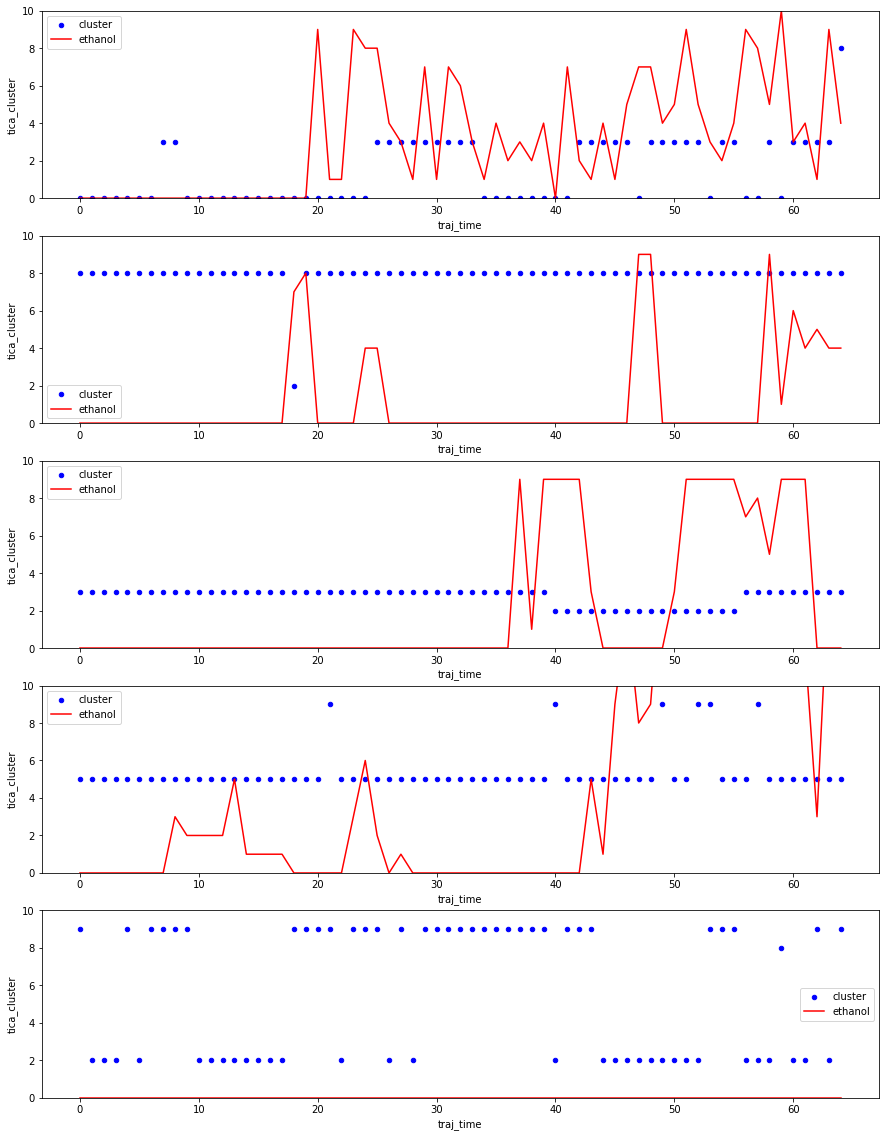

In [181]:
fig, ax = plt.subplots(5,figsize=(15, 20))
md_data[(md_data.system == 9) & (md_data.replicate == '3') & (md_data.subunit == 0)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[0],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '3')  & (md_data.subunit == 0)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[0],label='ethanol',c='red')
md_data[(md_data.system == 9) & (md_data.replicate == '3') & (md_data.subunit == 1)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[1],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '3')  & (md_data.subunit == 1)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[1],label='ethanol',c='red')
md_data[(md_data.system == 9) & (md_data.replicate == '3') & (md_data.subunit == 2)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[2],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '3')  & (md_data.subunit == 2)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[2],label='ethanol',c='red')
md_data[(md_data.system == 9) & (md_data.replicate == '3') & (md_data.subunit == 3)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[3],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '3')  & (md_data.subunit == 3)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[3],label='ethanol',c='red')
md_data[(md_data.system == 9) & (md_data.replicate == '3') & (md_data.subunit == 4)].plot(kind='scatter',x='traj_time',y='tica_cluster',ax=ax[4],label='cluster',c='blue')
md_data[(md_data.system == 9) & (md_data.replicate == '3')  & (md_data.subunit == 4)].plot(x='traj_time',y='intersubunit_ethanol_right',ax=ax[4],label='ethanol',c='red')
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)
ax[4].set_ylim(0,10)
